<a href="https://colab.research.google.com/github/claravivian/Predicting-Drought-in-The-United-States-Using-Deep-Learning/blob/main/MLP_and_LSTM_jasper_stlucie_holt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library

In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.6 MB/s 


In [ ]:
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers

import tensorflow_addons as tfa
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.layers import Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.2)
from keras.layers import PReLU
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
from copy import copy

In [ ]:
print(tf.version.VERSION)

2.9.2


In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 5.3 MB/s 
     |████████████████████████████████| 1.6 MB 53.5 MB/s 


In [ ]:
import kerastuner as kt

#Import Data From Kaggle

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download cdminix/us-drought-meteorological-data

100% 900M/901M [00:38<00:00, 26.2MB/s]
100% 901M/901M [00:38<00:00, 24.3MB/s]


In [ ]:
!unzip us-drought-meteorological-data.zip

Archive:  us-drought-meteorological-data.zip
  inflating: soil_data.csv           
  inflating: test_timeseries/test_timeseries.csv  
  inflating: train_timeseries/train_timeseries.csv  
  inflating: validation_timeseries/validation_timeseries.csv  


In [ ]:
train = pd.read_csv('/content/train_timeseries/train_timeseries.csv')
soil = pd.read_csv('/content/soil_data.csv')
validation = pd.read_csv('/content/validation_timeseries/validation_timeseries.csv')
test = pd.read_csv('/content/test_timeseries/test_timeseries.csv')
pd.set_option('display.max_columns', None)

#Checking the Data

##train (1-1-2000 until 31-12-2016)

In [ ]:
train.head()

fips        date  PRECTOT      PS   QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0  1001  2000-01-01     0.22  100.51   9.65  14.74   13.51   13.51    20.96   
1  1001  2000-01-02     0.20  100.55  10.42  16.69   14.71   14.71    22.80   
2  1001  2000-01-03     3.65  100.15  11.76  18.49   16.52   16.52    22.73   
3  1001  2000-01-04    15.95  100.29   6.42  11.40    6.09    6.10    18.09   
4  1001  2000-01-05     0.00  101.15   2.95   3.86   -3.29   -3.20    10.82   

   T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  WS50M  \
0    11.46       9.50  14.65   2.20       2.94       1.49         1.46   4.85   
1    12.61      10.18  16.60   2.52       3.43       1.83         1.60   5.33   
2    15.32       7.41  18.41   4.03       5.33       2.66         2.67   7.53   
3     2.16      15.92  11.31   3.84       5.67       2.08         3.59   6.73   
4    -2.66      13.48   2.65   1.60       2.50       0.52         1.98   2.94   

   WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
0       6.04       3.23         2.81    NaN  
1       6.13       3.72         2.41    NaN  
2       9.52       5.87         3.66    NaN  
3       9.31       3.74         5.58    1.0  
4       4.85       0.65         4.19    NaN

In [ ]:
train.tail()

fips        date  PRECTOT     PS  QV2M   T2M  T2MDEW  T2MWET  \
19300675  56043  2016-12-27     0.16  82.88  1.63 -7.97  -13.49  -12.81   
19300676  56043  2016-12-28     0.02  83.33  1.41 -8.71  -14.10  -13.84   
19300677  56043  2016-12-29     0.00  83.75  1.59 -7.96  -13.30  -13.03   
19300678  56043  2016-12-30     1.22  82.49  2.63 -2.94   -7.40   -7.33   
19300679  56043  2016-12-31     0.44  82.19  1.75 -7.56  -11.98  -11.82   

          T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
19300675    -1.39   -13.60      12.21  -9.41   5.90       7.63       3.61   
19300676    -2.49   -13.56      11.07 -10.55   6.50      11.43       4.11   
19300677     0.42   -14.51      14.93 -10.29   4.29       6.24       2.03   
19300678     3.76    -6.86      10.62  -4.14   4.98       7.34       1.99   
19300679    -0.95   -11.61      10.66 -10.17   2.31       3.47       0.41   

          WS10M_RANGE  WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
19300675         4.02   8.58      10.39       5.92         4.47    0.0  
19300676         7.32   9.92      14.49       7.26         7.22    NaN  
19300677         4.22   6.56      10.07       3.20         6.87    NaN  
19300678         5.35   7.28      10.12       3.24         6.89    NaN  
19300679         3.06   3.37       5.26       0.66         4.60    NaN

In [ ]:
train.shape

(19300680, 21)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19300680 entries, 0 to 19300679
Data columns (total 21 columns):
 #   Column       Dtype  
---  ------       -----  
 0   fips         int64  
 1   date         object 
 2   PRECTOT      float64
 3   PS           float64
 4   QV2M         float64
 5   T2M          float64
 6   T2MDEW       float64
 7   T2MWET       float64
 8   T2M_MAX      float64
 9   T2M_MIN      float64
 10  T2M_RANGE    float64
 11  TS           float64
 12  WS10M        float64
 13  WS10M_MAX    float64
 14  WS10M_MIN    float64
 15  WS10M_RANGE  float64
 16  WS50M        float64
 17  WS50M_MAX    float64
 18  WS50M_MIN    float64
 19  WS50M_RANGE  float64
 20  score        float64
dtypes: float64(19), int64(1), object(1)
memory usage: 3.0+ GB


In [ ]:
#banyak data NaN
missing_values_count = train.isnull().sum()
missing_values_count

fips                  0
date                  0
PRECTOT               0
PS                    0
QV2M                  0
T2M                   0
T2MDEW                0
T2MWET                0
T2M_MAX               0
T2M_MIN               0
T2M_RANGE             0
TS                    0
WS10M                 0
WS10M_MAX             0
WS10M_MIN             0
WS10M_RANGE           0
WS50M                 0
WS50M_MAX             0
WS50M_MIN             0
WS50M_RANGE           0
score          16543884
dtype: int64

##list of variables in the weather data

Indicator	Description

WS10M_MIN	Minimum Wind Speed at 10 Meters (m/s)

QV2M	Specific Humidity at 2 Meters (g/kg)

T2M_RANGE	Temperature Range at 2 Meters (C)

WS10M	Wind Speed at 10 Meters (m/s)

T2M	Temperature at 2 Meters (C)

WS50M_MIN	Minimum Wind Speed at 50 Meters (m/s)

T2M_MAX	Maximum Temperature at 2 Meters (C)

WS50M	Wind Speed at 50 Meters (m/s)

TS	Earth Skin Temperature (C)

WS50M_RANGE	Wind Speed Range at 50 Meters (m/s)

WS50M_MAX	Maximum Wind Speed at 50 Meters (m/s)

WS10M_MAX	Maximum Wind Speed at 10 Meters (m/s)

WS10M_RANGE	Wind Speed Range at 10 Meters (m/s)

PS	Surface Pressure (kPa)

T2MDEW	Dew/Frost Point at 2 Meters (C)

T2M_MIN	Minimum Temperature at 2 Meters (C)

T2MWET	Wet Bulb Temperature at 2 Meters (C)

PRECTOT	Precipitation (mm day-1)

##soil

In [ ]:
soil.head()

fips        lat        lon  elevation  slope1  slope2  slope3  slope4  \
0  1001  32.536382 -86.644490         63  0.0419  0.2788  0.2984  0.2497   
1  1005  31.870670 -85.405456        146  0.0158  0.1868  0.5441  0.2424   
2  1003  30.659218 -87.746067         52  0.0746  0.4370  0.4415  0.0469   
3  1007  33.015893 -87.127148         93  0.0144  0.1617  0.3714  0.3493   
4  1009  33.977448 -86.567246        198  0.0050  0.0872  0.2799  0.3576   

   slope5  slope6  slope7  slope8  aspectN  aspectE  aspectS  aspectW  \
0  0.1142  0.0170  0.0000     0.0   0.1033   0.1859   0.2003   0.1898   
1  0.0106  0.0003  0.0000     0.0   0.1415   0.2379   0.2183   0.1997   
2  0.0000  0.0000  0.0000     0.0   0.1168   0.1386   0.1048   0.1282   
3  0.0898  0.0134  0.0000     0.0   0.1971   0.1885   0.2279   0.2104   
4  0.1477  0.1037  0.0189     0.0   0.2569   0.1503   0.2028   0.2978   

   aspectUnknown  WAT_LAND   NVG_LAND  URB_LAND  GRS_LAND   FOR_LAND  \
0         0.3207    0.9974  27.940498    0.2889  2.750274  10.714703   
1         0.2026    0.0000   0.000000    0.4146  2.225602  22.952839   
2         0.5116    0.0000   0.000000    3.5010  4.972456  28.685991   
3         0.1761    0.0000   0.000000    0.2283  8.674664  89.172112   
4         0.0922    0.0000   0.000000    1.0037  8.606856  88.470047   

   CULTRF_LAND  CULTIR_LAND  CULT_LAND  SQ1  SQ2  SQ3  SQ4  SQ5  SQ6  SQ7  
0    56.293411     1.014811  57.308224    1    1    1    1    1    1    2  
1    72.578804     1.828159  74.406960    3    2    1    1    1    1    1  
2    59.843639     2.996914  62.840553    3    2    1    2    1    1    1  
3     1.916593     0.008330   1.924924    3    2    1    1    1    1    1  
4     1.891909     0.027488   1.919397    3    2    1    1    1    1    1

In [ ]:
soil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3109 entries, 0 to 3108
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fips           3109 non-null   int64  
 1   lat            3109 non-null   float64
 2   lon            3109 non-null   float64
 3   elevation      3109 non-null   int64  
 4   slope1         3109 non-null   float64
 5   slope2         3109 non-null   float64
 6   slope3         3109 non-null   float64
 7   slope4         3109 non-null   float64
 8   slope5         3109 non-null   float64
 9   slope6         3109 non-null   float64
 10  slope7         3109 non-null   float64
 11  slope8         3109 non-null   float64
 12  aspectN        3109 non-null   float64
 13  aspectE        3109 non-null   float64
 14  aspectS        3109 non-null   float64
 15  aspectW        3109 non-null   float64
 16  aspectUnknown  3109 non-null   float64
 17  WAT_LAND       3109 non-null   float64
 18  NVG_LAND

In [ ]:
soil.describe()

fips          lat          lon    elevation       slope1  \
count   3109.000000  3109.000000  3109.000000  3109.000000  3109.000000   
mean   30678.538437    38.280052   -91.659790   427.624638     0.054973   
std    14986.018730     4.838634    11.485291   500.158880     0.089873   
min     1001.000000    25.601043  -124.211407    -1.000000     0.000000   
25%    19045.000000    34.686818   -98.046842   132.000000     0.008300   
50%    29213.000000    38.328061   -90.181170   272.000000     0.028300   
75%    46009.000000    41.703590   -83.373303   483.000000     0.068500   
max    56045.000000    48.842653   -67.609354  3561.000000     0.974000   

           slope2       slope3       slope4       slope5       slope6  \
count  3109.00000  3109.000000  3109.000000  3109.000000  3109.000000   
mean      0.29775     0.319991     0.155878     0.053409     0.065323   
std       0.21595     0.167727     0.128400     0.073107     0.125526   
min       0.00000     0.000000     0.000000     0.000000     0.000000   
25%       0.10510     0.185800     0.040800     0.000500     0.000000   
50%       0.27100     0.347100     0.127500     0.012200     0.000700   
75%       0.47750     0.459300     0.255200     0.090300     0.054100   
max       0.75990     0.696900     0.571700     0.330000     0.606800   

            slope7       slope8      aspectN      aspectE      aspectS  \
count  3109.000000  3109.000000  3109.000000  3109.000000  3109.000000   
mean      0.022223     0.009267     0.143749     0.168888     0.148392   
std       0.064127     0.044933     0.078237     0.084105     0.082111   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.086200     0.109200     0.086300   
50%       0.000000     0.000000     0.144200     0.174000     0.148300   
75%       0.001200     0.000000     0.195600     0.227600     0.206600   
max       0.476500     0.628800     0.478400     0.738500     0.511200   

           aspectW  aspectUnknown     WAT_LAND     NVG_LAND     URB_LAND  \
count  3109.000000    3109.000000  3109.000000  3109.000000  3109.000000   
mean      0.165061       0.352723     2.850511     1.801451     2.670026   
std       0.087843       0.272182    13.159247     7.971805     9.770693   
min       0.000000       0.000000     0.000000     0.000000     0.000000   
25%       0.101500       0.115600     0.000000     0.000000     0.104800   
50%       0.165500       0.305900     0.000000     0.000000     0.488500   
75%       0.223100       0.555200     0.000000     0.000000     1.115100   
max       0.657800       1.000000   100.000000    99.982918    99.998764   

          GRS_LAND     FOR_LAND  CULTRF_LAND  CULTIR_LAND    CULT_LAND  \
count  3109.000000  3109.000000  3109.000000  3109.000000  3109.000000   
mean     19.812154    39.296586    28.494804     3.504682    31.999486   
std      25.447435    34.365530    31.839502    10.290893    33.099657   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       4.360057     4.552230     0.143526     0.045909     1.602227   
50%       8.839095    30.573359    14.043937     0.276606    18.811279   
75%      23.720787    74.532990    51.737080     1.370315    60.637421   
max      99.998596    91.044609    97.029572    99.956841    99.956841   

               SQ1          SQ2          SQ3         SQ4          SQ5  \
count  3109.000000  3109.000000  3109.000000  3109.00000  3109.000000   
mean      1.830492     1.553554     1.282084     1.35735     1.146993   
std       1.192219     1.021382     1.002508     1.03011     0.922308   
min       0.000000     0.000000     0.000000     0.00000     0.000000   
25%       1.000000     1.000000     1.000000     1.00000     1.000000   
50%       1.000000     1.000000     1.000000     1.00000     1.000000   
75%       3.000000     2.000000     1.000000     1.00000     1.000000   
max       7.000000     7.000000     7.000000     7.00000     7.000000   

    

In [ ]:
#banyak data NaN
missing_values_count = soil.isnull().sum()
missing_values_count

fips             0
lat              0
lon              0
elevation        0
slope1           0
slope2           0
slope3           0
slope4           0
slope5           0
slope6           0
slope7           0
slope8           0
aspectN          0
aspectE          0
aspectS          0
aspectW          0
aspectUnknown    0
WAT_LAND         0
NVG_LAND         0
URB_LAND         0
GRS_LAND         0
FOR_LAND         0
CULTRF_LAND      0
CULTIR_LAND      0
CULT_LAND        0
SQ1              0
SQ2              0
SQ3              0
SQ4              0
SQ5              0
SQ6              0
SQ7              0
dtype: int64

##validation (1-1-2017 until 31-12-2018)

In [ ]:
validation.head()

fips        date  PRECTOT      PS   QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0  1001  2017-01-01    32.50  100.02  10.47  14.69   14.47   14.47    17.68   
1  1001  2017-01-02    63.52  100.04  12.75  17.96   17.75   17.75    20.30   
2  1001  2017-01-03    18.82   99.69   9.74  14.24   13.44   13.44    18.48   
3  1001  2017-01-04     0.01  100.02   5.21   8.10    3.86    3.88    11.74   
4  1001  2017-01-05     0.01   99.89   4.54   5.91    2.20    2.22    13.07   

   T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  WS50M  \
0    10.53       7.15  14.63   2.14       2.71       1.52         1.19   4.40   
1    16.14       4.16  17.85   2.75       4.31       1.60         2.71   5.50   
2     9.29       9.20  14.06   2.25       3.73       1.64         2.09   4.80   
3     2.12       9.62   8.08   2.63       3.95       1.34         2.60   4.98   
4    -0.18      13.24   5.85   1.76       2.76       0.47         2.28   3.43   

   WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
0       5.96       2.25         3.71    NaN  
1       8.16       4.05         4.11    NaN  
2       7.27       2.54         4.72    2.0  
3       6.16       3.36         2.80    NaN  
4       4.70       0.66         4.04    NaN

In [ ]:
validation.tail()

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  \
2268835  56043  2018-12-27     0.14  82.71  1.54  -9.57  -14.20  -13.09   
2268836  56043  2018-12-28     0.02  83.14  1.32 -11.25  -15.98  -14.57   
2268837  56043  2018-12-29     0.34  82.78  1.75  -7.17  -12.62  -12.17   
2268838  56043  2018-12-30     3.17  81.97  2.72  -2.84   -7.14   -6.95   
2268839  56043  2018-12-31     1.39  83.16  1.03 -13.02  -18.93  -16.97   

         T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
2268835    -6.23   -12.06       5.82 -10.10   2.01       3.56       0.23   
2268836    -7.03   -14.33       7.30 -12.36   1.66       3.12       0.09   
2268837     0.64   -14.85      15.50  -8.09   3.64       4.71       2.47   
2268838     2.14    -8.49      10.62  -3.63   5.26      11.19       1.70   
2268839    -9.70   -16.67       6.96 -13.06   4.53       9.66       0.82   

         WS10M_RANGE  WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
2268835         3.33   2.67       4.70       0.28         4.42    NaN  
2268836         3.04   2.40       5.58       0.08         5.50    NaN  
2268837         2.24   5.58       7.61       4.15         3.46    NaN  
2268838         9.49   7.56      13.59       3.11        10.49    NaN  
2268839         8.84   5.51      11.90       0.96        10.94    NaN

In [ ]:
validation.info()

In [ ]:
#banyak data NaN
missing_values_count = validation.isnull().sum()
missing_values_count

fips                 0
date                 0
PRECTOT              0
PS                   0
QV2M                 0
T2M                  0
T2MDEW               0
T2MWET               0
T2M_MAX              0
T2M_MIN              0
T2M_RANGE            0
TS                   0
WS10M                0
WS10M_MAX            0
WS10M_MIN            0
WS10M_RANGE          0
WS50M                0
WS50M_MAX            0
WS50M_MIN            0
WS50M_RANGE          0
score          1945608
dtype: int64

In [ ]:
validation.shape

(2268840, 21)

##test (1-1-2019 until 31-12-2020)

In [ ]:
test.head()

In [ ]:
test.tail()

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2271948 entries, 0 to 2271947
Data columns (total 21 columns):
 #   Column       Dtype  
---  ------       -----  
 0   fips         int64  
 1   date         object 
 2   PRECTOT      float64
 3   PS           float64
 4   QV2M         float64
 5   T2M          float64
 6   T2MDEW       float64
 7   T2MWET       float64
 8   T2M_MAX      float64
 9   T2M_MIN      float64
 10  T2M_RANGE    float64
 11  TS           float64
 12  WS10M        float64
 13  WS10M_MAX    float64
 14  WS10M_MIN    float64
 15  WS10M_RANGE  float64
 16  WS50M        float64
 17  WS50M_MAX    float64
 18  WS50M_MIN    float64
 19  WS50M_RANGE  float64
 20  score        float64
dtypes: float64(19), int64(1), object(1)
memory usage: 364.0+ MB


In [ ]:
#banyak data NaN
missing_values_count = test.isnull().sum()
missing_values_count

fips                 0
date                 0
PRECTOT              0
PS                   0
QV2M                 0
T2M                  0
T2MDEW               0
T2MWET               0
T2M_MAX              0
T2M_MIN              0
T2M_RANGE            0
TS                   0
WS10M                0
WS10M_MAX            0
WS10M_MIN            0
WS10M_RANGE          0
WS50M                0
WS50M_MAX            0
WS50M_MIN            0
WS50M_RANGE          0
score          1945608
dtype: int64

#Choosing 9 regions of the United States Based on 9 Climate Regions in the United States

There are 9 climate regions in the United States:
1. Northeast
2. Upper Midwest
3. Ohio Valley
4. Southeast
5. Northern Rockies and Plains
6. South
7. Southwest
8. Northwest
9. West

Then, we will choose 1 state from each of the climate regions, there are:
1. New York County, New York (36061), dari Northeast 
2. Dakota County, Minnesota (27037), dari Upper Midwest
3. Jasper County, Missouri (29097), dari Ohio Valley
4. St. Lucie County, Florida (12111), dari Southeast
5. Holt County, Nebraska (31089), dari Northern Rockies and Plains
6. Clark County, Kansas (20025), dari South
7. Coconino County, Arizona (04005), dari Southwest
8. Crook County, Oregon (41013), dari Northwest
9. Los Angeles County, California (06037), dari West

Each notebook contains 3 different states for different models(MLP-and-LSTM and CNN-LSTM)

##Jasper, Missouri

###train

In [ ]:
jasper = train[train['fips']==29097]

#using interpolation to fill in the NaN values
jasper = jasper.interpolate().fillna(method='bfill')
jasper.score[jasper.score <0.5] = 0
jasper.score[(jasper.score >=0.5)&(jasper.score<1.5)] = 1
jasper.score[(jasper.score >=1.5)&(jasper.score<2.5)] = 2
jasper.score[(jasper.score >=2.5)&(jasper.score<3.5)] = 3
jasper.score[(jasper.score >=3.5)&(jasper.score<4.5)] = 4
jasper.score[(jasper.score >=4.5)&(jasper.score<5.5)] = 5

#merging the weather data with the soil data
jasper = jasper.merge(soil, left_on='fips', right_on='fips')
train_js = jasper.copy()
jasper['date'] = pd.to_datetime(jasper['date'], format='%Y.%m.%d')
train_js['tahun'] = jasper['date'].dt.year
train_js['bulan'] = jasper['date'].dt.month
train_js['tanggal'] = jasper['date'].dt.day
train_js[0:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   29097  2000-01-01     0.24  97.47  5.89   7.79    5.52    5.52    15.11   
1   29097  2000-01-02     0.42  97.23  6.46   9.61    6.66    6.66    12.44   
2   29097  2000-01-03    12.93  97.14  4.46   3.04    1.67    1.67     7.67   
3   29097  2000-01-04     0.06  98.74  2.05  -3.87   -8.21   -8.07    -0.71   
4   29097  2000-01-05     0.03  98.39  2.64  -0.08   -5.03   -4.96     6.38   
5   29097  2000-01-06     0.13  98.82  3.30   0.68   -2.20   -2.18     8.20   
6   29097  2000-01-07     0.02  99.15  2.91   2.06   -3.86   -3.79     9.57   
7   29097  2000-01-08     4.02  98.02  5.25   5.33    4.15    4.15     8.33   
8   29097  2000-01-09     0.61  96.82  5.30   6.44    4.14    4.14    11.97   
9   29097  2000-01-10     0.00  96.98  4.07   4.57    0.41    0.42    12.69   
10  29097  2000-01-11     0.02  98.02  2.72   1.86   -4.76   -4.67     7.91   
11  29097  2000-01-12     0.00  97.54  4.85   6.17    2.41    2.42    16.73   
12  29097  2000-01-13     0.00  99.70  2.59  -0.86   -5.12   -5.05     4.59   
13  29097  2000-01-14     0.00  99.82  2.68   0.86   -4.68   -4.60     8.76   
14  29097  2000-01-15     0.00  98.60  5.13   7.26    3.08    3.10    14.42   
15  29097  2000-01-16     0.01  98.81  6.60   9.17    7.26    7.26    12.66   
16  29097  2000-01-17     0.04  98.36  7.62  10.91    9.28    9.28    17.42   
17  29097  2000-01-18     0.00  98.42  4.47   4.80    1.94    1.95     8.59   
18  29097  2000-01-19     0.07  97.68  4.42   4.34    1.13    1.15    12.37   
19  29097  2000-01-20     0.00  98.77  1.72  -4.25  -10.07   -9.83     0.00   
20  29097  2000-01-21     0.06  98.17  2.52   0.25   -5.74   -5.64     6.73   
21  29097  2000-01-22     0.13  97.43  4.13   3.86    0.63    0.64     9.10   
22  29097  2000-01-23     0.18  98.26  3.11  -0.55   -3.17   -3.13     4.42   
23  29097  2000-01-24     0.01  98.57  2.08  -2.85   -7.91   -7.77     2.53   
24  29097  2000-01-25     0.00  98.62  2.01  -3.10   -8.29   -8.13     0.39   
25  29097  2000-01-26     0.48  98.77  1.89  -4.36   -8.96   -8.80    -2.87   
26  29097  2000-01-27     4.67  99.01  2.08  -3.94   -7.86   -7.75    -0.82   
27  29097  2000-01-28     1.38  99.09  2.31  -4.28   -6.51   -6.47    -1.86   
28  29097  2000-01-29     1.11  98.87  2.30  -4.69   -6.62   -6.59    -1.57   
29  29097  2000-01-30     0.16  98.92  2.06  -5.95   -7.94   -7.90    -0.87   
30  29097  2000-01-31     0.04  98.59  2.54  -4.20   -5.69   -5.67     2.36   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0      1.73      13.38   7.07   5.90       7.69       4.22         3.47   
1      2.34      10.10   8.21   5.48       9.26       1.41         7.85   
2     -0.41       8.07   3.06   5.35       7.68       3.36         4.31   
3     -6.73       6.01  -3.59   5.67       8.69       1.57         7.13   
4     -5.13      11.51  -0.48   6.50      10.02       2.20         7.83   
5     -3.44      11.65   0.37   2.76       5.22       1.00         4.22   
6     -2.42      11.98   0.40   2.42       4.75       0.69         4.06   
7      2.58       5.75   5.00   5.10       7.18       3.96         3.22   
8      3.17       8.80   6.29   5.23       7.34       3.98         3.37   
9     -0.51      13.20   4.00   6.23       9.50       3.86         5.63   
10    -3.37      11.28   1.48   3.48       5.71       2.08         3.63   
11     0.48      16.25   5.48   6.31       9.90       3.84         6.06   
12    -4.04       8.64  -0.94   4.39       6.37       2.95         3.42   
13    -4.16      12.92   0.42   5.30       7.75       2.89         4.86   
14    -0.27      14.69   6.71   8.31      11.52       5.38         6.14   
15     6.60       6.05   9.13   3.73       4.93       1.69         3.24   
16     5.29      12.13  10.91   5.34       7.10       3.87         3.23   
17     1.97       6.62   5.33   3.96       4.68       2.91         1.77   
18    -5.35      17.72   4.10   7.56      12.27    

In [ ]:
train_js['score'].value_counts()

0.0    3921
1.0    1122
2.0     695
3.0     350
4.0     102
5.0      20
Name: score, dtype: int64

In [ ]:
#For Regression

jasper = train[train['fips']==29097]

#using interpolation to fill in the NaN values
jasper = jasper.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
jasper = jasper.merge(soil, left_on='fips', right_on='fips')
train_js = jasper.copy()
train_js[2000:2050]

fips        date  PRECTOT     PS   QV2M    T2M  T2MDEW  T2MWET  \
2000  29097  2005-06-23     0.00  98.04  12.51  26.35   17.11   17.11   
2001  29097  2005-06-24     0.00  97.92  13.40  26.71   18.16   18.16   
2002  29097  2005-06-25     0.14  97.94  13.12  27.65   17.85   17.84   
2003  29097  2005-06-26     1.70  97.93  14.01  27.52   18.90   18.90   
2004  29097  2005-06-27     0.92  97.91  13.74  27.51   18.58   18.58   
2005  29097  2005-06-28     0.02  97.81  13.46  28.12   18.22   18.22   
2006  29097  2005-06-29     0.02  97.65  14.12  29.19   18.97   18.97   
2007  29097  2005-06-30    11.38  97.63  15.25  28.93   20.19   20.19   
2008  29097  2005-07-01    16.19  97.72  14.19  24.31   18.99   18.99   
2009  29097  2005-07-02     0.00  97.64  11.34  24.70   15.51   15.51   
2010  29097  2005-07-03     4.98  97.43  14.20  27.16   18.98   18.98   
2011  29097  2005-07-04    11.35  97.76  15.00  24.33   19.97   19.97   
2012  29097  2005-07-05     0.19  98.06  12.49  24.18   17.08   17.08   
2013  29097  2005-07-06     0.02  97.97  11.53  24.95   15.83   15.83   
2014  29097  2005-07-07     0.00  97.96  11.43  26.03   15.67   15.67   
2015  29097  2005-07-08     0.01  98.00  11.21  27.04   15.33   15.33   
2016  29097  2005-07-09     0.00  97.98  11.39  26.87   15.61   15.61   
2017  29097  2005-07-10     2.44  97.85  13.80  26.88   18.65   18.65   
2018  29097  2005-07-11     0.65  97.69  13.68  25.86   18.41   18.41   
2019  29097  2005-07-12     0.98  97.94  13.09  24.53   17.76   17.76   
2020  29097  2005-07-13     0.09  97.82  13.12  25.74   17.80   17.80   
2021  29097  2005-07-14     1.28  97.62  14.47  26.88   19.33   19.33   
2022  29097  2005-07-15     0.06  97.69  14.72  28.27   19.62   19.62   
2023  29097  2005-07-16     0.02  97.77  13.34  28.74   18.00   18.00   
2024  29097  2005-07-17     0.88  97.73  15.21  28.22   20.20   20.20   
2025  29097  2005-07-18    14.28  97.80  16.95  27.50   21.94   21.94   
2026  29097  2005-07-19     4.62  97.92  16.71  27.46   21.74   21.74   
2027  29097  2005-07-20     0.30  97.94  15.91  28.86   20.96   20.96   
2028  29097  2005-07-21     0.00  98.05  14.54  30.06   19.45   19.45   
2029  29097  2005-07-22     0.03  98.07  15.42  31.45   20.43   20.43   
2030  29097  2005-07-23     2.21  98.03  15.27  32.73   20.24   20.24   
2031  29097  2005-07-24     0.83  97.92  15.22  30.79   20.20   20.20   
2032  29097  2005-07-25     0.00  97.67  14.14  31.06   19.01   19.01   
2033  29097  2005-07-26     7.30  97.53  13.86  28.46   18.62   18.62   
2034  29097  2005-07-27     5.87  98.14   9.13  21.44   12.13   12.13   
2035  29097  2005-07-28     0.01  98.25   8.50  22.57   11.14   11.15   
2036  29097  2005-07-29     0.02  98.36   9.16  25.36   12.24   12.25   
2037  29097  2005-07-30     0.01  98.42   9.81  26.37   13.38   13.38   
2038  29097  2005-07-31     0.01  98.26   9.79  26.99   13.22   13.22   
2039  29097  2005-08-01     0.00  98.06  10.99  28.99   15.01   15.01   
2040  29097  2005-08-02     0.16  97.92  11.46  30.06   15.69   15.69   
2041  29097  2005-08-03     0.06  97.84  12.21  30.64   16.69   16.70   
2042  29097  2005-08-04     2.32  98.09  12.70  30.42   17.28   17.28   
2043  29097  2005-08-05     3.05  98.37  13.27  27.42   18.05   18.05   
2044  29097  2005-08-06     3.59  98.21  14.43  26.03   19.42   19.42   
2045  29097  2005-08-07     1.74  98.02  13.80  28.10   18.63   18.63   
2046  29097  2005-08-08     1.83  97.91  13.02  28.80   17.66   17.66   
2047  29097  2005-08-09     0.04  97.86  12.81  29.87   17.40   17.40   
2048  29097  2005-08-10     0.04  97.87  13.08  30.53   17.77   17.77   
2049  29097  2005-08-11     0.00  97.73  13.22  30.81   17.96   17.96   

      T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
2000    32.51    20.46      12.06  25.86   2.90       4.57       1.04   
2001    33.53    19.55      13.98  26.74   3.81       5.80       2.16   
2002    33.62    19.99      13.63  27.67   2.35       4.16      

###val

In [ ]:
jasper_val = validation[validation['fips']==29097]

#using interpolation to fill in the NaN values
jasper_val = jasper_val.interpolate().fillna(method='bfill')
jasper_val.score[jasper_val.score <0.5] = 0
jasper_val.score[(jasper_val.score >=0.5)&(jasper_val.score<1.5)] = 1
jasper_val.score[(jasper_val.score >=1.5)&(jasper_val.score<2.5)] = 2
jasper_val.score[(jasper_val.score >=2.5)&(jasper_val.score<3.5)] = 3
jasper_val.score[(jasper_val.score >=3.5)&(jasper_val.score<4.5)] = 4
jasper_val.score[(jasper_val.score >=4.5)&(jasper_val.score<5.5)] = 5

#merging the weather data with the soil data
jasper_val = jasper_val.merge(soil, left_on='fips', right_on='fips')
val_js = jasper_val.copy()
jasper_val['date'] = pd.to_datetime(jasper_val['date'], format='%Y.%m.%d')
val_js['tahun'] = jasper_val['date'].dt.year
val_js['bulan'] = jasper_val['date'].dt.month
val_js['tanggal'] = jasper_val['date'].dt.day
val_js[0:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   29097  2017-01-01     0.01  97.60  4.18   3.53    0.47    0.48    12.18   
1   29097  2017-01-02     0.81  97.28  7.17   8.75    8.44    8.44    13.41   
2   29097  2017-01-03     0.22  98.02  3.74   2.19   -2.01   -1.91     8.64   
3   29097  2017-01-04     0.11  98.46  1.40  -4.92  -12.35  -11.93    -1.07   
4   29097  2017-01-05     1.29  98.28  1.42  -7.02  -12.36  -12.03    -4.57   
5   29097  2017-01-06     0.01  99.00  0.95 -10.57  -16.42  -15.77    -7.64   
6   29097  2017-01-07     0.00  99.82  1.38  -7.47  -12.55  -12.26     0.34   
7   29097  2017-01-08     0.00  99.56  1.73  -3.66   -9.92   -9.70     3.09   
8   29097  2017-01-09     0.06  98.24  3.72   2.34   -1.38   -1.33     8.73   
9   29097  2017-01-10     0.04  97.18  5.80   9.25    5.00    5.01    15.96   
10  29097  2017-01-11     0.01  97.03  7.07  10.83    7.63    7.64    20.25   
11  29097  2017-01-12     0.01  98.44  2.73  -0.35   -5.53   -5.43     6.57   
12  29097  2017-01-13    11.78  99.32  3.28  -0.46   -2.39   -2.36     1.77   
13  29097  2017-01-14     9.77  99.31  3.50  -0.16   -1.26   -1.25     0.61   
14  29097  2017-01-15    18.72  98.52  4.50   2.26    1.89    1.90     4.81   
15  29097  2017-01-16    11.46  97.59  5.86   6.99    5.40    5.40    13.07   
16  29097  2017-01-17     0.04  98.20  4.13   2.46    0.87    0.87     7.20   
17  29097  2017-01-18     0.16  98.14  5.06   4.82    3.49    3.49    11.54   
18  29097  2017-01-19     0.17  97.07  6.52   7.68    7.11    7.11    11.77   
19  29097  2017-01-20     0.05  96.33  6.51  10.20    6.98    6.99    15.62   
20  29097  2017-01-21     4.23  96.26  6.47   9.60    6.82    6.82    14.57   
21  29097  2017-01-22    16.27  96.48  5.71   6.03    4.74    4.74    10.26   
22  29097  2017-01-23     0.13  97.44  3.89   2.57   -0.07   -0.06     8.38   
23  29097  2017-01-24     0.00  96.59  5.65   8.77    4.48    4.49    17.40   
24  29097  2017-01-25     0.00  97.31  3.47   2.28   -1.84   -1.80     6.12   
25  29097  2017-01-26     0.01  98.33  2.49  -2.15   -5.73   -5.67     1.56   
26  29097  2017-01-27     0.00  98.34  2.50  -0.58   -5.66   -5.58     5.73   
27  29097  2017-01-28     0.04  98.04  3.24   1.61   -2.44   -2.41     7.63   
28  29097  2017-01-29     0.00  98.02  3.96   3.56    0.19    0.20    10.44   
29  29097  2017-01-30     0.00  97.86  4.48   6.22    1.92    1.93    14.72   
30  29097  2017-01-31     0.00  97.68  3.95   7.02    0.09    0.13    14.15   

    T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  WS50M  \
0     -3.10      15.28  3.56   4.17       5.55       3.07         2.47   6.55   
1      5.68       7.73  8.50   3.97       5.65       2.04         3.61   5.97   
2     -6.33      14.97  2.43   6.78       8.59       2.46         6.14   8.75   
3     -8.06       6.98 -3.82   4.37       5.89       2.19         3.70   5.56   
4    -10.30       5.74 -5.92   5.99       7.12       4.82         2.30   7.16   
5    -13.28       5.64 -9.76   3.58       5.68       1.25         4.42   4.46   
6    -13.51      13.85 -7.78   2.91       5.70       0.39         5.31   4.23   
7    -10.31      13.40 -3.88   5.46       7.94       2.39         5.54   7.87   
8     -4.21      12.94  1.86   7.70      11.04       4.60         6.43  11.11   
9      1.12      14.84  7.93   8.84      15.21       2.44        12.77  12.15   
10     1.96      18.28  9.96   7.48      14.14       3.31        10.83  11.45   
11    -3.94      10.51  0.51   5.34       6.68       3.93         2.76   6.65   
12    -3.83       5.59 -0.25   4.13       6.68       1.76         4.91   5.28   
13    -0.96       1.58  0.05   2.90       3.65       1.72         1.93   3.79   
14    -0.23       5.04  1.67   3.36       5.89       1.04         4.85   5.40   
15     1.09      11.98  6.23   6.59       8.80       4.32         4.48   9.98   
16    -0.46       7.66  1.92   3.51       4.60       1.81         2.79   5.06   
17    -0.57      1

In [ ]:
val_js['score'].value_counts()

0.0    304
1.0    272
2.0     98
3.0     42
4.0     14
Name: score, dtype: int64

In [ ]:
#For Regression

jasper_val = validation[validation['fips']==29097]

#using interpolation to fill in the NaN values
jasper_val = jasper_val.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
jasper_val = jasper_val.merge(soil, left_on='fips', right_on='fips')
val_js = jasper_val.copy()
val_js[0:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   29097  2017-01-01     0.01  97.60  4.18   3.53    0.47    0.48    12.18   
1   29097  2017-01-02     0.81  97.28  7.17   8.75    8.44    8.44    13.41   
2   29097  2017-01-03     0.22  98.02  3.74   2.19   -2.01   -1.91     8.64   
3   29097  2017-01-04     0.11  98.46  1.40  -4.92  -12.35  -11.93    -1.07   
4   29097  2017-01-05     1.29  98.28  1.42  -7.02  -12.36  -12.03    -4.57   
5   29097  2017-01-06     0.01  99.00  0.95 -10.57  -16.42  -15.77    -7.64   
6   29097  2017-01-07     0.00  99.82  1.38  -7.47  -12.55  -12.26     0.34   
7   29097  2017-01-08     0.00  99.56  1.73  -3.66   -9.92   -9.70     3.09   
8   29097  2017-01-09     0.06  98.24  3.72   2.34   -1.38   -1.33     8.73   
9   29097  2017-01-10     0.04  97.18  5.80   9.25    5.00    5.01    15.96   
10  29097  2017-01-11     0.01  97.03  7.07  10.83    7.63    7.64    20.25   
11  29097  2017-01-12     0.01  98.44  2.73  -0.35   -5.53   -5.43     6.57   
12  29097  2017-01-13    11.78  99.32  3.28  -0.46   -2.39   -2.36     1.77   
13  29097  2017-01-14     9.77  99.31  3.50  -0.16   -1.26   -1.25     0.61   
14  29097  2017-01-15    18.72  98.52  4.50   2.26    1.89    1.90     4.81   
15  29097  2017-01-16    11.46  97.59  5.86   6.99    5.40    5.40    13.07   
16  29097  2017-01-17     0.04  98.20  4.13   2.46    0.87    0.87     7.20   
17  29097  2017-01-18     0.16  98.14  5.06   4.82    3.49    3.49    11.54   
18  29097  2017-01-19     0.17  97.07  6.52   7.68    7.11    7.11    11.77   
19  29097  2017-01-20     0.05  96.33  6.51  10.20    6.98    6.99    15.62   
20  29097  2017-01-21     4.23  96.26  6.47   9.60    6.82    6.82    14.57   
21  29097  2017-01-22    16.27  96.48  5.71   6.03    4.74    4.74    10.26   
22  29097  2017-01-23     0.13  97.44  3.89   2.57   -0.07   -0.06     8.38   
23  29097  2017-01-24     0.00  96.59  5.65   8.77    4.48    4.49    17.40   
24  29097  2017-01-25     0.00  97.31  3.47   2.28   -1.84   -1.80     6.12   
25  29097  2017-01-26     0.01  98.33  2.49  -2.15   -5.73   -5.67     1.56   
26  29097  2017-01-27     0.00  98.34  2.50  -0.58   -5.66   -5.58     5.73   
27  29097  2017-01-28     0.04  98.04  3.24   1.61   -2.44   -2.41     7.63   
28  29097  2017-01-29     0.00  98.02  3.96   3.56    0.19    0.20    10.44   
29  29097  2017-01-30     0.00  97.86  4.48   6.22    1.92    1.93    14.72   
30  29097  2017-01-31     0.00  97.68  3.95   7.02    0.09    0.13    14.15   

    T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  WS50M  \
0     -3.10      15.28  3.56   4.17       5.55       3.07         2.47   6.55   
1      5.68       7.73  8.50   3.97       5.65       2.04         3.61   5.97   
2     -6.33      14.97  2.43   6.78       8.59       2.46         6.14   8.75   
3     -8.06       6.98 -3.82   4.37       5.89       2.19         3.70   5.56   
4    -10.30       5.74 -5.92   5.99       7.12       4.82         2.30   7.16   
5    -13.28       5.64 -9.76   3.58       5.68       1.25         4.42   4.46   
6    -13.51      13.85 -7.78   2.91       5.70       0.39         5.31   4.23   
7    -10.31      13.40 -3.88   5.46       7.94       2.39         5.54   7.87   
8     -4.21      12.94  1.86   7.70      11.04       4.60         6.43  11.11   
9      1.12      14.84  7.93   8.84      15.21       2.44        12.77  12.15   
10     1.96      18.28  9.96   7.48      14.14       3.31        10.83  11.45   
11    -3.94      10.51  0.51   5.34       6.68       3.93         2.76   6.65   
12    -3.83       5.59 -0.25   4.13       6.68       1.76         4.91   5.28   
13    -0.96       1.58  0.05   2.90       3.65       1.72         1.93   3.79   
14    -0.23       5.04  1.67   3.36       5.89       1.04         4.85   5.40   
15     1.09      11.98  6.23   6.59       8.80       4.32         4.48   9.98   
16    -0.46       7.66  1.92   3.51       4.60       1.81         2.79   5.06   
17    -0.57      1

###test

In [ ]:
jasper_test = test[test['fips']==29097]

#using interpolation to fill in the NaN values
jasper_test = jasper_test.interpolate().fillna(method='bfill')
jasper_test.score[jasper_test.score <0.5] = 0
jasper_test.score[(jasper_test.score >=0.5)&(jasper_test.score<1.5)] = 1
jasper_test.score[(jasper_test.score >=1.5)&(jasper_test.score<2.5)] = 2
jasper_test.score[(jasper_test.score >=2.5)&(jasper_test.score<3.5)] = 3
jasper_test.score[(jasper_test.score >=3.5)&(jasper_test.score<4.5)] = 4
jasper_test.score[(jasper_test.score >=4.5)&(jasper_test.score<5.5)] = 5

#merging the weather data with the soil data
jasper_test = jasper_test.merge(soil, left_on='fips', right_on='fips')
test_js = jasper_test.copy()
jasper_test['date'] = pd.to_datetime(jasper_test['date'], format='%Y.%m.%d')
test_js['tahun'] = jasper_test['date'].dt.year
test_js['bulan'] = jasper_test['date'].dt.month
test_js['tanggal'] = jasper_test['date'].dt.day
test_js[0:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   29097  2019-01-01     0.04  98.86  2.48  -3.15   -5.91   -5.69     0.07   
1   29097  2019-01-02     0.09  98.58  2.50  -2.92   -5.85   -5.61    -1.63   
2   29097  2019-01-03     4.92  97.98  3.03  -0.52   -3.38   -3.34     2.86   
3   29097  2019-01-04     6.42  97.46  3.63   1.83   -1.03   -1.00     8.13   
4   29097  2019-01-05     0.02  97.96  4.71   3.69    2.62    2.43    12.28   
5   29097  2019-01-06     0.06  97.67  6.71   9.36    7.64    7.51    14.70   
6   29097  2019-01-07     0.54  97.33  7.58  12.34    9.42    9.22    17.38   
7   29097  2019-01-08     0.00  98.64  3.95   5.07    0.34    0.27    10.82   
8   29097  2019-01-09     0.00  99.36  2.45  -0.78   -5.99   -5.74     4.55   
9   29097  2019-01-10     1.58  98.84  2.97   0.35   -3.51   -3.57     5.31   
10  29097  2019-01-11    26.98  98.17  4.08   1.51    0.64    0.69     2.38   
11  29097  2019-01-12    12.83  97.86  3.68  -0.22   -0.79   -0.75     0.42   
12  29097  2019-01-13     0.15  99.01  2.89  -2.93   -3.90   -3.81    -0.02   
13  29097  2019-01-14     0.01  99.14  2.74  -3.61   -4.58   -4.46    -0.44   
14  29097  2019-01-15     0.03  98.61  3.49  -1.03   -1.42   -1.64     4.68   
15  29097  2019-01-16     0.87  98.26  4.75   3.25    2.80    2.75     6.36   
16  29097  2019-01-17     2.48  98.11  4.79   3.35    2.87    2.84     4.92   
17  29097  2019-01-18     1.11  97.40  5.33   5.04    4.28    4.05     9.25   
18  29097  2019-01-19     6.62  97.94  2.42  -4.43   -6.40   -6.65     5.05   
19  29097  2019-01-20     0.00  98.80  1.93  -5.34   -9.14   -8.87    -0.04   
20  29097  2019-01-21     0.02  98.14  2.98  -0.89   -3.60   -3.57     2.76   
21  29097  2019-01-22     6.26  97.36  4.97   3.56    3.31    2.93     8.11   
22  29097  2019-01-23     0.10  97.91  2.28  -4.06   -7.11   -6.79    -1.02   
23  29097  2019-01-24     0.01  98.39  2.44  -3.09   -6.19   -6.10     1.86   
24  29097  2019-01-25     0.03  98.80  1.93  -5.81   -9.16   -8.96     0.20   
25  29097  2019-01-26     0.16  98.27  3.24  -0.18   -2.49   -2.58     7.32   
26  29097  2019-01-27     0.12  97.83  3.88   2.61   -0.09   -0.09     9.00   
27  29097  2019-01-28     1.43  97.75  2.97  -0.46   -3.68   -4.16     2.39   
28  29097  2019-01-29     0.11  98.51  2.05  -3.14   -8.38   -7.99     2.14   
29  29097  2019-01-30     0.01  98.89  0.98 -10.68  -17.50  -15.66    -7.49   
30  29097  2019-01-31     0.03  98.31  3.12  -2.69   -2.97   -4.09     6.46   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0     -5.01       5.07  -2.38   3.85       6.06       1.68         4.37   
1     -4.03       2.41  -2.69   2.67       4.04       1.39         2.65   
2     -3.83       6.70  -0.69   1.77       3.52       0.44         3.08   
3     -1.04       9.17   1.34   3.54       4.83       2.69         2.14   
4     -1.63      13.91   2.67   3.57       4.47       2.88         1.59   
5      3.69      11.00   8.37   6.33       9.68       3.57         6.11   
6      5.77      11.62  11.53   6.84      10.24       3.50         6.74   
7     -0.86      11.67   4.34   5.13       7.19       3.47         3.72   
8     -3.86       8.41  -1.08   4.11       6.55       2.38         4.16   
9     -4.28       9.59   0.23   2.95       3.92       2.22         1.70   
10     0.36       2.03   1.45   5.04       6.19       4.00         2.18   
11    -2.32       2.74  -0.45   4.26       5.88       1.69         4.19   
12    -5.39       5.37  -3.29   4.16       5.68       2.14         3.54   
13    -5.66       5.21  -4.68   2.05       3.36       1.08         2.28   
14    -5.38      10.06  -1.70   3.69       4.69       2.32         2.37   
15     0.16       6.20   2.70   2.85       4.55       1.95         2.61   
16     0.34       4.58   3.08   2.40       4.21       0.55         3.66   
17     0.12       9.13   4.82   5.11       8.70       1.41         7.28   
18    -8.60      13.65  -4.06  10.51      13.40    

In [ ]:
test_js['score'].value_counts()

0.0    568
1.0    110
2.0     34
3.0     19
Name: score, dtype: int64

In [ ]:
#For Regression

jasper_test = test[test['fips']==29097]

#using interpolation to fill in the NaN values
jasper_test = jasper_test.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
jasper_test = jasper_test.merge(soil, left_on='fips', right_on='fips')
test_js = jasper_test.copy()
test_js[0:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   29097  2019-01-01     0.04  98.86  2.48  -3.15   -5.91   -5.69     0.07   
1   29097  2019-01-02     0.09  98.58  2.50  -2.92   -5.85   -5.61    -1.63   
2   29097  2019-01-03     4.92  97.98  3.03  -0.52   -3.38   -3.34     2.86   
3   29097  2019-01-04     6.42  97.46  3.63   1.83   -1.03   -1.00     8.13   
4   29097  2019-01-05     0.02  97.96  4.71   3.69    2.62    2.43    12.28   
5   29097  2019-01-06     0.06  97.67  6.71   9.36    7.64    7.51    14.70   
6   29097  2019-01-07     0.54  97.33  7.58  12.34    9.42    9.22    17.38   
7   29097  2019-01-08     0.00  98.64  3.95   5.07    0.34    0.27    10.82   
8   29097  2019-01-09     0.00  99.36  2.45  -0.78   -5.99   -5.74     4.55   
9   29097  2019-01-10     1.58  98.84  2.97   0.35   -3.51   -3.57     5.31   
10  29097  2019-01-11    26.98  98.17  4.08   1.51    0.64    0.69     2.38   
11  29097  2019-01-12    12.83  97.86  3.68  -0.22   -0.79   -0.75     0.42   
12  29097  2019-01-13     0.15  99.01  2.89  -2.93   -3.90   -3.81    -0.02   
13  29097  2019-01-14     0.01  99.14  2.74  -3.61   -4.58   -4.46    -0.44   
14  29097  2019-01-15     0.03  98.61  3.49  -1.03   -1.42   -1.64     4.68   
15  29097  2019-01-16     0.87  98.26  4.75   3.25    2.80    2.75     6.36   
16  29097  2019-01-17     2.48  98.11  4.79   3.35    2.87    2.84     4.92   
17  29097  2019-01-18     1.11  97.40  5.33   5.04    4.28    4.05     9.25   
18  29097  2019-01-19     6.62  97.94  2.42  -4.43   -6.40   -6.65     5.05   
19  29097  2019-01-20     0.00  98.80  1.93  -5.34   -9.14   -8.87    -0.04   
20  29097  2019-01-21     0.02  98.14  2.98  -0.89   -3.60   -3.57     2.76   
21  29097  2019-01-22     6.26  97.36  4.97   3.56    3.31    2.93     8.11   
22  29097  2019-01-23     0.10  97.91  2.28  -4.06   -7.11   -6.79    -1.02   
23  29097  2019-01-24     0.01  98.39  2.44  -3.09   -6.19   -6.10     1.86   
24  29097  2019-01-25     0.03  98.80  1.93  -5.81   -9.16   -8.96     0.20   
25  29097  2019-01-26     0.16  98.27  3.24  -0.18   -2.49   -2.58     7.32   
26  29097  2019-01-27     0.12  97.83  3.88   2.61   -0.09   -0.09     9.00   
27  29097  2019-01-28     1.43  97.75  2.97  -0.46   -3.68   -4.16     2.39   
28  29097  2019-01-29     0.11  98.51  2.05  -3.14   -8.38   -7.99     2.14   
29  29097  2019-01-30     0.01  98.89  0.98 -10.68  -17.50  -15.66    -7.49   
30  29097  2019-01-31     0.03  98.31  3.12  -2.69   -2.97   -4.09     6.46   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0     -5.01       5.07  -2.38   3.85       6.06       1.68         4.37   
1     -4.03       2.41  -2.69   2.67       4.04       1.39         2.65   
2     -3.83       6.70  -0.69   1.77       3.52       0.44         3.08   
3     -1.04       9.17   1.34   3.54       4.83       2.69         2.14   
4     -1.63      13.91   2.67   3.57       4.47       2.88         1.59   
5      3.69      11.00   8.37   6.33       9.68       3.57         6.11   
6      5.77      11.62  11.53   6.84      10.24       3.50         6.74   
7     -0.86      11.67   4.34   5.13       7.19       3.47         3.72   
8     -3.86       8.41  -1.08   4.11       6.55       2.38         4.16   
9     -4.28       9.59   0.23   2.95       3.92       2.22         1.70   
10     0.36       2.03   1.45   5.04       6.19       4.00         2.18   
11    -2.32       2.74  -0.45   4.26       5.88       1.69         4.19   
12    -5.39       5.37  -3.29   4.16       5.68       2.14         3.54   
13    -5.66       5.21  -4.68   2.05       3.36       1.08         2.28   
14    -5.38      10.06  -1.70   3.69       4.69       2.32         2.37   
15     0.16       6.20   2.70   2.85       4.55       1.95         2.61   
16     0.34       4.58   3.08   2.40       4.21       0.55         3.66   
17     0.12       9.13   4.82   5.11       8.70       1.41         7.28   
18    -8.60      13.65  -4.06  10.51      13.40    

###MLP model (with weather and soil data)

####preprocessing data

In [ ]:
score_js = train_js['score']
score_val_js = val_js['score']
score_test_js = test_js['score']

In [ ]:
score_arr_js = score_js.copy()
score_val_arr_js = score_val_js.copy()
score_test_arr_js = score_test_js.copy()

In [ ]:
score_arr_js = score_arr_js.to_numpy()
score_val_arr_js = score_val_arr_js.to_numpy()
score_test_arr_js = score_test_arr_js.to_numpy()

In [ ]:
score_arr_js =pd.DataFrame(score_arr_js, columns=['Score']) 
score_arr_js

Score
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
...     ...
6205    1.0
6206    1.0
6207    1.0
6208    1.0
6209    1.0

[6210 rows x 1 columns]

In [ ]:
score_val_arr_js =pd.DataFrame(score_val_arr_js, columns=['Score']) 
score_val_arr_js

Score
0      2.0
1      2.0
2      2.0
3      2.0
4      2.0
..     ...
725    2.0
726    2.0
727    2.0
728    2.0
729    2.0

[730 rows x 1 columns]

In [ ]:
#score_arr_js = to_categorical(score_arr_js,num_classes=6)
#score_val_arr_js = to_categorical(score_val_arr_js,num_classes=6)
score_test_arr_js = to_categorical(score_test_arr_js,num_classes=6)

In [ ]:
jasper_train = train_js.copy()
jasper_val = val_js.copy()
jasper_test = test_js.copy()

In [ ]:
X1_js = jasper_train.drop(columns=['fips','date','score','tahun','bulan','tanggal'])
X_val_js = jasper_val.drop(columns=['fips','date','score','tahun','bulan','tanggal'])
X_test_js = jasper_test.drop(columns=['fips','date','score','tahun','bulan','tanggal'])

In [ ]:
X1_js, y1_js = X1_js, score_arr_js
X_val_js, y_val_js = X_val_js, score_val_arr_js
X_test_js, y_test_js = X_test_js, score_test_arr_js
X1_js.shape, y1_js.shape, X_val_js.shape, y_val_js.shape, X_test_js.shape, y_test_js.shape

((6210, 49), (6210, 1), (730, 49), (730, 1), (731, 49), (731, 6))

In [ ]:
#rasio 1 : 1
sm_js1 = SMOTE(sampling_strategy={0:3921,1:3921,2:3921,3:3921,4:3921,5:3921},random_state=42,k_neighbors=3)
sm_js2 = SMOTE(sampling_strategy={0:304,1:304,2:304,3:304,4:304},random_state=42,k_neighbors=3)
X1_js_sm, y1_js_df_sm = sm_js1.fit_resample(X1_js, score_arr_js.values.ravel())
X_val_js_sm, y_val_js_sm = sm_js2.fit_resample(X_val_js,y_val_js.values.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X1_js_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y1_js_df_sm.shape))

print('After OverSampling, the shape of train_X: {}'.format(X_val_js_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_val_js_sm.shape))

After OverSampling, the shape of train_X: (23526, 49)
After OverSampling, the shape of train_y: (23526,) 

After OverSampling, the shape of train_X: (1520, 49)
After OverSampling, the shape of train_y: (1520,) 



In [ ]:
X1_js_sm, y1_js_df_sm = X1_js_sm, to_categorical(y1_js_df_sm,
                                                               num_classes=6)
X_val_js_sm, y_val_js_sm = X_val_js_sm, to_categorical(y_val_js_sm,
                                                                     num_classes=6)

####building the models using keras tuner

##### 1.objective : True Positive (range 32 - 800 layers)

In [ ]:
def build_model_js1(hp):
  model_js1 = Sequential()
  model_js1.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=800, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=800, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=800, step=32)
  model_js1.add(Dense(units=hp_units1, activation= "elu", kernel_initializer="he_normal"))
  model_js1.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model_js1.add(BatchNormalization())
  model_js1.add(Dense(units=hp_units2, activation= "elu", kernel_initializer="he_normal"))
  model_js1.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model_js1.add(BatchNormalization())
  model_js1.add(Dense(units=hp_units3, activation= "elu", kernel_initializer="he_normal"))
  model_js1.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model_js1.add(BatchNormalization())
  model_js1.add(Dense(6, activation='softmax'))

  hp_optimizer_js=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_js == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_js', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_js == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_js', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model_js1.compile(
      optimizer= hp_optimizer_js,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.TruePositives(name='true_positives'),
               'categorical_accuracy']
  )
  return model_js1

# HyperBand algorithm from keras tuner
tuner_js1 = kt.Hyperband(
    build_model_js1,
    objective= kt.Objective('val_true_positives', direction="max"),
    max_epochs=50,
    directory='js_dir',
    project_name='jasper1',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner_js1.search(X1_js_sm, y1_js_df_sm, epochs=50, validation_data = (X_val_js_sm,y_val_js_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 00m 54s]
val_true_positives: 146.0

Best val_true_positives So Far: 318.0
Total elapsed time: 01h 09m 25s


In [ ]:
best_mlp_hyperparameters_js1 = tuner_js1.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters_js1.values

Best Hyper-parameters


{'units1': 160,
 'units2': 704,
 'units3': 544,
 'dropout_1': 0.0,
 'dropout_2': 0.0,
 'dropout_3': 0.3,
 'Optimizer': 'SGD',
 'learning_rate_js': 0.1,
 'tuner/epochs': 17,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 1,
 'tuner/round': 0}

In [ ]:
best_model_js1 = tuner_js1.get_best_models()[0]
best_model_js1.build(X1_js_sm.shape)
best_model_js1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (23526, 49)              196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (23526, 160)              8000      
                                                                 
 dropout (Dropout)           (23526, 160)              0         
                                                                 
 batch_normalization_1 (Batc  (23526, 160)             640       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (23526, 704)              113344    
                                                                 
 dropout_1 (Dropout)         (23526, 704)              0

In [ ]:
new_model_js1 = Sequential()
new_model_js1.add(tf.keras.Input(shape=(49,)))
new_model_js1.add(BatchNormalization())
new_model_js1.add(Dense(160, activation = "elu", kernel_initializer="he_normal"))
new_model_js1.add(BatchNormalization())
new_model_js1.add(Dense(704, activation = "elu", kernel_initializer="he_normal"))
new_model_js1.add(BatchNormalization())
new_model_js1.add(Dense(544, activation = "elu", kernel_initializer="he_normal"))
new_model_js1.add(Dropout(0.3))
new_model_js1.add(BatchNormalization())
new_model_js1.add((Dense(6, activation='softmax')))
new_model_js1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 49)               196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 160)               8000      
                                                                 
 batch_normalization_1 (Batc  (None, 160)              640       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 704)               113344    
                                                                 
 batch_normalization_2 (Batc  (None, 704)              2816      
 hNormalization)                                                 
                                                        

In [ ]:
cp_js1 = ModelCheckpoint('new_model_js1/', save_best_only=True)
opt_js1 = keras.optimizers.SGD(learning_rate=0.1)
new_model_js1.compile(optimizer = opt_js1, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_js1.fit(X1_js_sm, y1_js_df_sm, validation_data = (X_val_js_sm,y_val_js_sm),
               epochs=50,batch_size=64, callbacks =[cp_js1,early_stopping_monitor])

Epoch 1/50
368/368 [==============================] - 10s 23ms/step - loss: 1.5333 - categorical_accuracy: 0.4351 - val_loss: 32.0578 - val_categorical_accuracy: 0.2000
Epoch 2/50
368/368 [==============================] - 8s 20ms/step - loss: 1.2778 - categorical_accuracy: 0.4906 - val_loss: 4.3937 - val_categorical_accuracy: 0.1987
Epoch 3/50
368/368 [==============================] - 10s 27ms/step - loss: 1.2002 - categorical_accuracy: 0.5177 - val_loss: 2.9665 - val_categorical_accuracy: 0.1743
Epoch 4/50
368/368 [==============================] - 5s 15ms/step - loss: 1.1411 - categorical_accuracy: 0.5364 - val_loss: 3.9394 - val_categorical_accuracy: 0.1730
Epoch 5/50
368/368 [==============================] - 6s 17ms/step - loss: 1.1075 - categorical_accuracy: 0.5480 - val_loss: 3.4044 - val_categorical_accuracy: 0.1789
Epoch 6/50
368/368 [==============================] - 5s 15ms/step - loss: 1.0718 - categorical_accuracy: 0.5610 - val_loss: 3.0719 - val_categorical_accuracy: 0.

In [ ]:
test_predictions_js1 = new_model_js1.predict(X_test_js)
test_predictions_js1

23/23 [==============================] - 1s 9ms/step


array([[2.14750111e-01, 6.76285803e-01, 6.28297310e-03, 1.01390086e-01,
        1.29044813e-03, 4.40629378e-07],
       [3.07688385e-01, 6.27107918e-01, 6.55782875e-03, 5.61869256e-02,
        2.38962658e-03, 6.92985632e-05],
       [4.44757998e-01, 2.94208437e-01, 3.49570140e-02, 2.26025611e-01,
        4.83160620e-05, 2.61630453e-06],
       ...,
       [1.36066660e-01, 5.05351603e-01, 3.09162363e-02, 3.16612661e-01,
        1.10490099e-02, 3.82005965e-06],
       [3.40335310e-01, 1.73564717e-01, 3.25368524e-01, 1.60557404e-01,
        1.74043627e-04, 3.88387500e-09],
       [2.67533332e-01, 5.37576258e-01, 2.34224349e-02, 1.54694289e-01,
        1.67577229e-02, 1.58687781e-05]], dtype=float32)

In [ ]:
classes_js1 = np.argmax(test_predictions_js1, axis=-1)
classes_js1

array([1, 1, 0, 3, 0, 1, 3, 3, 1, 1, 0, 3, 1, 0, 0, 0, 0, 1, 0, 1, 1, 3,
       1, 1, 1, 1, 1, 3, 1, 1, 0, 0, 3, 3, 0, 0, 1, 0, 0, 0, 3, 0, 1, 1,
       3, 0, 0, 1, 0, 3, 1, 3, 3, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 3,
       3, 0, 1, 0, 3, 4, 3, 1, 0, 0, 0, 0, 1, 1, 0, 3, 3, 1, 0, 1, 1, 3,
       3, 0, 2, 0, 1, 3, 0, 3, 1, 3, 2, 4, 3, 3, 3, 3, 4, 1, 1, 3, 4, 0,
       4, 1, 1, 0, 1, 0, 4, 3, 0, 0, 0, 1, 0, 0, 0, 0, 1, 3, 1, 1, 2, 3,
       0, 0, 0, 1, 1, 4, 1, 0, 4, 4, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       4, 2, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 2, 0, 2, 3, 0, 1, 3, 3,
       2, 0, 1, 0, 3, 3, 4, 4, 1, 1, 1, 3, 2, 0, 0,

In [ ]:
classes_js1 =pd.DataFrame(classes_js1, columns=['Test Predictions']) 
classes_js1

Test Predictions
0                   1
1                   1
2                   0
3                   3
4                   0
..                ...
726                 1
727                 1
728                 1
729                 0
730                 1

[731 rows x 1 columns]

In [ ]:
y_test_js= np.argmax(y_test_js, axis=-1)
y_test_js

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
y_test_js =pd.DataFrame(y_test_js, columns=['Actuals']) 
y_test_js

Actuals
0          1
1          1
2          1
3          1
4          1
..       ...
726        0
727        0
728        0
729        0
730        0

[731 rows x 1 columns]

In [ ]:
classes_js1 = classes_js1.values.ravel()
y_test_js = y_test_js.values.ravel()

In [ ]:
result_js1 = pd.DataFrame({'Test Predictions':classes_js1, 'Actuals':y_test_js})
result_js1[0:31]

Test Predictions  Actuals
0                  1        1
1                  1        1
2                  0        1
3                  3        1
4                  0        1
5                  1        1
6                  3        1
7                  3        1
8                  1        1
9                  1        1
10                 0        0
11                 3        0
12                 1        0
13                 0        0
14                 0        0
15                 0        0
16                 0        0
17                 1        0
18                 0        0
19                 1        0
20                 1        0
21                 3        0
22                 1        0
23                 1        0
24                 1        0
25                 1        0
26                 1        0
27                 3        0
28                 1        0
29                 1        0
30                 0        0

######model 1 evaluation

In [ ]:
print(classification_report(y_test_js, classes_js1, labels=np.unique(y_test_js)))

              precision    recall  f1-score   support

           0       0.78      0.49      0.60       568
           1       0.11      0.17      0.13       110
           2       0.18      0.21      0.19        34
           3       0.02      0.16      0.04        19

   micro avg       0.44      0.42      0.43       731
   macro avg       0.27      0.26      0.24       731
weighted avg       0.63      0.42      0.50       731



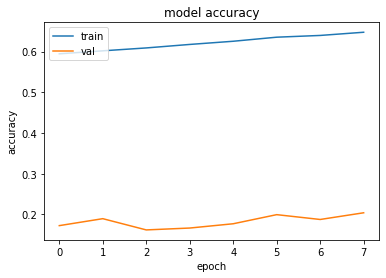

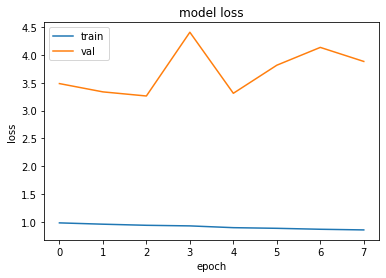

In [ ]:
history1_js = new_model_js1.fit(X1_js_sm, y1_js_df_sm, validation_data = (X_val_js_sm,y_val_js_sm),
               epochs=50,batch_size=64, callbacks =[cp_js1,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history1_js.history['categorical_accuracy'])
plt.plot(history1_js.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1_js.history['loss'])
plt.plot(history1_js.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### 2.objective : False Negative (range 32 - 800 layers)

In [ ]:
def build_model_js2(hp):
  model_js2 = Sequential()
  model_js2.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=800, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=800, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=800, step=32)
  model_js2.add(Dense(units=hp_units1, activation= "elu", kernel_initializer="he_normal"))
  model_js2.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model_js2.add(BatchNormalization())
  model_js2.add(Dense(units=hp_units2, activation= "elu", kernel_initializer="he_normal"))
  model_js2.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model_js2.add(BatchNormalization())
  model_js2.add(Dense(units=hp_units3, activation= "elu", kernel_initializer="he_normal"))
  model_js2.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model_js2.add(BatchNormalization())
  model_js2.add(Dense(6, activation='softmax'))

  hp_optimizer_js=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_js == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_js', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_js == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_js', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model_js2.compile(
      optimizer= hp_optimizer_js,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.FalseNegatives(name='false_negatives'),
               'categorical_accuracy']
  )
  return model_js2

# HyperBand algorithm from keras tuner
tuner_js2 = kt.Hyperband(
    build_model_js2,
    objective= kt.Objective('val_false_negatives', direction="min"),
    max_epochs=50,
    directory='js_dir2',
    project_name='jasper2',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner_js2.search(X1_js_sm, y1_js_df_sm, epochs=50, validation_data = (X_val_js_sm,y_val_js_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 01m 23s]
val_false_negatives: 1375.0

Best val_false_negatives So Far: 1201.0
Total elapsed time: 01h 20m 41s


In [ ]:
best_mlp_hyperparameters_js2 = tuner_js2.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters_js2.values

Best Hyper-parameters


{'units1': 32,
 'units2': 768,
 'units3': 224,
 'dropout_1': 0.1,
 'dropout_2': 0.3,
 'dropout_3': 0.0,
 'Optimizer': 'Adam',
 'learning_rate_js': 0.001,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [ ]:
best_model_js2 = tuner_js2.get_best_models()[0]
best_model_js2.build(X1_js_sm.shape)
best_model_js2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (23526, 49)              196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (23526, 32)               1600      
                                                                 
 dropout (Dropout)           (23526, 32)               0         
                                                                 
 batch_normalization_1 (Batc  (23526, 32)              128       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (23526, 768)              25344     
                                                                 
 dropout_1 (Dropout)         (23526, 768)              0

In [ ]:
new_model_js2 = Sequential()
new_model_js2.add(tf.keras.Input(shape=(49,)))
new_model_js2.add(BatchNormalization())
new_model_js2.add(Dense(32, activation = "elu", kernel_initializer="he_normal"))
new_model_js2.add(Dropout(0.1))
new_model_js2.add(BatchNormalization())
new_model_js2.add(Dense(768, activation = "elu", kernel_initializer="he_normal"))
new_model_js2.add(Dropout(0.3))
new_model_js2.add(BatchNormalization())
new_model_js2.add(Dense(224, activation = "elu", kernel_initializer="he_normal"))
new_model_js2.add(BatchNormalization())
new_model_js2.add((Dense(6, activation='softmax')))
new_model_js2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 49)               196       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 32)                1600      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 768)               25344     
                                                                 
 dropout_2 (Dropout)         (None, 768)              

In [ ]:
cp_js2 = ModelCheckpoint('new_model_js2/', save_best_only=True)
opt_js2 = keras.optimizers.Adam(learning_rate=0.001)
new_model_js2.compile(optimizer = opt_js2, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_js2.fit(X1_js_sm, y1_js_df_sm, validation_data = (X_val_js_sm,y_val_js_sm),
               epochs=50,batch_size=64, callbacks =[cp_js2,early_stopping_monitor])

Epoch 1/50
368/368 [==============================] - 9s 21ms/step - loss: 1.4114 - categorical_accuracy: 0.4405 - val_loss: 22.3679 - val_categorical_accuracy: 0.2000
Epoch 2/50
368/368 [==============================] - 7s 19ms/step - loss: 1.1901 - categorical_accuracy: 0.5124 - val_loss: 3.9047 - val_categorical_accuracy: 0.1928
Epoch 3/50
368/368 [==============================] - 7s 19ms/step - loss: 1.1182 - categorical_accuracy: 0.5408 - val_loss: 2.5006 - val_categorical_accuracy: 0.1184
Epoch 4/50
368/368 [==============================] - 7s 20ms/step - loss: 1.0668 - categorical_accuracy: 0.5579 - val_loss: 2.4928 - val_categorical_accuracy: 0.1467
Epoch 5/50
368/368 [==============================] - 4s 11ms/step - loss: 1.0327 - categorical_accuracy: 0.5707 - val_loss: 2.7438 - val_categorical_accuracy: 0.1500
Epoch 6/50
368/368 [==============================] - 4s 11ms/step - loss: 1.0108 - categorical_accuracy: 0.5817 - val_loss: 2.5736 - val_categorical_accuracy: 0.19

In [ ]:
test_predictions_js2 = new_model_js2.predict(X_test_js)
test_predictions_js2

23/23 [==============================] - 0s 4ms/step


array([[1.3595816e-01, 2.4409956e-01, 3.4122538e-02, 5.3243631e-01,
        5.3297557e-02, 8.5895823e-05],
       [4.0695846e-01, 2.8430805e-01, 5.8636595e-02, 2.0213683e-01,
        3.5542633e-02, 1.2417528e-02],
       [3.9671931e-01, 1.8938556e-01, 1.6940281e-01, 2.4401401e-01,
        3.5680126e-04, 1.2147229e-04],
       ...,
       [3.9620772e-01, 3.2176620e-01, 1.2905951e-01, 1.4540192e-01,
        7.5642234e-03, 3.7834243e-07],
       [3.3477354e-01, 2.2556360e-01, 1.9611463e-01, 2.4344663e-01,
        1.0147660e-04, 1.2404612e-07],
       [3.8136575e-01, 3.0796903e-01, 1.5849803e-01, 1.5054937e-01,
        1.5908077e-03, 2.6995182e-05]], dtype=float32)

In [ ]:
classes_js2 = np.argmax(test_predictions_js2, axis=-1)
classes_js2

array([3, 0, 0, 3, 0, 0, 1, 0, 2, 3, 0, 3, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       3, 1, 1, 1, 0, 3, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 3, 0, 3, 1,
       0, 0, 0, 3, 4, 3, 0, 0, 3, 1, 1, 1, 0, 1, 3, 1, 3, 1, 1, 1, 3, 0,
       2, 0, 0, 0, 3, 4, 3, 1, 1, 0, 0, 1, 3, 2, 1, 3, 1, 0, 0, 1, 1, 2,
       0, 4, 2, 0, 1, 3, 0, 1, 0, 3, 0, 4, 0, 3, 3, 3, 1, 1, 1, 2, 3, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 3, 0, 3, 0, 0, 1, 3, 0, 2, 0, 0, 0,
       0, 1, 0, 0, 1, 4, 0, 0, 4, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2,
       0, 1, 0, 0, 3, 1, 0, 0, 0, 0, 1, 0, 1, 1, 3, 0, 1, 3, 3, 3, 3, 3,
       1, 1, 3, 0, 1, 3, 1, 3, 1, 1, 0, 3, 2, 0, 0,

In [ ]:
classes_js2 =pd.DataFrame(classes_js2, columns=['Test Predictions']) 
classes_js2

Test Predictions
0                   3
1                   0
2                   0
3                   3
4                   0
..                ...
726                 2
727                 0
728                 0
729                 0
730                 0

[731 rows x 1 columns]

In [ ]:
classes_js2 = classes_js2.values.ravel()

In [ ]:
result_js2 = pd.DataFrame({'Test Predictions':classes_js2, 'Actuals':y_test_js})
result_js2[0:31]

Test Predictions  Actuals
0                  3        1
1                  0        1
2                  0        1
3                  3        1
4                  0        1
5                  0        1
6                  1        1
7                  0        1
8                  2        1
9                  3        1
10                 0        0
11                 3        0
12                 3        0
13                 0        0
14                 0        0
15                 0        0
16                 0        0
17                 0        0
18                 0        0
19                 1        0
20                 0        0
21                 0        0
22                 3        0
23                 1        0
24                 1        0
25                 1        0
26                 0        0
27                 3        0
28                 1        0
29                 1        0
30                 1        0

######model 2 evaluation

In [ ]:
print(classification_report(y_test_js, classes_js2, labels=np.unique(y_test_js)))

              precision    recall  f1-score   support

           0       0.81      0.57      0.67       568
           1       0.10      0.12      0.11       110
           2       0.03      0.06      0.04        34
           3       0.03      0.21      0.06        19

   micro avg       0.48      0.47      0.47       731
   macro avg       0.24      0.24      0.22       731
weighted avg       0.65      0.47      0.54       731



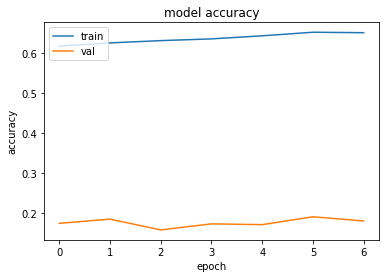

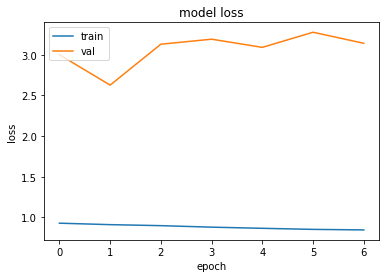

In [ ]:
history2_js = new_model_js2.fit(X1_js_sm, y1_js_df_sm, validation_data = (X_val_js_sm,y_val_js_sm),
               epochs=50,batch_size=64, callbacks =[cp_js2,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history2_js.history['categorical_accuracy'])
plt.plot(history2_js.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2_js.history['loss'])
plt.plot(history2_js.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### 3.objective : Accuracy

In [ ]:
def build_model_js3(hp):
  model_js3 = Sequential()
  model_js3.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model_js3.add(Dense(units=hp_units1, activation= "elu", kernel_initializer="he_normal"))
  model_js3.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model_js3.add(BatchNormalization())
  model_js3.add(Dense(units=hp_units2, activation= "elu", kernel_initializer="he_normal"))
  model_js3.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model_js3.add(BatchNormalization())
  model_js3.add(Dense(units=hp_units3, activation= "elu", kernel_initializer="he_normal"))
  model_js3.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model_js3.add(BatchNormalization())
  model_js3.add(Dense(6, activation='softmax'))

  hp_optimizer_js=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_js == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_js', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_js == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_js', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model_js3.compile(
      optimizer= hp_optimizer_js,
      loss='categorical_crossentropy',
      metrics=['categorical_accuracy']
  )
  return model_js3

# HyperBand algorithm from keras tuner
tuner_js3 = kt.Hyperband(
    build_model_js3,
    objective= kt.Objective("val_categorical_accuracy", direction="max"),
    max_epochs=50,
    directory='js_dir3',
    project_name='jasper3',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner_js3.search(X1_js_sm, y1_js_df_sm, epochs=50, validation_data = (X_val_js_sm,y_val_js_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 00m 25s]
val_categorical_accuracy: 0.1473684161901474

Best val_categorical_accuracy So Far: 0.2750000059604645
Total elapsed time: 00h 39m 14s


In [ ]:
best_mlp_hyperparameters_js3 = tuner_js3.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters_js3.values

Best Hyper-parameters


{'units1': 64,
 'units2': 480,
 'units3': 64,
 'dropout_1': 0.1,
 'dropout_2': 0.3,
 'dropout_3': 0.0,
 'Optimizer': 'Adam',
 'learning_rate_js': 0.001,
 'tuner/epochs': 6,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

In [ ]:
best_model_js3 = tuner_js3.get_best_models()[0]
best_model_js3.build(X1_js_sm.shape)
best_model_js3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (23526, 49)              196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (23526, 64)               3200      
                                                                 
 dropout (Dropout)           (23526, 64)               0         
                                                                 
 batch_normalization_1 (Batc  (23526, 64)              256       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (23526, 480)              31200     
                                                                 
 dropout_1 (Dropout)         (23526, 480)              0

In [ ]:
new_model_js3 = Sequential()
new_model_js3.add(tf.keras.Input(shape=(49,)))
new_model_js3.add(BatchNormalization())
new_model_js3.add(Dense(64, activation = "elu", kernel_initializer="he_normal"))
new_model_js3.add(Dropout(0.1))
new_model_js3.add(BatchNormalization())
new_model_js3.add(Dense(480, activation = "elu", kernel_initializer="he_normal"))
new_model_js3.add(Dropout(0.3))
new_model_js3.add(BatchNormalization())
new_model_js3.add(Dense(64, activation = "elu", kernel_initializer="he_normal"))
new_model_js3.add(BatchNormalization())
new_model_js3.add((Dense(6, activation='softmax')))
new_model_js3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_8 (Batc  (None, 49)               196       
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 64)                3200      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_9 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 480)               31200     
                                                                 
 dropout_4 (Dropout)         (None, 480)              

In [ ]:
cp_js3 = ModelCheckpoint('new_model_js3/', save_best_only=True)
opt_js3 = keras.optimizers.Adam(learning_rate=0.001)
new_model_js3.compile(optimizer = opt_js3, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_js3.fit(X1_js_sm, y1_js_df_sm, validation_data = (X_val_js_sm,y_val_js_sm),
               epochs=50,batch_size=64, callbacks =[cp_js3,early_stopping_monitor])

Epoch 1/50
368/368 [==============================] - 16s 29ms/step - loss: 1.3952 - categorical_accuracy: 0.4405 - val_loss: 26.5566 - val_categorical_accuracy: 0.2000
Epoch 2/50
368/368 [==============================] - 9s 26ms/step - loss: 1.1926 - categorical_accuracy: 0.5112 - val_loss: 3.4803 - val_categorical_accuracy: 0.2013
Epoch 3/50
368/368 [==============================] - 8s 21ms/step - loss: 1.1192 - categorical_accuracy: 0.5363 - val_loss: 2.3436 - val_categorical_accuracy: 0.1487
Epoch 4/50
368/368 [==============================] - 3s 8ms/step - loss: 1.0744 - categorical_accuracy: 0.5567 - val_loss: 2.4852 - val_categorical_accuracy: 0.1467
Epoch 5/50
368/368 [==============================] - 3s 8ms/step - loss: 1.0451 - categorical_accuracy: 0.5660 - val_loss: 2.6249 - val_categorical_accuracy: 0.1717
Epoch 6/50
368/368 [==============================] - 3s 8ms/step - loss: 1.0109 - categorical_accuracy: 0.5849 - val_loss: 2.5488 - val_categorical_accuracy: 0.1493

In [ ]:
test_predictions_js3 = new_model_js3.predict(X_test_js)
test_predictions_js3

23/23 [==============================] - 0s 2ms/step


array([[2.11003497e-01, 3.81675243e-01, 5.33090308e-02, 3.02698314e-01,
        5.11761792e-02, 1.37708732e-04],
       [3.40664297e-01, 3.27749252e-01, 4.09987159e-02, 2.04712644e-01,
        7.98150599e-02, 6.06001448e-03],
       [2.57475019e-01, 2.96041906e-01, 2.03867272e-01, 2.39037618e-01,
        3.55861126e-03, 1.95230168e-05],
       ...,
       [2.84579933e-01, 4.62994337e-01, 1.00747414e-01, 1.37884274e-01,
        1.36131542e-02, 1.80870004e-04],
       [2.31948167e-01, 3.70959073e-01, 2.29114592e-01, 1.67715564e-01,
        2.60690460e-04, 1.85142858e-06],
       [2.68458426e-01, 3.20989281e-01, 1.33181825e-01, 2.65777022e-01,
        1.10983886e-02, 4.95065935e-04]], dtype=float32)

In [ ]:
classes_js3 = np.argmax(test_predictions_js3, axis=-1)
classes_js3

array([1, 0, 1, 3, 3, 1, 1, 2, 2, 3, 0, 3, 3, 0, 3, 0, 0, 0, 0, 4, 0, 3,
       3, 1, 1, 1, 1, 3, 4, 1, 0, 1, 0, 3, 0, 0, 0, 1, 0, 0, 3, 0, 2, 1,
       3, 0, 0, 0, 4, 3, 0, 3, 3, 1, 1, 0, 0, 4, 4, 1, 3, 0, 1, 1, 3, 0,
       2, 0, 3, 3, 3, 4, 3, 1, 1, 0, 3, 1, 3, 2, 1, 3, 1, 0, 0, 0, 1, 2,
       1, 4, 3, 0, 1, 3, 0, 1, 1, 3, 1, 4, 3, 3, 3, 3, 4, 1, 1, 2, 3, 4,
       1, 1, 0, 0, 2, 2, 1, 1, 0, 0, 0, 0, 1, 0, 3, 1, 1, 0, 2, 0, 0, 0,
       0, 1, 0, 0, 1, 4, 0, 1, 4, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       5, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 2, 0, 1, 3, 0, 1, 3, 3,
       1, 1, 3, 1, 1, 3, 1, 4, 1, 1, 0, 3, 2, 0, 0,

In [ ]:
classes_js3 =pd.DataFrame(classes_js3, columns=['Test Predictions']) 
classes_js3

Test Predictions
0                   1
1                   0
2                   1
3                   3
4                   3
..                ...
726                 1
727                 3
728                 1
729                 1
730                 1

[731 rows x 1 columns]

In [ ]:
classes_js3 = classes_js3.values.ravel()

In [ ]:
result_js3 = pd.DataFrame({'Test Predictions':classes_js3, 'Actuals':y_test_js})
result_js3[0:31]

Test Predictions  Actuals
0                  1        1
1                  0        1
2                  1        1
3                  3        1
4                  3        1
5                  1        1
6                  1        1
7                  2        1
8                  2        1
9                  3        1
10                 0        0
11                 3        0
12                 3        0
13                 0        0
14                 3        0
15                 0        0
16                 0        0
17                 0        0
18                 0        0
19                 4        0
20                 0        0
21                 3        0
22                 3        0
23                 1        0
24                 1        0
25                 1        0
26                 1        0
27                 3        0
28                 4        0
29                 1        0
30                 0        0

######model 3 evaluation

In [ ]:
print(classification_report(y_test_js, classes_js3, labels=np.unique(y_test_js)))

              precision    recall  f1-score   support

           0       0.81      0.51      0.63       568
           1       0.10      0.13      0.11       110
           2       0.04      0.09      0.06        34
           3       0.03      0.21      0.06        19

   micro avg       0.44      0.43      0.43       731
   macro avg       0.24      0.23      0.21       731
weighted avg       0.65      0.43      0.51       731



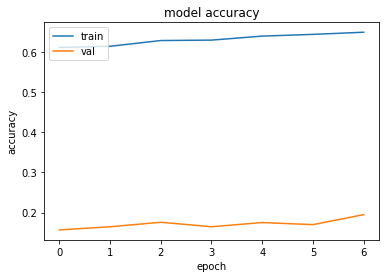

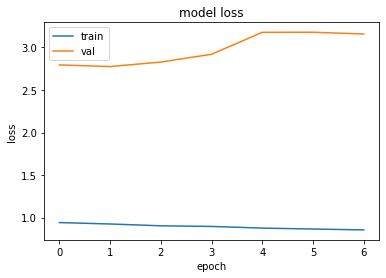

In [ ]:
history3_js = new_model_js3.fit(X1_js_sm, y1_js_df_sm, validation_data = (X_val_js_sm,y_val_js_sm),
               epochs=50,batch_size=64, callbacks =[cp_js3,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history3_js.history['categorical_accuracy'])
plt.plot(history3_js.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history3_js.history['loss'])
plt.plot(history3_js.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### 4.objective : f1-score macro

In [ ]:
def build_model_js4(hp):
  model_js4 = Sequential()
  model_js4.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model_js4.add(Dense(units=hp_units1, activation= "elu", kernel_initializer="he_normal"))
  model_js4.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model_js4.add(BatchNormalization())
  model_js4.add(Dense(units=hp_units2, activation= "elu", kernel_initializer="he_normal"))
  model_js4.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model_js4.add(BatchNormalization())
  model_js4.add(Dense(units=hp_units3, activation= "elu", kernel_initializer="he_normal"))
  model_js4.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model_js4.add(BatchNormalization())
  model_js4.add(Dense(6, activation='softmax'))

  hp_optimizer_js=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_js == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_js', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_js == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_js', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model_js4.compile(
      optimizer= hp_optimizer_js,
      loss='categorical_crossentropy',
      metrics=[tfa.metrics.F1Score(num_classes=6, average='macro',name='f1'),'categorical_accuracy']
  )
  return model_js4

# HyperBand algorithm from keras tuner
tuner_js4 = kt.Hyperband(
    build_model_js4,
    objective= kt.Objective("val_f1", direction="max"),
    max_epochs=50,
    directory='js_dir4',
    project_name='jasper4',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner_js4.search(X1_js_sm, y1_js_df_sm, epochs=50, validation_data = (X_val_js_sm,y_val_js_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 01m 17s]
val_f1: 0.1385730803012848

Best val_f1 So Far: 0.16637466847896576
Total elapsed time: 00h 51m 31s


In [ ]:
best_mlp_hyperparameters_js4 = tuner_js4.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters_js4.values

Best Hyper-parameters


{'units1': 288,
 'units2': 384,
 'units3': 384,
 'dropout_1': 0.0,
 'dropout_2': 0.1,
 'dropout_3': 0.1,
 'Optimizer': 'Adam',
 'learning_rate_js': 0.001,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0080'}

In [ ]:
best_model_js4 = tuner_js4.get_best_models()[0]
best_model_js4.build(X1_js_sm.shape)
best_model_js4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (23526, 49)              196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (23526, 288)              14400     
                                                                 
 dropout (Dropout)           (23526, 288)              0         
                                                                 
 batch_normalization_1 (Batc  (23526, 288)             1152      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (23526, 384)              110976    
                                                                 
 dropout_1 (Dropout)         (23526, 384)              0

In [ ]:
new_model_js4 = Sequential()
new_model_js4.add(tf.keras.Input(shape=(49,)))
new_model_js4.add(BatchNormalization())
new_model_js4.add(Dense(288, activation = "elu", kernel_initializer="he_normal"))
new_model_js4.add(BatchNormalization())
new_model_js4.add(Dense(384, activation = "elu", kernel_initializer="he_normal"))
new_model_js4.add(Dropout(0.1))
new_model_js4.add(BatchNormalization())
new_model_js4.add(Dense(384, activation = "elu", kernel_initializer="he_normal"))
new_model_js4.add(Dropout(0.1))
new_model_js4.add(BatchNormalization())
new_model_js4.add((Dense(6, activation='softmax')))
new_model_js4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_12 (Bat  (None, 49)               196       
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 288)               14400     
                                                                 
 batch_normalization_13 (Bat  (None, 288)              1152      
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            (None, 384)               110976    
                                                                 
 dropout_5 (Dropout)         (None, 384)               0         
                                                                 
 batch_normalization_14 (Bat  (None, 384)             

In [ ]:
cp_js4 = ModelCheckpoint('new_model_js4/', save_best_only=True)
opt_js4 = keras.optimizers.Adam(learning_rate=0.001)
new_model_js4.compile(optimizer = opt_js4, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_js4.fit(X1_js_sm, y1_js_df_sm, validation_data = (X_val_js_sm,y_val_js_sm),
               epochs=50,batch_size=64, callbacks =[cp_js4,early_stopping_monitor])

Epoch 1/50
368/368 [==============================] - 10s 21ms/step - loss: 1.3438 - categorical_accuracy: 0.4746 - val_loss: 23.4532 - val_categorical_accuracy: 0.2000
Epoch 2/50
368/368 [==============================] - 16s 44ms/step - loss: 1.1191 - categorical_accuracy: 0.5437 - val_loss: 2.2428 - val_categorical_accuracy: 0.2039
Epoch 3/50
368/368 [==============================] - 8s 22ms/step - loss: 1.0316 - categorical_accuracy: 0.5740 - val_loss: 2.7000 - val_categorical_accuracy: 0.1342
Epoch 4/50
368/368 [==============================] - 8s 21ms/step - loss: 0.9665 - categorical_accuracy: 0.6012 - val_loss: 3.0439 - val_categorical_accuracy: 0.1809
Epoch 5/50
368/368 [==============================] - 6s 17ms/step - loss: 0.9350 - categorical_accuracy: 0.6140 - val_loss: 3.3387 - val_categorical_accuracy: 0.1414
Epoch 6/50
368/368 [==============================] - 5s 13ms/step - loss: 0.8909 - categorical_accuracy: 0.6322 - val_loss: 3.3349 - val_categorical_accuracy: 0.

In [ ]:
test_predictions_js4 = new_model_js4.predict(X_test_js)
test_predictions_js4

23/23 [==============================] - 1s 9ms/step


array([[1.7695704e-01, 5.9614360e-01, 4.2704940e-02, 1.8095934e-01,
        3.2341518e-03, 9.1208432e-07],
       [5.3367162e-01, 3.9386418e-01, 4.4186376e-02, 2.7037438e-02,
        1.2174072e-03, 2.2975288e-05],
       [4.5203745e-01, 4.2927882e-01, 7.2818801e-02, 4.5816440e-02,
        4.6690286e-05, 1.7842980e-06],
       ...,
       [3.0640060e-01, 2.9525933e-01, 2.3977311e-01, 1.5513635e-01,
        3.3800970e-03, 5.0458508e-05],
       [2.4087483e-01, 2.9092738e-01, 4.4656983e-01, 2.1615762e-02,
        1.2152606e-05, 7.8613582e-10],
       [3.6344251e-01, 2.7255854e-01, 2.3704028e-01, 1.2589920e-01,
        1.0448388e-03, 1.4524596e-05]], dtype=float32)

In [ ]:
classes_js4 = np.argmax(test_predictions_js4, axis=-1)
classes_js4

array([1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 3,
       1, 1, 1, 2, 1, 3, 1, 1, 1, 0, 0, 2, 0, 1, 0, 1, 1, 0, 3, 0, 2, 2,
       3, 0, 0, 0, 0, 3, 1, 0, 0, 2, 0, 0, 0, 1, 1, 1, 3, 1, 1, 1, 1, 0,
       2, 0, 0, 0, 2, 4, 3, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 1, 0,
       2, 2, 2, 0, 1, 3, 0, 1, 1, 3, 3, 0, 3, 2, 3, 2, 1, 1, 2, 2, 3, 0,
       1, 0, 3, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 3, 1, 3, 0, 0, 2, 2, 3,
       0, 1, 0, 0, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2,
       0, 3, 0, 0, 3, 2, 0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 2, 3, 0, 2, 2, 3,
       1, 1, 1, 0, 2, 3, 3, 4, 1, 1, 0, 0, 2, 0, 0,

In [ ]:
classes_js4 =pd.DataFrame(classes_js4, columns=['Test Predictions']) 
classes_js4

Test Predictions
0                   1
1                   0
2                   0
3                   0
4                   0
..                ...
726                 2
727                 0
728                 0
729                 2
730                 0

[731 rows x 1 columns]

In [ ]:
classes_js4 = classes_js4.values.ravel()

In [ ]:
result_js4 = pd.DataFrame({'Test Predictions':classes_js4, 'Actuals':y_test_js})
result_js4[0:31]

Test Predictions  Actuals
0                  1        1
1                  0        1
2                  0        1
3                  0        1
4                  0        1
5                  0        1
6                  2        1
7                  2        1
8                  2        1
9                  2        1
10                 0        0
11                 0        0
12                 3        0
13                 0        0
14                 0        0
15                 0        0
16                 0        0
17                 0        0
18                 0        0
19                 1        0
20                 0        0
21                 3        0
22                 1        0
23                 1        0
24                 1        0
25                 2        0
26                 1        0
27                 3        0
28                 1        0
29                 1        0
30                 1        0

######model 4 evaluation

In [ ]:
print(classification_report(y_test_js, classes_js4, labels=np.unique(y_test_js)))

              precision    recall  f1-score   support

           0       0.79      0.62      0.70       568
           1       0.05      0.05      0.05       110
           2       0.09      0.26      0.13        34
           3       0.09      0.32      0.14        19

   micro avg       0.52      0.51      0.52       731
   macro avg       0.26      0.31      0.26       731
weighted avg       0.63      0.51      0.56       731



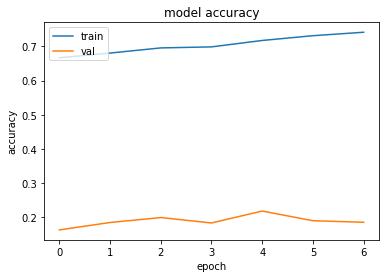

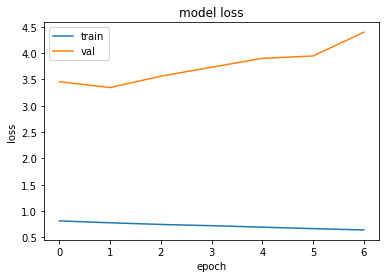

In [ ]:
history4_js = new_model_js4.fit(X1_js_sm, y1_js_df_sm, validation_data = (X_val_js_sm,y_val_js_sm),
               epochs=50,batch_size=64, callbacks =[cp_js4,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history4_js.history['categorical_accuracy'])
plt.plot(history4_js.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history4_js.history['loss'])
plt.plot(history4_js.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

####comparing the models

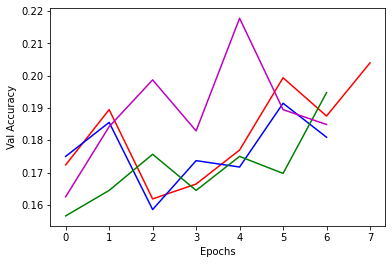

In [ ]:
plt.plot(history1_js.history['val_categorical_accuracy'], 'r', history2_js.history['val_categorical_accuracy'], 'b', 
         history3_js.history['val_categorical_accuracy'], 'g', history4_js.history['val_categorical_accuracy'], 'm')
plt.xlabel('Epochs')
plt.ylabel('Val Accuracy')
plt.show()

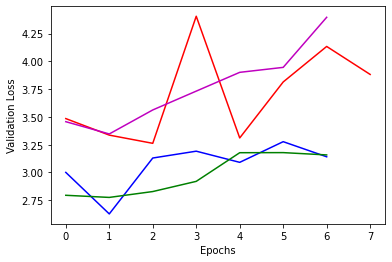

In [ ]:
plt.plot(history1_js.history['val_loss'], 'r', history2_js.history['val_loss'], 'b',
         history3_js.history['val_loss'], 'g', history4_js.history['val_loss'], 'm')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.show()

###MLP model with weather and soil data (without date variable) REGRESSION

####preprocessing data

In [ ]:
score_js = train_js['score']
score_val_js = val_js['score']
score_test_js = test_js['score']

In [ ]:
score_arr_js = score_js.copy()
score_val_arr_js = score_val_js.copy()
score_test_arr_js = score_test_js.copy()

In [ ]:
score_arr_js = score_arr_js.to_numpy()
score_val_arr_js = score_val_arr_js.to_numpy()
score_test_arr_js = score_test_arr_js.to_numpy()

In [ ]:
score_arr_js =pd.DataFrame(score_arr_js, columns=['Score']) 
score_arr_js

Score
0     0.0000
1     0.0000
2     0.0000
3     0.0000
4     0.0000
...      ...
6205  1.2278
6206  1.2278
6207  1.2278
6208  1.2278
6209  1.2278

[6210 rows x 1 columns]

In [ ]:
score_val_arr_js =pd.DataFrame(score_val_arr_js, columns=['Score']) 
score_val_arr_js

Score
0    1.773400
1    1.773400
2    1.773400
3    1.805771
4    1.838143
..        ...
725  1.712900
726  1.712900
727  1.712900
728  1.712900
729  1.712900

[730 rows x 1 columns]

In [ ]:
score_test_arr_js =pd.DataFrame(score_test_arr_js, columns=['Score']) 
score_test_arr_js

Score
0    0.712900
1    0.726057
2    0.739214
3    0.752371
4    0.765529
..        ...
726  0.000000
727  0.000000
728  0.000000
729  0.000000
730  0.000000

[731 rows x 1 columns]

In [ ]:
jasper_train = train_js.copy()
jasper_val = val_js.copy()
jasper_test = test_js.copy()

In [ ]:
X1_js = jasper_train.drop(columns=['fips','date','score'])
X_js_val = jasper_val.drop(columns=['fips','date','score'])
X_js_test = jasper_test.drop(columns=['fips','date','score'])

In [ ]:
X1_js, y1_js = X1_js, score_arr_js
X_val_js, y_val_js = X_js_val, score_val_arr_js
X_test_js, y_test_js = X_js_test, score_test_arr_js
X1_js.shape, y1_js.shape, X_val_js.shape, y_val_js.shape, X_test_js.shape, y_test_js.shape

((6210, 49), (6210, 1), (730, 49), (730, 1), (731, 49), (731, 1))

####build the model

In [ ]:
new_model_reg_js1 = Sequential()
new_model_reg_js1.add(tf.keras.Input(shape=(49,)))
new_model_reg_js1.add(BatchNormalization())
new_model_reg_js1.add(Dense(128, activation = "elu", kernel_initializer="he_normal"))
new_model_reg_js1.add(BatchNormalization())
new_model_reg_js1.add(Dense(64, activation = "elu", kernel_initializer="he_normal"))
new_model_reg_js1.add(BatchNormalization())
new_model_reg_js1.add((Dense(1, activation='linear')))
new_model_reg_js1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 49)               196       
 ormalization)                                                   
                                                                 
 dense_12 (Dense)            (None, 128)               6400      
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                      

In [ ]:
opt_reg_js1 = keras.optimizers.Adam(learning_rate=0.001)
new_model_reg_js1.compile(optimizer = opt_reg_js1, loss =MeanSquaredError(), metrics =[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_reg_js1.fit(X1_js, y1_js, validation_data = (X_val_js, y_val_js),
               epochs=50,batch_size=64, callbacks =[early_stopping_monitor])

Epoch 1/50
98/98 [==============================] - 1s 4ms/step - loss: 1.1326 - root_mean_squared_error: 1.0642 - val_loss: 97.6703 - val_root_mean_squared_error: 9.8828
Epoch 2/50
98/98 [==============================] - 0s 3ms/step - loss: 0.8968 - root_mean_squared_error: 0.9470 - val_loss: 390.9573 - val_root_mean_squared_error: 19.7726
Epoch 3/50
98/98 [==============================] - 0s 3ms/step - loss: 0.8752 - root_mean_squared_error: 0.9355 - val_loss: 143.0140 - val_root_mean_squared_error: 11.9588
Epoch 4/50
98/98 [==============================] - 0s 3ms/step - loss: 0.8618 - root_mean_squared_error: 0.9284 - val_loss: 91.9957 - val_root_mean_squared_error: 9.5914
Epoch 5/50
98/98 [==============================] - 0s 3ms/step - loss: 0.8633 - root_mean_squared_error: 0.9291 - val_loss: 36.7213 - val_root_mean_squared_error: 6.0598
Epoch 6/50
98/98 [==============================] - 0s 3ms/step - loss: 0.8464 - root_mean_squared_error: 0.9200 - val_loss: 17.5390 - val_ro

In [ ]:
test_predictions_reg_js1 = new_model_reg_js1.predict(X_test_js).flatten()
test_predictions_reg_js1

23/23 [==============================] - 0s 1ms/step


array([ 3.93927157e-01,  3.43630612e-01,  4.90208030e-01,  8.15523446e-01,
        3.03957403e-01,  3.73681128e-01,  5.87763906e-01,  4.98990238e-01,
        4.59100842e-01,  4.35006499e-01,  4.94950175e-01,  3.17700803e-01,
        7.52821192e-02,  6.72225282e-02,  6.44085035e-02,  9.97331366e-02,
        2.59644687e-01,  2.50253499e-01,  3.29506218e-01,  5.37425041e-01,
        2.86716700e-01,  4.82087255e-01,  4.60029095e-01,  2.34013081e-01,
        3.22081834e-01,  1.44519657e-01,  3.67029399e-01,  2.99430966e-01,
        6.28161430e-01,  4.93531615e-01,  2.25241005e-01,  1.89374864e-01,
        1.55636638e-01,  4.93577361e-01,  3.69651675e-01,  6.22112989e-01,
        5.35618663e-01,  3.86819959e-01,  3.36599320e-01, -7.03627244e-02,
        2.76536196e-01,  6.16798624e-02,  5.87598205e-01,  4.15374070e-01,
        9.10198808e-01,  1.84753358e-01,  1.83500648e-01,  3.14275414e-01,
        3.19518983e-01,  3.63158286e-01,  5.19482493e-01,  5.12521207e-01,
        1.61233008e-01,  

In [ ]:
test_predictions_reg_js1 =pd.DataFrame(test_predictions_reg_js1, columns=['Test Predictions']) 
test_predictions_reg_js1

Test Predictions
0            0.393927
1            0.343631
2            0.490208
3            0.815523
4            0.303957
..                ...
726          0.428142
727          0.144614
728          0.337509
729          0.448252
730          0.291703

[731 rows x 1 columns]

In [ ]:
test_predictions_reg_js1 = test_predictions_reg_js1.values.ravel()
y_test_js = y_test_js.values.ravel()

In [ ]:
test_results_reg_js_1 = pd.DataFrame(data={'predictions':test_predictions_reg_js1, 'actuals':y_test_js})
test_results_reg_js_1

predictions   actuals
0       0.393927  0.712900
1       0.343631  0.726057
2       0.490208  0.739214
3       0.815523  0.752371
4       0.303957  0.765529
..           ...       ...
726     0.428142  0.000000
727     0.144614  0.000000
728     0.337509  0.000000
729     0.448252  0.000000
730     0.291703  0.000000

[731 rows x 2 columns]

In [ ]:
test_results_reg_js_1[500:550]

predictions   actuals
500     0.450424  0.000000
501     0.311516  0.000000
502     0.254669  0.000000
503     0.241510  0.000000
504     0.279168  0.000000
505     0.217767  0.000000
506     0.399517  0.000000
507     0.124648  0.000000
508     0.103533  0.000000
509     0.096215  0.000000
510     0.293256  0.000000
511     0.373176  0.000000
512     0.568857  0.000000
513     0.427343  0.000000
514     0.199863  0.000000
515     0.292452  0.000000
516     0.203305  0.000000
517     0.219594  0.000000
518     0.196217  0.000000
519     0.209366  0.000000
520     0.014939  0.000000
521     0.064500  0.000000
522     0.155167  0.000000
523    -0.085046  0.000000
524     0.058466  0.000000
525     0.828516  0.000000
526     0.818343  0.000000
527     0.268330  0.000000
528     0.186652  0.000000
529     0.386000  0.000000
530     0.119819  0.000000
531     0.141043  0.000000
532     0.289596  0.000000
533     0.345701  0.142857
534     0.248911  0.285714
535     0.324934  0.428571
536     0.146922  0.571429
537     0.098064  0.714286
538     0.127594  0.857143
539     0.598510  1.000000
540     0.711980  1.033357
541     0.246698  1.066714
542     0.172377  1.100071
543     0.145829  1.133429
544     0.215369  1.166786
545     0.197755  1.200143
546     0.051765  1.233500
547    -0.082762  1.213914
548     0.080670  1.194329
549     0.098994  1.174743

####model evaluation

In [ ]:
new_model_reg_js1.evaluate(X1_js,y1_js)

195/195 [==============================] - 0s 1ms/step - loss: 0.8035 - root_mean_squared_error: 0.8964


[0.8034766316413879, 0.8963685631752014]

In [ ]:
new_model_reg_js1.evaluate(X_test_js,y_test_js)

23/23 [==============================] - 0s 1ms/step - loss: 0.3350 - root_mean_squared_error: 0.5788


[0.33495551347732544, 0.5787534117698669]

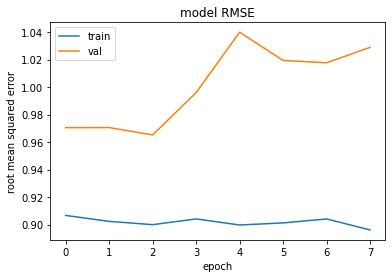

In [ ]:
history_reg_js_1 = new_model_reg_js1.fit(X1_js, y1_js, validation_data = (X_val_js,y_val_js),
               epochs=50,batch_size=64, callbacks =[early_stopping_monitor], verbose=False)

# summarize history for accuracy
plt.plot(history_reg_js_1.history['root_mean_squared_error'])
plt.plot(history_reg_js_1.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_results_reg_js_1.predictions[test_results_reg_js_1.predictions <0.5] = 0
test_results_reg_js_1.predictions[(test_results_reg_js_1.predictions >=0.5)&(test_results_reg_js_1.predictions<1.5)] = 1
test_results_reg_js_1.predictions[(test_results_reg_js_1.predictions >=1.5)&(test_results_reg_js_1.predictions<2.5)] = 2
test_results_reg_js_1.predictions[(test_results_reg_js_1.predictions >=2.5)&(test_results_reg_js_1.predictions<3.5)] = 3
test_results_reg_js_1.predictions[(test_results_reg_js_1.predictions >=3.5)&(test_results_reg_js_1.predictions<4.5)] = 4
test_results_reg_js_1.predictions[(test_results_reg_js_1.predictions >=4.5)&(test_results_reg_js_1.predictions<5.5)] = 5
test_results_reg_js_1.actuals[test_results_reg_js_1.actuals <0.5] = 0
test_results_reg_js_1.actuals[(test_results_reg_js_1.actuals >=0.5)&(test_results_reg_js_1.actuals<1.5)] = 1
test_results_reg_js_1.actuals[(test_results_reg_js_1.actuals >=1.5)&(test_results_reg_js_1.actuals<2.5)] = 2
test_results_reg_js_1.actuals[(test_results_reg_js_1.actuals >=2.5)&(test_results_reg_js_1.actuals<3.5)] = 3
test_results_reg_js_1.actuals[(test_results_reg_js_1.actuals >=3.5)&(test_results_reg_js_1.actuals<4.5)] = 4
test_results_reg_js_1.actuals[(test_results_reg_js_1.actuals >=4.5)&(test_results_reg_js_1.actuals<5.5)] = 5
test_results_reg_js_1

predictions  actuals
0            0.0      1.0
1            0.0      1.0
2            0.0      1.0
3            1.0      1.0
4            0.0      1.0
..           ...      ...
726          0.0      0.0
727          0.0      0.0
728          0.0      0.0
729          0.0      0.0
730          0.0      0.0

[731 rows x 2 columns]

In [ ]:
test_results_reg_js_1[200:250]

predictions  actuals
200          0.0      0.0
201          0.0      0.0
202          1.0      0.0
203          0.0      0.0
204          0.0      0.0
205          0.0      0.0
206          0.0      0.0
207          0.0      0.0
208          0.0      0.0
209          0.0      0.0
210          0.0      0.0
211          0.0      0.0
212          0.0      0.0
213          0.0      0.0
214          0.0      0.0
215          0.0      0.0
216          0.0      0.0
217          0.0      0.0
218          0.0      0.0
219          0.0      0.0
220          0.0      0.0
221          0.0      0.0
222          0.0      0.0
223          0.0      0.0
224          0.0      0.0
225          0.0      0.0
226          1.0      0.0
227          0.0      0.0
228          0.0      0.0
229          0.0      0.0
230          0.0      0.0
231          0.0      0.0
232          0.0      0.0
233          0.0      0.0
234          0.0      0.0
235          0.0      0.0
236          0.0      0.0
237          0.0      0.0
238          0.0      0.0
239          1.0      0.0
240          0.0      0.0
241          0.0      0.0
242          0.0      0.0
243          0.0      0.0
244          0.0      0.0
245          0.0      0.0
246          0.0      0.0
247          0.0      0.0
248          0.0      0.0
249          0.0      0.0

In [ ]:
print(classification_report(test_results_reg_js_1['actuals'], test_results_reg_js_1['predictions']))

              precision    recall  f1-score   support

         0.0       0.86      0.77      0.81       568
         1.0       0.24      0.47      0.32       110
         2.0       0.30      0.09      0.14        34
         3.0       0.00      0.00      0.00        19

    accuracy                           0.67       731
   macro avg       0.35      0.33      0.32       731
weighted avg       0.72      0.67      0.68       731



###LSTM model without weather and soil data, only using previous drought scores

In [ ]:
def df_to_X_y(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 7
X_train_js, y_train_js = df_to_X_y(score_js, WINDOW_SIZE)
X_val1_js, y_val1_js = df_to_X_y(score_val_js, WINDOW_SIZE)
X_test1_js, y_test1_js = df_to_X_y(score_test_js, WINDOW_SIZE)
X_train_js.shape, y_train_js.shape, X_val1_js.shape, y_val1_js.shape, X_test1_js.shape, y_test1_js.shape

((6203, 7, 1), (6203,), (723, 7, 1), (723,), (724, 7, 1), (724,))

In [ ]:
model_1 = Sequential()
model_1.add(InputLayer((7,1)))
model_1.add(LSTM(64))
model_1.add(Dense(8, 'relu'))
model_1.add(Dense(1, 'linear'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

model_1.fit(X_train_js, y_train_js, validation_data=(X_val1_js, y_val1_js), epochs=50, 
           callbacks = [early_stopping_monitor])

Epoch 1/50
194/194 [==============================] - 4s 8ms/step - loss: 0.4479 - root_mean_squared_error: 0.6692 - val_loss: 0.0954 - val_root_mean_squared_error: 0.3088
Epoch 2/50
194/194 [==============================] - 1s 6ms/step - loss: 0.0595 - root_mean_squared_error: 0.2439 - val_loss: 0.0834 - val_root_mean_squared_error: 0.2887
Epoch 3/50
194/194 [==============================] - 1s 5ms/step - loss: 0.0523 - root_mean_squared_error: 0.2287 - val_loss: 0.0803 - val_root_mean_squared_error: 0.2834
Epoch 4/50
194/194 [==============================] - 1s 5ms/step - loss: 0.0499 - root_mean_squared_error: 0.2234 - val_loss: 0.0775 - val_root_mean_squared_error: 0.2784
Epoch 5/50
194/194 [==============================] - 1s 5ms/step - loss: 0.0478 - root_mean_squared_error: 0.2186 - val_loss: 0.0748 - val_root_mean_squared_error: 0.2735
Epoch 6/50
194/194 [==============================] - 1s 5ms/step - loss: 0.0457 - root_mean_squared_error: 0.2139 - val_loss: 0.0716 - val_

####using the model to predict the test dataset

In [ ]:
test_prediction_js_1 = model_1.predict(X_test1_js).flatten()
test_results_js_1 = pd.DataFrame(data={'predictions':test_prediction_js_1, 'actuals':y_test1_js})
test_results_js_1

23/23 [==============================] - 0s 2ms/step


predictions  actuals
0       0.980281      1.0
1       0.980281      1.0
2       0.980281      1.0
3       0.980281      0.0
4       0.110138      0.0
..           ...      ...
719     0.004235      0.0
720     0.004235      0.0
721     0.004235      0.0
722     0.004235      0.0
723     0.004235      0.0

[724 rows x 2 columns]

In [ ]:
test_results_js_1.predictions[test_results_js_1.predictions <0.5] = 0
test_results_js_1.predictions[(test_results_js_1.predictions >=0.5)&(test_results_js_1.predictions<1.5)] = 1
test_results_js_1.predictions[(test_results_js_1.predictions >=1.5)&(test_results_js_1.predictions<2.5)] = 2
test_results_js_1.predictions[(test_results_js_1.predictions >=2.5)&(test_results_js_1.predictions<3.5)] = 3
test_results_js_1.predictions[(test_results_js_1.predictions >=3.5)&(test_results_js_1.predictions<4.5)] = 4
test_results_js_1.predictions[(test_results_js_1.predictions >=4.5)&(test_results_js_1.predictions<5.5)] = 5
test_results_js_1

predictions  actuals
0            1.0      1.0
1            1.0      1.0
2            1.0      1.0
3            1.0      0.0
4            0.0      0.0
..           ...      ...
719          0.0      0.0
720          0.0      0.0
721          0.0      0.0
722          0.0      0.0
723          0.0      0.0

[724 rows x 2 columns]

In [ ]:
test_results_js_1.actuals[test_results_js_1.actuals <0.5] = 0
test_results_js_1.actuals[(test_results_js_1.actuals >=0.5)&(test_results_js_1.actuals<1.5)] = 1
test_results_js_1.actuals[(test_results_js_1.actuals >=1.5)&(test_results_js_1.actuals<2.5)] = 2
test_results_js_1.actuals[(test_results_js_1.actuals >=2.5)&(test_results_js_1.actuals<3.5)] = 3
test_results_js_1.actuals[(test_results_js_1.actuals >=3.5)&(test_results_js_1.actuals<4.5)] = 4
test_results_js_1.actuals[(test_results_js_1.actuals >=4.5)&(test_results_js_1.actuals<5.5)] = 5
test_results_js_1

predictions  actuals
0            1.0      1.0
1            1.0      1.0
2            1.0      1.0
3            1.0      0.0
4            0.0      0.0
..           ...      ...
719          0.0      0.0
720          0.0      0.0
721          0.0      0.0
722          0.0      0.0
723          0.0      0.0

[724 rows x 2 columns]

####model evaluation

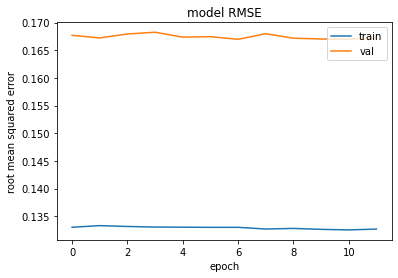

In [ ]:
history_js_1 = model_1.fit(X_train_js, y_train_js, validation_data=(X_val1_js, y_val1_js), epochs=50, 
           callbacks = [early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history_js_1.history['root_mean_squared_error'])
plt.plot(history_js_1.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
print(classification_report(test_results_js_1['actuals'], test_results_js_1['predictions']))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       568
         1.0       0.97      0.98      0.98       103
         2.0       0.94      0.94      0.94        34
         3.0       0.95      0.95      0.95        19

    accuracy                           0.99       724
   macro avg       0.96      0.97      0.97       724
weighted avg       0.99      0.99      0.99       724



hasil : RMSE train dan test tidak jauh berbeda

###LSTM model with only score data and time data but the time data is transformed using sine and cosine

####train

In [ ]:
train_js1 = train_js.copy()
train_js1.index = pd.to_datetime(train_js1['date'], format='%Y.%m.%d')
train_js1[:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  \
date                                                                         
2000-01-01  29097  2000-01-01     0.24  97.47  5.89   7.79    5.52    5.52   
2000-01-02  29097  2000-01-02     0.42  97.23  6.46   9.61    6.66    6.66   
2000-01-03  29097  2000-01-03    12.93  97.14  4.46   3.04    1.67    1.67   
2000-01-04  29097  2000-01-04     0.06  98.74  2.05  -3.87   -8.21   -8.07   
2000-01-05  29097  2000-01-05     0.03  98.39  2.64  -0.08   -5.03   -4.96   
2000-01-06  29097  2000-01-06     0.13  98.82  3.30   0.68   -2.20   -2.18   
2000-01-07  29097  2000-01-07     0.02  99.15  2.91   2.06   -3.86   -3.79   
2000-01-08  29097  2000-01-08     4.02  98.02  5.25   5.33    4.15    4.15   
2000-01-09  29097  2000-01-09     0.61  96.82  5.30   6.44    4.14    4.14   
2000-01-10  29097  2000-01-10     0.00  96.98  4.07   4.57    0.41    0.42   
2000-01-11  29097  2000-01-11     0.02  98.02  2.72   1.86   -4.76   -4.67   
2000-01-12  29097  2000-01-12     0.00  97.54  4.85   6.17    2.41    2.42   
2000-01-13  29097  2000-01-13     0.00  99.70  2.59  -0.86   -5.12   -5.05   
2000-01-14  29097  2000-01-14     0.00  99.82  2.68   0.86   -4.68   -4.60   
2000-01-15  29097  2000-01-15     0.00  98.60  5.13   7.26    3.08    3.10   
2000-01-16  29097  2000-01-16     0.01  98.81  6.60   9.17    7.26    7.26   
2000-01-17  29097  2000-01-17     0.04  98.36  7.62  10.91    9.28    9.28   
2000-01-18  29097  2000-01-18     0.00  98.42  4.47   4.80    1.94    1.95   
2000-01-19  29097  2000-01-19     0.07  97.68  4.42   4.34    1.13    1.15   
2000-01-20  29097  2000-01-20     0.00  98.77  1.72  -4.25  -10.07   -9.83   
2000-01-21  29097  2000-01-21     0.06  98.17  2.52   0.25   -5.74   -5.64   
2000-01-22  29097  2000-01-22     0.13  97.43  4.13   3.86    0.63    0.64   
2000-01-23  29097  2000-01-23     0.18  98.26  3.11  -0.55   -3.17   -3.13   
2000-01-24  29097  2000-01-24     0.01  98.57  2.08  -2.85   -7.91   -7.77   
2000-01-25  29097  2000-01-25     0.00  98.62  2.01  -3.10   -8.29   -8.13   
2000-01-26  29097  2000-01-26     0.48  98.77  1.89  -4.36   -8.96   -8.80   
2000-01-27  29097  2000-01-27     4.67  99.01  2.08  -3.94   -7.86   -7.75   
2000-01-28  29097  2000-01-28     1.38  99.09  2.31  -4.28   -6.51   -6.47   
2000-01-29  29097  2000-01-29     1.11  98.87  2.30  -4.69   -6.62   -6.59   
2000-01-30  29097  2000-01-30     0.16  98.92  2.06  -5.95   -7.94   -7.90   
2000-01-31  29097  2000-01-31     0.04  98.59  2.54  -4.20   -5.69   -5.67   

            T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                          
2000-01-01    15.11     1.73      13.38   7.07   5.90       7.69       4.22   
2000-01-02    12.44     2.34      10.10   8.21   5.48       9.26       1.41   
2000-01-03     7.67    -0.41       8.07   3.06   5.35       7.68       3.36   
2000-01-04    -0.71    -6.73       6.01  -3.59   5.67       8.69       1.57   
2000-01-05     6.38    -5.13      11.51  -0.48   6.50      10.02       2.20   
2000-01-06     8.20    -3.44      11.65   0.37   2.76       5.22       1.00   
2000-01-07     9.57    -2.42      11.98   0.40   2.42       4.75       0.69   
2000-01-08     8.33     2.58       5.75   5.00   5.10       7.18       3.96   
2000-01-09    11.97     3.17       8.80   6.29   5.23       7.34       3.98   
2000-01-10    12.69    -0.51      13.20   4.00   6.23       9.50       3.86   
2000-01-11     7.91    -3.37      11.28   1.48   3.48       5.71       2.08   
2000-01-12    16.73     0.48      16.25   5.48   6.31       9.90       3.84   
2000-01-13     4.59    -4.04       8.64  -0.94   4.39       6.37       2.95   
2000-01-14     8.76    -4.16      12.92   0.42   5.30       7.75       2.89   
2000-01-15    14.42    -0.27      14.69   6.71   8.31      11.52       5.38   
2000-01-16    12.66     6.60       6.05   9.13   3.73       4.93       1.69   
2000-01-17    17

In [ ]:
scorejs = train_js1['score']
scorejs_df = pd.DataFrame({'score':scorejs})
scorejs_df['Seconds'] = scorejs_df.index.map(pd.Timestamp.timestamp)
scorejs_df

score       Seconds
date                           
2000-01-01    0.0  9.466848e+08
2000-01-02    0.0  9.467712e+08
2000-01-03    0.0  9.468576e+08
2000-01-04    0.0  9.469440e+08
2000-01-05    0.0  9.470304e+08
...           ...           ...
2016-12-27    1.0  1.482797e+09
2016-12-28    1.0  1.482883e+09
2016-12-29    1.0  1.482970e+09
2016-12-30    1.0  1.483056e+09
2016-12-31    1.0  1.483142e+09

[6210 rows x 2 columns]

In [ ]:
day = 60*60*24
month = 30.437*day
year = 365.2425*day

scorejs_df['Day sin'] = np.sin(scorejs_df['Seconds'] * (2* np.pi / day))
scorejs_df['Day cos'] = np.cos(scorejs_df['Seconds'] * (2 * np.pi / day))
scorejs_df['Month sin'] = np.sin(scorejs_df['Seconds'] * (2* np.pi / month))
scorejs_df['Month cos'] = np.cos(scorejs_df['Seconds'] * (2 * np.pi / month))
scorejs_df['Year sin'] = np.sin(scorejs_df['Seconds'] * (2 * np.pi / year))
scorejs_df['Year cos'] = np.cos(scorejs_df['Seconds'] * (2 * np.pi / year))
scorejs_df.head()

score      Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                          
2000-01-01    0.0  946684800.0 -5.461913e-12      1.0  -0.066010   0.997819   
2000-01-02    0.0  946771200.0 -1.163374e-12      1.0   0.139914   0.990164   
2000-01-03    0.0  946857600.0  3.135164e-12      1.0   0.339896   0.940463   
2000-01-04    0.0  946944000.0 -7.118212e-12      1.0   0.525446   0.850827   
2000-01-05    0.0  947030400.0 -2.819674e-12      1.0   0.688683   0.725062   

            Year sin  Year cos  
date                            
2000-01-01 -0.004731  0.999989  
2000-01-02  0.012472  0.999922  
2000-01-03  0.029670  0.999560  
2000-01-04  0.046860  0.998901  
2000-01-05  0.064036  0.997948

In [ ]:
scorejs_df = scorejs_df.drop('Seconds', axis=1)
scorejs_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2000-01-01    0.0 -5.461913e-12      1.0  -0.066010   0.997819 -0.004731   
2000-01-02    0.0 -1.163374e-12      1.0   0.139914   0.990164  0.012472   
2000-01-03    0.0  3.135164e-12      1.0   0.339896   0.940463  0.029670   
2000-01-04    0.0 -7.118212e-12      1.0   0.525446   0.850827  0.046860   
2000-01-05    0.0 -2.819674e-12      1.0   0.688683   0.725062  0.064036   

            Year cos  
date                  
2000-01-01  0.999989  
2000-01-02  0.999922  
2000-01-03  0.999560  
2000-01-04  0.998901  
2000-01-05  0.997948

####val

In [ ]:
val_js1 = val_js.copy()
val_js1.index = pd.to_datetime(val_js1['date'], format='%Y.%m.%d')
val_js1[:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  \
date                                                                         
2017-01-01  29097  2017-01-01     0.01  97.60  4.18   3.53    0.47    0.48   
2017-01-02  29097  2017-01-02     0.81  97.28  7.17   8.75    8.44    8.44   
2017-01-03  29097  2017-01-03     0.22  98.02  3.74   2.19   -2.01   -1.91   
2017-01-04  29097  2017-01-04     0.11  98.46  1.40  -4.92  -12.35  -11.93   
2017-01-05  29097  2017-01-05     1.29  98.28  1.42  -7.02  -12.36  -12.03   
2017-01-06  29097  2017-01-06     0.01  99.00  0.95 -10.57  -16.42  -15.77   
2017-01-07  29097  2017-01-07     0.00  99.82  1.38  -7.47  -12.55  -12.26   
2017-01-08  29097  2017-01-08     0.00  99.56  1.73  -3.66   -9.92   -9.70   
2017-01-09  29097  2017-01-09     0.06  98.24  3.72   2.34   -1.38   -1.33   
2017-01-10  29097  2017-01-10     0.04  97.18  5.80   9.25    5.00    5.01   
2017-01-11  29097  2017-01-11     0.01  97.03  7.07  10.83    7.63    7.64   
2017-01-12  29097  2017-01-12     0.01  98.44  2.73  -0.35   -5.53   -5.43   
2017-01-13  29097  2017-01-13    11.78  99.32  3.28  -0.46   -2.39   -2.36   
2017-01-14  29097  2017-01-14     9.77  99.31  3.50  -0.16   -1.26   -1.25   
2017-01-15  29097  2017-01-15    18.72  98.52  4.50   2.26    1.89    1.90   
2017-01-16  29097  2017-01-16    11.46  97.59  5.86   6.99    5.40    5.40   
2017-01-17  29097  2017-01-17     0.04  98.20  4.13   2.46    0.87    0.87   
2017-01-18  29097  2017-01-18     0.16  98.14  5.06   4.82    3.49    3.49   
2017-01-19  29097  2017-01-19     0.17  97.07  6.52   7.68    7.11    7.11   
2017-01-20  29097  2017-01-20     0.05  96.33  6.51  10.20    6.98    6.99   
2017-01-21  29097  2017-01-21     4.23  96.26  6.47   9.60    6.82    6.82   
2017-01-22  29097  2017-01-22    16.27  96.48  5.71   6.03    4.74    4.74   
2017-01-23  29097  2017-01-23     0.13  97.44  3.89   2.57   -0.07   -0.06   
2017-01-24  29097  2017-01-24     0.00  96.59  5.65   8.77    4.48    4.49   
2017-01-25  29097  2017-01-25     0.00  97.31  3.47   2.28   -1.84   -1.80   
2017-01-26  29097  2017-01-26     0.01  98.33  2.49  -2.15   -5.73   -5.67   
2017-01-27  29097  2017-01-27     0.00  98.34  2.50  -0.58   -5.66   -5.58   
2017-01-28  29097  2017-01-28     0.04  98.04  3.24   1.61   -2.44   -2.41   
2017-01-29  29097  2017-01-29     0.00  98.02  3.96   3.56    0.19    0.20   
2017-01-30  29097  2017-01-30     0.00  97.86  4.48   6.22    1.92    1.93   
2017-01-31  29097  2017-01-31     0.00  97.68  3.95   7.02    0.09    0.13   

            T2M_MAX  T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                         
2017-01-01    12.18    -3.10      15.28  3.56   4.17       5.55       3.07   
2017-01-02    13.41     5.68       7.73  8.50   3.97       5.65       2.04   
2017-01-03     8.64    -6.33      14.97  2.43   6.78       8.59       2.46   
2017-01-04    -1.07    -8.06       6.98 -3.82   4.37       5.89       2.19   
2017-01-05    -4.57   -10.30       5.74 -5.92   5.99       7.12       4.82   
2017-01-06    -7.64   -13.28       5.64 -9.76   3.58       5.68       1.25   
2017-01-07     0.34   -13.51      13.85 -7.78   2.91       5.70       0.39   
2017-01-08     3.09   -10.31      13.40 -3.88   5.46       7.94       2.39   
2017-01-09     8.73    -4.21      12.94  1.86   7.70      11.04       4.60   
2017-01-10    15.96     1.12      14.84  7.93   8.84      15.21       2.44   
2017-01-11    20.25     1.96      18.28  9.96   7.48      14.14       3.31   
2017-01-12     6.57    -3.94      10.51  0.51   5.34       6.68       3.93   
2017-01-13     1.77    -3.83       5.59 -0.25   4.13       6.68       1.76   
2017-01-14     0.61    -0.96       1.58  0.05   2.90       3.65       1.72   
2017-01-15     4.81    -0.23       5.04  1.67   3.36       5.89       1.04   
2017-01-16    13.07     1.09      11.98  6.23   6.59       8.80       4.32   
2017-01-17     7.20    -0.46      

In [ ]:
scorejs_val = val_js1['score']
scorejs_val_df = pd.DataFrame({'score':scorejs_val})
scorejs_val_df['Seconds'] = scorejs_val_df.index.map(pd.Timestamp.timestamp)
scorejs_val_df

score       Seconds
date                           
2017-01-01    2.0  1.483229e+09
2017-01-02    2.0  1.483315e+09
2017-01-03    2.0  1.483402e+09
2017-01-04    2.0  1.483488e+09
2017-01-05    2.0  1.483574e+09
...           ...           ...
2018-12-27    2.0  1.545869e+09
2018-12-28    2.0  1.545955e+09
2018-12-29    2.0  1.546042e+09
2018-12-30    2.0  1.546128e+09
2018-12-31    2.0  1.546214e+09

[730 rows x 2 columns]

In [ ]:
scorejs_val_df['Day sin'] = np.sin(scorejs_val_df['Seconds'] * (2* np.pi / day))
scorejs_val_df['Day cos'] = np.cos(scorejs_val_df['Seconds'] * (2 * np.pi / day))
scorejs_val_df['Month sin'] = np.sin(scorejs_val_df['Seconds'] * (2* np.pi / month))
scorejs_val_df['Month cos'] = np.cos(scorejs_val_df['Seconds'] * (2 * np.pi / month))
scorejs_val_df['Year sin'] = np.sin(scorejs_val_df['Seconds'] * (2 * np.pi / year))
scorejs_val_df['Year cos'] = np.cos(scorejs_val_df['Seconds'] * (2 * np.pi / year))
scorejs_val_df.head()

score       Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                           
2017-01-01    2.0  1.483229e+09  2.504006e-13      1.0   0.109601   0.993976   
2017-01-02    2.0  1.483315e+09 -1.000298e-11      1.0   0.311009   0.950407   
2017-01-03    2.0  1.483402e+09 -5.704437e-12      1.0   0.499210   0.866481   
2017-01-04    2.0  1.483488e+09 -1.405899e-12      1.0   0.666213   0.745761   
2017-01-05    2.0  1.483574e+09 -1.165928e-11      1.0   0.804927   0.593374   

            Year sin  Year cos  
date                            
2017-01-01  0.010364  0.999946  
2017-01-02  0.027564  0.999620  
2017-01-03  0.044755  0.998998  
2017-01-04  0.061933  0.998080  
2017-01-05  0.079093  0.996867

In [ ]:
scorejs_val_df = scorejs_val_df.drop('Seconds', axis=1)
scorejs_val_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2017-01-01    2.0  2.504006e-13      1.0   0.109601   0.993976  0.010364   
2017-01-02    2.0 -1.000298e-11      1.0   0.311009   0.950407  0.027564   
2017-01-03    2.0 -5.704437e-12      1.0   0.499210   0.866481  0.044755   
2017-01-04    2.0 -1.405899e-12      1.0   0.666213   0.745761  0.061933   
2017-01-05    2.0 -1.165928e-11      1.0   0.804927   0.593374  0.079093   

            Year cos  
date                  
2017-01-01  0.999946  
2017-01-02  0.999620  
2017-01-03  0.998998  
2017-01-04  0.998080  
2017-01-05  0.996867

####test

In [ ]:
test_js1 = test_js.copy()
test_js1.index = pd.to_datetime(test_js1['date'], format='%Y.%m.%d')
test_js1[:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  \
date                                                                         
2019-01-01  29097  2019-01-01     0.04  98.86  2.48  -3.15   -5.91   -5.69   
2019-01-02  29097  2019-01-02     0.09  98.58  2.50  -2.92   -5.85   -5.61   
2019-01-03  29097  2019-01-03     4.92  97.98  3.03  -0.52   -3.38   -3.34   
2019-01-04  29097  2019-01-04     6.42  97.46  3.63   1.83   -1.03   -1.00   
2019-01-05  29097  2019-01-05     0.02  97.96  4.71   3.69    2.62    2.43   
2019-01-06  29097  2019-01-06     0.06  97.67  6.71   9.36    7.64    7.51   
2019-01-07  29097  2019-01-07     0.54  97.33  7.58  12.34    9.42    9.22   
2019-01-08  29097  2019-01-08     0.00  98.64  3.95   5.07    0.34    0.27   
2019-01-09  29097  2019-01-09     0.00  99.36  2.45  -0.78   -5.99   -5.74   
2019-01-10  29097  2019-01-10     1.58  98.84  2.97   0.35   -3.51   -3.57   
2019-01-11  29097  2019-01-11    26.98  98.17  4.08   1.51    0.64    0.69   
2019-01-12  29097  2019-01-12    12.83  97.86  3.68  -0.22   -0.79   -0.75   
2019-01-13  29097  2019-01-13     0.15  99.01  2.89  -2.93   -3.90   -3.81   
2019-01-14  29097  2019-01-14     0.01  99.14  2.74  -3.61   -4.58   -4.46   
2019-01-15  29097  2019-01-15     0.03  98.61  3.49  -1.03   -1.42   -1.64   
2019-01-16  29097  2019-01-16     0.87  98.26  4.75   3.25    2.80    2.75   
2019-01-17  29097  2019-01-17     2.48  98.11  4.79   3.35    2.87    2.84   
2019-01-18  29097  2019-01-18     1.11  97.40  5.33   5.04    4.28    4.05   
2019-01-19  29097  2019-01-19     6.62  97.94  2.42  -4.43   -6.40   -6.65   
2019-01-20  29097  2019-01-20     0.00  98.80  1.93  -5.34   -9.14   -8.87   
2019-01-21  29097  2019-01-21     0.02  98.14  2.98  -0.89   -3.60   -3.57   
2019-01-22  29097  2019-01-22     6.26  97.36  4.97   3.56    3.31    2.93   
2019-01-23  29097  2019-01-23     0.10  97.91  2.28  -4.06   -7.11   -6.79   
2019-01-24  29097  2019-01-24     0.01  98.39  2.44  -3.09   -6.19   -6.10   
2019-01-25  29097  2019-01-25     0.03  98.80  1.93  -5.81   -9.16   -8.96   
2019-01-26  29097  2019-01-26     0.16  98.27  3.24  -0.18   -2.49   -2.58   
2019-01-27  29097  2019-01-27     0.12  97.83  3.88   2.61   -0.09   -0.09   
2019-01-28  29097  2019-01-28     1.43  97.75  2.97  -0.46   -3.68   -4.16   
2019-01-29  29097  2019-01-29     0.11  98.51  2.05  -3.14   -8.38   -7.99   
2019-01-30  29097  2019-01-30     0.01  98.89  0.98 -10.68  -17.50  -15.66   
2019-01-31  29097  2019-01-31     0.03  98.31  3.12  -2.69   -2.97   -4.09   

            T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                          
2019-01-01     0.07    -5.01       5.07  -2.38   3.85       6.06       1.68   
2019-01-02    -1.63    -4.03       2.41  -2.69   2.67       4.04       1.39   
2019-01-03     2.86    -3.83       6.70  -0.69   1.77       3.52       0.44   
2019-01-04     8.13    -1.04       9.17   1.34   3.54       4.83       2.69   
2019-01-05    12.28    -1.63      13.91   2.67   3.57       4.47       2.88   
2019-01-06    14.70     3.69      11.00   8.37   6.33       9.68       3.57   
2019-01-07    17.38     5.77      11.62  11.53   6.84      10.24       3.50   
2019-01-08    10.82    -0.86      11.67   4.34   5.13       7.19       3.47   
2019-01-09     4.55    -3.86       8.41  -1.08   4.11       6.55       2.38   
2019-01-10     5.31    -4.28       9.59   0.23   2.95       3.92       2.22   
2019-01-11     2.38     0.36       2.03   1.45   5.04       6.19       4.00   
2019-01-12     0.42    -2.32       2.74  -0.45   4.26       5.88       1.69   
2019-01-13    -0.02    -5.39       5.37  -3.29   4.16       5.68       2.14   
2019-01-14    -0.44    -5.66       5.21  -4.68   2.05       3.36       1.08   
2019-01-15     4.68    -5.38      10.06  -1.70   3.69       4.69       2.32   
2019-01-16     6.36     0.16       6.20   2.70   2.85       4.55       1.95   
2019-01-17     4

In [ ]:
scorejs_test = test_js1['score']
scorejs_test_df = pd.DataFrame({'score':scorejs_test})
scorejs_test_df['Seconds'] = scorejs_test_df.index.map(pd.Timestamp.timestamp)
scorejs_test_df

score       Seconds
date                           
2019-01-01    1.0  1.546301e+09
2019-01-02    1.0  1.546387e+09
2019-01-03    1.0  1.546474e+09
2019-01-04    1.0  1.546560e+09
2019-01-05    1.0  1.546646e+09
...           ...           ...
2020-12-27    0.0  1.609027e+09
2020-12-28    0.0  1.609114e+09
2020-12-29    0.0  1.609200e+09
2020-12-30    0.0  1.609286e+09
2020-12-31    0.0  1.609373e+09

[731 rows x 2 columns]

In [ ]:
scorejs_test_df['Day sin'] = np.sin(scorejs_test_df['Seconds'] * (2* np.pi / day))
scorejs_test_df['Day cos'] = np.cos(scorejs_test_df['Seconds'] * (2 * np.pi / day))
scorejs_test_df['Month sin'] = np.sin(scorejs_test_df['Seconds'] * (2* np.pi / month))
scorejs_test_df['Month cos'] = np.cos(scorejs_test_df['Seconds'] * (2 * np.pi / month))
scorejs_test_df['Year sin'] = np.sin(scorejs_test_df['Seconds'] * (2 * np.pi / year))
scorejs_test_df['Year cos'] = np.cos(scorejs_test_df['Seconds'] * (2 * np.pi / year))
scorejs_test_df.head()

score       Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                           
2019-01-01    1.0  1.546301e+09 -5.030095e-12      1.0   0.009083   0.999959   
2019-01-02    1.0  1.546387e+09 -7.315560e-13      1.0   0.213851   0.976866   
2019-01-03    1.0  1.546474e+09 -1.098493e-11      1.0   0.409538   0.912293   
2019-01-04    1.0  1.546560e+09 -6.686394e-12      1.0   0.587835   0.808981   
2019-01-05    1.0  1.546646e+09 -2.387855e-12      1.0   0.741171   0.671316   

            Year sin  Year cos  
date                            
2019-01-01  0.002021  0.999998  
2019-01-02  0.019223  0.999815  
2019-01-03  0.036419  0.999337  
2019-01-04  0.053604  0.998562  
2019-01-05  0.070773  0.997492

In [ ]:
scorejs_test_df = scorejs_test_df.drop('Seconds', axis=1)
scorejs_test_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2019-01-01    1.0 -5.030095e-12      1.0   0.009083   0.999959  0.002021   
2019-01-02    1.0 -7.315560e-13      1.0   0.213851   0.976866  0.019223   
2019-01-03    1.0 -1.098493e-11      1.0   0.409538   0.912293  0.036419   
2019-01-04    1.0 -6.686394e-12      1.0   0.587835   0.808981  0.053604   
2019-01-05    1.0 -2.387855e-12      1.0   0.741171   0.671316  0.070773   

            Year cos  
date                  
2019-01-01  0.999998  
2019-01-02  0.999815  
2019-01-03  0.999337  
2019-01-04  0.998562  
2019-01-05  0.997492

In [ ]:
def df_to_X_y2(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 7
X_train_js2, y_train_js2 = df_to_X_y2(scorejs_df, WINDOW_SIZE)
X_val1_js2, y_val1_js2 = df_to_X_y2(scorejs_val_df, WINDOW_SIZE)
X_test1_js2, y_test1_js2 = df_to_X_y2(scorejs_test_df, WINDOW_SIZE)
X_train_js2.shape, y_train_js2.shape, X_val1_js2.shape, y_val1_js2.shape, X_test1_js2.shape, y_test1_js2.shape

((6203, 7, 7), (6203,), (723, 7, 7), (723,), (724, 7, 7), (724,))

In [ ]:
temp_training_mean = np.mean(X_train_js2[:, :, 0])
temp_training_std = np.std(X_train_js2[:, :, 0])
                           
def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X

In [ ]:
preprocess(X_train_js2)
preprocess(X_val1_js2)
preprocess(X_test1_js2)

array([[[ 3.36165960e-01, -5.03009464e-12,  1.00000000e+00, ...,
          9.99958750e-01,  2.02132493e-03,  9.99997957e-01],
        [ 3.36165960e-01, -7.31556020e-13,  1.00000000e+00, ...,
          9.76866282e-01,  1.92229193e-02,  9.99815223e-01],
        [ 3.36165960e-01, -1.09849326e-11,  1.00000000e+00, ...,
          9.12292898e-01,  3.64188251e-02,  9.99336615e-01],
        ...,
        [ 3.36165960e-01, -2.38785538e-12,  1.00000000e+00, ...,
          6.71316340e-01,  7.07732190e-02,  9.97492432e-01],
        [ 3.36165960e-01, -1.26412320e-11,  1.00000000e+00, ...,
          5.05145814e-01,  8.79215407e-02,  9.96127403e-01],
        [ 3.36165960e-01, -8.34269337e-12,  1.00000000e+00, ...,
          3.17525155e-01,  1.05043844e-01,  9.94467592e-01]],

       [[ 3.36165960e-01, -7.31556020e-13,  1.00000000e+00, ...,
          9.76866282e-01,  1.92229193e-02,  9.99815223e-01],
        [ 3.36165960e-01, -1.09849326e-11,  1.00000000e+00, ...,
          9.12292898e-01,  3.64188251e

In [ ]:
model_2 = Sequential()
model_2.add(InputLayer((7, 7)))
model_2.add(LSTM(64))
model_2.add(Dense(8, 'relu'))
model_2.add(Dense(1, 'linear'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                18432     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,961
Trainable params: 18,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)
model_2.fit(X_train_js2, y_train_js2, validation_data=(X_val1_js2, y_val1_js2), epochs=50, callbacks=[early_stopping_monitor])

Epoch 1/50
194/194 [==============================] - 3s 8ms/step - loss: 0.7109 - root_mean_squared_error: 0.8432 - val_loss: 0.1178 - val_root_mean_squared_error: 0.3432
Epoch 2/50
194/194 [==============================] - 1s 6ms/step - loss: 0.0668 - root_mean_squared_error: 0.2585 - val_loss: 0.0862 - val_root_mean_squared_error: 0.2937
Epoch 3/50
194/194 [==============================] - 1s 5ms/step - loss: 0.0544 - root_mean_squared_error: 0.2332 - val_loss: 0.0800 - val_root_mean_squared_error: 0.2829
Epoch 4/50
194/194 [==============================] - 1s 6ms/step - loss: 0.0494 - root_mean_squared_error: 0.2224 - val_loss: 0.0768 - val_root_mean_squared_error: 0.2772
Epoch 5/50
194/194 [==============================] - 1s 6ms/step - loss: 0.0464 - root_mean_squared_error: 0.2154 - val_loss: 0.0749 - val_root_mean_squared_error: 0.2737
Epoch 6/50
194/194 [==============================] - 1s 6ms/step - loss: 0.0438 - root_mean_squared_error: 0.2093 - val_loss: 0.0721 - val_

####using the model to predict the test dataset

In [ ]:
test_prediction_js_2 = model_2.predict(X_test1_js2).flatten()
test_results_js_2 = pd.DataFrame(data={'predictions':test_prediction_js_2, 'actuals':y_test1_js2})
test_results_js_2

23/23 [==============================] - 0s 2ms/step


predictions  actuals
0       0.983475      1.0
1       0.977823      1.0
2       0.972639      1.0
3       0.968885      0.0
4       0.143619      0.0
..           ...      ...
719    -0.020612      0.0
720    -0.019813      0.0
721    -0.018261      0.0
722    -0.016299      0.0
723    -0.014264      0.0

[724 rows x 2 columns]

In [ ]:
test_results_js_2.predictions[test_results_js_2.predictions <0.5] = 0
test_results_js_2.predictions[(test_results_js_2.predictions >=0.5)&(test_results_js_2.predictions<1.5)] = 1
test_results_js_2.predictions[(test_results_js_2.predictions >=1.5)&(test_results_js_2.predictions<2.5)] = 2
test_results_js_2.predictions[(test_results_js_2.predictions >=2.5)&(test_results_js_2.predictions<3.5)] = 3
test_results_js_2.predictions[(test_results_js_2.predictions >=3.5)&(test_results_js_2.predictions<4.5)] = 4
test_results_js_2.predictions[(test_results_js_2.predictions >=4.5)&(test_results_js_2.predictions<5.5)] = 5
test_results_js_2.actuals[test_results_js_2.actuals <0.5] = 0
test_results_js_2.actuals[(test_results_js_2.actuals >=0.5)&(test_results_js_2.actuals<1.5)] = 1
test_results_js_2.actuals[(test_results_js_2.actuals >=1.5)&(test_results_js_2.actuals<2.5)] = 2
test_results_js_2.actuals[(test_results_js_2.actuals >=2.5)&(test_results_js_2.actuals<3.5)] = 3
test_results_js_2.actuals[(test_results_js_2.actuals >=3.5)&(test_results_js_2.actuals<4.5)] = 4
test_results_js_2.actuals[(test_results_js_2.actuals >=4.5)&(test_results_js_2.actuals<5.5)] = 5
test_results_js_2

predictions  actuals
0            1.0      1.0
1            1.0      1.0
2            1.0      1.0
3            1.0      0.0
4            0.0      0.0
..           ...      ...
719          0.0      0.0
720          0.0      0.0
721          0.0      0.0
722          0.0      0.0
723          0.0      0.0

[724 rows x 2 columns]

####model evaluation

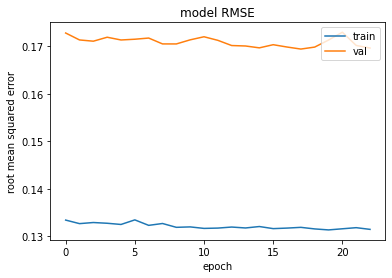

In [ ]:
history_js_2 = model_2.fit(X_train_js2, y_train_js2, validation_data=(X_val1_js2, y_val1_js2), epochs=50, callbacks=[early_stopping_monitor],verbose=False)

# summarize history for rmse
plt.plot(history_js_2.history['root_mean_squared_error'])
plt.plot(history_js_2.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()


In [ ]:
print(classification_report(test_results_js_2['actuals'], test_results_js_2['predictions']))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       568
         1.0       0.97      0.98      0.98       103
         2.0       0.94      0.94      0.94        34
         3.0       0.95      0.95      0.95        19

    accuracy                           0.99       724
   macro avg       0.96      0.97      0.97       724
weighted avg       0.99      0.99      0.99       724



###comparing all the LSTM models

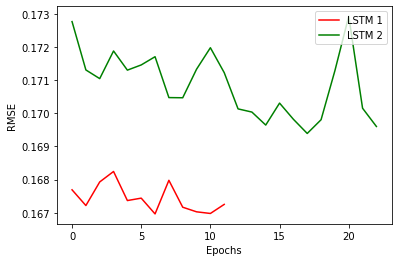

In [ ]:
plt.plot(history_js_1.history['val_root_mean_squared_error'], 'r',
         history_js_2.history['val_root_mean_squared_error'],'g')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(['LSTM 1', 'LSTM 2'], loc='upper right')
plt.show()

####predicting for 1 jan 2021 until 1 feb 2021 using the 2nd model

In [ ]:
df_date = pd.DataFrame({
    'date':pd.date_range(start='2021-01-01', end='2021-02-01')
})
df_date

date
0  2021-01-01
1  2021-01-02
2  2021-01-03
3  2021-01-04
4  2021-01-05
5  2021-01-06
6  2021-01-07
7  2021-01-08
8  2021-01-09
9  2021-01-10
10 2021-01-11
11 2021-01-12
12 2021-01-13
13 2021-01-14
14 2021-01-15
15 2021-01-16
16 2021-01-17
17 2021-01-18
18 2021-01-19
19 2021-01-20
20 2021-01-21
21 2021-01-22
22 2021-01-23
23 2021-01-24
24 2021-01-25
25 2021-01-26
26 2021-01-27
27 2021-01-28
28 2021-01-29
29 2021-01-30
30 2021-01-31
31 2021-02-01

In [ ]:
df_date.index = pd.to_datetime(df_date['date'], format='%Y.%m.%d')
df_date

date
date                 
2021-01-01 2021-01-01
2021-01-02 2021-01-02
2021-01-03 2021-01-03
2021-01-04 2021-01-04
2021-01-05 2021-01-05
2021-01-06 2021-01-06
2021-01-07 2021-01-07
2021-01-08 2021-01-08
2021-01-09 2021-01-09
2021-01-10 2021-01-10
2021-01-11 2021-01-11
2021-01-12 2021-01-12
2021-01-13 2021-01-13
2021-01-14 2021-01-14
2021-01-15 2021-01-15
2021-01-16 2021-01-16
2021-01-17 2021-01-17
2021-01-18 2021-01-18
2021-01-19 2021-01-19
2021-01-20 2021-01-20
2021-01-21 2021-01-21
2021-01-22 2021-01-22
2021-01-23 2021-01-23
2021-01-24 2021-01-24
2021-01-25 2021-01-25
2021-01-26 2021-01-26
2021-01-27 2021-01-27
2021-01-28 2021-01-28
2021-01-29 2021-01-29
2021-01-30 2021-01-30
2021-01-31 2021-01-31
2021-02-01 2021-02-01

In [ ]:
df_date['Seconds'] = df_date.index.map(pd.Timestamp.timestamp)
df_date

date       Seconds
date                               
2021-01-01 2021-01-01  1.609459e+09
2021-01-02 2021-01-02  1.609546e+09
2021-01-03 2021-01-03  1.609632e+09
2021-01-04 2021-01-04  1.609718e+09
2021-01-05 2021-01-05  1.609805e+09
2021-01-06 2021-01-06  1.609891e+09
2021-01-07 2021-01-07  1.609978e+09
2021-01-08 2021-01-08  1.610064e+09
2021-01-09 2021-01-09  1.610150e+09
2021-01-10 2021-01-10  1.610237e+09
2021-01-11 2021-01-11  1.610323e+09
2021-01-12 2021-01-12  1.610410e+09
2021-01-13 2021-01-13  1.610496e+09
2021-01-14 2021-01-14  1.610582e+09
2021-01-15 2021-01-15  1.610669e+09
2021-01-16 2021-01-16  1.610755e+09
2021-01-17 2021-01-17  1.610842e+09
2021-01-18 2021-01-18  1.610928e+09
2021-01-19 2021-01-19  1.611014e+09
2021-01-20 2021-01-20  1.611101e+09
2021-01-21 2021-01-21  1.611187e+09
2021-01-22 2021-01-22  1.611274e+09
2021-01-23 2021-01-23  1.611360e+09
2021-01-24 2021-01-24  1.611446e+09
2021-01-25 2021-01-25  1.611533e+09
2021-01-26 2021-01-26  1.611619e+09
2021-01-27 2021-01-27  1.611706e+09
2021-01-28 2021-01-28  1.611792e+09
2021-01-29 2021-01-29  1.611878e+09
2021-01-30 2021-01-30  1.611965e+09
2021-01-31 2021-01-31  1.612051e+09
2021-02-01 2021-02-01  1.612138e+09

In [ ]:
df_date['Day sin'] = np.sin(df_date['Seconds'] * (2* np.pi / day))
df_date['Day cos'] = np.cos(df_date['Seconds'] * (2 * np.pi / day))
df_date['Month sin'] = np.sin(df_date['Seconds'] * (2* np.pi / month))
df_date['Month cos'] = np.cos(df_date['Seconds'] * (2* np.pi / month))
df_date['Year sin'] = np.sin(df_date['Seconds'] * (2 * np.pi / year))
df_date['Year cos'] = np.cos(df_date['Seconds'] * (2 * np.pi / year))
df_date.head()

date       Seconds       Day sin  Day cos  Month sin  \
date                                                                    
2021-01-01 2021-01-01  1.609459e+09 -6.012051e-12      1.0   0.114525   
2021-01-02 2021-01-02  1.609546e+09 -1.713513e-12      1.0   0.315714   
2021-01-03 2021-01-03  1.609632e+09 -1.196689e-11      1.0   0.503497   
2021-01-04 2021-01-04  1.609718e+09 -7.668351e-12      1.0   0.669900   
2021-01-05 2021-01-05  1.609805e+09 -3.369812e-12      1.0   0.807857   

            Month cos  Year sin  Year cos  
date                                       
2021-01-01   0.993420  0.010881  0.999941  
2021-01-02   0.948854  0.028080  0.999606  
2021-01-03   0.863997  0.045271  0.998975  
2021-01-04   0.742451  0.062448  0.998048  
2021-01-05   0.589379  0.079608  0.996826

In [ ]:
df_date = df_date.drop('Seconds', axis=1)
df_date = df_date.drop('date',axis=1)
df_date.head()

Day sin  Day cos  Month sin  Month cos  Year sin  Year cos
date                                                                       
2021-01-01 -6.012051e-12      1.0   0.114525   0.993420  0.010881  0.999941
2021-01-02 -1.713513e-12      1.0   0.315714   0.948854  0.028080  0.999606
2021-01-03 -1.196689e-11      1.0   0.503497   0.863997  0.045271  0.998975
2021-01-04 -7.668351e-12      1.0   0.669900   0.742451  0.062448  0.998048
2021-01-05 -3.369812e-12      1.0   0.807857   0.589379  0.079608  0.996826

In [ ]:
df_date.insert(0, "score", [0 for i in range(32)], True)
df_date

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2021-01-01      0 -6.012051e-12      1.0   0.114525   0.993420  0.010881   
2021-01-02      0 -1.713513e-12      1.0   0.315714   0.948854  0.028080   
2021-01-03      0 -1.196689e-11      1.0   0.503497   0.863997  0.045271   
2021-01-04      0 -7.668351e-12      1.0   0.669900   0.742451  0.062448   
2021-01-05      0 -3.369812e-12      1.0   0.807857   0.589379  0.079608   
2021-01-06      0  9.287266e-13      1.0   0.911509   0.411280  0.096743   
2021-01-07      0 -9.324650e-12      1.0   0.976456   0.215716  0.113850   
2021-01-08      0 -5.026111e-12      1.0   0.999940   0.010992  0.130923   
2021-01-09      0 -7.275728e-13      1.0   0.980962  -0.194198  0.147958   
2021-01-10      0 -1.098095e-11      1.0   0.920330  -0.391142  0.164948   
2021-01-11      0 -6.682411e-12      1.0   0.820618  -0.571477  0.181890   
2021-01-12      0 -2.383872e-12      1.0   0.686059  -0.727545  0.198778   
2021-01-13      0 -1.263725e-11      1.0   0.522369  -0.852720  0.215608   
2021-01-14      0 -8.338710e-12      1.0   0.336497  -0.941685  0.232373   
2021-01-15      0 -4.040172e-12      1.0   0.136336  -0.990663  0.249070   
2021-01-16      0  2.583671e-13      1.0  -0.069615  -0.997574  0.265693   
2021-01-17      0 -9.995009e-12      1.0  -0.272609  -0.962125  0.282237   
2021-01-18      0 -5.696471e-12      1.0  -0.464027  -0.885821  0.298698   
2021-01-19      0 -1.397932e-12      1.0  -0.635741  -0.771902  0.315070   
2021-01-20      0 -1.165131e-11      1.0  -0.780460  -0.625206  0.331350   
2021-01-21      0 -7.352770e-12      1.0  -0.892037  -0.451961  0.347531   
2021-01-22      0 -3.054232e-12      1.0  -0.965736  -0.259525  0.363609   
2021-01-23      0 -1.330761e-11      1.0  -0.998427  -0.056069  0.379580   
2021-01-24      0 -9.009070e-12      1.0  -0.988721   0.149769  0.395438   
2021-01-25      0 -4.710531e-12      1.0  -0.937031   0.349247  0.411179   
2021-01-26      0 -4.119923e-13      1.0  -0.845551   0.533894  0.426799   
2021-01-27      0 -1.066537e-11      1.0  -0.718167   0.695871  0.442292   
2021-01-28      0 -6.366830e-12      1.0  -0.560287   0.828299  0.457655   
2021-01-29      0 -2.068292e-12      1.0  -0.378615   0.925554  0.472882   
2021-01-30      0 -1.232167e-11      1.0  -0.180866   0.983508  0.487969   
2021-01-31      0 -8.023130e-12      1.0   0.024563   0.999698  0.502912   
2021-02-01      0 -3.724591e-12      1.0   0.228949   0.973438  0.517705   

            Year cos  
date                  
2021-01-01  0.999941  
2021-01-02  0.999606  
2021-01-03  0.998975  
2021-01-04  0.998048  
2021-01-05  0.996826  
2021-01-06  0.995309  
2021-01-07  0.993498  
2021-01-08  0.991393  
2021-01-09  0.988994  
2021-01-10  0.986302  
2021-01-11  0.983319  
2021-01-12  0.980044  
2021-01-13  0.976480  
2021-01-14  0.972627  
2021-01-15  0.968486  
2021-01-16  0.964058  
2021-01-17  0.959345  
2021-01-18  0.954348  
2021-01-19  0.949068  
2021-01-20  0.943508  
2021-01-21  0.937669  
2021-01-22  0.931552  
2021-01-23  0.925159  
2021-01-24  0.918493  
2021-01-25  0.911554  
2021-01-26  0.904347  
2021-01-27  0.896871  
2021-01-28  0.889130  
2021-01-29  0.881126  
2021-01-30  0.872861  
2021-01-31  0.864338  
2021-02-01  0.855559

In [ ]:
x_test_js = scorejs_test_df.tail(7)
x_test_js

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2020-12-25    0.0 -6.997991e-12      1.0  -0.971208   0.238232 -0.109320   
2020-12-26    0.0 -2.699453e-12      1.0  -0.901757   0.432242 -0.092205   
2020-12-27    0.0 -1.295283e-11      1.0  -0.794015   0.607898 -0.075062   
2020-12-28    0.0 -8.654291e-12      1.0  -0.652557   0.757740 -0.057898   
2020-12-29    0.0 -4.355752e-12      1.0  -0.483388   0.875406 -0.040716   
2020-12-30    0.0 -5.721331e-14      1.0  -0.293694   0.955900 -0.023523   
2020-12-31    0.0 -1.031059e-11      1.0  -0.091528   0.995803 -0.006322   

            Year cos  
date                  
2020-12-25  0.994007  
2020-12-26  0.995740  
2020-12-27  0.997179  
2020-12-28  0.998323  
2020-12-29  0.999171  
2020-12-30  0.999723  
2020-12-31  0.999980

In [ ]:
x_test1_js = x_test_js.append(df_date)
x_test1_js

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2020-12-25    0.0 -6.997991e-12      1.0  -0.971208   0.238232 -0.109320   
2020-12-26    0.0 -2.699453e-12      1.0  -0.901757   0.432242 -0.092205   
2020-12-27    0.0 -1.295283e-11      1.0  -0.794015   0.607898 -0.075062   
2020-12-28    0.0 -8.654291e-12      1.0  -0.652557   0.757740 -0.057898   
2020-12-29    0.0 -4.355752e-12      1.0  -0.483388   0.875406 -0.040716   
2020-12-30    0.0 -5.721331e-14      1.0  -0.293694   0.955900 -0.023523   
2020-12-31    0.0 -1.031059e-11      1.0  -0.091528   0.995803 -0.006322   
2021-01-01    0.0 -6.012051e-12      1.0   0.114525   0.993420  0.010881   
2021-01-02    0.0 -1.713513e-12      1.0   0.315714   0.948854  0.028080   
2021-01-03    0.0 -1.196689e-11      1.0   0.503497   0.863997  0.045271   
2021-01-04    0.0 -7.668351e-12      1.0   0.669900   0.742451  0.062448   
2021-01-05    0.0 -3.369812e-12      1.0   0.807857   0.589379  0.079608   
2021-01-06    0.0  9.287266e-13      1.0   0.911509   0.411280  0.096743   
2021-01-07    0.0 -9.324650e-12      1.0   0.976456   0.215716  0.113850   
2021-01-08    0.0 -5.026111e-12      1.0   0.999940   0.010992  0.130923   
2021-01-09    0.0 -7.275728e-13      1.0   0.980962  -0.194198  0.147958   
2021-01-10    0.0 -1.098095e-11      1.0   0.920330  -0.391142  0.164948   
2021-01-11    0.0 -6.682411e-12      1.0   0.820618  -0.571477  0.181890   
2021-01-12    0.0 -2.383872e-12      1.0   0.686059  -0.727545  0.198778   
2021-01-13    0.0 -1.263725e-11      1.0   0.522369  -0.852720  0.215608   
2021-01-14    0.0 -8.338710e-12      1.0   0.336497  -0.941685  0.232373   
2021-01-15    0.0 -4.040172e-12      1.0   0.136336  -0.990663  0.249070   
2021-01-16    0.0  2.583671e-13      1.0  -0.069615  -0.997574  0.265693   
2021-01-17    0.0 -9.995009e-12      1.0  -0.272609  -0.962125  0.282237   
2021-01-18    0.0 -5.696471e-12      1.0  -0.464027  -0.885821  0.298698   
2021-01-19    0.0 -1.397932e-12      1.0  -0.635741  -0.771902  0.315070   
2021-01-20    0.0 -1.165131e-11      1.0  -0.780460  -0.625206  0.331350   
2021-01-21    0.0 -7.352770e-12      1.0  -0.892037  -0.451961  0.347531   
2021-01-22    0.0 -3.054232e-12      1.0  -0.965736  -0.259525  0.363609   
2021-01-23    0.0 -1.330761e-11      1.0  -0.998427  -0.056069  0.379580   
2021-01-24    0.0 -9.009070e-12      1.0  -0.988721   0.149769  0.395438   
2021-01-25    0.0 -4.710531e-12      1.0  -0.937031   0.349247  0.411179   
2021-01-26    0.0 -4.119923e-13      1.0  -0.845551   0.533894  0.426799   
2021-01-27    0.0 -1.066537e-11      1.0  -0.718167   0.695871  0.442292   
2021-01-28    0.0 -6.366830e-12      1.0  -0.560287   0.828299  0.457655   
2021-01-29    0.0 -2.068292e-12      1.0  -0.378615   0.925554  0.472882   
2021-01-30    0.0 -1.232167e-11      1.0  -0.180866   0.983508  0.487969   
2021-01-31    0.0 -8.023130e-12      1.0   0.024563   0.999698  0.502912   
2021-02-01    0.0 -3.724591e-12      1.0   0.228949   0.973438  0.517705   

            Year cos  
date                  
2020-12-25  0.994007  
2020-12-26  0.995740  
2020-12-27  0.997179  
2020-12-28  0.998323  
2020-12-29  0.999171  
2020-12-30  0.999723  
2020-12-31  0.999980  
2021-01-01  0.999941  
2021-01-02  0.999606  
2021-01-03  0.998975  
2021-01-04  0.998048  
2021-01-05  0.996826  
2021-01-06  0.995309  
2021-01-07  0.993498  
2021-01-08  0.991393  
2021-01-09  0.988994  
2021-01-10  0.986302  
2021-01-11  0.983319  
2021-01-12  0.980044  
2021-01-13  0.976480  
2021-01-14  0.972627  
2021-01-15  0.968486  
2021-01-16  0.964058  
2021-01-17  0.959345  
2021-01-18  0.954348  
2021-01-19  0.949068  
2021-01-20  0.943508  
2021-01-21  0.937669  
2021-01-22  0.931552  
2021-01-23  0.925159  
2021-01-24  0.918493  
2021-01-25  0.911554  
2021-01-26  0.904347  
2021-01-27  0.896871  
2021-01-28  0.889130  
2021-01-29  0.881126  
2021-01-30  0.872861 

In [ ]:
WINDOW_SIZE = 7
X_test1_js2_new, y_test1_js2_new = df_to_X_y2(x_test1_js, WINDOW_SIZE)
X_test1_js2_new.shape

(32, 7, 7)

In [ ]:
test_prediction_2_new_js = model_2.predict(X_test1_js2_new).flatten()
test_results_2_new_js = pd.DataFrame(data={'predictions':test_prediction_2_new_js})
test_results_2_new_js

1/1 [==============================] - 0s 17ms/step


predictions
0      0.670066
1      0.668703
2      0.665888
3      0.661537
4      0.655716
5      0.648694
6      0.640972
7      0.633293
8      0.626592
9      0.621880
10     0.620052
11     0.621660
12     0.626700
13     0.634513
14     0.642960
15     0.650770
16     0.658041
17     0.663702
18     0.667275
19     0.667306
20     0.664581
21     0.661253
22     0.658547
23     0.657268
24     0.657635
25     0.659345
26     0.661795
27     0.664331
28     0.666410
29     0.667649
30     0.667796
31     0.666673

#####result

In [ ]:
test_results_2_new_js.predictions[test_results_2_new_js.predictions <0.5] = 0
test_results_2_new_js.predictions[(test_results_2_new_js.predictions >=0.5)&(test_results_2_new_js.predictions<1.5)] = 1
test_results_2_new_js.predictions[(test_results_2_new_js.predictions >=1.5)&(test_results_2_new_js.predictions<2.5)] = 2
test_results_2_new_js.predictions[(test_results_2_new_js.predictions >=2.5)&(test_results_2_new_js.predictions<3.5)] = 3
test_results_2_new_js.predictions[(test_results_2_new_js.predictions >=3.5)&(test_results_2_new_js.predictions<4.5)] = 4
test_results_2_new_js.predictions[(test_results_2_new_js.predictions >=4.5)&(test_results_2_new_js.predictions<5.5)] = 5
test_results_2_new_js

predictions
0           1.0
1           1.0
2           1.0
3           1.0
4           1.0
5           1.0
6           1.0
7           1.0
8           1.0
9           1.0
10          1.0
11          1.0
12          1.0
13          1.0
14          1.0
15          1.0
16          1.0
17          1.0
18          1.0
19          1.0
20          1.0
21          1.0
22          1.0
23          1.0
24          1.0
25          1.0
26          1.0
27          1.0
28          1.0
29          1.0
30          1.0
31          1.0

##St. Lucie, Florida

###train

In [ ]:
stlucie = train[train['fips']==12111]

#using interpolation to fill in the NaN values
stlucie = stlucie.interpolate().fillna(method='bfill')
stlucie.score[stlucie.score <0.5] = 0
stlucie.score[(stlucie.score >=0.5)&(stlucie.score<1.5)] = 1
stlucie.score[(stlucie.score >=1.5)&(stlucie.score<2.5)] = 2
stlucie.score[(stlucie.score >=2.5)&(stlucie.score<3.5)] = 3
stlucie.score[(stlucie.score >=3.5)&(stlucie.score<4.5)] = 4
stlucie.score[(stlucie.score >=4.5)&(stlucie.score<5.5)] = 5

#merging the weather data with the soil data
stlucie = stlucie.merge(soil, left_on='fips', right_on='fips')
train_st = stlucie.copy()
stlucie['date'] = pd.to_datetime(stlucie['date'], format='%Y.%m.%d')
train_st['tahun'] = stlucie['date'].dt.year
train_st['bulan'] = stlucie['date'].dt.month
train_st['tanggal'] = stlucie['date'].dt.day
train_st[0:31]

fips        date  PRECTOT      PS   QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   12111  2000-01-01     0.00  102.21  11.96  21.32   17.08   17.08    24.01   
1   12111  2000-01-02     0.01  102.24  11.92  21.16   17.07   17.07    23.65   
2   12111  2000-01-03     0.26  102.05  12.97  22.05   18.35   18.35    24.71   
3   12111  2000-01-04     1.33  101.91  14.46  22.74   20.07   20.07    25.26   
4   12111  2000-01-05     1.91  102.07  11.93  20.08   16.88   16.88    21.87   
5   12111  2000-01-06     7.27  102.29  13.70  22.23   19.24   19.24    24.42   
6   12111  2000-01-07     2.31  102.32  13.91  22.57   19.52   19.52    24.75   
7   12111  2000-01-08     0.15  102.17  13.19  22.14   18.66   18.66    24.44   
8   12111  2000-01-09     0.28  101.94  13.59  22.36   19.08   19.08    25.02   
9   12111  2000-01-10     0.69  101.76  14.28  22.64   19.84   19.84    25.62   
10  12111  2000-01-11     0.54  102.03  11.81  21.10   16.34   16.34    23.97   
11  12111  2000-01-12     0.00  102.28   9.86  20.63   13.95   13.95    24.08   
12  12111  2000-01-13     0.09  102.28   9.88  21.28   14.13   14.13    24.01   
13  12111  2000-01-14     0.18  102.74   8.72  17.45   12.01   12.02    18.94   
14  12111  2000-01-15     0.39  103.25   7.95  16.92   10.91   10.91    18.55   
15  12111  2000-01-16     0.01  102.98   8.47  18.06   11.89   11.89    20.30   
16  12111  2000-01-17     0.04  102.50   8.60  17.48   11.93   11.93    20.32   
17  12111  2000-01-18     0.60  102.05  10.45  18.60   14.95   14.95    21.79   
18  12111  2000-01-19     0.25  101.63  11.91  19.31   16.94   16.94    22.13   
19  12111  2000-01-20     0.47  101.16  11.65  20.03   16.37   16.37    24.31   
20  12111  2000-01-21     0.00  101.74   6.84  13.72    8.06    8.07    16.34   
21  12111  2000-01-22     0.38  102.02   8.49  16.47   11.58   11.58    20.23   
22  12111  2000-01-23     0.04  101.75  11.25  19.73   16.01   16.01    23.31   
23  12111  2000-01-24    27.14  100.74  11.63  18.66   15.94   15.94    22.01   
24  12111  2000-01-25     0.01  101.12   6.66  12.19    7.86    7.86    16.13   
25  12111  2000-01-26     0.00  101.68   5.38   9.92    4.56    4.58    13.11   
26  12111  2000-01-27     0.00  102.30   5.81  11.03    5.51    5.53    15.04   
27  12111  2000-01-28     0.85  102.39   9.79  17.73   13.95   13.95    19.83   
28  12111  2000-01-29     2.42  102.29  11.72  20.10   16.79   16.79    22.46   
29  12111  2000-01-30     1.30  102.17  12.52  20.73   17.82   17.82    23.65   
30  12111  2000-01-31     0.38  102.01  10.88  17.71   15.40   15.41    20.74   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0     19.17       4.83  21.41   3.44       4.23       2.62         1.61   
1     19.52       4.12  21.51   4.00       4.63       3.40         1.24   
2     19.94       4.77  22.10   4.33       5.14       3.68         1.46   
3     20.93       4.33  22.80   4.80       5.87       3.79         2.07   
4     17.70       4.17  21.44   5.80       6.63       4.54         2.09   
5     20.09       4.33  22.39   5.45       6.50       4.76         1.74   
6     20.94       3.81  23.03   3.52       5.05       2.48         2.56   
7     20.39       4.04  22.77   2.95       3.43       2.41         1.02   
8     20.32       4.70  22.51   3.58       4.56       2.62         1.94   
9     20.66       4.95  22.80   5.26       7.25       4.15         3.10   
10    19.38       4.59  21.64   4.14       5.44       2.11         3.34   
11    17.60       6.48  20.66   3.55       4.16       2.56         1.60   
12    18.99       5.02  20.97   1.60       3.98       0.40         3.58   
13    15.21       3.74  19.84  11.09      14.03       4.60         9.44   
14    15.38       3.17  19.33   9.11      11.00       7.03         3.97   
15    16.66       3.64  19.72   4.84       6.82       2.38         4.44   
16    14.51       5.81  19.24   4.06       5.04       2.07         2.97   
17    15.80       5.99  20.15   4.94       7.26       3.93    

In [ ]:
train_st['score'].value_counts()

0.0    4012
1.0    1012
2.0     463
4.0     363
3.0     296
5.0      64
Name: score, dtype: int64

In [ ]:
#For Regression

st_lucie = train[train['fips']==12111]

#using interpolation to fill in the NaN values
st_lucie = st_lucie.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
st_lucie = st_lucie.merge(soil, left_on='fips', right_on='fips')
train_st = st_lucie.copy()
train_st[2000:2050]

fips        date  PRECTOT      PS   QV2M    T2M  T2MDEW  T2MWET  \
2000  12111  2005-06-23    15.72  101.55  17.63  25.48   23.23   23.23   
2001  12111  2005-06-24     9.65  101.26  17.97  25.86   23.50   23.50   
2002  12111  2005-06-25     3.22  101.12  18.16  27.65   23.64   23.64   
2003  12111  2005-06-26    10.27  101.46  19.76  27.76   25.09   25.09   
2004  12111  2005-06-27    14.75  101.72  20.17  27.31   25.49   25.49   
2005  12111  2005-06-28     9.93  101.60  19.63  27.19   25.02   25.02   
2006  12111  2005-06-29     6.42  101.59  19.79  27.09   25.15   25.15   
2007  12111  2005-06-30    15.79  101.52  19.42  27.12   24.82   24.82   
2008  12111  2005-07-01    12.20  101.33  19.88  27.29   25.17   25.18   
2009  12111  2005-07-02     3.78  101.31  19.97  27.75   25.25   25.25   
2010  12111  2005-07-03     8.09  101.57  20.01  28.58   25.33   25.33   
2011  12111  2005-07-04     0.87  101.89  19.39  28.86   24.84   24.84   
2012  12111  2005-07-05     0.04  101.81  18.59  28.43   24.14   24.14   
2013  12111  2005-07-06     0.01  101.58  18.38  28.37   23.92   23.92   
2014  12111  2005-07-07     0.38  101.51  19.54  28.55   24.92   24.92   
2015  12111  2005-07-08     8.73  101.37  20.79  28.08   25.93   25.93   
2016  12111  2005-07-09    16.74  101.30  20.03  27.78   25.30   25.30   
2017  12111  2005-07-10     7.30  101.46  19.88  27.78   25.21   25.21   
2018  12111  2005-07-11     2.99  101.63  20.12  28.01   25.43   25.43   
2019  12111  2005-07-12     2.62  101.76  20.14  27.99   25.47   25.47   
2020  12111  2005-07-13     0.76  101.61  18.92  28.08   24.40   24.40   
2021  12111  2005-07-14     2.00  101.50  19.09  28.10   24.53   24.54   
2022  12111  2005-07-15     1.51  101.62  19.07  28.37   24.54   24.54   
2023  12111  2005-07-16     1.71  101.79  19.70  27.98   25.11   25.11   
2024  12111  2005-07-17     2.52  101.80  19.97  28.13   25.34   25.34   
2025  12111  2005-07-18     1.39  101.68  19.56  28.35   24.97   24.97   
2026  12111  2005-07-19     1.83  101.66  19.83  28.39   25.19   25.19   
2027  12111  2005-07-20     1.91  101.68  19.76  28.19   25.13   25.13   
2028  12111  2005-07-21     1.44  101.69  20.12  28.33   25.44   25.44   
2029  12111  2005-07-22     1.40  101.61  19.61  28.92   25.00   25.00   
2030  12111  2005-07-23     0.75  101.57  20.33  28.86   25.59   25.59   
2031  12111  2005-07-24    18.35  101.47  20.62  28.15   25.81   25.80   
2032  12111  2005-07-25     5.42  101.44  19.18  28.41   24.61   24.61   
2033  12111  2005-07-26     0.41  101.45  17.93  28.55   23.48   23.48   
2034  12111  2005-07-27     0.49  101.40  18.32  28.99   23.82   23.82   
2035  12111  2005-07-28     0.79  101.47  19.62  28.93   24.98   24.98   
2036  12111  2005-07-29     4.86  101.69  19.77  28.33   25.14   25.15   
2037  12111  2005-07-30     8.38  101.72  19.83  27.92   25.20   25.20   
2038  12111  2005-07-31     5.27  101.62  19.82  28.26   25.18   25.18   
2039  12111  2005-08-01     7.10  101.56  19.48  28.58   24.88   24.88   
2040  12111  2005-08-02     6.58  101.43  18.96  28.51   24.41   24.41   
2041  12111  2005-08-03     8.56  101.34  19.53  28.68   24.89   24.89   
2042  12111  2005-08-04    13.24  101.49  19.51  29.09   24.88   24.88   
2043  12111  2005-08-05     7.50  101.64  19.50  28.40   24.91   24.90   
2044  12111  2005-08-06     3.12  101.61  18.94  28.29   24.42   24.41   
2045  12111  2005-08-07    12.83  101.58  18.90  27.95   24.39   24.38   
2046  12111  2005-08-08     2.32  101.53  18.34  27.95   23.87   23.87   
2047  12111  2005-08-09     4.74  101.57  18.86  28.73   24.33   24.33   
2048  12111  2005-08-10     2.21  101.60  19.27  29.04   24.69   24.69   
2049  12111  2005-08-11     4.06  101.61  19.88  29.04   25.22   25.23   

      T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
2000    26.49    24.61       1.88  26.19   4.65       5.49       2.75   
2001    27.17    24.63       2.54  26.85   5.74       6.97       3.95   
2002    30.19

###val

In [ ]:
stlucie_val = validation[validation['fips']==12111]

#using interpolation to fill in the NaN values
stlucie_val = stlucie_val.interpolate().fillna(method='bfill')
stlucie_val.score[stlucie_val.score <0.5] = 0
stlucie_val.score[(stlucie_val.score >=0.5)&(stlucie_val.score<1.5)] = 1
stlucie_val.score[(stlucie_val.score >=1.5)&(stlucie_val.score<2.5)] = 2
stlucie_val.score[(stlucie_val.score >=2.5)&(stlucie_val.score<3.5)] = 3
stlucie_val.score[(stlucie_val.score >=3.5)&(stlucie_val.score<4.5)] = 4
stlucie_val.score[(stlucie_val.score >=4.5)&(stlucie_val.score<5.5)] = 5

#merging the weather data with the soil data
stlucie_val = stlucie_val.merge(soil, left_on='fips', right_on='fips')
val_st = stlucie_val.copy()
stlucie_val['date'] = pd.to_datetime(stlucie_val['date'], format='%Y.%m.%d')
val_st['tahun'] = stlucie_val['date'].dt.year
val_st['bulan'] = stlucie_val['date'].dt.month
val_st['tanggal'] = stlucie_val['date'].dt.day
val_st[0:31]

fips        date  PRECTOT      PS   QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   12111  2017-01-01     0.03  102.11  13.42  22.89   18.85   18.85    26.09   
1   12111  2017-01-02     0.93  102.03  15.74  24.18   21.45   21.45    26.66   
2   12111  2017-01-03     1.34  101.51  16.18  24.83   21.80   21.80    27.56   
3   12111  2017-01-04     3.04  101.12  14.76  23.66   20.09   20.09    26.61   
4   12111  2017-01-05     0.04  101.26  10.80  20.72   15.33   15.33    24.32   
5   12111  2017-01-06     0.92  101.50  12.94  21.77   18.05   18.05    25.43   
6   12111  2017-01-07     4.21  101.70  13.43  20.78   18.09   18.09    25.41   
7   12111  2017-01-08     0.07  102.89   7.48  15.14    9.71    9.72    16.92   
8   12111  2017-01-09     0.11  103.10   8.07  17.84   11.04   11.04    19.82   
9   12111  2017-01-10     0.55  102.76   9.24  19.66   13.13   13.13    21.85   
10  12111  2017-01-11     0.51  102.57  10.51  20.94   15.12   15.12    23.01   
11  12111  2017-01-12     0.26  102.55  11.78  21.95   16.89   16.89    24.41   
12  12111  2017-01-13     0.76  102.74  12.34  22.41   17.68   17.68    24.66   
13  12111  2017-01-14     0.30  102.64  11.64  22.13   16.73   16.73    24.19   
14  12111  2017-01-15     0.08  102.33  10.90  22.30   15.65   15.65    24.60   
15  12111  2017-01-16     0.10  102.30  11.60  22.46   16.63   16.63    24.89   
16  12111  2017-01-17     0.04  102.24  12.19  22.90   17.41   17.41    25.69   
17  12111  2017-01-18     0.01  102.03  11.73  22.63   16.77   16.77    25.67   
18  12111  2017-01-19     0.02  101.64  11.94  22.25   16.97   16.97    25.70   
19  12111  2017-01-20     0.23  101.47  12.11  22.07   17.10   17.10    26.11   
20  12111  2017-01-21     0.14  101.31  13.36  22.81   18.66   18.66    26.51   
21  12111  2017-01-22     3.23  100.62  15.40  24.64   20.85   20.85    27.89   
22  12111  2017-01-23     9.61  100.19  11.68  21.26   16.19   16.19    24.07   
23  12111  2017-01-24     0.00  101.11   9.33  19.50   12.97   12.97    23.99   
24  12111  2017-01-25     0.02  101.56   9.77  19.50   13.77   13.77    24.50   
25  12111  2017-01-26     0.06  101.64  13.16  22.09   18.52   18.52    26.52   
26  12111  2017-01-27     0.55  101.65  10.79  20.32   14.75   14.75    22.44   
27  12111  2017-01-28     0.01  101.85   6.28  15.93    6.79    6.81    18.75   
28  12111  2017-01-29    12.94  101.95   8.20  13.97   10.94   10.95    15.13   
29  12111  2017-01-30     0.01  102.14   7.00  15.45    8.27    8.29    18.10   
30  12111  2017-01-31     0.00  102.32   5.72  16.62    5.80    5.82    20.57   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0     19.98       6.11  23.09   5.18       6.37       4.45         1.92   
1     22.33       4.33  24.34   5.54       7.14       4.45         2.68   
2     23.01       4.55  24.89   4.71       6.24       2.79         3.45   
3     19.85       6.75  24.22   5.05       5.86       4.13         1.73   
4     17.34       6.98  22.33   3.52       4.87       2.24         2.63   
5     17.69       7.74  22.96   3.09       6.01       0.76         5.25   
6     13.79      11.62  22.45   8.65      10.94       6.50         4.45   
7     13.08       3.84  19.31  10.12      11.34       7.44         3.91   
8     15.99       3.83  20.39   6.86       7.43       6.25         1.18   
9     17.80       4.05  20.96   5.76       6.76       4.99         1.78   
10    18.96       4.04  21.73   5.50       6.29       4.84         1.45   
11    19.98       4.42  22.58   5.45       6.19       4.98         1.21   
12    21.12       3.54  22.91   5.74       6.84       4.99         1.86   
13    20.86       3.33  22.68   5.60       6.52       4.72         1.80   
14    20.61       3.99  22.82   4.70       5.69       3.96         1.73   
15    20.54       4.35  23.05   5.50       6.79       4.70         2.09   
16    20.65       5.03  23.30   4.40       5.26       3.11         2.15   
17    19.83       5.84  22.99   2.24       3.07       0.37    

In [ ]:
val_st['score'].value_counts()

0.0    427
1.0    145
2.0    104
3.0     54
Name: score, dtype: int64

In [ ]:
#For Regression

st_lucie_val = validation[validation['fips']==12111]

#using interpolation to fill in the NaN values
st_lucie_val = st_lucie_val.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
st_lucie_val = st_lucie_val.merge(soil, left_on='fips', right_on='fips')
val_st = st_lucie_val.copy()
val_st[0:31]

fips        date  PRECTOT      PS   QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   12111  2017-01-01     0.03  102.11  13.42  22.89   18.85   18.85    26.09   
1   12111  2017-01-02     0.93  102.03  15.74  24.18   21.45   21.45    26.66   
2   12111  2017-01-03     1.34  101.51  16.18  24.83   21.80   21.80    27.56   
3   12111  2017-01-04     3.04  101.12  14.76  23.66   20.09   20.09    26.61   
4   12111  2017-01-05     0.04  101.26  10.80  20.72   15.33   15.33    24.32   
5   12111  2017-01-06     0.92  101.50  12.94  21.77   18.05   18.05    25.43   
6   12111  2017-01-07     4.21  101.70  13.43  20.78   18.09   18.09    25.41   
7   12111  2017-01-08     0.07  102.89   7.48  15.14    9.71    9.72    16.92   
8   12111  2017-01-09     0.11  103.10   8.07  17.84   11.04   11.04    19.82   
9   12111  2017-01-10     0.55  102.76   9.24  19.66   13.13   13.13    21.85   
10  12111  2017-01-11     0.51  102.57  10.51  20.94   15.12   15.12    23.01   
11  12111  2017-01-12     0.26  102.55  11.78  21.95   16.89   16.89    24.41   
12  12111  2017-01-13     0.76  102.74  12.34  22.41   17.68   17.68    24.66   
13  12111  2017-01-14     0.30  102.64  11.64  22.13   16.73   16.73    24.19   
14  12111  2017-01-15     0.08  102.33  10.90  22.30   15.65   15.65    24.60   
15  12111  2017-01-16     0.10  102.30  11.60  22.46   16.63   16.63    24.89   
16  12111  2017-01-17     0.04  102.24  12.19  22.90   17.41   17.41    25.69   
17  12111  2017-01-18     0.01  102.03  11.73  22.63   16.77   16.77    25.67   
18  12111  2017-01-19     0.02  101.64  11.94  22.25   16.97   16.97    25.70   
19  12111  2017-01-20     0.23  101.47  12.11  22.07   17.10   17.10    26.11   
20  12111  2017-01-21     0.14  101.31  13.36  22.81   18.66   18.66    26.51   
21  12111  2017-01-22     3.23  100.62  15.40  24.64   20.85   20.85    27.89   
22  12111  2017-01-23     9.61  100.19  11.68  21.26   16.19   16.19    24.07   
23  12111  2017-01-24     0.00  101.11   9.33  19.50   12.97   12.97    23.99   
24  12111  2017-01-25     0.02  101.56   9.77  19.50   13.77   13.77    24.50   
25  12111  2017-01-26     0.06  101.64  13.16  22.09   18.52   18.52    26.52   
26  12111  2017-01-27     0.55  101.65  10.79  20.32   14.75   14.75    22.44   
27  12111  2017-01-28     0.01  101.85   6.28  15.93    6.79    6.81    18.75   
28  12111  2017-01-29    12.94  101.95   8.20  13.97   10.94   10.95    15.13   
29  12111  2017-01-30     0.01  102.14   7.00  15.45    8.27    8.29    18.10   
30  12111  2017-01-31     0.00  102.32   5.72  16.62    5.80    5.82    20.57   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0     19.98       6.11  23.09   5.18       6.37       4.45         1.92   
1     22.33       4.33  24.34   5.54       7.14       4.45         2.68   
2     23.01       4.55  24.89   4.71       6.24       2.79         3.45   
3     19.85       6.75  24.22   5.05       5.86       4.13         1.73   
4     17.34       6.98  22.33   3.52       4.87       2.24         2.63   
5     17.69       7.74  22.96   3.09       6.01       0.76         5.25   
6     13.79      11.62  22.45   8.65      10.94       6.50         4.45   
7     13.08       3.84  19.31  10.12      11.34       7.44         3.91   
8     15.99       3.83  20.39   6.86       7.43       6.25         1.18   
9     17.80       4.05  20.96   5.76       6.76       4.99         1.78   
10    18.96       4.04  21.73   5.50       6.29       4.84         1.45   
11    19.98       4.42  22.58   5.45       6.19       4.98         1.21   
12    21.12       3.54  22.91   5.74       6.84       4.99         1.86   
13    20.86       3.33  22.68   5.60       6.52       4.72         1.80   
14    20.61       3.99  22.82   4.70       5.69       3.96         1.73   
15    20.54       4.35  23.05   5.50       6.79       4.70         2.09   
16    20.65       5.03  23.30   4.40       5.26       3.11         2.15   
17    19.83       5.84  22.99   2.24       3.07       0.37    

###test

In [ ]:
stlucie_test = test[test['fips']==12111]

#using interpolation to fill in the NaN values
stlucie_test = stlucie_test.interpolate().fillna(method='bfill')
stlucie_test.score[stlucie_test.score <0.5] = 0
stlucie_test.score[(stlucie_test.score >=0.5)&(stlucie_test.score<1.5)] = 1
stlucie_test.score[(stlucie_test.score >=1.5)&(stlucie_test.score<2.5)] = 2
stlucie_test.score[(stlucie_test.score >=2.5)&(stlucie_test.score<3.5)] = 3
stlucie_test.score[(stlucie_test.score >=3.5)&(stlucie_test.score<4.5)] = 4
stlucie_test.score[(stlucie_test.score >=4.5)&(stlucie_test.score<5.5)] = 5

#merging the weather data with the soil data
stlucie_test = stlucie_test.merge(soil, left_on='fips', right_on='fips')
test_st = stlucie_test.copy()
stlucie_test['date'] = pd.to_datetime(stlucie_test['date'], format='%Y.%m.%d')
test_st['tahun'] = stlucie_test['date'].dt.year
test_st['bulan'] = stlucie_test['date'].dt.month
test_st['tanggal'] = stlucie_test['date'].dt.day
test_st[0:31]

fips        date  PRECTOT      PS   QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   12111  2019-01-01     0.25  102.05  14.65  23.97   20.35   20.30    26.86   
1   12111  2019-01-02     0.00  101.99  13.74  23.92   19.35   19.26    26.79   
2   12111  2019-01-03     3.47  101.73  15.95  24.33   21.64   21.62    27.02   
3   12111  2019-01-04     1.24  101.49  15.37  24.58   21.03   20.95    27.85   
4   12111  2019-01-05     2.18  101.57  11.69  21.12   16.72   16.44    24.37   
5   12111  2019-01-06     0.00  101.96  10.32  19.44   14.83   14.68    23.17   
6   12111  2019-01-07     0.09  102.13  11.27  21.93   16.26   16.15    24.71   
7   12111  2019-01-08     0.10  102.02  10.67  22.64   15.41   15.31    25.07   
8   12111  2019-01-09     0.00  101.76  10.40  20.29   14.95   14.73    23.88   
9   12111  2019-01-10     0.01  101.74   7.25  15.53    9.48    8.75    18.26   
10  12111  2019-01-11     0.09  101.97   9.43  19.35   13.47   13.31    22.57   
11  12111  2019-01-12     0.15  102.14  10.69  21.38   15.44   15.28    24.15   
12  12111  2019-01-13     0.67  101.95  12.74  22.58   18.13   18.01    26.13   
13  12111  2019-01-14     0.11  101.95  11.01  19.29   15.81   15.54    22.28   
14  12111  2019-01-15     0.00  102.02   8.54  15.99   11.93   11.65    18.61   
15  12111  2019-01-16     0.00  102.12   8.76  16.55   12.33   11.99    20.23   
16  12111  2019-01-17     0.03  102.12   9.70  19.67   13.93   13.76    23.61   
17  12111  2019-01-18     0.02  101.94   9.53  20.35   13.64   13.40    23.66   
18  12111  2019-01-19     0.02  101.57  11.27  21.47   16.16   16.01    24.80   
19  12111  2019-01-20     4.74  101.34  10.76  18.62   15.35   14.71    21.48   
20  12111  2019-01-21     0.00  102.36   7.90  14.95   10.82   10.32    19.04   
21  12111  2019-01-22     0.20  102.63   9.65  20.29   13.93   13.78    22.03   
22  12111  2019-01-23     0.67  102.14  11.91  22.50   17.12   16.91    24.45   
23  12111  2019-01-24    10.15  101.47  15.16  22.84   20.76   20.70    25.04   
24  12111  2019-01-25     0.95  101.99   8.25  16.35   11.43   10.85    18.47   
25  12111  2019-01-26    17.78  101.92   9.80  17.38   14.00   13.85    19.23   
26  12111  2019-01-27    48.76  100.97  13.25  19.71   18.51   18.40    21.84   
27  12111  2019-01-28     2.30  101.34   8.72  14.52   12.09   11.82    16.26   
28  12111  2019-01-29     0.03  101.57   7.86  15.90   10.65   10.42    19.92   
29  12111  2019-01-30     0.56  101.92   8.84  16.61   12.45   12.26    19.36   
30  12111  2019-01-31     6.20  102.23  10.95  18.91   15.76   15.64    20.72   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0     21.82       5.04  24.04   3.48       4.34       2.65         1.69   
1     21.79       5.00  23.99   3.65       5.42       1.88         3.54   
2     22.15       4.87  24.45   4.48       5.28       3.78         1.51   
3     22.43       5.42  24.66   5.68       6.73       4.27         2.46   
4     16.69       7.69  22.64   6.04       7.18       4.92         2.26   
5     15.89       7.28  21.44   3.61       5.28       2.32         2.96   
6     19.78       4.93  22.53   4.00       4.75       3.17         1.58   
7     20.86       4.21  22.62   1.66       3.03       0.30         2.73   
8     17.09       6.80  21.69   5.33       7.03       2.47         4.56   
9     12.89       5.37  18.97   5.87       7.66       4.50         3.15   
10    15.63       6.94  20.92   4.83       5.83       3.94         1.88   
11    19.06       5.09  21.98   5.27       6.80       3.86         2.95   
12    19.82       6.30  22.75   2.56       4.12       0.50         3.62   
13    15.59       6.69  21.40   4.67       5.29       3.70         1.60   
14    14.20       4.41  19.29   4.92       6.16       4.16         2.00   
15    13.62       6.60  19.15   4.59       5.61       3.50         2.12   
16    15.66       7.95  20.54   1.83       3.41       0.43         2.98   
17    17.52       6.13  21.09   1.97       3.07       0.85    

In [ ]:
test_st['score'].value_counts()

0.0    574
1.0     90
2.0     57
3.0     10
Name: score, dtype: int64

In [ ]:
#For Regression

st_lucie_test = test[test['fips']==12111]

#using interpolation to fill in the NaN values
st_lucie_test = st_lucie_test.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
st_lucie_test = st_lucie_test.merge(soil, left_on='fips', right_on='fips')
test_st = st_lucie_test.copy()
test_st[0:31]

fips        date  PRECTOT      PS   QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   12111  2019-01-01     0.25  102.05  14.65  23.97   20.35   20.30    26.86   
1   12111  2019-01-02     0.00  101.99  13.74  23.92   19.35   19.26    26.79   
2   12111  2019-01-03     3.47  101.73  15.95  24.33   21.64   21.62    27.02   
3   12111  2019-01-04     1.24  101.49  15.37  24.58   21.03   20.95    27.85   
4   12111  2019-01-05     2.18  101.57  11.69  21.12   16.72   16.44    24.37   
5   12111  2019-01-06     0.00  101.96  10.32  19.44   14.83   14.68    23.17   
6   12111  2019-01-07     0.09  102.13  11.27  21.93   16.26   16.15    24.71   
7   12111  2019-01-08     0.10  102.02  10.67  22.64   15.41   15.31    25.07   
8   12111  2019-01-09     0.00  101.76  10.40  20.29   14.95   14.73    23.88   
9   12111  2019-01-10     0.01  101.74   7.25  15.53    9.48    8.75    18.26   
10  12111  2019-01-11     0.09  101.97   9.43  19.35   13.47   13.31    22.57   
11  12111  2019-01-12     0.15  102.14  10.69  21.38   15.44   15.28    24.15   
12  12111  2019-01-13     0.67  101.95  12.74  22.58   18.13   18.01    26.13   
13  12111  2019-01-14     0.11  101.95  11.01  19.29   15.81   15.54    22.28   
14  12111  2019-01-15     0.00  102.02   8.54  15.99   11.93   11.65    18.61   
15  12111  2019-01-16     0.00  102.12   8.76  16.55   12.33   11.99    20.23   
16  12111  2019-01-17     0.03  102.12   9.70  19.67   13.93   13.76    23.61   
17  12111  2019-01-18     0.02  101.94   9.53  20.35   13.64   13.40    23.66   
18  12111  2019-01-19     0.02  101.57  11.27  21.47   16.16   16.01    24.80   
19  12111  2019-01-20     4.74  101.34  10.76  18.62   15.35   14.71    21.48   
20  12111  2019-01-21     0.00  102.36   7.90  14.95   10.82   10.32    19.04   
21  12111  2019-01-22     0.20  102.63   9.65  20.29   13.93   13.78    22.03   
22  12111  2019-01-23     0.67  102.14  11.91  22.50   17.12   16.91    24.45   
23  12111  2019-01-24    10.15  101.47  15.16  22.84   20.76   20.70    25.04   
24  12111  2019-01-25     0.95  101.99   8.25  16.35   11.43   10.85    18.47   
25  12111  2019-01-26    17.78  101.92   9.80  17.38   14.00   13.85    19.23   
26  12111  2019-01-27    48.76  100.97  13.25  19.71   18.51   18.40    21.84   
27  12111  2019-01-28     2.30  101.34   8.72  14.52   12.09   11.82    16.26   
28  12111  2019-01-29     0.03  101.57   7.86  15.90   10.65   10.42    19.92   
29  12111  2019-01-30     0.56  101.92   8.84  16.61   12.45   12.26    19.36   
30  12111  2019-01-31     6.20  102.23  10.95  18.91   15.76   15.64    20.72   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0     21.82       5.04  24.04   3.48       4.34       2.65         1.69   
1     21.79       5.00  23.99   3.65       5.42       1.88         3.54   
2     22.15       4.87  24.45   4.48       5.28       3.78         1.51   
3     22.43       5.42  24.66   5.68       6.73       4.27         2.46   
4     16.69       7.69  22.64   6.04       7.18       4.92         2.26   
5     15.89       7.28  21.44   3.61       5.28       2.32         2.96   
6     19.78       4.93  22.53   4.00       4.75       3.17         1.58   
7     20.86       4.21  22.62   1.66       3.03       0.30         2.73   
8     17.09       6.80  21.69   5.33       7.03       2.47         4.56   
9     12.89       5.37  18.97   5.87       7.66       4.50         3.15   
10    15.63       6.94  20.92   4.83       5.83       3.94         1.88   
11    19.06       5.09  21.98   5.27       6.80       3.86         2.95   
12    19.82       6.30  22.75   2.56       4.12       0.50         3.62   
13    15.59       6.69  21.40   4.67       5.29       3.70         1.60   
14    14.20       4.41  19.29   4.92       6.16       4.16         2.00   
15    13.62       6.60  19.15   4.59       5.61       3.50         2.12   
16    15.66       7.95  20.54   1.83       3.41       0.43         2.98   
17    17.52       6.13  21.09   1.97       3.07       0.85    

###MLP model (with weather and soil data)

####preprocessing data

In [ ]:
score_st = train_st['score']
score_val_st = val_st['score']
score_test_st = test_st['score']

In [ ]:
score_arr_st = score_st.copy()
score_val_arr_st = score_val_st.copy()
score_test_arr_st = score_test_st.copy()

In [ ]:
score_arr_st = score_arr_st.to_numpy()
score_val_arr_st = score_val_arr_st.to_numpy()
score_test_arr_st = score_test_arr_st.to_numpy()

In [ ]:
score_arr_st =pd.DataFrame(score_arr_st, columns=['Score']) 
score_arr_st

Score
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
...     ...
6205    1.0
6206    1.0
6207    1.0
6208    1.0
6209    1.0

[6210 rows x 1 columns]

In [ ]:
score_val_arr_st =pd.DataFrame(score_val_arr_st, columns=['Score']) 
score_val_arr_st

Score
0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
..     ...
725    2.0
726    2.0
727    2.0
728    2.0
729    2.0

[730 rows x 1 columns]

In [ ]:
#score_arr_st = to_categorical(score_arr_st,num_classes=6)
#score_val_arr_st = to_categorical(score_val_arr_st,num_classes=6)
score_test_arr_st = to_categorical(score_test_arr_st,num_classes=6)

In [ ]:
stlucie_train = train_st.copy()
stlucie_val = val_st.copy()
stlucie_test = test_st.copy()

In [ ]:
X1_st = stlucie_train.drop(columns=['fips','date','score','tahun','bulan','tanggal'])
X_val_st = stlucie_val.drop(columns=['fips','date','score','tahun','bulan','tanggal'])
X_test_st = stlucie_test.drop(columns=['fips','date','score','tahun','bulan','tanggal'])

In [ ]:
X1_st, y1_st = X1_st, score_arr_st
X_val_st, y_val_st = X_val_st, score_val_arr_st
X_test_st, y_test_st = X_test_st, score_test_arr_st
X1_st.shape, y1_st.shape, X_val_st.shape, y_val_st.shape, X_test_st.shape, y_test_st.shape

((6210, 49), (6210, 1), (730, 49), (730, 1), (731, 49), (731, 6))

In [ ]:
#rasio 1 : 1
sm_st1 = SMOTE(sampling_strategy={0:4012,1:4012,2:4012,3:4012,4:4012,5:4012},random_state=42,k_neighbors=3)
sm_st2 = SMOTE(sampling_strategy={0:427,1:427,2:427,3:427},random_state=42,k_neighbors=3)
X1_st_sm, y1_st_df_sm = sm_st1.fit_resample(X1_st, score_arr_st.values.ravel())
X_val_st_sm, y_val_st_sm = sm_st2.fit_resample(X_val_st,y_val_st.values.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X1_st_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y1_st_df_sm.shape))

print('After OverSampling, the shape of train_X: {}'.format(X_val_st_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_val_st_sm.shape))

After OverSampling, the shape of train_X: (24072, 49)
After OverSampling, the shape of train_y: (24072,) 

After OverSampling, the shape of train_X: (1708, 49)
After OverSampling, the shape of train_y: (1708,) 



In [ ]:
X1_st_sm, y1_st_df_sm = X1_st_sm, to_categorical(y1_st_df_sm,
                                                               num_classes=6)
X_val_st_sm, y_val_st_sm = X_val_st_sm, to_categorical(y_val_st_sm,
                                                                     num_classes=6)

####building the model

##### 1.objective : True Positive

In [ ]:
def build_model_st1(hp):
  model_st1 = Sequential()
  model_st1.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model_st1.add(Dense(units=hp_units1, activation= LeakyReLU))
  model_st1.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model_st1.add(BatchNormalization())
  model_st1.add(Dense(units=hp_units2, activation= LeakyReLU))
  model_st1.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model_st1.add(BatchNormalization())
  model_st1.add(Dense(units=hp_units3, activation= LeakyReLU))
  model_st1.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model_st1.add(BatchNormalization())
  model_st1.add(Dense(6, activation='softmax'))

  hp_optimizer_st=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_st == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_st', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_st == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_st', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model_st1.compile(
      optimizer= hp_optimizer_st,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.TruePositives(name='true_positives'),
               'categorical_accuracy']
  )
  return model_st1

# HyperBand algorithm from keras tuner
tuner_st1 = kt.Hyperband(
    build_model_st1,
    objective= kt.Objective('val_true_positives', direction="max"),
    max_epochs=50,
    directory='st_dir',
    project_name='stlucie1',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner_st1.search(X1_st_sm, y1_st_df_sm, epochs=50, validation_data = (X_val_st_sm,y_val_st_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 01m 11s]
val_true_positives: 190.0

Best val_true_positives So Far: 378.0
Total elapsed time: 00h 54m 51s


In [ ]:
best_mlp_hyperparameters_st1 = tuner_st1.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters_st1.values

Best Hyper-parameters


{'units1': 416,
 'units2': 288,
 'units3': 96,
 'dropout_1': 0.0,
 'dropout_2': 0.0,
 'dropout_3': 0.3,
 'Optimizer': 'Adam',
 'learning_rate_st': 0.01,
 'tuner/epochs': 6,
 'tuner/initial_epoch': 2,
 'tuner/bracket': 3,
 'tuner/round': 1,
 'tuner/trial_id': '0016'}

In [ ]:
best_model_st1 = tuner_st1.get_best_models()[0]
best_model_st1.build(X1_st_sm.shape)
best_model_st1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (24072, 49)              196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (24072, 416)              20800     
                                                                 
 dropout (Dropout)           (24072, 416)              0         
                                                                 
 batch_normalization_1 (Batc  (24072, 416)             1664      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (24072, 288)              120096    
                                                                 
 dropout_1 (Dropout)         (24072, 288)              0

In [ ]:
new_model_st1 = Sequential()
new_model_st1.add(tf.keras.Input(shape=(49,)))
new_model_st1.add(BatchNormalization())
new_model_st1.add(Dense(416, activation = LeakyReLU))
new_model_st1.add(BatchNormalization())
new_model_st1.add(Dense(288, activation = LeakyReLU))
new_model_st1.add(BatchNormalization())
new_model_st1.add(Dense(96, activation = LeakyReLU))
new_model_st1.add(Dropout(0.3))
new_model_st1.add(BatchNormalization())
new_model_st1.add((Dense(6, activation='softmax')))
new_model_st1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_16 (Bat  (None, 49)               196       
 chNormalization)                                                
                                                                 
 dense_16 (Dense)            (None, 416)               20800     
                                                                 
 batch_normalization_17 (Bat  (None, 416)              1664      
 chNormalization)                                                
                                                                 
 dense_17 (Dense)            (None, 288)               120096    
                                                                 
 batch_normalization_18 (Bat  (None, 288)              1152      
 chNormalization)                                                
                                                      

In [ ]:
cp_st1 = ModelCheckpoint('new_model_st1/', save_best_only=True)
opt_st1 = keras.optimizers.Adam(learning_rate=0.01)
new_model_st1.compile(optimizer = opt_st1, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_st1.fit(X1_st_sm, y1_st_df_sm, validation_data = (X_val_st_sm,y_val_st_sm),
               epochs=50,batch_size=64, callbacks =[cp_st1,early_stopping_monitor])

Epoch 1/50
376/377 [============================>.] - ETA: 0s - loss: 1.5625 - categorical_accuracy: 0.3604

377/377 [==============================] - 8s 18ms/step - loss: 1.5625 - categorical_accuracy: 0.3604 - val_loss: 6.5369 - val_categorical_accuracy: 0.2500
Epoch 2/50
375/377 [============================>.] - ETA: 0s - loss: 1.3938 - categorical_accuracy: 0.4335

377/377 [==============================] - 6s 17ms/step - loss: 1.3941 - categorical_accuracy: 0.4334 - val_loss: 1.5592 - val_categorical_accuracy: 0.2822
Epoch 3/50
377/377 [==============================] - 4s 10ms/step - loss: 1.3361 - categorical_accuracy: 0.4562 - val_loss: 2.0692 - val_categorical_accuracy: 0.3009
Epoch 4/50
377/377 [==============================] - 4s 10ms/step - loss: 1.2919 - categorical_accuracy: 0.4744 - val_loss: 1.8835 - val_categorical_accuracy: 0.1979
Epoch 5/50
377/377 [==============================] - 4s 10ms/step - loss: 1.2569 - categorical_accuracy: 0.4914 - val_loss: 1.8753 - val_categorical_accuracy: 0.2295
Epoch 6/50
377/377 [==============================] - 4s 10ms/step - loss: 1.2262 - categorical_accuracy: 0.5034 - val_loss: 1.6305 - val_categorical_accuracy: 0.3337
Epoch 7/50
377/377 [==============================] - 5s 12ms/step - loss: 1.1902 - categorical_accuracy: 0.5233 - val_loss: 1.9034 - val_categorical_accuracy: 0.2523


In [ ]:
test_predictions_st1 = new_model_st1.predict(X_test_st)
test_predictions_st1

23/23 [==============================] - 0s 6ms/step


array([[2.1812484e-01, 2.2769934e-01, 3.1154922e-01, 1.0298041e-01,
        1.3640836e-01, 3.2377813e-03],
       [2.1891563e-01, 2.7289882e-01, 4.1666719e-01, 3.1505652e-02,
        5.9920438e-02, 9.2290225e-05],
       [3.0581143e-01, 1.9957119e-01, 2.0671540e-01, 2.6327428e-01,
        2.0707339e-02, 3.9203465e-03],
       ...,
       [9.2899483e-01, 5.5249088e-02, 7.9128472e-03, 5.9244996e-03,
        1.9186256e-03, 8.3988247e-08],
       [9.2824143e-01, 5.0813448e-02, 1.4218057e-02, 6.3909814e-03,
        3.3566472e-04, 4.4171230e-07],
       [9.2682153e-01, 4.7460657e-02, 1.8707579e-02, 6.8772114e-03,
        1.3277863e-04, 1.9547940e-07]], dtype=float32)

In [ ]:
classes_st1 = np.argmax(test_predictions_st1, axis=-1)
classes_st1

array([2, 2, 0, 3, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 0, 0, 0,
       0, 0, 3, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4,
       4, 0, 4, 4, 2, 2, 2, 3, 0, 2, 3, 5, 5, 2, 2, 0, 4, 2, 2, 4, 5, 4,
       4, 4, 4, 2, 2, 4, 3, 3, 2, 2, 4, 4, 4, 4, 4, 4, 3, 4, 2, 4, 5, 3,
       3, 2, 2, 4, 4, 3, 4, 2, 4, 2, 2, 2, 2, 2, 4, 2, 4, 3, 4, 4, 3, 4,
       4, 3, 2, 2, 4, 4, 4, 4, 4, 4, 4, 2, 5, 0, 5, 5, 5, 1, 4, 5, 5, 2,
       0, 0, 2, 4, 4, 4, 1, 4, 1, 1, 4, 4, 4, 1, 1, 4, 4, 1, 5, 5, 5, 5,
       5, 5, 3, 0, 3, 0, 1, 3, 0, 2, 1, 1, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 3, 1, 1, 0, 0, 0, 0, 1, 1, 1, 2, 3, 2, 5, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 3, 1, 1, 1, 1, 0, 1, 1, 1, 3, 5, 0, 0, 0, 1, 3, 3,
       3, 3, 3, 1, 2, 3, 2, 0, 0, 0, 1, 1, 1, 1, 3, 0, 0, 0, 1, 3, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
classes_st1 =pd.DataFrame(classes_st1, columns=['Test Predictions']) 
classes_st1

Test Predictions
0                   2
1                   2
2                   0
3                   3
4                   4
..                ...
726                 0
727                 0
728                 0
729                 0
730                 0

[731 rows x 1 columns]

In [ ]:
y_test_st= np.argmax(y_test_st, axis=-1)
y_test_st

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
y_test_st =pd.DataFrame(y_test_st, columns=['Actuals']) 
y_test_st

Actuals
0          2
1          2
2          2
3          2
4          2
..       ...
726        0
727        0
728        0
729        0
730        0

[731 rows x 1 columns]

In [ ]:
classes_st1 = classes_st1.values.ravel()
y_test_st = y_test_st.values.ravel()

In [ ]:
result_st1 = pd.DataFrame({'Test Predictions':classes_st1, 'Actuals':y_test_js})
result_st1[0:31]

Test Predictions  Actuals
0                  2        1
1                  2        1
2                  0        1
3                  3        1
4                  4        1
5                  4        1
6                  2        1
7                  2        1
8                  4        1
9                  4        1
10                 4        0
11                 4        0
12                 4        0
13                 4        0
14                 3        0
15                 4        0
16                 4        0
17                 4        0
18                 4        0
19                 0        0
20                 0        0
21                 0        0
22                 0        0
23                 0        0
24                 3        0
25                 0        0
26                 4        0
27                 0        0
28                 4        0
29                 0        0
30                 0        0

######model 1 evaluation

In [ ]:
print(classification_report(y_test_st, classes_st1, labels=np.unique(y_test_st)))

              precision    recall  f1-score   support

           0       0.91      0.48      0.63       574
           1       0.06      0.04      0.05        90
           2       0.08      0.12      0.09        57
           3       0.01      0.10      0.03        10

   micro avg       0.54      0.40      0.46       731
   macro avg       0.26      0.19      0.20       731
weighted avg       0.73      0.40      0.51       731



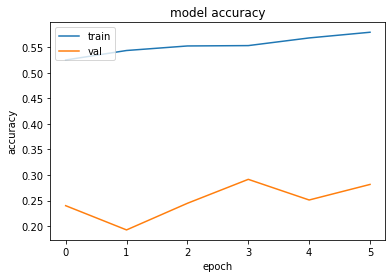

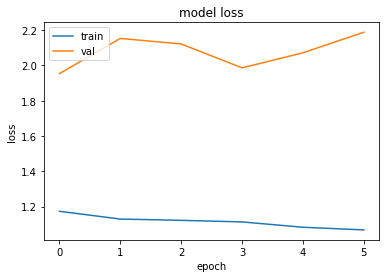

In [ ]:
history1_st = new_model_st1.fit(X1_st_sm, y1_st_df_sm, validation_data = (X_val_st_sm,y_val_st_sm),
               epochs=50,batch_size=64, callbacks =[cp_st1,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history1_st.history['categorical_accuracy'])
plt.plot(history1_st.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1_st.history['loss'])
plt.plot(history1_st.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### 2.objective : False Negative

In [ ]:
def build_model_st2(hp):
  model_st2 = Sequential()
  model_st2.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model_st2.add(Dense(units=hp_units1, activation= LeakyReLU))
  model_st2.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model_st2.add(BatchNormalization())
  model_st2.add(Dense(units=hp_units2, activation= LeakyReLU))
  model_st2.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model_st2.add(BatchNormalization())
  model_st2.add(Dense(units=hp_units3, activation= LeakyReLU))
  model_st2.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model_st2.add(BatchNormalization())
  model_st2.add(Dense(6, activation='softmax'))

  hp_optimizer_st=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_st == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_st', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_st == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_st', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model_st2.compile(
      optimizer= hp_optimizer_st,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.FalseNegatives(name='false_negatives'),
               'categorical_accuracy']
  )
  return model_st2

# HyperBand algorithm from keras tuner
tuner_st2 = kt.Hyperband(
    build_model_st2,
    objective= kt.Objective('val_false_negatives', direction="min"),
    max_epochs=50,
    directory='st_dir2',
    project_name='stlucie2',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner_st2.search(X1_st_sm, y1_st_df_sm, epochs=50, validation_data = (X_val_st_sm,y_val_st_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 01m 31s]
val_false_negatives: 1566.0

Best val_false_negatives So Far: 1332.0
Total elapsed time: 00h 55m 50s


In [ ]:
best_mlp_hyperparameters_st2 = tuner_st2.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters_st2.values

Best Hyper-parameters


{'units1': 416,
 'units2': 480,
 'units3': 192,
 'dropout_1': 0.0,
 'dropout_2': 0.0,
 'dropout_3': 0.2,
 'Optimizer': 'SGD',
 'learning_rate_st': 0.1,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0068'}

In [ ]:
best_model_st2 = tuner_st2.get_best_models()[0]
best_model_st2.build(X1_st_sm.shape)
best_model_st2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (24072, 49)              196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (24072, 416)              20800     
                                                                 
 dropout (Dropout)           (24072, 416)              0         
                                                                 
 batch_normalization_1 (Batc  (24072, 416)             1664      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (24072, 480)              200160    
                                                                 
 dropout_1 (Dropout)         (24072, 480)              0

In [ ]:
new_model_st2 = Sequential()
new_model_st2.add(tf.keras.Input(shape=(49,)))
new_model_st2.add(BatchNormalization())
new_model_st2.add(Dense(416, activation = LeakyReLU))
new_model_st2.add(BatchNormalization())
new_model_st2.add(Dense(480, activation = LeakyReLU))
new_model_st2.add(BatchNormalization())
new_model_st2.add(Dense(192, activation = LeakyReLU))
new_model_st2.add(Dropout(0.2))
new_model_st2.add(BatchNormalization())
new_model_st2.add((Dense(6, activation='softmax')))
new_model_st2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_20 (Bat  (None, 49)               196       
 chNormalization)                                                
                                                                 
 dense_20 (Dense)            (None, 416)               20800     
                                                                 
 batch_normalization_21 (Bat  (None, 416)              1664      
 chNormalization)                                                
                                                                 
 dense_21 (Dense)            (None, 480)               200160    
                                                                 
 batch_normalization_22 (Bat  (None, 480)              1920      
 chNormalization)                                                
                                                      

In [ ]:
cp_st2 = ModelCheckpoint('new_model_st2/', save_best_only=True)
opt_st2 = keras.optimizers.SGD(learning_rate=0.1)
new_model_st2.compile(optimizer = opt_st2, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_st2.fit(X1_st_sm, y1_st_df_sm, validation_data = (X_val_st_sm,y_val_st_sm),
               epochs=50,batch_size=64, callbacks =[cp_st2,early_stopping_monitor])

Epoch 1/50
377/377 [==============================] - ETA: 0s - loss: 1.5683 - categorical_accuracy: 0.3795

377/377 [==============================] - 13s 29ms/step - loss: 1.5683 - categorical_accuracy: 0.3795 - val_loss: 3.4394 - val_categorical_accuracy: 0.2477
Epoch 2/50
376/377 [============================>.] - ETA: 0s - loss: 1.3690 - categorical_accuracy: 0.4546

377/377 [==============================] - 11s 29ms/step - loss: 1.3691 - categorical_accuracy: 0.4546 - val_loss: 2.4431 - val_categorical_accuracy: 0.1809
Epoch 3/50
377/377 [==============================] - 7s 19ms/step - loss: 1.2892 - categorical_accuracy: 0.4854 - val_loss: 4.2395 - val_categorical_accuracy: 0.1633
Epoch 4/50
372/377 [============================>.] - ETA: 0s - loss: 1.2583 - categorical_accuracy: 0.5002

377/377 [==============================] - 8s 22ms/step - loss: 1.2591 - categorical_accuracy: 0.4997 - val_loss: 2.1741 - val_categorical_accuracy: 0.2687
Epoch 5/50
377/377 [==============================] - 4s 12ms/step - loss: 1.1967 - categorical_accuracy: 0.5188 - val_loss: 2.2350 - val_categorical_accuracy: 0.3285
Epoch 6/50
377/377 [==============================] - 4s 12ms/step - loss: 1.1604 - categorical_accuracy: 0.5375 - val_loss: 2.6264 - val_categorical_accuracy: 0.1973
Epoch 7/50
377/377 [==============================] - 5s 13ms/step - loss: 1.1219 - categorical_accuracy: 0.5540 - val_loss: 2.3485 - val_categorical_accuracy: 0.2693
Epoch 8/50
377/377 [==============================] - 6s 15ms/step - loss: 1.0891 - categorical_accuracy: 0.5674 - val_loss: 5.2819 - val_categorical_accuracy: 0.2037
Epoch 9/50
377/377 [==============================] - 4s 12ms/step - loss: 1.0900 - categorical_accuracy: 0.5684 - val_loss: 4.3613 - val_categorical_accuracy: 0.1645


In [ ]:
test_predictions_st2 = new_model_st2.predict(X_test_st)
test_predictions_st2

23/23 [==============================] - 0s 4ms/step


array([[1.8995218e-01, 1.6020011e-02, 5.6272730e-02, 5.8963251e-01,
        1.4812262e-01, 8.9827418e-10],
       [2.2061724e-02, 3.0355507e-03, 1.5713589e-02, 9.4992781e-01,
        9.2612011e-03, 2.5456748e-12],
       [6.0638148e-01, 4.3537728e-02, 5.8762979e-02, 2.8192616e-01,
        9.3911299e-03, 4.8147689e-07],
       ...,
       [9.7553170e-01, 4.2007682e-03, 1.2963323e-03, 1.8835148e-02,
        1.3600530e-04, 1.9039266e-20],
       [9.8506933e-01, 1.0338023e-02, 3.0364415e-03, 1.5044619e-03,
        5.1687995e-05, 1.7984746e-15],
       [9.5508128e-01, 3.4175012e-02, 4.4617527e-03, 6.2546935e-03,
        2.7267175e-05, 1.9758629e-13]], dtype=float32)

In [ ]:
classes_st2 = np.argmax(test_predictions_st2, axis=-1)
classes_st2

array([3, 3, 0, 0, 3, 3, 4, 0, 3, 0, 0, 4, 3, 0, 0, 0, 3, 3, 0, 0, 3, 0,
       0, 3, 0, 0, 0, 3, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       3, 3, 3, 3, 3, 3, 2, 3, 3, 1, 4, 2, 2, 3, 3, 3, 3, 0, 2, 3, 3, 3,
       4, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 4, 1, 3, 3, 3, 2, 3, 3, 3, 1, 2,
       2, 3, 3, 3, 2, 2, 4, 3, 4, 4, 2, 0, 2, 2, 2, 5, 3, 3, 1, 4, 0, 2,
       3, 3, 2, 2, 2, 5, 1, 3, 1, 5, 1, 4, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5,
       5, 5, 3, 1, 1, 5, 5, 5, 5, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 0, 3, 0, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       0, 0, 0, 0, 0, 0, 5, 0, 5, 0, 5, 5, 5, 0, 5, 5, 5, 5, 5, 5, 0, 0,
       0, 0, 0, 0, 5, 0, 0, 5, 5, 5, 0, 0, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0,
       0, 0, 5, 0, 3, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0,

In [ ]:
classes_st2 =pd.DataFrame(classes_st2, columns=['Test Predictions']) 
classes_st2

Test Predictions
0                   3
1                   3
2                   0
3                   0
4                   3
..                ...
726                 0
727                 0
728                 0
729                 0
730                 0

[731 rows x 1 columns]

In [ ]:
classes_st2 = classes_st2.values.ravel()

In [ ]:
result_st2 = pd.DataFrame({'Test Predictions':classes_st2, 'Actuals':y_test_st})
result_st2[0:31]

Test Predictions  Actuals
0                  3        2
1                  3        2
2                  0        2
3                  0        2
4                  3        2
5                  3        2
6                  4        2
7                  0        2
8                  3        2
9                  0        2
10                 0        2
11                 4        2
12                 3        2
13                 0        3
14                 0        3
15                 0        3
16                 3        3
17                 3        3
18                 0        3
19                 0        3
20                 3        3
21                 0        3
22                 0        3
23                 3        2
24                 0        2
25                 0        2
26                 0        2
27                 3        2
28                 0        2
29                 3        2
30                 0        2

######model 2 evaluation

In [ ]:
print(classification_report(y_test_st, classes_st2, labels=np.unique(y_test_st)))

              precision    recall  f1-score   support

           0       0.81      0.25      0.38       574
           1       0.23      0.08      0.12        90
           2       0.06      0.05      0.06        57
           3       0.02      0.30      0.04        10

   micro avg       0.39      0.21      0.28       731
   macro avg       0.28      0.17      0.15       731
weighted avg       0.67      0.21      0.32       731



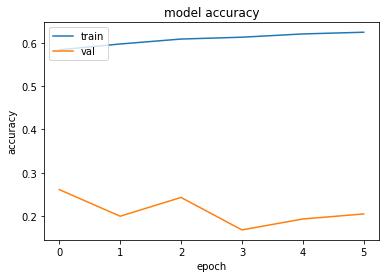

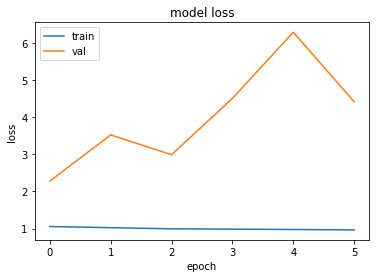

In [ ]:
history2_st = new_model_st2.fit(X1_st_sm, y1_st_df_sm, validation_data = (X_val_st_sm,y_val_st_sm),
               epochs=50,batch_size=64, callbacks =[cp_st2,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history2_st.history['categorical_accuracy'])
plt.plot(history2_st.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2_st.history['loss'])
plt.plot(history2_st.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### 3.objective : f1 macro

In [ ]:
def build_model_st3(hp):
  model_st3 = Sequential()
  model_st3.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model_st3.add(Dense(units=hp_units1, activation= LeakyReLU))
  model_st3.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model_st3.add(BatchNormalization())
  model_st3.add(Dense(units=hp_units2, activation= LeakyReLU))
  model_st3.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model_st3.add(BatchNormalization())
  model_st3.add(Dense(units=hp_units3, activation= LeakyReLU))
  model_st3.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model_st3.add(BatchNormalization())
  model_st3.add(Dense(6, activation='softmax'))

  hp_optimizer_st=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_st == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_st', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_st == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_st', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model_st3.compile(
      optimizer= hp_optimizer_st,
      loss='categorical_crossentropy',
      metrics=[tfa.metrics.F1Score(num_classes=6, average='macro',name='f1'),'categorical_accuracy']
  )
  return model_st3

# HyperBand algorithm from keras tuner
tuner_st3 = kt.Hyperband(
    build_model_st3,
    objective= kt.Objective("val_f1", direction="max"),
    max_epochs=50,
    directory='st_dir3',
    project_name='stlucie3',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner_st3.search(X1_st_sm, y1_st_df_sm, epochs=50, validation_data = (X_val_st_sm,y_val_st_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 00m 27s]
val_f1: 0.20628994703292847

Best val_f1 So Far: 0.26291486620903015
Total elapsed time: 00h 45m 51s


In [ ]:
best_mlp_hyperparameters_st3 = tuner_st3.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters_st3.values

Best Hyper-parameters


{'units1': 192,
 'units2': 128,
 'units3': 480,
 'dropout_1': 0.2,
 'dropout_2': 0.0,
 'dropout_3': 0.2,
 'Optimizer': 'Adam',
 'learning_rate_st': 0.01,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0077'}

In [ ]:
best_model_st3 = tuner_st3.get_best_models()[0]
best_model_st3.build(X1_st_sm.shape)
best_model_st3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (24072, 49)              196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (24072, 192)              9600      
                                                                 
 dropout (Dropout)           (24072, 192)              0         
                                                                 
 batch_normalization_1 (Batc  (24072, 192)             768       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (24072, 128)              24704     
                                                                 
 dropout_1 (Dropout)         (24072, 128)              0

In [ ]:
new_model_st3 = Sequential()
new_model_st3.add(tf.keras.Input(shape=(49,)))
new_model_st3.add(BatchNormalization())
new_model_st3.add(Dense(192, activation = LeakyReLU))
new_model_st3.add(Dropout(0.2))
new_model_st3.add(BatchNormalization())
new_model_st3.add(Dense(128, activation = LeakyReLU))
new_model_st3.add(BatchNormalization())
new_model_st3.add(Dense(480, activation = LeakyReLU))
new_model_st3.add(Dropout(0.2))
new_model_st3.add(BatchNormalization())
new_model_st3.add((Dense(6, activation='softmax')))
new_model_st3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_24 (Bat  (None, 49)               196       
 chNormalization)                                                
                                                                 
 dense_24 (Dense)            (None, 192)               9600      
                                                                 
 dropout_9 (Dropout)         (None, 192)               0         
                                                                 
 batch_normalization_25 (Bat  (None, 192)              768       
 chNormalization)                                                
                                                                 
 dense_25 (Dense)            (None, 128)               24704     
                                                                 
 batch_normalization_26 (Bat  (None, 128)             

In [ ]:
cp_st3 = ModelCheckpoint('new_model_st3/', save_best_only=True)
opt_st3 = keras.optimizers.Adam(learning_rate=0.01)
new_model_st3.compile(optimizer = opt_st3, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_st3.fit(X1_st_sm, y1_st_df_sm, validation_data = (X_val_st_sm,y_val_st_sm),
               epochs=50,batch_size=64, callbacks =[cp_st3,early_stopping_monitor])

Epoch 1/50
377/377 [==============================] - ETA: 0s - loss: 1.7236 - categorical_accuracy: 0.3384

377/377 [==============================] - 9s 18ms/step - loss: 1.7236 - categorical_accuracy: 0.3384 - val_loss: 3.0103 - val_categorical_accuracy: 0.2500
Epoch 2/50
374/377 [============================>.] - ETA: 0s - loss: 1.4579 - categorical_accuracy: 0.4094

377/377 [==============================] - 6s 17ms/step - loss: 1.4587 - categorical_accuracy: 0.4094 - val_loss: 1.5576 - val_categorical_accuracy: 0.4157
Epoch 3/50
377/377 [==============================] - ETA: 0s - loss: 1.3841 - categorical_accuracy: 0.4349

377/377 [==============================] - 6s 16ms/step - loss: 1.3841 - categorical_accuracy: 0.4349 - val_loss: 1.5462 - val_categorical_accuracy: 0.3150
Epoch 4/50
377/377 [==============================] - 4s 10ms/step - loss: 1.3390 - categorical_accuracy: 0.4556 - val_loss: 1.8282 - val_categorical_accuracy: 0.1915
Epoch 5/50
377/377 [==============================] - 3s 9ms/step - loss: 1.3206 - categorical_accuracy: 0.4613 - val_loss: 1.7815 - val_categorical_accuracy: 0.3009
Epoch 6/50
377/377 [==============================] - 5s 12ms/step - loss: 1.2975 - categorical_accuracy: 0.4720 - val_loss: 1.6774 - val_categorical_accuracy: 0.2336
Epoch 7/50
377/377 [==============================] - 4s 11ms/step - loss: 1.2782 - categorical_accuracy: 0.4816 - val_loss: 1.6519 - val_categorical_accuracy: 0.2629
Epoch 8/50
377/377 [==============================] - 4s 9ms/step - loss: 1.2671 - categorical_accuracy: 0.4862 - val_loss: 1.7279 - val_categorical_accuracy: 0.2933


In [ ]:
test_predictions_st3 = new_model_st3.predict(X_test_st)
test_predictions_st3

23/23 [==============================] - 0s 3ms/step


array([[3.44365060e-01, 9.67648551e-02, 8.18662345e-02, 3.03916216e-01,
        1.72904477e-01, 1.83127035e-04],
       [2.79803693e-01, 1.61238611e-01, 2.26824448e-01, 1.46155179e-01,
        1.85717225e-01, 2.60852335e-04],
       [4.30721194e-01, 1.39928922e-01, 4.85310219e-02, 2.77142733e-01,
        1.02354884e-01, 1.32120575e-03],
       ...,
       [8.48459005e-01, 3.20099406e-02, 6.12151902e-03, 6.73201829e-02,
        4.60872278e-02, 2.10606686e-06],
       [8.64970744e-01, 5.02492636e-02, 1.48338145e-02, 4.93683144e-02,
        2.05699299e-02, 8.08271034e-06],
       [9.31675196e-01, 2.73244008e-02, 9.15325899e-03, 2.56988499e-02,
        6.14646170e-03, 1.91690333e-06]], dtype=float32)

In [ ]:
classes_st3 = np.argmax(test_predictions_st3, axis=-1)
classes_st3

array([0, 0, 0, 3, 2, 4, 3, 0, 4, 4, 3, 3, 4, 0, 3, 0, 4, 4, 4, 0, 3, 0,
       0, 0, 3, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       4, 0, 4, 4, 0, 0, 0, 0, 0, 0, 3, 2, 2, 4, 0, 0, 4, 2, 2, 3, 2, 3,
       2, 4, 4, 4, 2, 4, 2, 3, 0, 2, 1, 0, 4, 4, 3, 3, 3, 2, 2, 4, 5, 3,
       2, 2, 2, 4, 2, 2, 4, 3, 3, 3, 2, 0, 2, 3, 3, 2, 3, 3, 4, 4, 3, 4,
       3, 5, 2, 2, 4, 4, 4, 3, 3, 5, 2, 2, 3, 0, 0, 5, 5, 2, 4, 3, 5, 2,
       0, 0, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 3, 4, 4, 3, 5, 3, 5, 3,
       3, 3, 3, 0, 3, 0, 0, 0, 0, 0, 4, 3, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 0, 3, 3, 0, 0, 0, 0, 3, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 3, 0, 3, 0, 0, 0, 3, 3, 0, 3, 3, 0, 0, 0, 0, 0, 3,
       0, 0, 0, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 5, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
classes_st3 =pd.DataFrame(classes_st3, columns=['Test Predictions']) 
classes_st3

Test Predictions
0                   0
1                   0
2                   0
3                   3
4                   2
..                ...
726                 0
727                 0
728                 0
729                 0
730                 0

[731 rows x 1 columns]

In [ ]:
classes_st3 = classes_st3.values.ravel()

In [ ]:
result_st3 = pd.DataFrame({'Test Predictions':classes_st3, 'Actuals':y_test_st})
result_st3[0:31]

Test Predictions  Actuals
0                  0        2
1                  0        2
2                  0        2
3                  3        2
4                  2        2
5                  4        2
6                  3        2
7                  0        2
8                  4        2
9                  4        2
10                 3        2
11                 3        2
12                 4        2
13                 0        3
14                 3        3
15                 0        3
16                 4        3
17                 4        3
18                 4        3
19                 0        3
20                 3        3
21                 0        3
22                 0        3
23                 0        2
24                 3        2
25                 0        2
26                 4        2
27                 0        2
28                 4        2
29                 0        2
30                 0        2

######model 3 evaluation

In [ ]:
print(classification_report(y_test_st, classes_st3, labels=np.unique(y_test_st)))

              precision    recall  f1-score   support

           0       0.90      0.66      0.76       574
           1       0.29      0.02      0.04        90
           2       0.10      0.11      0.10        57
           3       0.02      0.20      0.03        10

   micro avg       0.63      0.53      0.58       731
   macro avg       0.32      0.25      0.23       731
weighted avg       0.75      0.53      0.61       731



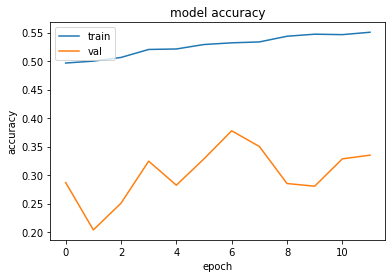

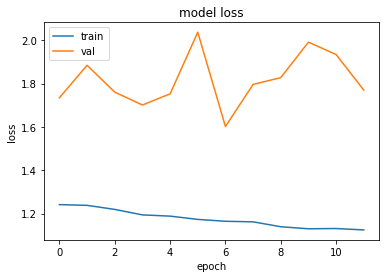

In [ ]:
history3_st = new_model_st3.fit(X1_st_sm, y1_st_df_sm, validation_data = (X_val_st_sm,y_val_st_sm),
               epochs=50,batch_size=64, callbacks =[cp_st3,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history3_st.history['categorical_accuracy'])
plt.plot(history3_st.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history3_st.history['loss'])
plt.plot(history3_st.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

####comparing the models

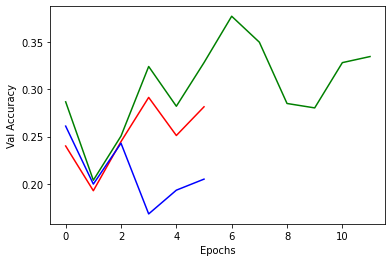

In [ ]:
plt.plot(history1_st.history['val_categorical_accuracy'], 'r', history2_st.history['val_categorical_accuracy'], 'b',
         history3_st.history['val_categorical_accuracy'], 'g')
plt.xlabel('Epochs')
plt.ylabel('Val Accuracy')
plt.show()

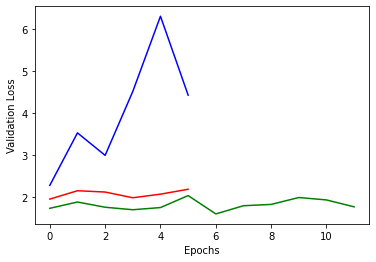

In [ ]:
plt.plot(history1_st.history['val_loss'], 'r', history2_st.history['val_loss'], 'b',
         history3_st.history['val_loss'], 'g')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.show()

###MLP model with weather and soil data (without date variable) REGRESSION

####preprocessing data

In [ ]:
score_st = train_st['score']
score_val_st = val_st['score']
score_test_st = test_st['score']

In [ ]:
score_arr_st = score_st.copy()
score_val_arr_st = score_val_st.copy()
score_test_arr_st = score_test_st.copy()

In [ ]:
score_arr_st = score_arr_st.to_numpy()
score_val_arr_st = score_val_arr_st.to_numpy()
score_test_arr_st = score_test_arr_st.to_numpy()

In [ ]:
score_arr_st =pd.DataFrame(score_arr_st, columns=['Score']) 
score_arr_st

Score
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
...     ...
6205    1.0
6206    1.0
6207    1.0
6208    1.0
6209    1.0

[6210 rows x 1 columns]

In [ ]:
score_val_arr_st =pd.DataFrame(score_val_arr_st, columns=['Score']) 
score_val_arr_st

Score
0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
..     ...
725    2.0
726    2.0
727    2.0
728    2.0
729    2.0

[730 rows x 1 columns]

In [ ]:
score_test_arr_st =pd.DataFrame(score_test_arr_st, columns=['Score']) 
score_test_arr_st

Score
0      2.0
1      2.0
2      2.0
3      2.0
4      2.0
..     ...
726    0.0
727    0.0
728    0.0
729    0.0
730    0.0

[731 rows x 1 columns]

In [ ]:
st_lucie_train = train_st.copy()
st_lucie_val = val_st.copy()
st_lucie_test = test_st.copy()

In [ ]:
X1_st = st_lucie_train.drop(columns=['fips','date','score'])
X_st_val = st_lucie_val.drop(columns=['fips','date','score'])
X_st_test = st_lucie_test.drop(columns=['fips','date','score'])

In [ ]:
X1_st, y1_st = X1_st, score_arr_st
X_val_st, y_val_st = X_st_val, score_val_arr_st
X_test_st, y_test_st = X_st_test, score_test_arr_st
X1_st.shape, y1_st.shape, X_val_st.shape, y_val_st.shape, X_test_st.shape, y_test_st.shape

((6210, 49), (6210, 1), (730, 49), (730, 1), (731, 49), (731, 1))

####build the model

In [ ]:
new_model_reg_st1 = Sequential()
new_model_reg_st1.add(tf.keras.Input(shape=(49,)))
new_model_reg_st1.add(BatchNormalization())
new_model_reg_st1.add(Dense(128, activation = "elu", kernel_initializer="he_normal"))
new_model_reg_st1.add(BatchNormalization())
new_model_reg_st1.add(Dense(64, activation = "elu", kernel_initializer="he_normal"))
new_model_reg_st1.add(BatchNormalization())
new_model_reg_st1.add((Dense(1, activation='linear')))
new_model_reg_st1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_3 (Batc  (None, 49)               196       
 hNormalization)                                                 
                                                                 
 dense_15 (Dense)            (None, 128)               6400      
                                                                 
 batch_normalization_4 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_5 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                      

In [ ]:
opt_reg_st1 = keras.optimizers.Adam(learning_rate=0.001)
new_model_reg_st1.compile(optimizer = opt_reg_st1, loss =MeanSquaredError(), metrics =[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_reg_st1.fit(X1_st, y1_st, validation_data = (X_val_st,y_val_st),
               epochs=50,batch_size=64, callbacks =[early_stopping_monitor])

Epoch 1/50
98/98 [==============================] - 1s 4ms/step - loss: 1.6361 - root_mean_squared_error: 1.2791 - val_loss: 52.6230 - val_root_mean_squared_error: 7.2542
Epoch 2/50
98/98 [==============================] - 0s 3ms/step - loss: 1.3248 - root_mean_squared_error: 1.1510 - val_loss: 24.8588 - val_root_mean_squared_error: 4.9859
Epoch 3/50
98/98 [==============================] - 0s 2ms/step - loss: 1.2913 - root_mean_squared_error: 1.1364 - val_loss: 5.3619 - val_root_mean_squared_error: 2.3156
Epoch 4/50
98/98 [==============================] - 0s 2ms/step - loss: 1.2715 - root_mean_squared_error: 1.1276 - val_loss: 3.6881 - val_root_mean_squared_error: 1.9204
Epoch 5/50
98/98 [==============================] - 0s 3ms/step - loss: 1.2801 - root_mean_squared_error: 1.1314 - val_loss: 1.3448 - val_root_mean_squared_error: 1.1596
Epoch 6/50
98/98 [==============================] - 0s 3ms/step - loss: 1.2497 - root_mean_squared_error: 1.1179 - val_loss: 0.9383 - val_root_mean_

In [ ]:
test_predictions_reg_st1 = new_model_reg_st1.predict(X_test_st).flatten()
test_predictions_reg_st1

23/23 [==============================] - 0s 1ms/step


array([ 0.7086557 ,  0.6004376 ,  0.4530986 ,  0.5556267 ,  1.1074326 ,
        0.9031786 ,  0.85510975,  0.7962303 ,  1.0016836 ,  0.7992782 ,
        0.53876793,  0.83417296,  0.92855084,  0.3325303 ,  0.60564774,
        0.69222444,  1.1131942 ,  0.9142442 ,  0.39832857,  0.09886646,
        0.5393436 ,  0.5952837 ,  0.66162413,  0.03020022,  0.85287476,
        0.6861079 , -0.1930233 ,  0.48995724,  0.92113453,  0.50379974,
        0.33467218,  0.37472466,  0.3725858 ,  0.47149363,  0.37530947,
        0.50725794,  0.5438359 ,  0.50276864,  0.49895856,  0.22626254,
        0.4395475 ,  0.22798684,  0.35561273,  0.46299735,  0.70831966,
        0.3266143 ,  0.9602926 ,  0.51861316,  0.05745286,  0.24560389,
        0.24714497,  0.49752298,  0.6448029 ,  0.35101464,  0.8665844 ,
        0.83346015,  1.3665141 ,  0.9771423 ,  0.47500095,  0.40103337,
        0.8955687 ,  0.84429747,  1.4529413 ,  1.581174  ,  1.1673676 ,
        1.2293177 ,  0.8297107 ,  0.7695696 ,  0.52728766,  0.78

In [ ]:
test_predictions_reg_st1 =pd.DataFrame(test_predictions_reg_st1, columns=['Test Predictions']) 
test_predictions_reg_st1

Test Predictions
0            0.708656
1            0.600438
2            0.453099
3            0.555627
4            1.107433
..                ...
726          0.546069
727          0.196445
728         -0.164524
729          0.017634
730         -0.151862

[731 rows x 1 columns]

In [ ]:
test_predictions_reg_st1 = test_predictions_reg_st1.values.ravel()
y_test_st = y_test_st.values.ravel()

In [ ]:
test_results_reg_st_1 = pd.DataFrame(data={'predictions':test_predictions_reg_st1, 'actuals':y_test_st})
test_results_reg_st_1

predictions  actuals
0       0.708656      2.0
1       0.600438      2.0
2       0.453099      2.0
3       0.555627      2.0
4       1.107433      2.0
..           ...      ...
726     0.546069      0.0
727     0.196445      0.0
728    -0.164524      0.0
729     0.017634      0.0
730    -0.151862      0.0

[731 rows x 2 columns]

In [ ]:
test_results_reg_st_1[500:550]

predictions   actuals
500     0.640666  0.571429
501     0.504375  0.428571
502     1.392712  0.285714
503     0.774908  0.142857
504     1.126838  0.000000
505     1.103403  0.000000
506     1.113724  0.000000
507     0.522358  0.000000
508     0.297809  0.000000
509     0.219238  0.000000
510    -0.815459  0.000000
511     0.033453  0.000000
512     0.554358  0.000000
513     0.420772  0.000000
514     0.441401  0.000000
515     0.433058  0.000000
516     0.491613  0.000000
517     0.704453  0.000000
518     0.677413  0.000000
519     0.408145  0.000000
520     0.429781  0.000000
521     0.395961  0.000000
522     0.022741  0.000000
523    -0.119938  0.000000
524     0.125793  0.000000
525     0.426287  0.000000
526     0.474159  0.000000
527     0.599784  0.000000
528     0.664183  0.000000
529     0.449969  0.000000
530     0.465646  0.000000
531     0.387959  0.000000
532     0.648708  0.000000
533     0.466952  0.000000
534     0.453178  0.000000
535     0.296823  0.000000
536     0.646389  0.000000
537     0.429019  0.000000
538     0.481223  0.000000
539     0.429039  0.000000
540     0.499937  0.000000
541     0.335352  0.000000
542     0.286498  0.000000
543     0.338935  0.000000
544     0.645689  0.000000
545     0.536518  0.000000
546     0.543383  0.000000
547     0.665481  0.000000
548     0.808406  0.000000
549     0.842164  0.000000

####model evaluation

In [ ]:
new_model_reg_st1.evaluate(X1_st,y1_st)

195/195 [==============================] - 0s 1ms/step - loss: 1.1753 - root_mean_squared_error: 1.0841


[1.175254225730896, 1.0840914249420166]

In [ ]:
new_model_reg_st1.evaluate(X_test_st,y_test_st)

23/23 [==============================] - 0s 1ms/step - loss: 0.5235 - root_mean_squared_error: 0.7235


[0.5235015749931335, 0.723534107208252]

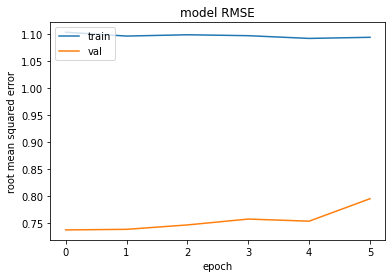

In [ ]:
history_reg_st_1 = new_model_reg_st1.fit(X1_st, y1_st, validation_data = (X_val_st,y_val_st),
               epochs=50,batch_size=64, callbacks =[early_stopping_monitor], verbose=False)

# summarize history for accuracy
plt.plot(history_reg_st_1.history['root_mean_squared_error'])
plt.plot(history_reg_st_1.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_results_reg_st_1.predictions[test_results_reg_st_1.predictions <0.5] = 0
test_results_reg_st_1.predictions[(test_results_reg_st_1.predictions >=0.5)&(test_results_reg_st_1.predictions<1.5)] = 1
test_results_reg_st_1.predictions[(test_results_reg_st_1.predictions >=1.5)&(test_results_reg_st_1.predictions<2.5)] = 2
test_results_reg_st_1.predictions[(test_results_reg_st_1.predictions >=2.5)&(test_results_reg_st_1.predictions<3.5)] = 3
test_results_reg_st_1.predictions[(test_results_reg_st_1.predictions >=3.5)&(test_results_reg_st_1.predictions<4.5)] = 4
test_results_reg_st_1.predictions[(test_results_reg_st_1.predictions >=4.5)&(test_results_reg_st_1.predictions<5.5)] = 5
test_results_reg_st_1.actuals[test_results_reg_st_1.actuals <0.5] = 0
test_results_reg_st_1.actuals[(test_results_reg_st_1.actuals >=0.5)&(test_results_reg_st_1.actuals<1.5)] = 1
test_results_reg_st_1.actuals[(test_results_reg_st_1.actuals >=1.5)&(test_results_reg_st_1.actuals<2.5)] = 2
test_results_reg_st_1.actuals[(test_results_reg_st_1.actuals >=2.5)&(test_results_reg_st_1.actuals<3.5)] = 3
test_results_reg_st_1.actuals[(test_results_reg_st_1.actuals >=3.5)&(test_results_reg_st_1.actuals<4.5)] = 4
test_results_reg_st_1.actuals[(test_results_reg_st_1.actuals >=4.5)&(test_results_reg_st_1.actuals<5.5)] = 5
test_results_reg_st_1

predictions  actuals
0            1.0      2.0
1            1.0      2.0
2            0.0      2.0
3            1.0      2.0
4            1.0      2.0
..           ...      ...
726          1.0      0.0
727          0.0      0.0
728          0.0      0.0
729          0.0      0.0
730          0.0      0.0

[731 rows x 2 columns]

In [ ]:
test_results_reg_st_1[200:250]

predictions  actuals
200          1.0      0.0
201          1.0      0.0
202          1.0      0.0
203          1.0      0.0
204          1.0      0.0
205          1.0      0.0
206          1.0      0.0
207          1.0      0.0
208          0.0      0.0
209          1.0      0.0
210          1.0      0.0
211          1.0      0.0
212          1.0      0.0
213          0.0      0.0
214          0.0      0.0
215          0.0      0.0
216          0.0      0.0
217          0.0      0.0
218          1.0      0.0
219          1.0      0.0
220          1.0      0.0
221          1.0      0.0
222          1.0      0.0
223          1.0      0.0
224          1.0      0.0
225          1.0      0.0
226          1.0      0.0
227          1.0      0.0
228          1.0      0.0
229          1.0      0.0
230          0.0      0.0
231          0.0      0.0
232          0.0      0.0
233          0.0      0.0
234          0.0      0.0
235          0.0      0.0
236          0.0      0.0
237          0.0      0.0
238          1.0      0.0
239          1.0      0.0
240          1.0      0.0
241          0.0      0.0
242          0.0      0.0
243          0.0      0.0
244          0.0      0.0
245          0.0      0.0
246          0.0      0.0
247          0.0      0.0
248          0.0      0.0
249          0.0      0.0

In [ ]:
print(classification_report(test_results_reg_st_1['actuals'], test_results_reg_st_1['predictions']))

              precision    recall  f1-score   support

         0.0       0.91      0.54      0.68       574
         1.0       0.16      0.62      0.26        90
         2.0       0.14      0.11      0.12        57
         3.0       0.00      0.00      0.00        10

    accuracy                           0.51       731
   macro avg       0.30      0.32      0.26       731
weighted avg       0.75      0.51      0.57       731



###LSTM model without weather and soil data, only using previous drought scores

In [ ]:
def df_to_X_y(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 7
X_train_st, y_train_st = df_to_X_y(score_st, WINDOW_SIZE)
X_val1_st, y_val1_st = df_to_X_y(score_val_st, WINDOW_SIZE)
X_test1_st, y_test1_st = df_to_X_y(score_test_st, WINDOW_SIZE)
X_train_st.shape, y_train_st.shape, X_val1_st.shape, y_val1_st.shape, X_test1_st.shape, y_test1_st.shape

((6203, 7, 1), (6203,), (723, 7, 1), (723,), (724, 7, 1), (724,))

In [ ]:
model_1 = Sequential()
model_1.add(InputLayer((7,1)))
model_1.add(LSTM(64))
model_1.add(Dense(8, 'relu'))
model_1.add(Dense(1, 'linear'))

model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

model_1.fit(X_train_st, y_train_st, validation_data=(X_val1_st, y_val1_st), epochs=50, 
           callbacks = [early_stopping_monitor])

Epoch 1/50
194/194 [==============================] - 4s 9ms/step - loss: 1.3802 - root_mean_squared_error: 1.1748 - val_loss: 0.4024 - val_root_mean_squared_error: 0.6344
Epoch 2/50
194/194 [==============================] - 1s 6ms/step - loss: 0.3602 - root_mean_squared_error: 0.6002 - val_loss: 0.0675 - val_root_mean_squared_error: 0.2598
Epoch 3/50
194/194 [==============================] - 1s 6ms/step - loss: 0.1163 - root_mean_squared_error: 0.3410 - val_loss: 0.0569 - val_root_mean_squared_error: 0.2386
Epoch 4/50
194/194 [==============================] - 1s 6ms/step - loss: 0.0737 - root_mean_squared_error: 0.2716 - val_loss: 0.0479 - val_root_mean_squared_error: 0.2189
Epoch 5/50
194/194 [==============================] - 1s 6ms/step - loss: 0.0569 - root_mean_squared_error: 0.2385 - val_loss: 0.0459 - val_root_mean_squared_error: 0.2142
Epoch 6/50
194/194 [==============================] - 1s 6ms/step - loss: 0.0479 - root_mean_squared_error: 0.2189 - val_loss: 0.0386 - val_

####using the model to predict the test dataset

In [ ]:
test_prediction_st_1 = model_1.predict(X_test1_st).flatten()
test_results_st_1 = pd.DataFrame(data={'predictions':test_prediction_st_1, 'actuals':y_test1_st})
test_results_st_1

23/23 [==============================] - 0s 3ms/step


predictions  actuals
0       1.946741      2.0
1       1.946741      2.0
2       1.946741      2.0
3       1.946741      2.0
4       1.946741      2.0
..           ...      ...
719     0.004090      0.0
720     0.004090      0.0
721     0.004090      0.0
722     0.004090      0.0
723     0.004090      0.0

[724 rows x 2 columns]

In [ ]:
test_results_st_1.predictions[test_results_st_1.predictions <0.5] = 0
test_results_st_1.predictions[(test_results_st_1.predictions >=0.5)&(test_results_st_1.predictions<1.5)] = 1
test_results_st_1.predictions[(test_results_st_1.predictions >=1.5)&(test_results_st_1.predictions<2.5)] = 2
test_results_st_1.predictions[(test_results_st_1.predictions >=2.5)&(test_results_st_1.predictions<3.5)] = 3
test_results_st_1.predictions[(test_results_st_1.predictions >=3.5)&(test_results_st_1.predictions<4.5)] = 4
test_results_st_1.predictions[(test_results_st_1.predictions >=4.5)&(test_results_st_1.predictions<5.5)] = 5
test_results_st_1

predictions  actuals
0            2.0      2.0
1            2.0      2.0
2            2.0      2.0
3            2.0      2.0
4            2.0      2.0
..           ...      ...
719          0.0      0.0
720          0.0      0.0
721          0.0      0.0
722          0.0      0.0
723          0.0      0.0

[724 rows x 2 columns]

In [ ]:
test_results_st_1.actuals[test_results_st_1.actuals <0.5] = 0
test_results_st_1.actuals[(test_results_st_1.actuals >=0.5)&(test_results_st_1.actuals<1.5)] = 1
test_results_st_1.actuals[(test_results_st_1.actuals >=1.5)&(test_results_st_1.actuals<2.5)] = 2
test_results_st_1.actuals[(test_results_st_1.actuals >=2.5)&(test_results_st_1.actuals<3.5)] = 3
test_results_st_1.actuals[(test_results_st_1.actuals >=3.5)&(test_results_st_1.actuals<4.5)] = 4
test_results_st_1.actuals[(test_results_st_1.actuals >=4.5)&(test_results_st_1.actuals<5.5)] = 5
test_results_st_1

predictions  actuals
0            2.0      2.0
1            2.0      2.0
2            2.0      2.0
3            2.0      2.0
4            2.0      2.0
..           ...      ...
719          0.0      0.0
720          0.0      0.0
721          0.0      0.0
722          0.0      0.0
723          0.0      0.0

[724 rows x 2 columns]

####model evaluation

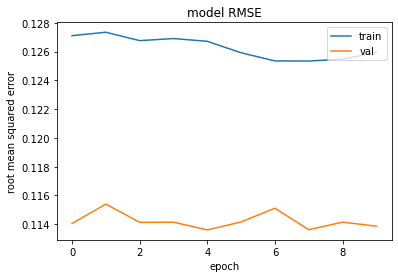

In [ ]:
history_st_1 = model_1.fit(X_train_st, y_train_st, validation_data=(X_val1_st, y_val1_st), epochs=50, 
           callbacks = [early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history_st_1.history['root_mean_squared_error'])
plt.plot(history_st_1.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
print(classification_report(test_results_st_1['actuals'], test_results_st_1['predictions']))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       574
         1.0       0.96      0.96      0.96        90
         2.0       0.94      0.96      0.95        50
         3.0       0.90      0.90      0.90        10

    accuracy                           0.99       724
   macro avg       0.95      0.95      0.95       724
weighted avg       0.99      0.99      0.99       724



###LSTM model with only score data and time data but the time data is transformed using sine and cosine

####train

In [ ]:
train_st1 = train_st.copy()
train_st1.index = pd.to_datetime(train_st1['date'], format='%Y.%m.%d')
train_st1[:31]

fips        date  PRECTOT      PS   QV2M    T2M  T2MDEW  T2MWET  \
date                                                                           
2000-01-01  12111  2000-01-01     0.00  102.21  11.96  21.32   17.08   17.08   
2000-01-02  12111  2000-01-02     0.01  102.24  11.92  21.16   17.07   17.07   
2000-01-03  12111  2000-01-03     0.26  102.05  12.97  22.05   18.35   18.35   
2000-01-04  12111  2000-01-04     1.33  101.91  14.46  22.74   20.07   20.07   
2000-01-05  12111  2000-01-05     1.91  102.07  11.93  20.08   16.88   16.88   
2000-01-06  12111  2000-01-06     7.27  102.29  13.70  22.23   19.24   19.24   
2000-01-07  12111  2000-01-07     2.31  102.32  13.91  22.57   19.52   19.52   
2000-01-08  12111  2000-01-08     0.15  102.17  13.19  22.14   18.66   18.66   
2000-01-09  12111  2000-01-09     0.28  101.94  13.59  22.36   19.08   19.08   
2000-01-10  12111  2000-01-10     0.69  101.76  14.28  22.64   19.84   19.84   
2000-01-11  12111  2000-01-11     0.54  102.03  11.81  21.10   16.34   16.34   
2000-01-12  12111  2000-01-12     0.00  102.28   9.86  20.63   13.95   13.95   
2000-01-13  12111  2000-01-13     0.09  102.28   9.88  21.28   14.13   14.13   
2000-01-14  12111  2000-01-14     0.18  102.74   8.72  17.45   12.01   12.02   
2000-01-15  12111  2000-01-15     0.39  103.25   7.95  16.92   10.91   10.91   
2000-01-16  12111  2000-01-16     0.01  102.98   8.47  18.06   11.89   11.89   
2000-01-17  12111  2000-01-17     0.04  102.50   8.60  17.48   11.93   11.93   
2000-01-18  12111  2000-01-18     0.60  102.05  10.45  18.60   14.95   14.95   
2000-01-19  12111  2000-01-19     0.25  101.63  11.91  19.31   16.94   16.94   
2000-01-20  12111  2000-01-20     0.47  101.16  11.65  20.03   16.37   16.37   
2000-01-21  12111  2000-01-21     0.00  101.74   6.84  13.72    8.06    8.07   
2000-01-22  12111  2000-01-22     0.38  102.02   8.49  16.47   11.58   11.58   
2000-01-23  12111  2000-01-23     0.04  101.75  11.25  19.73   16.01   16.01   
2000-01-24  12111  2000-01-24    27.14  100.74  11.63  18.66   15.94   15.94   
2000-01-25  12111  2000-01-25     0.01  101.12   6.66  12.19    7.86    7.86   
2000-01-26  12111  2000-01-26     0.00  101.68   5.38   9.92    4.56    4.58   
2000-01-27  12111  2000-01-27     0.00  102.30   5.81  11.03    5.51    5.53   
2000-01-28  12111  2000-01-28     0.85  102.39   9.79  17.73   13.95   13.95   
2000-01-29  12111  2000-01-29     2.42  102.29  11.72  20.10   16.79   16.79   
2000-01-30  12111  2000-01-30     1.30  102.17  12.52  20.73   17.82   17.82   
2000-01-31  12111  2000-01-31     0.38  102.01  10.88  17.71   15.40   15.41   

            T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                          
2000-01-01    24.01    19.17       4.83  21.41   3.44       4.23       2.62   
2000-01-02    23.65    19.52       4.12  21.51   4.00       4.63       3.40   
2000-01-03    24.71    19.94       4.77  22.10   4.33       5.14       3.68   
2000-01-04    25.26    20.93       4.33  22.80   4.80       5.87       3.79   
2000-01-05    21.87    17.70       4.17  21.44   5.80       6.63       4.54   
2000-01-06    24.42    20.09       4.33  22.39   5.45       6.50       4.76   
2000-01-07    24.75    20.94       3.81  23.03   3.52       5.05       2.48   
2000-01-08    24.44    20.39       4.04  22.77   2.95       3.43       2.41   
2000-01-09    25.02    20.32       4.70  22.51   3.58       4.56       2.62   
2000-01-10    25.62    20.66       4.95  22.80   5.26       7.25       4.15   
2000-01-11    23.97    19.38       4.59  21.64   4.14       5.44       2.11   
2000-01-12    24.08    17.60       6.48  20.66   3.55       4.16       2.56   
2000-01-13    24.01    18.99       5.02  20.97   1.60       3.98       0.40   
2000-01-14    18.94    15.21       3.74  19.84  11.09      14.03       4.60   
2000-01-15    18.55    15.38       3.17  19.33   9.11      11.00       7.03   
2000-01-16    20.30    16.66 

In [ ]:
scorest = train_st1['score']
scorest_df = pd.DataFrame({'score':scorest})
scorest_df['Seconds'] = scorest_df.index.map(pd.Timestamp.timestamp)
scorest_df

score       Seconds
date                           
2000-01-01    0.0  9.466848e+08
2000-01-02    0.0  9.467712e+08
2000-01-03    0.0  9.468576e+08
2000-01-04    0.0  9.469440e+08
2000-01-05    0.0  9.470304e+08
...           ...           ...
2016-12-27    1.0  1.482797e+09
2016-12-28    1.0  1.482883e+09
2016-12-29    1.0  1.482970e+09
2016-12-30    1.0  1.483056e+09
2016-12-31    1.0  1.483142e+09

[6210 rows x 2 columns]

In [ ]:
day = 60*60*24
month = 30.437*day
year = 365.2425*day

scorest_df['Day sin'] = np.sin(scorest_df['Seconds'] * (2* np.pi / day))
scorest_df['Day cos'] = np.cos(scorest_df['Seconds'] * (2 * np.pi / day))
scorest_df['Month sin'] = np.sin(scorest_df['Seconds'] * (2* np.pi / month))
scorest_df['Month cos'] = np.cos(scorest_df['Seconds'] * (2 * np.pi / month))
scorest_df['Year sin'] = np.sin(scorest_df['Seconds'] * (2 * np.pi / year))
scorest_df['Year cos'] = np.cos(scorest_df['Seconds'] * (2 * np.pi / year))
scorest_df.head()

score      Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                          
2000-01-01    0.0  946684800.0 -5.461913e-12      1.0  -0.066010   0.997819   
2000-01-02    0.0  946771200.0 -1.163374e-12      1.0   0.139914   0.990164   
2000-01-03    0.0  946857600.0  3.135164e-12      1.0   0.339896   0.940463   
2000-01-04    0.0  946944000.0 -7.118212e-12      1.0   0.525446   0.850827   
2000-01-05    0.0  947030400.0 -2.819674e-12      1.0   0.688683   0.725062   

            Year sin  Year cos  
date                            
2000-01-01 -0.004731  0.999989  
2000-01-02  0.012472  0.999922  
2000-01-03  0.029670  0.999560  
2000-01-04  0.046860  0.998901  
2000-01-05  0.064036  0.997948

In [ ]:
scorest_df = scorest_df.drop('Seconds', axis=1)
scorest_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2000-01-01    0.0 -5.461913e-12      1.0  -0.066010   0.997819 -0.004731   
2000-01-02    0.0 -1.163374e-12      1.0   0.139914   0.990164  0.012472   
2000-01-03    0.0  3.135164e-12      1.0   0.339896   0.940463  0.029670   
2000-01-04    0.0 -7.118212e-12      1.0   0.525446   0.850827  0.046860   
2000-01-05    0.0 -2.819674e-12      1.0   0.688683   0.725062  0.064036   

            Year cos  
date                  
2000-01-01  0.999989  
2000-01-02  0.999922  
2000-01-03  0.999560  
2000-01-04  0.998901  
2000-01-05  0.997948

####val

In [ ]:
val_st1 = val_st.copy()
val_st1.index = pd.to_datetime(val_st1['date'], format='%Y.%m.%d')
val_st1[:31]

fips        date  PRECTOT      PS   QV2M    T2M  T2MDEW  T2MWET  \
date                                                                           
2017-01-01  12111  2017-01-01     0.03  102.11  13.42  22.89   18.85   18.85   
2017-01-02  12111  2017-01-02     0.93  102.03  15.74  24.18   21.45   21.45   
2017-01-03  12111  2017-01-03     1.34  101.51  16.18  24.83   21.80   21.80   
2017-01-04  12111  2017-01-04     3.04  101.12  14.76  23.66   20.09   20.09   
2017-01-05  12111  2017-01-05     0.04  101.26  10.80  20.72   15.33   15.33   
2017-01-06  12111  2017-01-06     0.92  101.50  12.94  21.77   18.05   18.05   
2017-01-07  12111  2017-01-07     4.21  101.70  13.43  20.78   18.09   18.09   
2017-01-08  12111  2017-01-08     0.07  102.89   7.48  15.14    9.71    9.72   
2017-01-09  12111  2017-01-09     0.11  103.10   8.07  17.84   11.04   11.04   
2017-01-10  12111  2017-01-10     0.55  102.76   9.24  19.66   13.13   13.13   
2017-01-11  12111  2017-01-11     0.51  102.57  10.51  20.94   15.12   15.12   
2017-01-12  12111  2017-01-12     0.26  102.55  11.78  21.95   16.89   16.89   
2017-01-13  12111  2017-01-13     0.76  102.74  12.34  22.41   17.68   17.68   
2017-01-14  12111  2017-01-14     0.30  102.64  11.64  22.13   16.73   16.73   
2017-01-15  12111  2017-01-15     0.08  102.33  10.90  22.30   15.65   15.65   
2017-01-16  12111  2017-01-16     0.10  102.30  11.60  22.46   16.63   16.63   
2017-01-17  12111  2017-01-17     0.04  102.24  12.19  22.90   17.41   17.41   
2017-01-18  12111  2017-01-18     0.01  102.03  11.73  22.63   16.77   16.77   
2017-01-19  12111  2017-01-19     0.02  101.64  11.94  22.25   16.97   16.97   
2017-01-20  12111  2017-01-20     0.23  101.47  12.11  22.07   17.10   17.10   
2017-01-21  12111  2017-01-21     0.14  101.31  13.36  22.81   18.66   18.66   
2017-01-22  12111  2017-01-22     3.23  100.62  15.40  24.64   20.85   20.85   
2017-01-23  12111  2017-01-23     9.61  100.19  11.68  21.26   16.19   16.19   
2017-01-24  12111  2017-01-24     0.00  101.11   9.33  19.50   12.97   12.97   
2017-01-25  12111  2017-01-25     0.02  101.56   9.77  19.50   13.77   13.77   
2017-01-26  12111  2017-01-26     0.06  101.64  13.16  22.09   18.52   18.52   
2017-01-27  12111  2017-01-27     0.55  101.65  10.79  20.32   14.75   14.75   
2017-01-28  12111  2017-01-28     0.01  101.85   6.28  15.93    6.79    6.81   
2017-01-29  12111  2017-01-29    12.94  101.95   8.20  13.97   10.94   10.95   
2017-01-30  12111  2017-01-30     0.01  102.14   7.00  15.45    8.27    8.29   
2017-01-31  12111  2017-01-31     0.00  102.32   5.72  16.62    5.80    5.82   

            T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                          
2017-01-01    26.09    19.98       6.11  23.09   5.18       6.37       4.45   
2017-01-02    26.66    22.33       4.33  24.34   5.54       7.14       4.45   
2017-01-03    27.56    23.01       4.55  24.89   4.71       6.24       2.79   
2017-01-04    26.61    19.85       6.75  24.22   5.05       5.86       4.13   
2017-01-05    24.32    17.34       6.98  22.33   3.52       4.87       2.24   
2017-01-06    25.43    17.69       7.74  22.96   3.09       6.01       0.76   
2017-01-07    25.41    13.79      11.62  22.45   8.65      10.94       6.50   
2017-01-08    16.92    13.08       3.84  19.31  10.12      11.34       7.44   
2017-01-09    19.82    15.99       3.83  20.39   6.86       7.43       6.25   
2017-01-10    21.85    17.80       4.05  20.96   5.76       6.76       4.99   
2017-01-11    23.01    18.96       4.04  21.73   5.50       6.29       4.84   
2017-01-12    24.41    19.98       4.42  22.58   5.45       6.19       4.98   
2017-01-13    24.66    21.12       3.54  22.91   5.74       6.84       4.99   
2017-01-14    24.19    20.86       3.33  22.68   5.60       6.52       4.72   
2017-01-15    24.60    20.61       3.99  22.82   4.70       5.69       3.96   
2017-01-16    24.89    20.54 

In [ ]:
scorest_val = val_st1['score']
scorest_val_df = pd.DataFrame({'score':scorest_val})
scorest_val_df['Seconds'] = scorest_val_df.index.map(pd.Timestamp.timestamp)
scorest_val_df

score       Seconds
date                           
2017-01-01    1.0  1.483229e+09
2017-01-02    1.0  1.483315e+09
2017-01-03    1.0  1.483402e+09
2017-01-04    1.0  1.483488e+09
2017-01-05    1.0  1.483574e+09
...           ...           ...
2018-12-27    2.0  1.545869e+09
2018-12-28    2.0  1.545955e+09
2018-12-29    2.0  1.546042e+09
2018-12-30    2.0  1.546128e+09
2018-12-31    2.0  1.546214e+09

[730 rows x 2 columns]

In [ ]:
scorest_val_df['Day sin'] = np.sin(scorest_val_df['Seconds'] * (2* np.pi / day))
scorest_val_df['Day cos'] = np.cos(scorest_val_df['Seconds'] * (2 * np.pi / day))
scorest_val_df['Month sin'] = np.sin(scorest_val_df['Seconds'] * (2* np.pi / month))
scorest_val_df['Month cos'] = np.cos(scorest_val_df['Seconds'] * (2 * np.pi / month))
scorest_val_df['Year sin'] = np.sin(scorest_val_df['Seconds'] * (2 * np.pi / year))
scorest_val_df['Year cos'] = np.cos(scorest_val_df['Seconds'] * (2 * np.pi / year))
scorest_val_df.head()

score       Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                           
2017-01-01    1.0  1.483229e+09  2.504006e-13      1.0   0.109601   0.993976   
2017-01-02    1.0  1.483315e+09 -1.000298e-11      1.0   0.311009   0.950407   
2017-01-03    1.0  1.483402e+09 -5.704437e-12      1.0   0.499210   0.866481   
2017-01-04    1.0  1.483488e+09 -1.405899e-12      1.0   0.666213   0.745761   
2017-01-05    1.0  1.483574e+09 -1.165928e-11      1.0   0.804927   0.593374   

            Year sin  Year cos  
date                            
2017-01-01  0.010364  0.999946  
2017-01-02  0.027564  0.999620  
2017-01-03  0.044755  0.998998  
2017-01-04  0.061933  0.998080  
2017-01-05  0.079093  0.996867

In [ ]:
scorest_val_df = scorest_val_df.drop('Seconds', axis=1)
scorest_val_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2017-01-01    1.0  2.504006e-13      1.0   0.109601   0.993976  0.010364   
2017-01-02    1.0 -1.000298e-11      1.0   0.311009   0.950407  0.027564   
2017-01-03    1.0 -5.704437e-12      1.0   0.499210   0.866481  0.044755   
2017-01-04    1.0 -1.405899e-12      1.0   0.666213   0.745761  0.061933   
2017-01-05    1.0 -1.165928e-11      1.0   0.804927   0.593374  0.079093   

            Year cos  
date                  
2017-01-01  0.999946  
2017-01-02  0.999620  
2017-01-03  0.998998  
2017-01-04  0.998080  
2017-01-05  0.996867

####test

In [ ]:
test_st1 = test_st.copy()
test_st1.index = pd.to_datetime(test_st1['date'], format='%Y.%m.%d')
test_st1[:31]

fips        date  PRECTOT      PS   QV2M    T2M  T2MDEW  T2MWET  \
date                                                                           
2019-01-01  12111  2019-01-01     0.25  102.05  14.65  23.97   20.35   20.30   
2019-01-02  12111  2019-01-02     0.00  101.99  13.74  23.92   19.35   19.26   
2019-01-03  12111  2019-01-03     3.47  101.73  15.95  24.33   21.64   21.62   
2019-01-04  12111  2019-01-04     1.24  101.49  15.37  24.58   21.03   20.95   
2019-01-05  12111  2019-01-05     2.18  101.57  11.69  21.12   16.72   16.44   
2019-01-06  12111  2019-01-06     0.00  101.96  10.32  19.44   14.83   14.68   
2019-01-07  12111  2019-01-07     0.09  102.13  11.27  21.93   16.26   16.15   
2019-01-08  12111  2019-01-08     0.10  102.02  10.67  22.64   15.41   15.31   
2019-01-09  12111  2019-01-09     0.00  101.76  10.40  20.29   14.95   14.73   
2019-01-10  12111  2019-01-10     0.01  101.74   7.25  15.53    9.48    8.75   
2019-01-11  12111  2019-01-11     0.09  101.97   9.43  19.35   13.47   13.31   
2019-01-12  12111  2019-01-12     0.15  102.14  10.69  21.38   15.44   15.28   
2019-01-13  12111  2019-01-13     0.67  101.95  12.74  22.58   18.13   18.01   
2019-01-14  12111  2019-01-14     0.11  101.95  11.01  19.29   15.81   15.54   
2019-01-15  12111  2019-01-15     0.00  102.02   8.54  15.99   11.93   11.65   
2019-01-16  12111  2019-01-16     0.00  102.12   8.76  16.55   12.33   11.99   
2019-01-17  12111  2019-01-17     0.03  102.12   9.70  19.67   13.93   13.76   
2019-01-18  12111  2019-01-18     0.02  101.94   9.53  20.35   13.64   13.40   
2019-01-19  12111  2019-01-19     0.02  101.57  11.27  21.47   16.16   16.01   
2019-01-20  12111  2019-01-20     4.74  101.34  10.76  18.62   15.35   14.71   
2019-01-21  12111  2019-01-21     0.00  102.36   7.90  14.95   10.82   10.32   
2019-01-22  12111  2019-01-22     0.20  102.63   9.65  20.29   13.93   13.78   
2019-01-23  12111  2019-01-23     0.67  102.14  11.91  22.50   17.12   16.91   
2019-01-24  12111  2019-01-24    10.15  101.47  15.16  22.84   20.76   20.70   
2019-01-25  12111  2019-01-25     0.95  101.99   8.25  16.35   11.43   10.85   
2019-01-26  12111  2019-01-26    17.78  101.92   9.80  17.38   14.00   13.85   
2019-01-27  12111  2019-01-27    48.76  100.97  13.25  19.71   18.51   18.40   
2019-01-28  12111  2019-01-28     2.30  101.34   8.72  14.52   12.09   11.82   
2019-01-29  12111  2019-01-29     0.03  101.57   7.86  15.90   10.65   10.42   
2019-01-30  12111  2019-01-30     0.56  101.92   8.84  16.61   12.45   12.26   
2019-01-31  12111  2019-01-31     6.20  102.23  10.95  18.91   15.76   15.64   

            T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                          
2019-01-01    26.86    21.82       5.04  24.04   3.48       4.34       2.65   
2019-01-02    26.79    21.79       5.00  23.99   3.65       5.42       1.88   
2019-01-03    27.02    22.15       4.87  24.45   4.48       5.28       3.78   
2019-01-04    27.85    22.43       5.42  24.66   5.68       6.73       4.27   
2019-01-05    24.37    16.69       7.69  22.64   6.04       7.18       4.92   
2019-01-06    23.17    15.89       7.28  21.44   3.61       5.28       2.32   
2019-01-07    24.71    19.78       4.93  22.53   4.00       4.75       3.17   
2019-01-08    25.07    20.86       4.21  22.62   1.66       3.03       0.30   
2019-01-09    23.88    17.09       6.80  21.69   5.33       7.03       2.47   
2019-01-10    18.26    12.89       5.37  18.97   5.87       7.66       4.50   
2019-01-11    22.57    15.63       6.94  20.92   4.83       5.83       3.94   
2019-01-12    24.15    19.06       5.09  21.98   5.27       6.80       3.86   
2019-01-13    26.13    19.82       6.30  22.75   2.56       4.12       0.50   
2019-01-14    22.28    15.59       6.69  21.40   4.67       5.29       3.70   
2019-01-15    18.61    14.20       4.41  19.29   4.92       6.16       4.16   
2019-01-16    20.23    13.62 

In [ ]:
scorest_test = test_st1['score']
scorest_test_df = pd.DataFrame({'score':scorest_test})
scorest_test_df['Seconds'] = scorest_test_df.index.map(pd.Timestamp.timestamp)
scorest_test_df

score       Seconds
date                           
2019-01-01    2.0  1.546301e+09
2019-01-02    2.0  1.546387e+09
2019-01-03    2.0  1.546474e+09
2019-01-04    2.0  1.546560e+09
2019-01-05    2.0  1.546646e+09
...           ...           ...
2020-12-27    0.0  1.609027e+09
2020-12-28    0.0  1.609114e+09
2020-12-29    0.0  1.609200e+09
2020-12-30    0.0  1.609286e+09
2020-12-31    0.0  1.609373e+09

[731 rows x 2 columns]

In [ ]:
scorest_test_df['Day sin'] = np.sin(scorest_test_df['Seconds'] * (2* np.pi / day))
scorest_test_df['Day cos'] = np.cos(scorest_test_df['Seconds'] * (2 * np.pi / day))
scorest_test_df['Month sin'] = np.sin(scorest_test_df['Seconds'] * (2* np.pi / month))
scorest_test_df['Month cos'] = np.cos(scorest_test_df['Seconds'] * (2 * np.pi / month))
scorest_test_df['Year sin'] = np.sin(scorest_test_df['Seconds'] * (2 * np.pi / year))
scorest_test_df['Year cos'] = np.cos(scorest_test_df['Seconds'] * (2 * np.pi / year))
scorest_test_df.head()

score       Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                           
2019-01-01    2.0  1.546301e+09 -5.030095e-12      1.0   0.009083   0.999959   
2019-01-02    2.0  1.546387e+09 -7.315560e-13      1.0   0.213851   0.976866   
2019-01-03    2.0  1.546474e+09 -1.098493e-11      1.0   0.409538   0.912293   
2019-01-04    2.0  1.546560e+09 -6.686394e-12      1.0   0.587835   0.808981   
2019-01-05    2.0  1.546646e+09 -2.387855e-12      1.0   0.741171   0.671316   

            Year sin  Year cos  
date                            
2019-01-01  0.002021  0.999998  
2019-01-02  0.019223  0.999815  
2019-01-03  0.036419  0.999337  
2019-01-04  0.053604  0.998562  
2019-01-05  0.070773  0.997492

In [ ]:
scorest_test_df = scorest_test_df.drop('Seconds', axis=1)
scorest_test_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2019-01-01    2.0 -5.030095e-12      1.0   0.009083   0.999959  0.002021   
2019-01-02    2.0 -7.315560e-13      1.0   0.213851   0.976866  0.019223   
2019-01-03    2.0 -1.098493e-11      1.0   0.409538   0.912293  0.036419   
2019-01-04    2.0 -6.686394e-12      1.0   0.587835   0.808981  0.053604   
2019-01-05    2.0 -2.387855e-12      1.0   0.741171   0.671316  0.070773   

            Year cos  
date                  
2019-01-01  0.999998  
2019-01-02  0.999815  
2019-01-03  0.999337  
2019-01-04  0.998562  
2019-01-05  0.997492

In [ ]:
def df_to_X_y2(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 7
X_train_st2, y_train_st2 = df_to_X_y2(scorest_df, WINDOW_SIZE)
X_val1_st2, y_val1_st2 = df_to_X_y2(scorest_val_df, WINDOW_SIZE)
X_test1_st2, y_test1_st2 = df_to_X_y2(scorest_test_df, WINDOW_SIZE)
X_train_st2.shape, y_train_st2.shape, X_val1_st2.shape, y_val1_st2.shape, X_test1_st2.shape, y_test1_st2.shape

((6203, 7, 7), (6203,), (723, 7, 7), (723,), (724, 7, 7), (724,))

In [ ]:
temp_training_mean = np.mean(X_train_st2[:, :, 0])
temp_training_std = np.std(X_train_st2[:, :, 0])
                           
def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X

In [ ]:
preprocess(X_train_st2)
preprocess(X_val1_st2)
preprocess(X_test1_st2)

array([[[ 1.01606873e+00, -5.03009464e-12,  1.00000000e+00, ...,
          9.99958750e-01,  2.02132493e-03,  9.99997957e-01],
        [ 1.01606873e+00, -7.31556020e-13,  1.00000000e+00, ...,
          9.76866282e-01,  1.92229193e-02,  9.99815223e-01],
        [ 1.01606873e+00, -1.09849326e-11,  1.00000000e+00, ...,
          9.12292898e-01,  3.64188251e-02,  9.99336615e-01],
        ...,
        [ 1.01606873e+00, -2.38785538e-12,  1.00000000e+00, ...,
          6.71316340e-01,  7.07732190e-02,  9.97492432e-01],
        [ 1.01606873e+00, -1.26412320e-11,  1.00000000e+00, ...,
          5.05145814e-01,  8.79215407e-02,  9.96127403e-01],
        [ 1.01606873e+00, -8.34269337e-12,  1.00000000e+00, ...,
          3.17525155e-01,  1.05043844e-01,  9.94467592e-01]],

       [[ 1.01606873e+00, -7.31556020e-13,  1.00000000e+00, ...,
          9.76866282e-01,  1.92229193e-02,  9.99815223e-01],
        [ 1.01606873e+00, -1.09849326e-11,  1.00000000e+00, ...,
          9.12292898e-01,  3.64188251e

In [ ]:
model_2 = Sequential()
model_2.add(InputLayer((7, 7)))
model_2.add(LSTM(64))
model_2.add(Dense(8, 'relu'))
model_2.add(Dense(1, 'linear'))

model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                18432     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,961
Trainable params: 18,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)
model_2.fit(X_train_st2, y_train_st2, validation_data=(X_val1_st2, y_val1_st2), epochs=50, callbacks=[early_stopping_monitor])

Epoch 1/50
194/194 [==============================] - 4s 9ms/step - loss: 0.7553 - root_mean_squared_error: 0.8691 - val_loss: 0.0690 - val_root_mean_squared_error: 0.2627
Epoch 2/50
194/194 [==============================] - 1s 6ms/step - loss: 0.0589 - root_mean_squared_error: 0.2427 - val_loss: 0.0496 - val_root_mean_squared_error: 0.2227
Epoch 3/50
194/194 [==============================] - 1s 6ms/step - loss: 0.0487 - root_mean_squared_error: 0.2207 - val_loss: 0.0424 - val_root_mean_squared_error: 0.2060
Epoch 4/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0457 - root_mean_squared_error: 0.2139 - val_loss: 0.0411 - val_root_mean_squared_error: 0.2027
Epoch 5/50
194/194 [==============================] - 1s 6ms/step - loss: 0.0434 - root_mean_squared_error: 0.2082 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1949
Epoch 6/50
194/194 [==============================] - 1s 6ms/step - loss: 0.0412 - root_mean_squared_error: 0.2030 - val_loss: 0.0370 - val_

####using the model to predict the test dataset

In [ ]:
test_prediction_st_2 = model_2.predict(X_test1_st2).flatten()
test_results_st_2 = pd.DataFrame(data={'predictions':test_prediction_st_2, 'actuals':y_test1_st2})
test_results_st_2

23/23 [==============================] - 0s 3ms/step


predictions  actuals
0       2.018254      2.0
1       2.019427      2.0
2       2.019219      2.0
3       2.017382      2.0
4       2.013844      2.0
..           ...      ...
719     0.002966      0.0
720     0.005570      0.0
721     0.007719      0.0
722     0.009047      0.0
723     0.009362      0.0

[724 rows x 2 columns]

In [ ]:
test_results_st_2.predictions[test_results_st_2.predictions <0.5] = 0
test_results_st_2.predictions[(test_results_st_2.predictions >=0.5)&(test_results_st_2.predictions<1.5)] = 1
test_results_st_2.predictions[(test_results_st_2.predictions >=1.5)&(test_results_st_2.predictions<2.5)] = 2
test_results_st_2.predictions[(test_results_st_2.predictions >=2.5)&(test_results_st_2.predictions<3.5)] = 3
test_results_st_2.predictions[(test_results_st_2.predictions >=3.5)&(test_results_st_2.predictions<4.5)] = 4
test_results_st_2.predictions[(test_results_st_2.predictions >=4.5)&(test_results_st_2.predictions<5.5)] = 5
test_results_st_2.actuals[test_results_st_2.actuals <0.5] = 0
test_results_st_2.actuals[(test_results_st_2.actuals >=0.5)&(test_results_st_2.actuals<1.5)] = 1
test_results_st_2.actuals[(test_results_st_2.actuals >=1.5)&(test_results_st_2.actuals<2.5)] = 2
test_results_st_2.actuals[(test_results_st_2.actuals >=2.5)&(test_results_st_2.actuals<3.5)] = 3
test_results_st_2.actuals[(test_results_st_2.actuals >=3.5)&(test_results_st_2.actuals<4.5)] = 4
test_results_st_2.actuals[(test_results_st_2.actuals >=4.5)&(test_results_st_2.actuals<5.5)] = 5
test_results_st_2

predictions  actuals
0            2.0      2.0
1            2.0      2.0
2            2.0      2.0
3            2.0      2.0
4            2.0      2.0
..           ...      ...
719          0.0      0.0
720          0.0      0.0
721          0.0      0.0
722          0.0      0.0
723          0.0      0.0

[724 rows x 2 columns]

####model evaluation

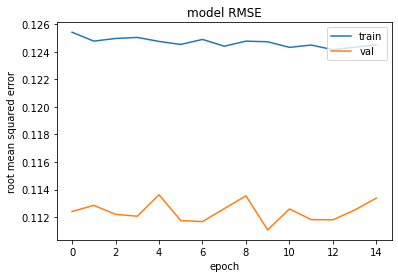

In [ ]:
history_st_2 = model_2.fit(X_train_st2, y_train_st2, validation_data=(X_val1_st2, y_val1_st2), epochs=50, callbacks=[early_stopping_monitor],verbose=False)

# summarize history for rmse
plt.plot(history_st_2.history['root_mean_squared_error'])
plt.plot(history_st_2.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()


In [ ]:
print(classification_report(test_results_st_2['actuals'], test_results_st_2['predictions']))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       574
         1.0       0.96      0.96      0.96        90
         2.0       0.94      0.96      0.95        50
         3.0       0.90      0.90      0.90        10

    accuracy                           0.99       724
   macro avg       0.95      0.95      0.95       724
weighted avg       0.99      0.99      0.99       724



###comparing all the LSTM models

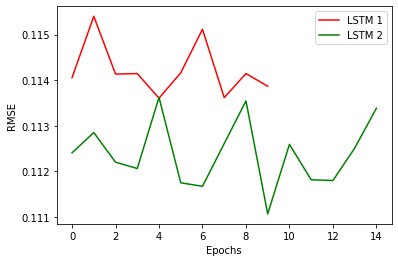

In [ ]:
plt.plot(history_st_1.history['val_root_mean_squared_error'], 'r',
         history_st_2.history['val_root_mean_squared_error'],'g')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(['LSTM 1', 'LSTM 2'], loc='upper right')
plt.show()

####predicting for 1 jan 2021 until 1 feb 2021 using the 2nd model

In [ ]:
df_date = pd.DataFrame({
    'date':pd.date_range(start='2021-01-01', end='2021-02-01')
})
df_date

date
0  2021-01-01
1  2021-01-02
2  2021-01-03
3  2021-01-04
4  2021-01-05
5  2021-01-06
6  2021-01-07
7  2021-01-08
8  2021-01-09
9  2021-01-10
10 2021-01-11
11 2021-01-12
12 2021-01-13
13 2021-01-14
14 2021-01-15
15 2021-01-16
16 2021-01-17
17 2021-01-18
18 2021-01-19
19 2021-01-20
20 2021-01-21
21 2021-01-22
22 2021-01-23
23 2021-01-24
24 2021-01-25
25 2021-01-26
26 2021-01-27
27 2021-01-28
28 2021-01-29
29 2021-01-30
30 2021-01-31
31 2021-02-01

In [ ]:
df_date.index = pd.to_datetime(df_date['date'], format='%Y.%m.%d')
df_date

date
date                 
2021-01-01 2021-01-01
2021-01-02 2021-01-02
2021-01-03 2021-01-03
2021-01-04 2021-01-04
2021-01-05 2021-01-05
2021-01-06 2021-01-06
2021-01-07 2021-01-07
2021-01-08 2021-01-08
2021-01-09 2021-01-09
2021-01-10 2021-01-10
2021-01-11 2021-01-11
2021-01-12 2021-01-12
2021-01-13 2021-01-13
2021-01-14 2021-01-14
2021-01-15 2021-01-15
2021-01-16 2021-01-16
2021-01-17 2021-01-17
2021-01-18 2021-01-18
2021-01-19 2021-01-19
2021-01-20 2021-01-20
2021-01-21 2021-01-21
2021-01-22 2021-01-22
2021-01-23 2021-01-23
2021-01-24 2021-01-24
2021-01-25 2021-01-25
2021-01-26 2021-01-26
2021-01-27 2021-01-27
2021-01-28 2021-01-28
2021-01-29 2021-01-29
2021-01-30 2021-01-30
2021-01-31 2021-01-31
2021-02-01 2021-02-01

In [ ]:
df_date['Seconds'] = df_date.index.map(pd.Timestamp.timestamp)
df_date

date       Seconds
date                               
2021-01-01 2021-01-01  1.609459e+09
2021-01-02 2021-01-02  1.609546e+09
2021-01-03 2021-01-03  1.609632e+09
2021-01-04 2021-01-04  1.609718e+09
2021-01-05 2021-01-05  1.609805e+09
2021-01-06 2021-01-06  1.609891e+09
2021-01-07 2021-01-07  1.609978e+09
2021-01-08 2021-01-08  1.610064e+09
2021-01-09 2021-01-09  1.610150e+09
2021-01-10 2021-01-10  1.610237e+09
2021-01-11 2021-01-11  1.610323e+09
2021-01-12 2021-01-12  1.610410e+09
2021-01-13 2021-01-13  1.610496e+09
2021-01-14 2021-01-14  1.610582e+09
2021-01-15 2021-01-15  1.610669e+09
2021-01-16 2021-01-16  1.610755e+09
2021-01-17 2021-01-17  1.610842e+09
2021-01-18 2021-01-18  1.610928e+09
2021-01-19 2021-01-19  1.611014e+09
2021-01-20 2021-01-20  1.611101e+09
2021-01-21 2021-01-21  1.611187e+09
2021-01-22 2021-01-22  1.611274e+09
2021-01-23 2021-01-23  1.611360e+09
2021-01-24 2021-01-24  1.611446e+09
2021-01-25 2021-01-25  1.611533e+09
2021-01-26 2021-01-26  1.611619e+09
2021-01-27 2021-01-27  1.611706e+09
2021-01-28 2021-01-28  1.611792e+09
2021-01-29 2021-01-29  1.611878e+09
2021-01-30 2021-01-30  1.611965e+09
2021-01-31 2021-01-31  1.612051e+09
2021-02-01 2021-02-01  1.612138e+09

In [ ]:
df_date['Day sin'] = np.sin(df_date['Seconds'] * (2* np.pi / day))
df_date['Day cos'] = np.cos(df_date['Seconds'] * (2 * np.pi / day))
df_date['Month sin'] = np.sin(df_date['Seconds'] * (2* np.pi / month))
df_date['Month cos'] = np.cos(df_date['Seconds'] * (2* np.pi / month))
df_date['Year sin'] = np.sin(df_date['Seconds'] * (2 * np.pi / year))
df_date['Year cos'] = np.cos(df_date['Seconds'] * (2 * np.pi / year))
df_date.head()

date       Seconds       Day sin  Day cos  Month sin  \
date                                                                    
2021-01-01 2021-01-01  1.609459e+09 -6.012051e-12      1.0   0.114525   
2021-01-02 2021-01-02  1.609546e+09 -1.713513e-12      1.0   0.315714   
2021-01-03 2021-01-03  1.609632e+09 -1.196689e-11      1.0   0.503497   
2021-01-04 2021-01-04  1.609718e+09 -7.668351e-12      1.0   0.669900   
2021-01-05 2021-01-05  1.609805e+09 -3.369812e-12      1.0   0.807857   

            Month cos  Year sin  Year cos  
date                                       
2021-01-01   0.993420  0.010881  0.999941  
2021-01-02   0.948854  0.028080  0.999606  
2021-01-03   0.863997  0.045271  0.998975  
2021-01-04   0.742451  0.062448  0.998048  
2021-01-05   0.589379  0.079608  0.996826

In [ ]:
df_date = df_date.drop('Seconds', axis=1)
df_date = df_date.drop('date',axis=1)
df_date.head()

Day sin  Day cos  Month sin  Month cos  Year sin  Year cos
date                                                                       
2021-01-01 -6.012051e-12      1.0   0.114525   0.993420  0.010881  0.999941
2021-01-02 -1.713513e-12      1.0   0.315714   0.948854  0.028080  0.999606
2021-01-03 -1.196689e-11      1.0   0.503497   0.863997  0.045271  0.998975
2021-01-04 -7.668351e-12      1.0   0.669900   0.742451  0.062448  0.998048
2021-01-05 -3.369812e-12      1.0   0.807857   0.589379  0.079608  0.996826

In [ ]:
df_date.insert(0, "score", [0 for i in range(32)], True)
df_date

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2021-01-01      0 -6.012051e-12      1.0   0.114525   0.993420  0.010881   
2021-01-02      0 -1.713513e-12      1.0   0.315714   0.948854  0.028080   
2021-01-03      0 -1.196689e-11      1.0   0.503497   0.863997  0.045271   
2021-01-04      0 -7.668351e-12      1.0   0.669900   0.742451  0.062448   
2021-01-05      0 -3.369812e-12      1.0   0.807857   0.589379  0.079608   
2021-01-06      0  9.287266e-13      1.0   0.911509   0.411280  0.096743   
2021-01-07      0 -9.324650e-12      1.0   0.976456   0.215716  0.113850   
2021-01-08      0 -5.026111e-12      1.0   0.999940   0.010992  0.130923   
2021-01-09      0 -7.275728e-13      1.0   0.980962  -0.194198  0.147958   
2021-01-10      0 -1.098095e-11      1.0   0.920330  -0.391142  0.164948   
2021-01-11      0 -6.682411e-12      1.0   0.820618  -0.571477  0.181890   
2021-01-12      0 -2.383872e-12      1.0   0.686059  -0.727545  0.198778   
2021-01-13      0 -1.263725e-11      1.0   0.522369  -0.852720  0.215608   
2021-01-14      0 -8.338710e-12      1.0   0.336497  -0.941685  0.232373   
2021-01-15      0 -4.040172e-12      1.0   0.136336  -0.990663  0.249070   
2021-01-16      0  2.583671e-13      1.0  -0.069615  -0.997574  0.265693   
2021-01-17      0 -9.995009e-12      1.0  -0.272609  -0.962125  0.282237   
2021-01-18      0 -5.696471e-12      1.0  -0.464027  -0.885821  0.298698   
2021-01-19      0 -1.397932e-12      1.0  -0.635741  -0.771902  0.315070   
2021-01-20      0 -1.165131e-11      1.0  -0.780460  -0.625206  0.331350   
2021-01-21      0 -7.352770e-12      1.0  -0.892037  -0.451961  0.347531   
2021-01-22      0 -3.054232e-12      1.0  -0.965736  -0.259525  0.363609   
2021-01-23      0 -1.330761e-11      1.0  -0.998427  -0.056069  0.379580   
2021-01-24      0 -9.009070e-12      1.0  -0.988721   0.149769  0.395438   
2021-01-25      0 -4.710531e-12      1.0  -0.937031   0.349247  0.411179   
2021-01-26      0 -4.119923e-13      1.0  -0.845551   0.533894  0.426799   
2021-01-27      0 -1.066537e-11      1.0  -0.718167   0.695871  0.442292   
2021-01-28      0 -6.366830e-12      1.0  -0.560287   0.828299  0.457655   
2021-01-29      0 -2.068292e-12      1.0  -0.378615   0.925554  0.472882   
2021-01-30      0 -1.232167e-11      1.0  -0.180866   0.983508  0.487969   
2021-01-31      0 -8.023130e-12      1.0   0.024563   0.999698  0.502912   
2021-02-01      0 -3.724591e-12      1.0   0.228949   0.973438  0.517705   

            Year cos  
date                  
2021-01-01  0.999941  
2021-01-02  0.999606  
2021-01-03  0.998975  
2021-01-04  0.998048  
2021-01-05  0.996826  
2021-01-06  0.995309  
2021-01-07  0.993498  
2021-01-08  0.991393  
2021-01-09  0.988994  
2021-01-10  0.986302  
2021-01-11  0.983319  
2021-01-12  0.980044  
2021-01-13  0.976480  
2021-01-14  0.972627  
2021-01-15  0.968486  
2021-01-16  0.964058  
2021-01-17  0.959345  
2021-01-18  0.954348  
2021-01-19  0.949068  
2021-01-20  0.943508  
2021-01-21  0.937669  
2021-01-22  0.931552  
2021-01-23  0.925159  
2021-01-24  0.918493  
2021-01-25  0.911554  
2021-01-26  0.904347  
2021-01-27  0.896871  
2021-01-28  0.889130  
2021-01-29  0.881126  
2021-01-30  0.872861  
2021-01-31  0.864338  
2021-02-01  0.855559

In [ ]:
x_test_st = scorest_test_df.tail(7)
x_test_st

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2020-12-25    0.0 -6.997991e-12      1.0  -0.971208   0.238232 -0.109320   
2020-12-26    0.0 -2.699453e-12      1.0  -0.901757   0.432242 -0.092205   
2020-12-27    0.0 -1.295283e-11      1.0  -0.794015   0.607898 -0.075062   
2020-12-28    0.0 -8.654291e-12      1.0  -0.652557   0.757740 -0.057898   
2020-12-29    0.0 -4.355752e-12      1.0  -0.483388   0.875406 -0.040716   
2020-12-30    0.0 -5.721331e-14      1.0  -0.293694   0.955900 -0.023523   
2020-12-31    0.0 -1.031059e-11      1.0  -0.091528   0.995803 -0.006322   

            Year cos  
date                  
2020-12-25  0.994007  
2020-12-26  0.995740  
2020-12-27  0.997179  
2020-12-28  0.998323  
2020-12-29  0.999171  
2020-12-30  0.999723  
2020-12-31  0.999980

In [ ]:
x_test1_st = x_test_st.append(df_date)
x_test1_st

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2020-12-25    0.0 -6.997991e-12      1.0  -0.971208   0.238232 -0.109320   
2020-12-26    0.0 -2.699453e-12      1.0  -0.901757   0.432242 -0.092205   
2020-12-27    0.0 -1.295283e-11      1.0  -0.794015   0.607898 -0.075062   
2020-12-28    0.0 -8.654291e-12      1.0  -0.652557   0.757740 -0.057898   
2020-12-29    0.0 -4.355752e-12      1.0  -0.483388   0.875406 -0.040716   
2020-12-30    0.0 -5.721331e-14      1.0  -0.293694   0.955900 -0.023523   
2020-12-31    0.0 -1.031059e-11      1.0  -0.091528   0.995803 -0.006322   
2021-01-01    0.0 -6.012051e-12      1.0   0.114525   0.993420  0.010881   
2021-01-02    0.0 -1.713513e-12      1.0   0.315714   0.948854  0.028080   
2021-01-03    0.0 -1.196689e-11      1.0   0.503497   0.863997  0.045271   
2021-01-04    0.0 -7.668351e-12      1.0   0.669900   0.742451  0.062448   
2021-01-05    0.0 -3.369812e-12      1.0   0.807857   0.589379  0.079608   
2021-01-06    0.0  9.287266e-13      1.0   0.911509   0.411280  0.096743   
2021-01-07    0.0 -9.324650e-12      1.0   0.976456   0.215716  0.113850   
2021-01-08    0.0 -5.026111e-12      1.0   0.999940   0.010992  0.130923   
2021-01-09    0.0 -7.275728e-13      1.0   0.980962  -0.194198  0.147958   
2021-01-10    0.0 -1.098095e-11      1.0   0.920330  -0.391142  0.164948   
2021-01-11    0.0 -6.682411e-12      1.0   0.820618  -0.571477  0.181890   
2021-01-12    0.0 -2.383872e-12      1.0   0.686059  -0.727545  0.198778   
2021-01-13    0.0 -1.263725e-11      1.0   0.522369  -0.852720  0.215608   
2021-01-14    0.0 -8.338710e-12      1.0   0.336497  -0.941685  0.232373   
2021-01-15    0.0 -4.040172e-12      1.0   0.136336  -0.990663  0.249070   
2021-01-16    0.0  2.583671e-13      1.0  -0.069615  -0.997574  0.265693   
2021-01-17    0.0 -9.995009e-12      1.0  -0.272609  -0.962125  0.282237   
2021-01-18    0.0 -5.696471e-12      1.0  -0.464027  -0.885821  0.298698   
2021-01-19    0.0 -1.397932e-12      1.0  -0.635741  -0.771902  0.315070   
2021-01-20    0.0 -1.165131e-11      1.0  -0.780460  -0.625206  0.331350   
2021-01-21    0.0 -7.352770e-12      1.0  -0.892037  -0.451961  0.347531   
2021-01-22    0.0 -3.054232e-12      1.0  -0.965736  -0.259525  0.363609   
2021-01-23    0.0 -1.330761e-11      1.0  -0.998427  -0.056069  0.379580   
2021-01-24    0.0 -9.009070e-12      1.0  -0.988721   0.149769  0.395438   
2021-01-25    0.0 -4.710531e-12      1.0  -0.937031   0.349247  0.411179   
2021-01-26    0.0 -4.119923e-13      1.0  -0.845551   0.533894  0.426799   
2021-01-27    0.0 -1.066537e-11      1.0  -0.718167   0.695871  0.442292   
2021-01-28    0.0 -6.366830e-12      1.0  -0.560287   0.828299  0.457655   
2021-01-29    0.0 -2.068292e-12      1.0  -0.378615   0.925554  0.472882   
2021-01-30    0.0 -1.232167e-11      1.0  -0.180866   0.983508  0.487969   
2021-01-31    0.0 -8.023130e-12      1.0   0.024563   0.999698  0.502912   
2021-02-01    0.0 -3.724591e-12      1.0   0.228949   0.973438  0.517705   

            Year cos  
date                  
2020-12-25  0.994007  
2020-12-26  0.995740  
2020-12-27  0.997179  
2020-12-28  0.998323  
2020-12-29  0.999171  
2020-12-30  0.999723  
2020-12-31  0.999980  
2021-01-01  0.999941  
2021-01-02  0.999606  
2021-01-03  0.998975  
2021-01-04  0.998048  
2021-01-05  0.996826  
2021-01-06  0.995309  
2021-01-07  0.993498  
2021-01-08  0.991393  
2021-01-09  0.988994  
2021-01-10  0.986302  
2021-01-11  0.983319  
2021-01-12  0.980044  
2021-01-13  0.976480  
2021-01-14  0.972627  
2021-01-15  0.968486  
2021-01-16  0.964058  
2021-01-17  0.959345  
2021-01-18  0.954348  
2021-01-19  0.949068  
2021-01-20  0.943508  
2021-01-21  0.937669  
2021-01-22  0.931552  
2021-01-23  0.925159  
2021-01-24  0.918493  
2021-01-25  0.911554  
2021-01-26  0.904347  
2021-01-27  0.896871  
2021-01-28  0.889130  
2021-01-29  0.881126  
2021-01-30  0.872861 

In [ ]:
WINDOW_SIZE = 7
X_test1_st2_new, y_test1_st2_new = df_to_X_y2(x_test1_st, WINDOW_SIZE)
X_test1_st2_new.shape

(32, 7, 7)

In [ ]:
test_prediction_2_new_st = model_2.predict(X_test1_st2_new).flatten()
test_results_2_new_st = pd.DataFrame(data={'predictions':test_prediction_2_new_st})
test_results_2_new_st

1/1 [==============================] - 0s 19ms/step


predictions
0      0.730751
1      0.730178
2      0.729377
3      0.728811
4      0.728792
5      0.729390
6      0.730406
7      0.731406
8      0.731827
9      0.731130
10     0.728977
11     0.725364
12     0.720634
13     0.715392
14     0.710323
15     0.706022
16     0.702856
17     0.700931
18     0.700133
19     0.700238
20     0.701036
21     0.702420
22     0.704405
23     0.707062
24     0.710414
25     0.714340
26     0.718543
27     0.722597
28     0.726061
29     0.728608
30     0.730122
31     0.730738

#####result

In [ ]:
test_results_2_new_st.predictions[test_results_2_new_st.predictions <0.5] = 0
test_results_2_new_st.predictions[(test_results_2_new_st.predictions >=0.5)&(test_results_2_new_st.predictions<1.5)] = 1
test_results_2_new_st.predictions[(test_results_2_new_st.predictions >=1.5)&(test_results_2_new_st.predictions<2.5)] = 2
test_results_2_new_st.predictions[(test_results_2_new_st.predictions >=2.5)&(test_results_2_new_st.predictions<3.5)] = 3
test_results_2_new_st.predictions[(test_results_2_new_st.predictions >=3.5)&(test_results_2_new_st.predictions<4.5)] = 4
test_results_2_new_st.predictions[(test_results_2_new_st.predictions >=4.5)&(test_results_2_new_st.predictions<5.5)] = 5
test_results_2_new_st

predictions
0           1.0
1           1.0
2           1.0
3           1.0
4           1.0
5           1.0
6           1.0
7           1.0
8           1.0
9           1.0
10          1.0
11          1.0
12          1.0
13          1.0
14          1.0
15          1.0
16          1.0
17          1.0
18          1.0
19          1.0
20          1.0
21          1.0
22          1.0
23          1.0
24          1.0
25          1.0
26          1.0
27          1.0
28          1.0
29          1.0
30          1.0
31          1.0

##Holt, Nebraska

###train

In [ ]:
holt = train[train['fips']==31089]

#using interpolation to fill in the NaN values
holt = holt.interpolate().fillna(method='bfill')
holt.score[holt.score <0.5] = 0
holt.score[(holt.score >=0.5)&(holt.score<1.5)] = 1
holt.score[(holt.score >=1.5)&(holt.score<2.5)] = 2
holt.score[(holt.score >=2.5)&(holt.score<3.5)] = 3
holt.score[(holt.score >=3.5)&(holt.score<4.5)] = 4
holt.score[(holt.score >=4.5)&(holt.score<5.5)] = 5

#merging the weather data with the soil data
holt = holt.merge(soil, left_on='fips', right_on='fips')
train_ne = holt.copy()
holt['date'] = pd.to_datetime(holt['date'], format='%Y.%m.%d')
train_ne['tahun'] = holt['date'].dt.year
train_ne['bulan'] = holt['date'].dt.month
train_ne['tanggal'] = holt['date'].dt.day
train_ne[0:31]

fips        date  PRECTOT     PS  QV2M   T2M  T2MDEW  T2MWET  T2M_MAX  \
0   31089  2000-01-01     0.01  93.41  2.75 -1.44   -5.13   -5.08     2.68   
1   31089  2000-01-02     0.04  93.59  2.20 -2.04   -7.86   -7.72     1.90   
2   31089  2000-01-03     0.45  94.43  2.07 -5.37   -9.04   -8.87    -2.24   
3   31089  2000-01-04     0.00  94.70  1.23 -8.35  -14.42  -14.00    -1.13   
4   31089  2000-01-05     0.75  93.78  2.93 -0.28   -4.69   -4.61     4.49   
5   31089  2000-01-06     0.00  94.93  2.30 -1.26   -7.13   -7.01     4.84   
6   31089  2000-01-07     0.00  94.57  2.10 -0.22   -8.30   -8.11     8.97   
7   31089  2000-01-08     0.00  93.67  2.27  2.33   -7.43   -7.25     9.10   
8   31089  2000-01-09     0.10  92.81  2.98  1.33   -4.38   -4.31     7.69   
9   31089  2000-01-10     0.00  92.94  1.85  0.09  -10.03   -9.68     5.69   
10  31089  2000-01-11     0.00  93.75  1.85 -0.47   -9.83   -9.53     5.58   
11  31089  2000-01-12     0.00  93.99  2.00 -2.83   -8.94   -8.77     2.82   
12  31089  2000-01-13     0.00  95.82  1.80 -2.55   -9.85   -9.63     5.79   
13  31089  2000-01-14     0.00  94.84  2.61  1.68   -5.72   -5.61    10.64   
14  31089  2000-01-15     0.12  94.42  3.30  1.74   -2.71   -2.68    10.29   
15  31089  2000-01-16     0.00  95.52  1.39 -5.48  -12.96  -12.48    -4.08   
16  31089  2000-01-17     0.18  94.67  2.75  0.01   -5.43   -5.32     5.43   
17  31089  2000-01-18     0.15  94.77  3.02  1.69   -3.93   -3.85     7.64   
18  31089  2000-01-19     1.43  94.27  2.48 -3.68   -7.29   -7.14     1.36   
19  31089  2000-01-20     0.00  94.71  1.77 -4.46  -10.25  -10.08     4.03   
20  31089  2000-01-21     0.00  93.84  2.03 -3.21   -8.86   -8.72     2.93   
21  31089  2000-01-22     0.00  93.89  2.49 -0.80   -6.40   -6.30     4.58   
22  31089  2000-01-23     0.08  94.71  1.19 -5.90  -14.53  -13.90    -2.78   
23  31089  2000-01-24     0.01  94.49  1.92 -3.30   -9.30   -9.13     2.97   
24  31089  2000-01-25     0.00  95.18  1.49 -7.35  -11.99  -11.76    -1.54   
25  31089  2000-01-26     0.06  94.82  1.45 -6.66  -12.42  -12.11    -2.50   
26  31089  2000-01-27     0.32  95.13  1.71 -5.05  -10.56  -10.35    -1.04   
27  31089  2000-01-28     2.23  95.33  2.00 -5.88   -8.66   -8.58    -4.12   
28  31089  2000-01-29     0.36  95.25  1.82 -7.19   -9.81   -9.72    -3.91   
29  31089  2000-01-30     0.00  95.06  1.73 -7.58  -10.38  -10.28    -2.41   
30  31089  2000-01-31     0.00  94.53  2.06 -4.87   -8.48   -8.41     3.80   

    T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  WS50M  \
0     -3.58       6.25 -1.61   4.19       5.79       2.51         3.29   6.23   
1     -3.85       5.74 -1.58   4.82       7.75       1.95         5.80   6.12   
2    -12.52      10.28 -5.01   8.21      12.51       2.48        10.02  10.06   
3    -14.98      13.85 -7.72   5.61       8.52       2.29         6.22   7.38   
4     -3.13       7.62 -0.85   5.99       9.33       4.16         5.16   8.87   
5     -4.71       9.55 -2.00   5.01      10.11       1.41         8.70   7.90   
6     -5.66      14.63 -1.26   5.12       8.12       2.71         5.42   8.50   
7     -1.05      10.14  0.21   2.86       4.05       1.48         2.57   4.60   
8     -1.98       9.67  0.57   5.35       8.46       4.17         4.29   8.85   
9     -4.20       9.90 -0.52   8.98      14.46       3.83        10.62  12.50   
10    -4.57      10.16 -0.51   5.21       8.98       2.56         6.42   7.19   
11    -8.92      11.74 -2.52   5.46       8.29       0.95         7.34   7.05   
12   -10.10      15.89 -2.93   3.75       8.11       1.59         6.53   5.86   
13    -2.57      13.20  0.62   6.13       9.60       2.70         6.90   8.69   
14    -3.62      13.91  1.02   5.47       6.44       4.08         2.37   8.60   
15    -7.75       3.67 -4.31   6.33       7.96       4.47         3.49   7.47   
16    -4.50       9.93 -0.98   4.34       7.65       1.58         6.07   5.79   
17    -2.05       9.68  1.30   3.53       6.33    

In [ ]:
train_ne['score'].value_counts()

0.0    3495
1.0    1087
3.0     756
2.0     568
5.0     214
4.0      90
Name: score, dtype: int64

In [ ]:
#For Regression

holt = train[train['fips']==31089]

#using interpolation to fill in the NaN values
holt = holt.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
holt = holt.merge(soil, left_on='fips', right_on='fips')
train_ne = holt.copy()
train_ne[2000:2050]

fips        date  PRECTOT     PS   QV2M    T2M  T2MDEW  T2MWET  \
2000  31089  2005-06-23     0.03  93.76  14.08  26.72   18.29   18.29   
2001  31089  2005-06-24     2.59  94.13  13.70  21.57   17.92   17.92   
2002  31089  2005-06-25     0.29  94.09  14.11  22.86   18.36   18.36   
2003  31089  2005-06-26     0.04  93.69  13.45  26.44   17.58   17.58   
2004  31089  2005-06-27     6.35  93.89  14.45  25.55   18.71   18.71   
2005  31089  2005-06-28     0.31  93.84  15.46  25.56   19.79   19.79   
2006  31089  2005-06-29     0.12  93.56  12.11  25.11   15.63   15.63   
2007  31089  2005-06-30     0.00  94.20   8.85  21.77   11.19   11.19   
2008  31089  2005-07-01     4.09  94.27  10.00  21.64   12.97   12.97   
2009  31089  2005-07-02     0.06  93.53  13.28  25.64   17.29   17.28   
2010  31089  2005-07-03     0.00  93.59  11.59  22.70   15.14   15.14   
2011  31089  2005-07-04     0.01  94.48   8.02  22.57    9.75    9.76   
2012  31089  2005-07-05     8.66  94.60  10.01  22.78   13.02   13.02   
2013  31089  2005-07-06     2.53  94.31  13.11  23.32   17.26   17.26   
2014  31089  2005-07-07     0.01  94.16  13.41  25.22   17.61   17.61   
2015  31089  2005-07-08     0.01  94.10  14.15  25.43   18.45   18.45   
2016  31089  2005-07-09     0.00  93.97  14.68  26.62   19.00   19.00   
2017  31089  2005-07-10     0.01  94.01  12.60  26.64   16.58   16.58   
2018  31089  2005-07-11     0.73  94.28  13.69  26.01   17.94   17.94   
2019  31089  2005-07-12     0.79  94.68  12.46  26.09   16.46   16.46   
2020  31089  2005-07-13     0.00  94.63  12.39  24.70   16.45   16.45   
2021  31089  2005-07-14     0.00  94.30  11.05  25.93   14.62   14.62   
2022  31089  2005-07-15     0.00  94.24  12.38  28.13   16.29   16.29   
2023  31089  2005-07-16     0.00  93.91  11.35  29.11   14.97   14.97   
2024  31089  2005-07-17     1.43  93.78  11.17  25.98   14.58   14.58   
2025  31089  2005-07-18     0.00  94.25   7.86  24.04    9.43    9.43   
2026  31089  2005-07-19     0.80  93.86  13.38  27.15   17.22   17.22   
2027  31089  2005-07-20     2.35  93.72  14.48  29.90   18.69   18.69   
2028  31089  2005-07-21     6.96  94.33  16.13  27.33   20.56   20.56   
2029  31089  2005-07-22     0.01  94.30  14.68  29.31   18.99   18.99   
2030  31089  2005-07-23     0.00  93.87  10.86  32.67   14.26   14.26   
2031  31089  2005-07-24     1.01  93.93  14.48  27.57   18.59   18.59   
2032  31089  2005-07-25     4.37  93.74  13.35  24.20   17.35   17.35   
2033  31089  2005-07-26     0.06  94.75   7.01  17.38    7.82    7.82   
2034  31089  2005-07-27     0.00  94.79   6.42  19.80    6.58    6.59   
2035  31089  2005-07-28     0.18  94.47   8.56  24.90   10.75   10.75   
2036  31089  2005-07-29     0.74  94.36   8.80  26.53   11.12   11.12   
2037  31089  2005-07-30     0.00  94.26   9.41  27.85   11.98   11.98   
2038  31089  2005-07-31     0.00  94.35  10.93  28.12   14.44   14.44   
2039  31089  2005-08-01     0.00  94.24  11.91  29.09   15.76   15.76   
2040  31089  2005-08-02     0.00  93.71  10.84  31.25   14.10   14.10   
2041  31089  2005-08-03    10.37  93.97  12.67  29.38   16.41   16.41   
2042  31089  2005-08-04     9.64  95.19   8.71  20.06   11.09   11.09   
2043  31089  2005-08-05     0.00  95.17   7.58  22.45    9.06    9.07   
2044  31089  2005-08-06     0.00  94.56  10.34  24.87   13.50   13.50   
2045  31089  2005-08-07     0.00  94.28  11.53  28.17   15.28   15.28   
2046  31089  2005-08-08     0.00  94.10  11.70  29.68   15.44   15.44   
2047  31089  2005-08-09     9.72  94.17  13.05  27.25   17.12   17.12   
2048  31089  2005-08-10    18.80  94.38  14.53  23.86   18.77   18.77   
2049  31089  2005-08-11     9.90  94.06  15.18  23.95   19.51   19.51   

      T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
2000    33.17    19.64      13.53  26.55   7.05       9.39       2.18   
2001    24.71    17.71       7.00  22.04   5.55       7.99       2.39   
2002    28.98    17.25      11.73  23.62   3.36       3.98      

###val

In [ ]:
holt_val = validation[validation['fips']==31089]

#using interpolation to fill in the NaN values
holt_val = holt_val.interpolate().fillna(method='bfill')
holt_val.score[holt_val.score <0.5] = 0
holt_val.score[(holt_val.score >=0.5)&(holt_val.score<1.5)] = 1
holt_val.score[(holt_val.score >=1.5)&(holt_val.score<2.5)] = 2
holt_val.score[(holt_val.score >=2.5)&(holt_val.score<3.5)] = 3
holt_val.score[(holt_val.score >=3.5)&(holt_val.score<4.5)] = 4
holt_val.score[(holt_val.score >=4.5)&(holt_val.score<5.5)] = 5

#merging the weather data with the soil data
holt_val = holt_val.merge(soil, left_on='fips', right_on='fips')
val_ne = holt_val.copy()
holt_val['date'] = pd.to_datetime(holt_val['date'], format='%Y.%m.%d')
val_ne['tahun'] = holt_val['date'].dt.year
val_ne['bulan'] = holt_val['date'].dt.month
val_ne['tanggal'] = holt_val['date'].dt.day
val_ne[0:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   31089  2017-01-01     0.04  93.66  2.63  -2.85   -5.65   -5.61     1.54   
1   31089  2017-01-02     0.06  93.92  2.77  -3.09   -5.48   -5.42     1.97   
2   31089  2017-01-03     0.00  95.10  0.95 -12.34  -16.73  -16.24    -9.98   
3   31089  2017-01-04     1.29  94.87  0.79 -14.59  -18.56  -17.98   -13.49   
4   31089  2017-01-05     0.01  94.66  0.74 -14.68  -19.22  -18.49   -12.67   
5   31089  2017-01-06     0.00  94.85  0.87 -12.98  -17.66  -17.15    -6.17   
6   31089  2017-01-07     0.00  95.91  1.04 -12.60  -15.77  -15.46    -7.69   
7   31089  2017-01-08     0.00  94.90  1.61  -7.43  -11.40  -11.25     2.13   
8   31089  2017-01-09     0.00  93.46  2.78  -2.89   -5.85   -5.78     5.02   
9   31089  2017-01-10     0.03  93.09  2.45  -2.72   -7.03   -6.91     0.19   
10  31089  2017-01-11     2.36  93.64  1.28 -10.57  -14.79  -14.34    -1.89   
11  31089  2017-01-12     0.01  95.11  1.05 -10.39  -15.71  -15.24    -5.10   
12  31089  2017-01-13     0.01  95.86  1.16  -8.16  -14.67  -14.16    -3.55   
13  31089  2017-01-14     0.00  95.54  2.01  -4.18   -8.74   -8.63     2.89   
14  31089  2017-01-15     1.22  94.79  2.58  -2.80   -5.86   -5.81     2.05   
15  31089  2017-01-16     3.90  94.27  3.01  -2.06   -3.93   -3.91     0.18   
16  31089  2017-01-17     0.03  94.31  2.64  -2.14   -5.60   -5.56     4.58   
17  31089  2017-01-18     0.00  93.78  3.29   0.22   -3.08   -3.04     6.96   
18  31089  2017-01-19     0.06  93.07  4.12   1.02    0.10    0.10     4.57   
19  31089  2017-01-20     0.16  92.40  3.96   1.00   -0.58   -0.58     6.06   
20  31089  2017-01-21     0.01  92.48  3.81   2.02   -1.05   -1.03     7.76   
21  31089  2017-01-22     0.00  93.60  3.00  -0.23   -4.08   -4.03     5.81   
22  31089  2017-01-23     0.02  93.51  2.97   0.36   -4.17   -4.12     5.54   
23  31089  2017-01-24    13.98  93.15  3.06  -2.43   -3.81   -3.80    -1.21   
24  31089  2017-01-25     2.14  93.94  2.20  -5.76   -7.76   -7.72    -4.81   
25  31089  2017-01-26     0.02  94.53  1.93  -6.86   -9.32   -9.25    -1.14   
26  31089  2017-01-27     0.00  94.47  2.60  -3.70   -6.14   -6.08     1.47   
27  31089  2017-01-28     0.03  94.35  3.29  -0.38   -2.79   -2.78     2.89   
28  31089  2017-01-29     0.01  94.31  3.61   1.20   -1.56   -1.55     5.57   
29  31089  2017-01-30     0.00  93.89  3.03   2.85   -3.92   -3.85    10.61   
30  31089  2017-01-31     0.16  94.26  2.76  -0.15   -4.99   -4.92     3.31   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0     -6.57       8.12  -3.38   3.81       4.91       2.34         2.56   
1     -9.66      11.63  -2.83   5.46      10.66       1.65         9.00   
2    -14.74       4.76 -11.85   8.76      10.70       5.71         5.00   
3    -16.25       2.76 -13.68   4.39       6.10       2.84         3.26   
4    -17.33       4.67 -14.38   5.66       8.80       2.78         6.02   
5    -18.73      12.56 -13.15   3.69       6.11       2.43         3.68   
6    -16.05       8.36 -11.83   3.63       6.02       0.46         5.56   
7    -13.89      16.02  -7.44   6.52      10.42       3.11         7.31   
8     -9.57      14.59  -3.07   4.97      10.63       0.34        10.30   
9     -7.09       7.28  -2.59   7.52      13.64       1.21        12.43   
10   -13.32      11.43  -9.61   7.14      10.95       2.43         8.52   
11   -14.36       9.25 -10.17   3.34       6.07       1.08         4.99   
12   -11.67       8.13  -7.68   3.81       5.45       1.87         3.59   
13    -9.01      11.90  -4.55   2.66       3.22       1.78         1.44   
14    -7.85       9.90  -3.29   2.95       4.52       1.93         2.59   
15    -6.16       6.33  -2.27   4.65       7.36       0.79         6.57   
16    -6.80      11.37  -2.67   4.43       5.76       2.67         3.09   
17    -4.47      11.43  -0.51   5.81       6.55       4.47         2.08   
18    -0.50       5.07   0.96   5.61       6.61    

In [ ]:
val_ne['score'].value_counts()

0.0    604
1.0     95
2.0     31
Name: score, dtype: int64

In [ ]:
#For Regression

holt_val = validation[validation['fips']==31089]

#using interpolation to fill in the NaN values
holt_val = holt_val.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
holt_val = holt_val.merge(soil, left_on='fips', right_on='fips')
val_ne = holt_val.copy()
val_ne[0:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   31089  2017-01-01     0.04  93.66  2.63  -2.85   -5.65   -5.61     1.54   
1   31089  2017-01-02     0.06  93.92  2.77  -3.09   -5.48   -5.42     1.97   
2   31089  2017-01-03     0.00  95.10  0.95 -12.34  -16.73  -16.24    -9.98   
3   31089  2017-01-04     1.29  94.87  0.79 -14.59  -18.56  -17.98   -13.49   
4   31089  2017-01-05     0.01  94.66  0.74 -14.68  -19.22  -18.49   -12.67   
5   31089  2017-01-06     0.00  94.85  0.87 -12.98  -17.66  -17.15    -6.17   
6   31089  2017-01-07     0.00  95.91  1.04 -12.60  -15.77  -15.46    -7.69   
7   31089  2017-01-08     0.00  94.90  1.61  -7.43  -11.40  -11.25     2.13   
8   31089  2017-01-09     0.00  93.46  2.78  -2.89   -5.85   -5.78     5.02   
9   31089  2017-01-10     0.03  93.09  2.45  -2.72   -7.03   -6.91     0.19   
10  31089  2017-01-11     2.36  93.64  1.28 -10.57  -14.79  -14.34    -1.89   
11  31089  2017-01-12     0.01  95.11  1.05 -10.39  -15.71  -15.24    -5.10   
12  31089  2017-01-13     0.01  95.86  1.16  -8.16  -14.67  -14.16    -3.55   
13  31089  2017-01-14     0.00  95.54  2.01  -4.18   -8.74   -8.63     2.89   
14  31089  2017-01-15     1.22  94.79  2.58  -2.80   -5.86   -5.81     2.05   
15  31089  2017-01-16     3.90  94.27  3.01  -2.06   -3.93   -3.91     0.18   
16  31089  2017-01-17     0.03  94.31  2.64  -2.14   -5.60   -5.56     4.58   
17  31089  2017-01-18     0.00  93.78  3.29   0.22   -3.08   -3.04     6.96   
18  31089  2017-01-19     0.06  93.07  4.12   1.02    0.10    0.10     4.57   
19  31089  2017-01-20     0.16  92.40  3.96   1.00   -0.58   -0.58     6.06   
20  31089  2017-01-21     0.01  92.48  3.81   2.02   -1.05   -1.03     7.76   
21  31089  2017-01-22     0.00  93.60  3.00  -0.23   -4.08   -4.03     5.81   
22  31089  2017-01-23     0.02  93.51  2.97   0.36   -4.17   -4.12     5.54   
23  31089  2017-01-24    13.98  93.15  3.06  -2.43   -3.81   -3.80    -1.21   
24  31089  2017-01-25     2.14  93.94  2.20  -5.76   -7.76   -7.72    -4.81   
25  31089  2017-01-26     0.02  94.53  1.93  -6.86   -9.32   -9.25    -1.14   
26  31089  2017-01-27     0.00  94.47  2.60  -3.70   -6.14   -6.08     1.47   
27  31089  2017-01-28     0.03  94.35  3.29  -0.38   -2.79   -2.78     2.89   
28  31089  2017-01-29     0.01  94.31  3.61   1.20   -1.56   -1.55     5.57   
29  31089  2017-01-30     0.00  93.89  3.03   2.85   -3.92   -3.85    10.61   
30  31089  2017-01-31     0.16  94.26  2.76  -0.15   -4.99   -4.92     3.31   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0     -6.57       8.12  -3.38   3.81       4.91       2.34         2.56   
1     -9.66      11.63  -2.83   5.46      10.66       1.65         9.00   
2    -14.74       4.76 -11.85   8.76      10.70       5.71         5.00   
3    -16.25       2.76 -13.68   4.39       6.10       2.84         3.26   
4    -17.33       4.67 -14.38   5.66       8.80       2.78         6.02   
5    -18.73      12.56 -13.15   3.69       6.11       2.43         3.68   
6    -16.05       8.36 -11.83   3.63       6.02       0.46         5.56   
7    -13.89      16.02  -7.44   6.52      10.42       3.11         7.31   
8     -9.57      14.59  -3.07   4.97      10.63       0.34        10.30   
9     -7.09       7.28  -2.59   7.52      13.64       1.21        12.43   
10   -13.32      11.43  -9.61   7.14      10.95       2.43         8.52   
11   -14.36       9.25 -10.17   3.34       6.07       1.08         4.99   
12   -11.67       8.13  -7.68   3.81       5.45       1.87         3.59   
13    -9.01      11.90  -4.55   2.66       3.22       1.78         1.44   
14    -7.85       9.90  -3.29   2.95       4.52       1.93         2.59   
15    -6.16       6.33  -2.27   4.65       7.36       0.79         6.57   
16    -6.80      11.37  -2.67   4.43       5.76       2.67         3.09   
17    -4.47      11.43  -0.51   5.81       6.55       4.47         2.08   
18    -0.50       5.07   0.96   5.61       6.61    

###test

In [ ]:
holt_test = test[test['fips']==31089]

#using interpolation to fill in the NaN values
holt_test = holt_test.interpolate().fillna(method='bfill')
holt_test.score[holt_test.score <0.5] = 0
holt_test.score[(holt_test.score >=0.5)&(holt_test.score<1.5)] = 1
holt_test.score[(holt_test.score >=1.5)&(holt_test.score<2.5)] = 2
holt_test.score[(holt_test.score >=2.5)&(holt_test.score<3.5)] = 3
holt_test.score[(holt_test.score >=3.5)&(holt_test.score<4.5)] = 4
holt_test.score[(holt_test.score >=4.5)&(holt_test.score<5.5)] = 5

#merging the weather data with the soil data
holt_test = holt_test.merge(soil, left_on='fips', right_on='fips')
test_ne = holt_test.copy()
holt_test['date'] = pd.to_datetime(holt_test['date'], format='%Y.%m.%d')
test_ne['tahun'] = holt_test['date'].dt.year
test_ne['bulan'] = holt_test['date'].dt.month
test_ne['tanggal'] = holt_test['date'].dt.day
test_ne[0:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   31089  2019-01-01     0.00  95.27  0.79 -14.89  -20.44  -18.10   -10.67   
1   31089  2019-01-02     0.00  94.19  2.00  -6.56   -9.34   -9.62     1.38   
2   31089  2019-01-03     0.00  93.89  3.01  -1.30   -4.07   -4.15     3.72   
3   31089  2019-01-04     0.00  93.78  3.66   1.43   -1.45   -1.51     6.23   
4   31089  2019-01-05     0.00  94.15  3.94   1.83   -0.39   -0.44     7.00   
5   31089  2019-01-06     0.00  93.18  4.18   1.05    0.25    0.26     2.97   
6   31089  2019-01-07     0.02  93.21  3.88   3.40   -0.69   -0.69     8.31   
7   31089  2019-01-08     0.03  95.08  2.55   0.57   -6.07   -5.90     5.18   
8   31089  2019-01-09     0.00  95.57  1.73  -3.38  -11.00  -10.14    -0.13   
9   31089  2019-01-10     0.00  94.55  2.87  -1.19   -4.59   -4.53     3.93   
10  31089  2019-01-11     0.00  94.49  3.19  -0.65   -3.20   -3.10     2.00   
11  31089  2019-01-12     0.03  95.15  2.13  -5.11   -8.41   -7.98    -3.02   
12  31089  2019-01-13     0.01  95.25  2.71  -2.78   -5.25   -5.10     2.23   
13  31089  2019-01-14     0.00  94.87  2.88  -1.82   -4.51   -4.34     4.25   
14  31089  2019-01-15     0.00  94.52  2.83  -1.06   -4.77   -4.63     6.31   
15  31089  2019-01-16     0.74  94.60  2.19  -5.51   -8.13   -7.78    -3.88   
16  31089  2019-01-17     0.02  94.38  2.61  -3.94   -5.88   -5.67     0.38   
17  31089  2019-01-18     0.57  94.35  1.92  -7.37   -9.85   -9.66    -4.63   
18  31089  2019-01-19     0.01  95.15  1.02 -12.15  -17.38  -15.70    -7.50   
19  31089  2019-01-20     0.01  94.67  1.46  -8.70  -13.19  -12.20    -5.28   
20  31089  2019-01-21     0.11  93.74  1.73  -8.64  -11.22  -10.56    -5.43   
21  31089  2019-01-22     0.37  94.26  1.61  -8.87  -12.06  -11.21    -7.26   
22  31089  2019-01-23     0.01  94.02  2.28  -3.87   -7.65   -7.45     4.59   
23  31089  2019-01-24     0.01  94.93  1.08 -11.20  -16.79  -15.54    -4.47   
24  31089  2019-01-25     0.27  94.41  1.74  -7.52  -11.02  -10.51    -2.49   
25  31089  2019-01-26     0.47  94.22  2.87  -2.33   -4.64   -4.67     3.88   
26  31089  2019-01-27     0.29  93.36  3.76   1.41   -1.13   -1.27     7.91   
27  31089  2019-01-28     0.01  94.36  1.46  -6.85  -13.20  -12.29    -0.75   
28  31089  2019-01-29     0.00  94.80  0.62 -15.43  -23.21  -20.17   -10.64   
29  31089  2019-01-30     0.22  94.67  0.63 -17.37  -22.97  -20.46   -12.06   
30  31089  2019-01-31     0.01  94.03  1.97  -5.75   -9.53   -9.72     5.10   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0    -19.12       8.45 -14.87   4.75       8.68       1.76         6.92   
1    -14.64      16.02  -7.40   5.50       6.98       3.82         3.16   
2     -4.90       8.62  -2.51   4.99       6.63       3.72         2.90   
3     -0.88       7.12  -0.06   4.52       5.83       3.44         2.39   
4     -0.64       7.64   0.72   3.89       5.06       2.69         2.37   
5     -0.95       3.92   0.71   5.21       6.52       3.05         3.47   
6      0.29       8.03   2.35   7.54      12.56       3.39         9.17   
7     -5.09      10.26  -0.16   8.44      11.10       4.84         6.26   
8     -5.80       5.67  -2.82   3.61       4.93       1.17         3.75   
9     -4.51       8.44  -1.61   4.42       7.26       2.23         5.03   
10    -2.71       4.72  -0.91   3.37       6.36       1.87         4.49   
11    -7.16       4.15  -4.35   5.18       7.77       0.08         7.69   
12    -6.06       8.30  -2.63   4.43       6.67       0.49         6.18   
13    -4.92       9.16  -1.63   3.77       5.77       1.23         4.54   
14    -5.15      11.46  -1.48   4.45       6.44       2.52         3.92   
15    -8.04       4.16  -5.09   2.91       3.30       2.03         1.26   
16    -7.09       7.47  -3.25   2.60       5.89       0.33         5.56   
17   -13.70       9.07  -6.75   7.33       8.94       5.25         3.69   
18   -16.30       8.80 -10.92   4.28       7.79    

In [ ]:
test_ne['score'].value_counts()

0.0    625
2.0     97
1.0      9
Name: score, dtype: int64

In [ ]:
#For Regression

holt_test = test[test['fips']==31089]

#using interpolation to fill in the NaN values
holt_test = holt_test.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
holt_test = holt_test.merge(soil, left_on='fips', right_on='fips')
test_ne = holt_test.copy()
test_ne[0:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   31089  2019-01-01     0.00  95.27  0.79 -14.89  -20.44  -18.10   -10.67   
1   31089  2019-01-02     0.00  94.19  2.00  -6.56   -9.34   -9.62     1.38   
2   31089  2019-01-03     0.00  93.89  3.01  -1.30   -4.07   -4.15     3.72   
3   31089  2019-01-04     0.00  93.78  3.66   1.43   -1.45   -1.51     6.23   
4   31089  2019-01-05     0.00  94.15  3.94   1.83   -0.39   -0.44     7.00   
5   31089  2019-01-06     0.00  93.18  4.18   1.05    0.25    0.26     2.97   
6   31089  2019-01-07     0.02  93.21  3.88   3.40   -0.69   -0.69     8.31   
7   31089  2019-01-08     0.03  95.08  2.55   0.57   -6.07   -5.90     5.18   
8   31089  2019-01-09     0.00  95.57  1.73  -3.38  -11.00  -10.14    -0.13   
9   31089  2019-01-10     0.00  94.55  2.87  -1.19   -4.59   -4.53     3.93   
10  31089  2019-01-11     0.00  94.49  3.19  -0.65   -3.20   -3.10     2.00   
11  31089  2019-01-12     0.03  95.15  2.13  -5.11   -8.41   -7.98    -3.02   
12  31089  2019-01-13     0.01  95.25  2.71  -2.78   -5.25   -5.10     2.23   
13  31089  2019-01-14     0.00  94.87  2.88  -1.82   -4.51   -4.34     4.25   
14  31089  2019-01-15     0.00  94.52  2.83  -1.06   -4.77   -4.63     6.31   
15  31089  2019-01-16     0.74  94.60  2.19  -5.51   -8.13   -7.78    -3.88   
16  31089  2019-01-17     0.02  94.38  2.61  -3.94   -5.88   -5.67     0.38   
17  31089  2019-01-18     0.57  94.35  1.92  -7.37   -9.85   -9.66    -4.63   
18  31089  2019-01-19     0.01  95.15  1.02 -12.15  -17.38  -15.70    -7.50   
19  31089  2019-01-20     0.01  94.67  1.46  -8.70  -13.19  -12.20    -5.28   
20  31089  2019-01-21     0.11  93.74  1.73  -8.64  -11.22  -10.56    -5.43   
21  31089  2019-01-22     0.37  94.26  1.61  -8.87  -12.06  -11.21    -7.26   
22  31089  2019-01-23     0.01  94.02  2.28  -3.87   -7.65   -7.45     4.59   
23  31089  2019-01-24     0.01  94.93  1.08 -11.20  -16.79  -15.54    -4.47   
24  31089  2019-01-25     0.27  94.41  1.74  -7.52  -11.02  -10.51    -2.49   
25  31089  2019-01-26     0.47  94.22  2.87  -2.33   -4.64   -4.67     3.88   
26  31089  2019-01-27     0.29  93.36  3.76   1.41   -1.13   -1.27     7.91   
27  31089  2019-01-28     0.01  94.36  1.46  -6.85  -13.20  -12.29    -0.75   
28  31089  2019-01-29     0.00  94.80  0.62 -15.43  -23.21  -20.17   -10.64   
29  31089  2019-01-30     0.22  94.67  0.63 -17.37  -22.97  -20.46   -12.06   
30  31089  2019-01-31     0.01  94.03  1.97  -5.75   -9.53   -9.72     5.10   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0    -19.12       8.45 -14.87   4.75       8.68       1.76         6.92   
1    -14.64      16.02  -7.40   5.50       6.98       3.82         3.16   
2     -4.90       8.62  -2.51   4.99       6.63       3.72         2.90   
3     -0.88       7.12  -0.06   4.52       5.83       3.44         2.39   
4     -0.64       7.64   0.72   3.89       5.06       2.69         2.37   
5     -0.95       3.92   0.71   5.21       6.52       3.05         3.47   
6      0.29       8.03   2.35   7.54      12.56       3.39         9.17   
7     -5.09      10.26  -0.16   8.44      11.10       4.84         6.26   
8     -5.80       5.67  -2.82   3.61       4.93       1.17         3.75   
9     -4.51       8.44  -1.61   4.42       7.26       2.23         5.03   
10    -2.71       4.72  -0.91   3.37       6.36       1.87         4.49   
11    -7.16       4.15  -4.35   5.18       7.77       0.08         7.69   
12    -6.06       8.30  -2.63   4.43       6.67       0.49         6.18   
13    -4.92       9.16  -1.63   3.77       5.77       1.23         4.54   
14    -5.15      11.46  -1.48   4.45       6.44       2.52         3.92   
15    -8.04       4.16  -5.09   2.91       3.30       2.03         1.26   
16    -7.09       7.47  -3.25   2.60       5.89       0.33         5.56   
17   -13.70       9.07  -6.75   7.33       8.94       5.25         3.69   
18   -16.30       8.80 -10.92   4.28       7.79    

###MLP model (with weather and soil data)

####preprocessing data

In [ ]:
score_ne = train_ne['score']
score_val_ne = val_ne['score']
score_test_ne = test_ne['score']

In [ ]:
score_arr_ne = score_ne.copy()
score_val_arr_ne = score_val_ne.copy()
score_test_arr_ne = score_test_ne.copy()

In [ ]:
score_arr_ne = score_arr_ne.to_numpy()
score_val_arr_ne = score_val_arr_ne.to_numpy()
score_test_arr_ne = score_test_arr_ne.to_numpy()

In [ ]:
score_arr_ne =pd.DataFrame(score_arr_ne, columns=['Score']) 
score_arr_ne

Score
0       3.0
1       3.0
2       3.0
3       3.0
4       3.0
...     ...
6205    0.0
6206    0.0
6207    0.0
6208    0.0
6209    0.0

[6210 rows x 1 columns]

In [ ]:
score_val_arr_ne =pd.DataFrame(score_val_arr_ne, columns=['Score']) 
score_val_arr_ne

Score
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
..     ...
725    0.0
726    0.0
727    0.0
728    0.0
729    0.0

[730 rows x 1 columns]

In [ ]:
#score_arr_ne = to_categorical(score_arr_ne,num_classes=6)
#score_val_arr_ne = to_categorical(score_val_arr_ne,num_classes=6)
score_test_arr_ne = to_categorical(score_test_arr_ne,num_classes=6)

In [ ]:
holt_train = train_ne.copy()
holt_val = val_ne.copy()
holt_test = test_ne.copy()

In [ ]:
X1_ne = holt_train.drop(columns=['fips','date','score','tahun','bulan','tanggal'])
X_val_ne = holt_val.drop(columns=['fips','date','score','tahun','bulan','tanggal'])
X_test_ne = holt_test.drop(columns=['fips','date','score','tahun','bulan','tanggal'])

In [ ]:
X1_ne, y1_ne = X1_ne, score_arr_ne
X_val_ne, y_val_ne = X_val_ne, score_val_arr_ne
X_test_ne, y_test_ne = X_test_ne, score_test_arr_ne
X1_ne.shape, y1_ne.shape, X_val_ne.shape, y_val_ne.shape, X_test_ne.shape, y_test_ne.shape

((6210, 49), (6210, 1), (730, 49), (730, 1), (731, 49), (731, 6))

In [ ]:
#rasio 1 : 1
sm_ne1 = SMOTE(sampling_strategy={0:3495,1:3495,2:3495,3:3495,4:3495,5:3495},random_state=42,k_neighbors=3)
sm_ne2 = SMOTE(sampling_strategy={0:604,1:604,2:604},random_state=42,k_neighbors=3)
X1_ne_sm, y1_ne_df_sm = sm_ne1.fit_resample(X1_ne, score_arr_ne.values.ravel())
X_val_ne_sm, y_val_ne_sm = sm_ne2.fit_resample(X_val_ne,y_val_ne.values.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X1_ne_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y1_ne_df_sm.shape))

print('After OverSampling, the shape of train_X: {}'.format(X_val_ne_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_val_ne_sm.shape))

After OverSampling, the shape of train_X: (20970, 49)
After OverSampling, the shape of train_y: (20970,) 

After OverSampling, the shape of train_X: (1812, 49)
After OverSampling, the shape of train_y: (1812,) 



In [ ]:
X1_ne_sm, y1_ne_df_sm = X1_ne_sm, to_categorical(y1_ne_df_sm,
                                                               num_classes=6)
X_val_ne_sm, y_val_ne_sm = X_val_ne_sm, to_categorical(y_val_ne_sm,
                                                                     num_classes=6)

####building the model

##### 1.objective : True Positive

In [ ]:
def build_model_ne1(hp):
  model_ne1 = Sequential()
  model_ne1.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model_ne1.add(Dense(units=hp_units1, activation= LeakyReLU))
  model_ne1.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model_ne1.add(BatchNormalization())
  model_ne1.add(Dense(units=hp_units2, activation= LeakyReLU))
  model_ne1.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model_ne1.add(BatchNormalization())
  model_ne1.add(Dense(units=hp_units3, activation= LeakyReLU))
  model_ne1.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model_ne1.add(BatchNormalization())
  model_ne1.add(Dense(6, activation='softmax'))

  hp_optimizer_ne=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_ne == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_ne', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_ne == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_ne', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model_ne1.compile(
      optimizer= hp_optimizer_ne,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.TruePositives(name='true_positives'),
               'categorical_accuracy']
  )
  return model_ne1

# HyperBand algorithm from keras tuner
tuner_ne1 = kt.Hyperband(
    build_model_ne1,
    objective= kt.Objective('val_true_positives', direction="max"),
    max_epochs=50,
    directory='ne_dir',
    project_name='holt1',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner_ne1.search(X1_ne_sm, y1_ne_df_sm, epochs=50, validation_data = (X_val_ne_sm,y_val_ne_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 02m 41s]
val_true_positives: 604.0

Best val_true_positives So Far: 769.0
Total elapsed time: 00h 43m 41s


In [ ]:
best_mlp_hyperparameters_ne1 = tuner_ne1.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters_ne1.values

Best Hyper-parameters


{'units1': 256,
 'units2': 96,
 'units3': 128,
 'dropout_1': 0.1,
 'dropout_2': 0.3,
 'dropout_3': 0.0,
 'Optimizer': 'SGD',
 'learning_rate_ne': 0.1,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 3,
 'tuner/round': 0}

In [ ]:
best_model_ne1 = tuner_ne1.get_best_models()[0]
best_model_ne1.build(X1_ne_sm.shape)
best_model_ne1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (20970, 49)              196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (20970, 256)              12800     
                                                                 
 dropout (Dropout)           (20970, 256)              0         
                                                                 
 batch_normalization_1 (Batc  (20970, 256)             1024      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (20970, 96)               24672     
                                                                 
 dropout_1 (Dropout)         (20970, 96)               0

In [ ]:
new_model_ne1 = Sequential()
new_model_ne1.add(tf.keras.Input(shape=(49,)))
new_model_ne1.add(BatchNormalization())
new_model_ne1.add(Dense(256, activation = LeakyReLU))
new_model_ne1.add(Dropout(0.1))
new_model_ne1.add(BatchNormalization())
new_model_ne1.add(Dense(96, activation = LeakyReLU))
new_model_ne1.add(Dropout(0.3))
new_model_ne1.add(BatchNormalization())
new_model_ne1.add(Dense(128, activation = LeakyReLU))
new_model_ne1.add(BatchNormalization())
new_model_ne1.add((Dense(6, activation='softmax')))
new_model_ne1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_28 (Bat  (None, 49)               196       
 chNormalization)                                                
                                                                 
 dense_28 (Dense)            (None, 256)               12800     
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_29 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_29 (Dense)            (None, 96)                24672     
                                                                 
 dropout_12 (Dropout)        (None, 96)               

In [ ]:
cp_ne1 = ModelCheckpoint('new_model_ne1/', save_best_only=True)
opt_ne1 = keras.optimizers.SGD(learning_rate=0.1)
new_model_ne1.compile(optimizer = opt_ne1, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_ne1.fit(X1_ne_sm, y1_ne_df_sm, validation_data = (X_val_ne_sm,y_val_ne_sm),
               epochs=50,batch_size=64, callbacks =[cp_ne1,early_stopping_monitor])

Epoch 1/50
326/328 [============================>.] - ETA: 0s - loss: 1.6535 - categorical_accuracy: 0.3157

328/328 [==============================] - 7s 17ms/step - loss: 1.6532 - categorical_accuracy: 0.3156 - val_loss: 10.0702 - val_categorical_accuracy: 0.3333
Epoch 2/50
322/328 [============================>.] - ETA: 0s - loss: 1.5186 - categorical_accuracy: 0.3716

328/328 [==============================] - 4s 13ms/step - loss: 1.5177 - categorical_accuracy: 0.3722 - val_loss: 2.2209 - val_categorical_accuracy: 0.3515
Epoch 3/50
328/328 [==============================] - ETA: 0s - loss: 1.4696 - categorical_accuracy: 0.3942

328/328 [==============================] - 6s 17ms/step - loss: 1.4696 - categorical_accuracy: 0.3942 - val_loss: 1.6174 - val_categorical_accuracy: 0.2417
Epoch 4/50
328/328 [==============================] - 2s 6ms/step - loss: 1.4343 - categorical_accuracy: 0.4094 - val_loss: 1.6920 - val_categorical_accuracy: 0.2208
Epoch 5/50
328/328 [==============================] - 2s 6ms/step - loss: 1.4015 - categorical_accuracy: 0.4268 - val_loss: 1.7454 - val_categorical_accuracy: 0.2809
Epoch 6/50
328/328 [==============================] - 2s 6ms/step - loss: 1.3828 - categorical_accuracy: 0.4334 - val_loss: 1.7138 - val_categorical_accuracy: 0.2666
Epoch 7/50
326/328 [============================>.] - ETA: 0s - loss: 1.3633 - categorical_accuracy: 0.4396

328/328 [==============================] - 5s 15ms/step - loss: 1.3638 - categorical_accuracy: 0.4395 - val_loss: 1.6160 - val_categorical_accuracy: 0.2655
Epoch 8/50
325/328 [============================>.] - ETA: 0s - loss: 1.3437 - categorical_accuracy: 0.4526

328/328 [==============================] - 12s 36ms/step - loss: 1.3446 - categorical_accuracy: 0.4519 - val_loss: 1.3326 - val_categorical_accuracy: 0.4023
Epoch 9/50
328/328 [==============================] - 4s 14ms/step - loss: 1.3206 - categorical_accuracy: 0.4649 - val_loss: 1.6363 - val_categorical_accuracy: 0.2682
Epoch 10/50
328/328 [==============================] - 3s 11ms/step - loss: 1.3100 - categorical_accuracy: 0.4673 - val_loss: 1.7126 - val_categorical_accuracy: 0.1871
Epoch 11/50
328/328 [==============================] - 3s 10ms/step - loss: 1.2972 - categorical_accuracy: 0.4677 - val_loss: 1.8470 - val_categorical_accuracy: 0.1468
Epoch 12/50
328/328 [==============================] - 3s 10ms/step - loss: 1.2906 - categorical_accuracy: 0.4759 - val_loss: 1.8022 - val_categorical_accuracy: 0.2804
Epoch 13/50
328/328 [==============================] - 3s 9ms/step - loss: 1.2742 - categorical_accuracy: 0.4824 - val_loss: 1.4140 - val_categorical_accuracy: 0.4001


In [ ]:
test_predictions_ne1 = new_model_ne1.predict(X_test_ne)
test_predictions_ne1

23/23 [==============================] - 0s 2ms/step


array([[2.7137834e-01, 5.3283960e-01, 2.3274764e-02, 1.7232536e-01,
        6.4144949e-08, 1.8190719e-04],
       [1.8046260e-01, 5.0581652e-01, 1.7585816e-02, 2.6518533e-01,
        3.8641593e-07, 3.0949488e-02],
       [2.2533543e-01, 3.5846812e-01, 3.8123466e-02, 3.6119092e-01,
        4.4759759e-05, 1.6837217e-02],
       ...,
       [2.1374875e-01, 3.0770889e-01, 1.9974191e-01, 1.4408296e-01,
        8.9474209e-02, 4.5243330e-02],
       [5.4336798e-01, 3.7694255e-01, 1.0470470e-02, 6.8519533e-02,
        2.9019389e-05, 6.7049393e-04],
       [2.3167595e-01, 6.2203258e-01, 2.1264018e-02, 1.0127593e-01,
        3.4180123e-06, 2.3748070e-02]], dtype=float32)

In [ ]:
classes_ne1 = np.argmax(test_predictions_ne1, axis=-1)
classes_ne1

array([1, 1, 3, 1, 1, 0, 0, 1, 3, 1, 3, 0, 0, 1, 5, 0, 1, 1, 1, 1, 0, 1,
       3, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 5, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       4, 0, 3, 1, 4, 0, 0, 0, 1, 4, 3, 3, 5, 0, 5, 4, 0, 3, 0, 2, 0, 1,
       0, 4, 3, 3, 2, 1, 0, 2, 2, 2, 2, 4, 0, 1, 1, 5, 2, 4, 2, 2, 4, 2,
       2, 2, 2, 2, 5, 4, 2, 2, 2, 2, 1, 4, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 4, 2, 2, 0, 1, 0, 2, 2, 2, 1, 2, 0,
       0, 4, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 0, 4, 4, 4, 2, 2, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 3, 1, 0,
       0, 0, 0, 1, 0, 3, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 3, 2, 1, 0,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2,
       1, 2, 2, 3, 2, 4, 4, 0, 2, 0, 0, 0, 0, 2, 5, 5, 2, 2, 0, 1, 2, 5,
       3, 3, 5, 5, 2, 3, 2, 2, 2, 5, 0, 5, 5, 5, 3,

In [ ]:
classes_ne1 =pd.DataFrame(classes_ne1, columns=['Test Predictions']) 
classes_ne1

Test Predictions
0                   1
1                   1
2                   3
3                   1
4                   1
..                ...
726                 1
727                 1
728                 1
729                 0
730                 1

[731 rows x 1 columns]

In [ ]:
y_test_ne= np.argmax(y_test_ne, axis=-1)
y_test_ne

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
y_test_ne =pd.DataFrame(y_test_ne, columns=['Actuals']) 
y_test_ne

Actuals
0          0
1          0
2          0
3          0
4          0
..       ...
726        2
727        2
728        2
729        2
730        2

[731 rows x 1 columns]

In [ ]:
classes_ne1 = classes_ne1.values.ravel()
y_test_ne = y_test_ne.values.ravel()

In [ ]:
result_ne1 = pd.DataFrame({'Test Predictions':classes_ne1, 'Actuals':y_test_ne})
result_ne1[0:31]

Test Predictions  Actuals
0                  1        0
1                  1        0
2                  3        0
3                  1        0
4                  1        0
5                  0        0
6                  0        0
7                  1        0
8                  3        0
9                  1        0
10                 3        0
11                 0        0
12                 0        0
13                 1        0
14                 5        0
15                 0        0
16                 1        0
17                 1        0
18                 1        0
19                 1        0
20                 0        0
21                 1        0
22                 3        0
23                 0        0
24                 0        0
25                 0        0
26                 1        0
27                 1        0
28                 1        0
29                 1        0
30                 0        0

######model 1 evaluation

In [ ]:
print(classification_report(y_test_ne, classes_ne1, labels=np.unique(y_test_ne)))

              precision    recall  f1-score   support

           0       0.91      0.33      0.48       625
           1       0.01      0.11      0.01         9
           2       0.08      0.12      0.10        97

   micro avg       0.40      0.30      0.34       731
   macro avg       0.33      0.19      0.20       731
weighted avg       0.79      0.30      0.43       731



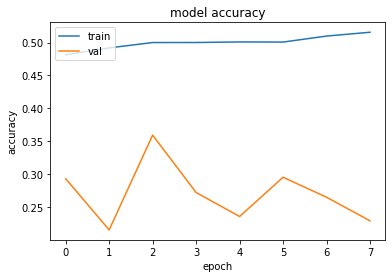

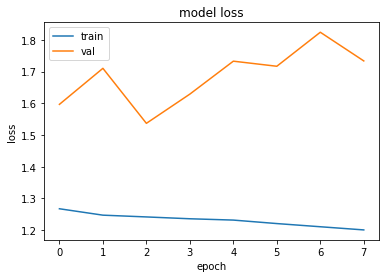

In [ ]:
history1_ne = new_model_ne1.fit(X1_ne_sm, y1_ne_df_sm, validation_data = (X_val_ne_sm,y_val_ne_sm),
               epochs=50,batch_size=64, callbacks =[cp_ne1,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history1_ne.history['categorical_accuracy'])
plt.plot(history1_ne.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1_ne.history['loss'])
plt.plot(history1_ne.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### 2.objective : False Negative

In [ ]:
def build_model_ne2(hp):
  model_ne2 = Sequential()
  model_ne2.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  kernel_reg1 = hp.Choice('kernel_reg1', values=[0.1, 0.01, 0.001, 0.0001, 0.00001])
  kernel_reg2 = hp.Choice('kernel_reg2', values=[0.1, 0.01, 0.001, 0.0001, 0.00001])
  kernel_reg3 = hp.Choice('kernel_reg3', values=[0.1, 0.01, 0.001, 0.0001, 0.00001])
  model_ne2.add(Dense(units=hp_units1, activation= LeakyReLU, kernel_regularizer=regularizers.L2(l2 = kernel_reg1)))
  model_ne2.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model_ne2.add(BatchNormalization())
  model_ne2.add(Dense(units=hp_units2, activation= LeakyReLU, kernel_regularizer=regularizers.L2(l2 = kernel_reg2)))
  model_ne2.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model_ne2.add(BatchNormalization())
  model_ne2.add(Dense(units=hp_units3, activation= LeakyReLU, kernel_regularizer=regularizers.L2(l2 = kernel_reg3)))
  model_ne2.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model_ne2.add(BatchNormalization())
  model_ne2.add(Dense(6, activation='softmax'))

  hp_optimizer_ne=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_ne == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_ne', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_ne == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_ne', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model_ne2.compile(
      optimizer= hp_optimizer_ne,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.FalseNegatives(name='false_negatives'),
               'categorical_accuracy']
  )
  return model_ne2

# HyperBand algorithm from keras tuner
tuner_ne2 = kt.Hyperband(
    build_model_ne2,
    objective= kt.Objective('val_false_negatives', direction="min"),
    max_epochs=50,
    directory='ne_dir2',
    project_name='holt2',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner_ne2.search(X1_ne_sm, y1_ne_df_sm, epochs=50, validation_data = (X_val_ne_sm,y_val_ne_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 02m 11s]
val_false_negatives: 1206.0

Best val_false_negatives So Far: 1118.0
Total elapsed time: 00h 51m 39s


In [ ]:
best_mlp_hyperparameters_ne2 = tuner_ne2.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters_ne2.values

Best Hyper-parameters


{'units1': 128,
 'units2': 192,
 'units3': 128,
 'kernel_reg1': 1e-05,
 'kernel_reg2': 0.001,
 'kernel_reg3': 0.1,
 'dropout_1': 0.1,
 'dropout_2': 0.3,
 'dropout_3': 0.0,
 'Optimizer': 'SGD',
 'learning_rate_ne': 0.1,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 3,
 'tuner/round': 0}

In [ ]:
best_model_ne2 = tuner_ne2.get_best_models()[0]
best_model_ne2.build(X1_ne_sm.shape)
best_model_ne2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (20970, 49)              196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (20970, 128)              6400      
                                                                 
 dropout (Dropout)           (20970, 128)              0         
                                                                 
 batch_normalization_1 (Batc  (20970, 128)             512       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (20970, 192)              24768     
                                                                 
 dropout_1 (Dropout)         (20970, 192)              0

In [ ]:
new_model_ne2 = Sequential()
new_model_ne2.add(tf.keras.Input(shape=(49,)))
new_model_ne2.add(BatchNormalization())
new_model_ne2.add(Dense(128, activation = LeakyReLU, kernel_regularizer=regularizers.L2(l2 = 0.00001)))
new_model_ne2.add(Dropout(0.1))
new_model_ne2.add(BatchNormalization())
new_model_ne2.add(Dense(192, activation = LeakyReLU, kernel_regularizer=regularizers.L2(l2 = 0.001)))
new_model_ne2.add(Dropout(0.3))
new_model_ne2.add(BatchNormalization())
new_model_ne2.add(Dense(128, activation = LeakyReLU, kernel_regularizer=regularizers.L2(l2 = 0.1)))
new_model_ne2.add(BatchNormalization())
new_model_ne2.add((Dense(6, activation='softmax')))
new_model_ne2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_32 (Bat  (None, 49)               196       
 chNormalization)                                                
                                                                 
 dense_32 (Dense)            (None, 128)               6400      
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_33 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_33 (Dense)            (None, 192)               24768     
                                                                 
 dropout_14 (Dropout)        (None, 192)              

In [ ]:
cp_ne2 = ModelCheckpoint('new_model_ne2/', save_best_only=True)
opt_ne2 = keras.optimizers.SGD(learning_rate=0.1)
new_model_ne2.compile(optimizer = opt_ne2, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_ne2.fit(X1_ne_sm, y1_ne_df_sm, validation_data = (X_val_ne_sm,y_val_ne_sm),
               epochs=50,batch_size=64, callbacks =[cp_ne2,early_stopping_monitor])

Epoch 1/50
327/328 [============================>.] - ETA: 0s - loss: 3.1645 - categorical_accuracy: 0.3061

328/328 [==============================] - 7s 16ms/step - loss: 3.1617 - categorical_accuracy: 0.3062 - val_loss: 13.7007 - val_categorical_accuracy: 0.3333
Epoch 2/50
327/328 [============================>.] - ETA: 0s - loss: 1.7825 - categorical_accuracy: 0.3429

328/328 [==============================] - 7s 23ms/step - loss: 1.7829 - categorical_accuracy: 0.3428 - val_loss: 3.7687 - val_categorical_accuracy: 0.3499
Epoch 3/50
324/328 [============================>.] - ETA: 0s - loss: 1.7259 - categorical_accuracy: 0.3621

328/328 [==============================] - 9s 28ms/step - loss: 1.7262 - categorical_accuracy: 0.3618 - val_loss: 1.8480 - val_categorical_accuracy: 0.2859
Epoch 4/50
324/328 [============================>.] - ETA: 0s - loss: 1.6886 - categorical_accuracy: 0.3698

328/328 [==============================] - 8s 24ms/step - loss: 1.6885 - categorical_accuracy: 0.3699 - val_loss: 1.7961 - val_categorical_accuracy: 0.2224
Epoch 5/50
323/328 [============================>.] - ETA: 0s - loss: 1.6507 - categorical_accuracy: 0.3835

328/328 [==============================] - 7s 23ms/step - loss: 1.6524 - categorical_accuracy: 0.3826 - val_loss: 1.7737 - val_categorical_accuracy: 0.2390
Epoch 6/50
328/328 [==============================] - 2s 7ms/step - loss: 1.6305 - categorical_accuracy: 0.3914 - val_loss: 1.7981 - val_categorical_accuracy: 0.1711
Epoch 7/50
325/328 [============================>.] - ETA: 0s - loss: 1.6073 - categorical_accuracy: 0.3941

328/328 [==============================] - 6s 17ms/step - loss: 1.6078 - categorical_accuracy: 0.3938 - val_loss: 1.6645 - val_categorical_accuracy: 0.2986
Epoch 8/50
328/328 [==============================] - 2s 7ms/step - loss: 1.5908 - categorical_accuracy: 0.4014 - val_loss: 1.7450 - val_categorical_accuracy: 0.2643
Epoch 9/50
328/328 [==============================] - 2s 7ms/step - loss: 1.5733 - categorical_accuracy: 0.4040 - val_loss: 1.7287 - val_categorical_accuracy: 0.2252
Epoch 10/50
328/328 [==============================] - 2s 7ms/step - loss: 1.5613 - categorical_accuracy: 0.4132 - val_loss: 1.7838 - val_categorical_accuracy: 0.2219
Epoch 11/50
328/328 [==============================] - 2s 7ms/step - loss: 1.5452 - categorical_accuracy: 0.4179 - val_loss: 1.9193 - val_categorical_accuracy: 0.1722
Epoch 12/50
328/328 [==============================] - 2s 7ms/step - loss: 1.5349 - categorical_accuracy: 0.4205 - val_loss: 1.8363 - val_categorical_accuracy: 0.2693


In [ ]:
test_predictions_ne2 = new_model_ne2.predict(X_test_ne)
test_predictions_ne2

23/23 [==============================] - 0s 2ms/step


array([[1.84587955e-01, 3.62027645e-01, 3.31118293e-02, 1.12635404e-01,
        2.06038138e-04, 3.07431221e-01],
       [2.44687811e-01, 5.99570513e-01, 1.47130815e-02, 7.04172626e-02,
        5.23884319e-06, 7.06061870e-02],
       [2.65811145e-01, 3.39320838e-01, 7.50183091e-02, 1.81667536e-01,
        1.89937453e-03, 1.36282802e-01],
       ...,
       [1.24614738e-01, 1.10247880e-01, 2.51156837e-01, 1.68679878e-01,
        8.84555206e-02, 2.56845146e-01],
       [2.28302374e-01, 4.66608226e-01, 2.44407225e-02, 8.27550590e-02,
        4.45414567e-04, 1.97448254e-01],
       [2.39959598e-01, 5.84442735e-01, 1.51833873e-02, 7.84137994e-02,
        1.82559452e-05, 8.19821656e-02]], dtype=float32)

In [ ]:
classes_ne2 = np.argmax(test_predictions_ne2, axis=-1)
classes_ne2

array([1, 1, 1, 1, 1, 0, 0, 1, 5, 5, 5, 5, 5, 5, 5, 1, 5, 1, 5, 5, 5, 5,
       1, 5, 5, 5, 0, 5, 1, 5, 5, 1, 1, 0, 5, 5, 5, 1, 1, 5, 5, 5, 5, 1,
       1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 5, 5, 1, 1, 1, 1, 5, 3,
       4, 5, 5, 5, 4, 2, 0, 5, 1, 1, 5, 5, 5, 5, 5, 4, 1, 1, 0, 2, 4, 3,
       5, 5, 2, 2, 5, 1, 0, 0, 2, 2, 2, 4, 4, 5, 1, 1, 0, 2, 2, 5, 4, 0,
       2, 2, 2, 2, 4, 4, 2, 2, 2, 3, 3, 4, 2, 2, 2, 0, 1, 2, 5, 4, 2, 5,
       0, 1, 0, 2, 0, 2, 2, 3, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 2, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 3, 0, 0, 1,
       1, 0, 2, 3, 2, 4, 4, 0, 0, 0, 0, 1, 4, 2, 5, 2, 0, 2, 4, 5, 5, 5,
       0, 5, 5, 2, 2, 5, 2, 2, 2, 4, 5, 5, 5, 5, 5,

In [ ]:
classes_ne2 =pd.DataFrame(classes_ne2, columns=['Test Predictions']) 
classes_ne2

Test Predictions
0                   1
1                   1
2                   1
3                   1
4                   1
..                ...
726                 5
727                 1
728                 5
729                 1
730                 1

[731 rows x 1 columns]

In [ ]:
classes_ne2 = classes_ne2.values.ravel()

In [ ]:
result_ne2 = pd.DataFrame({'Test Predictions':classes_ne2, 'Actuals':y_test_ne})
result_ne2[0:31]

Test Predictions  Actuals
0                  1        0
1                  1        0
2                  1        0
3                  1        0
4                  1        0
5                  0        0
6                  0        0
7                  1        0
8                  5        0
9                  5        0
10                 5        0
11                 5        0
12                 5        0
13                 5        0
14                 5        0
15                 1        0
16                 5        0
17                 1        0
18                 5        0
19                 5        0
20                 5        0
21                 5        0
22                 1        0
23                 5        0
24                 5        0
25                 5        0
26                 0        0
27                 5        0
28                 1        0
29                 5        0
30                 5        0

######model 2 evaluation

In [ ]:
print(classification_report(y_test_ne, classes_ne2, labels=np.unique(y_test_ne)))

              precision    recall  f1-score   support

           0       0.95      0.35      0.51       625
           1       0.01      0.22      0.03         9
           2       0.10      0.10      0.10        97

   micro avg       0.49      0.31      0.38       731
   macro avg       0.35      0.22      0.21       731
weighted avg       0.82      0.31      0.45       731



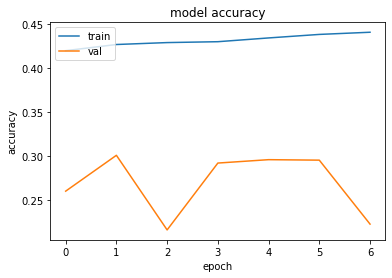

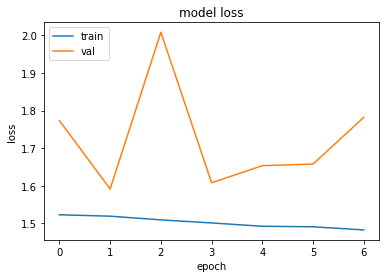

In [ ]:
history2_ne = new_model_ne2.fit(X1_ne_sm, y1_ne_df_sm, validation_data = (X_val_ne_sm,y_val_ne_sm),
               epochs=50,batch_size=64, callbacks =[cp_ne2,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history2_ne.history['categorical_accuracy'])
plt.plot(history2_ne.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2_ne.history['loss'])
plt.plot(history2_ne.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

####comparing the models

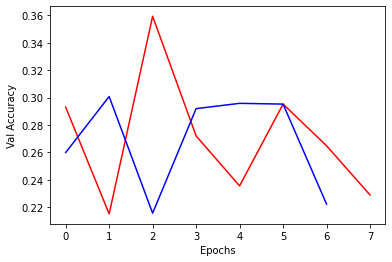

In [ ]:
plt.plot(history1_ne.history['val_categorical_accuracy'], 'r', history2_ne.history['val_categorical_accuracy'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Val Accuracy')
plt.show()

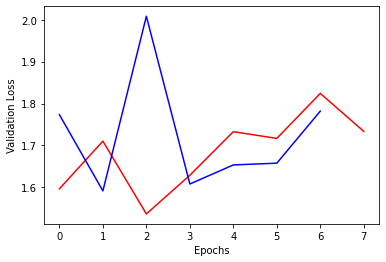

In [ ]:
plt.plot(history1_ne.history['val_loss'], 'r', history2_ne.history['val_loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.show()

###MLP model with weather and soil data (without date variable) REGRESSION

####preprocessing data

In [ ]:
score_ne = train_ne['score']
score_val_ne = val_ne['score']
score_test_ne = test_ne['score']

In [ ]:
score_arr_ne = score_ne.copy()
score_val_arr_ne = score_val_ne.copy()
score_test_arr_ne = score_test_ne.copy()

In [ ]:
score_arr_ne = score_arr_ne.to_numpy()
score_val_arr_ne = score_val_arr_ne.to_numpy()
score_test_arr_ne = score_test_arr_ne.to_numpy()

In [ ]:
score_arr_ne =pd.DataFrame(score_arr_ne, columns=['Score']) 
score_arr_ne

Score
0     2.732900
1     2.732900
2     2.732900
3     2.732900
4     2.739757
...        ...
6205  0.369100
6206  0.369100
6207  0.369100
6208  0.369100
6209  0.369100

[6210 rows x 1 columns]

In [ ]:
score_val_arr_ne =pd.DataFrame(score_val_arr_ne, columns=['Score']) 
score_val_arr_ne

Score
0    0.3691
1    0.3691
2    0.3691
3    0.3691
4    0.3691
..      ...
725  0.0000
726  0.0000
727  0.0000
728  0.0000
729  0.0000

[730 rows x 1 columns]

In [ ]:
score_test_arr_ne =pd.DataFrame(score_test_arr_ne, columns=['Score']) 
score_test_arr_ne

Score
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
..     ...
726    2.0
727    2.0
728    2.0
729    2.0
730    2.0

[731 rows x 1 columns]

In [ ]:
holt_train = train_ne.copy()
holt_val = val_ne.copy()
holt_test = test_ne.copy()

In [ ]:
X1_ne = holt_train.drop(columns=['fips','date','score'])
X_ne_val = holt_val.drop(columns=['fips','date','score'])
X_ne_test = holt_test.drop(columns=['fips','date','score'])

In [ ]:
X1_ne, y1_ne = X1_ne, score_arr_ne
X_val_ne, y_val_ne = X_ne_val, score_val_arr_ne
X_test_ne, y_test_ne = X_ne_test, score_test_arr_ne
X1_ne.shape, y1_ne.shape, X_val_ne.shape, y_val_ne.shape, X_test_ne.shape, y_test_ne.shape

((6210, 49), (6210, 1), (730, 49), (730, 1), (731, 49), (731, 1))

####build the model

In [ ]:
new_model_reg_ne1 = Sequential()
new_model_reg_ne1.add(tf.keras.Input(shape=(49,)))
new_model_reg_ne1.add(BatchNormalization())
new_model_reg_ne1.add(Dense(128, activation = "elu", kernel_initializer="he_normal"))
new_model_reg_ne1.add(BatchNormalization())
new_model_reg_ne1.add(Dense(64, activation = "elu", kernel_initializer="he_normal"))
new_model_reg_ne1.add(BatchNormalization())
new_model_reg_ne1.add((Dense(1, activation='linear')))
new_model_reg_ne1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 49)               196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               6400      
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                        

In [ ]:
opt_reg_ne1 = keras.optimizers.Adam(learning_rate=0.001)
new_model_reg_ne1.compile(optimizer = opt_reg_ne1, loss =MeanSquaredError(), metrics =[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_reg_ne1.fit(X1_ne, y1_ne, validation_data = (X_val_ne,y_val_ne),
               epochs=50,batch_size=64, callbacks =[early_stopping_monitor])

Epoch 1/50
98/98 [==============================] - 3s 10ms/step - loss: 2.1479 - root_mean_squared_error: 1.4656 - val_loss: 18281.9375 - val_root_mean_squared_error: 135.2107
Epoch 2/50
98/98 [==============================] - 1s 7ms/step - loss: 1.6891 - root_mean_squared_error: 1.2996 - val_loss: 7798.5234 - val_root_mean_squared_error: 88.3092
Epoch 3/50
98/98 [==============================] - 1s 8ms/step - loss: 1.6346 - root_mean_squared_error: 1.2785 - val_loss: 3189.0032 - val_root_mean_squared_error: 56.4713
Epoch 4/50
98/98 [==============================] - 1s 7ms/step - loss: 1.6423 - root_mean_squared_error: 1.2815 - val_loss: 1078.7146 - val_root_mean_squared_error: 32.8438
Epoch 5/50
98/98 [==============================] - 1s 6ms/step - loss: 1.6105 - root_mean_squared_error: 1.2691 - val_loss: 381.1521 - val_root_mean_squared_error: 19.5231
Epoch 6/50
98/98 [==============================] - 1s 6ms/step - loss: 1.6036 - root_mean_squared_error: 1.2663 - val_loss: 92.

In [ ]:
test_predictions_reg_ne1 = new_model_reg_ne1.predict(X_test_ne).flatten()
test_predictions_reg_ne1

23/23 [==============================] - 0s 3ms/step


array([ 0.8781042 ,  0.7697248 ,  0.74690807,  0.7347798 ,  0.7323576 ,
        0.6319095 ,  0.41380346,  0.6461959 ,  1.283026  ,  1.0133176 ,
        0.965413  ,  1.0126698 ,  0.7811054 ,  0.9799627 ,  1.1150082 ,
        0.58486104,  0.97786474,  0.84601444,  1.0954485 ,  1.2167832 ,
        0.9376011 ,  0.70384055,  0.926803  ,  1.1725404 ,  0.9078154 ,
        0.9291441 ,  0.32910892,  0.9602224 ,  0.828079  ,  0.69234324,
        0.95544136,  0.9896014 ,  1.0099962 ,  0.6509936 ,  1.1362935 ,
        0.7211549 ,  1.1787727 ,  0.4278977 ,  0.68609977,  0.98259556,
        1.0489088 ,  0.9795091 ,  1.1452742 ,  1.034928  ,  0.99162364,
        0.67816424,  0.54516983,  1.0364556 ,  0.9460708 ,  0.72013044,
        0.5814673 ,  0.6150292 ,  0.8188124 ,  0.66941094,  0.6237761 ,
        0.7714014 ,  0.5754849 ,  0.7639048 ,  0.6278616 ,  0.6787014 ,
        0.60800135,  0.43642795,  0.4337889 ,  0.7424224 ,  0.83981466,
        0.7021035 ,  0.507197  ,  0.50459504,  0.90875065,  0.76

In [ ]:
test_predictions_reg_ne1 =pd.DataFrame(test_predictions_reg_ne1, columns=['Test Predictions']) 
test_predictions_reg_ne1

Test Predictions
0            0.878104
1            0.769725
2            0.746908
3            0.734780
4            0.732358
..                ...
726          0.871936
727          0.810141
728          0.905723
729          0.786410
730          0.854902

[731 rows x 1 columns]

In [ ]:
test_predictions_reg_ne1 = test_predictions_reg_ne1.values.ravel()
y_test_ne = y_test_ne.values.ravel()

In [ ]:
test_results_reg_ne_1 = pd.DataFrame(data={'predictions':test_predictions_reg_ne1, 'actuals':y_test_ne})
test_results_reg_ne_1

predictions  actuals
0       0.878104      0.0
1       0.769725      0.0
2       0.746908      0.0
3       0.734780      0.0
4       0.732358      0.0
..           ...      ...
726     0.871936      2.0
727     0.810141      2.0
728     0.905723      2.0
729     0.786410      2.0
730     0.854902      2.0

[731 rows x 2 columns]

In [ ]:
test_results_reg_ne_1[500:550]

predictions   actuals
500     0.890141  0.000000
501     0.750879  0.000000
502     0.357153  0.000000
503     0.457539  0.000000
504     0.682845  0.000000
505     0.432437  0.000000
506     0.671499  0.000000
507     0.332958  0.000000
508     0.879233  0.000000
509     0.645499  0.000000
510     0.459169  0.000000
511     0.602203  0.000000
512     0.694021  0.000000
513     0.305570  0.000000
514     0.581109  0.000000
515     0.580309  0.000000
516    -0.151987  0.000000
517     0.453243  0.000000
518     0.573269  0.000000
519     0.799727  0.000000
520     1.034730  0.000000
521     0.726496  0.000000
522    -0.217945  0.000000
523    -0.264622  0.000000
524     0.351748  0.000000
525     0.003421  0.000000
526     0.200915  0.000000
527     0.769244  0.000000
528     0.364051  0.000000
529     0.386545  0.000000
530     0.004011  0.000000
531     0.557921  0.000000
532    -0.177175  0.000000
533     0.157867  0.000000
534     0.865081  0.000000
535     0.784920  0.000000
536     0.800614  0.000000
537     0.841001  0.000000
538     0.823374  0.000000
539     0.799093  0.000000
540     1.061479  0.000000
541     0.676441  0.000000
542     0.802357  0.000000
543     0.481856  0.000000
544     0.475990  0.000000
545     0.407976  0.000000
546     0.248884  0.000000
547     1.234219  0.002071
548     0.448753  0.004143
549     0.736776  0.006214

####model evaluation

In [ ]:
new_model_reg_ne1.evaluate(X1_ne,y1_ne)

195/195 [==============================] - 1s 3ms/step - loss: 1.5466 - root_mean_squared_error: 1.2436


[1.5466437339782715, 1.2436413764953613]

In [ ]:
new_model_reg_ne1.evaluate(X_test_ne,y_test_ne)

23/23 [==============================] - 0s 3ms/step - loss: 0.7190 - root_mean_squared_error: 0.8480


[0.7190428972244263, 0.8479639887809753]

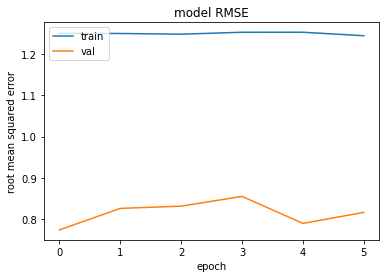

In [ ]:
history_reg_ne_1 = new_model_reg_ne1.fit(X1_ne, y1_ne, validation_data = (X_val_ne,y_val_ne),
               epochs=50,batch_size=64, callbacks =[early_stopping_monitor], verbose=False)

# summarize history for accuracy
plt.plot(history_reg_ne_1.history['root_mean_squared_error'])
plt.plot(history_reg_ne_1.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_results_reg_ne_1.predictions[test_results_reg_ne_1.predictions <0.5] = 0
test_results_reg_ne_1.predictions[(test_results_reg_ne_1.predictions >=0.5)&(test_results_reg_ne_1.predictions<1.5)] = 1
test_results_reg_ne_1.predictions[(test_results_reg_ne_1.predictions >=1.5)&(test_results_reg_ne_1.predictions<2.5)] = 2
test_results_reg_ne_1.predictions[(test_results_reg_ne_1.predictions >=2.5)&(test_results_reg_ne_1.predictions<3.5)] = 3
test_results_reg_ne_1.predictions[(test_results_reg_ne_1.predictions >=3.5)&(test_results_reg_ne_1.predictions<4.5)] = 4
test_results_reg_ne_1.predictions[(test_results_reg_ne_1.predictions >=4.5)&(test_results_reg_ne_1.predictions<5.5)] = 5
test_results_reg_ne_1.actuals[test_results_reg_ne_1.actuals <0.5] = 0
test_results_reg_ne_1.actuals[(test_results_reg_ne_1.actuals >=0.5)&(test_results_reg_ne_1.actuals<1.5)] = 1
test_results_reg_ne_1.actuals[(test_results_reg_ne_1.actuals >=1.5)&(test_results_reg_ne_1.actuals<2.5)] = 2
test_results_reg_ne_1.actuals[(test_results_reg_ne_1.actuals >=2.5)&(test_results_reg_ne_1.actuals<3.5)] = 3
test_results_reg_ne_1.actuals[(test_results_reg_ne_1.actuals >=3.5)&(test_results_reg_ne_1.actuals<4.5)] = 4
test_results_reg_ne_1.actuals[(test_results_reg_ne_1.actuals >=4.5)&(test_results_reg_ne_1.actuals<5.5)] = 5
test_results_reg_ne_1

predictions  actuals
0            1.0      0.0
1            1.0      0.0
2            1.0      0.0
3            1.0      0.0
4            1.0      0.0
..           ...      ...
726          1.0      2.0
727          1.0      2.0
728          1.0      2.0
729          1.0      2.0
730          1.0      2.0

[731 rows x 2 columns]

In [ ]:
test_results_reg_ne_1[200:250]

predictions  actuals
200          1.0      0.0
201          0.0      0.0
202          1.0      0.0
203          1.0      0.0
204          0.0      0.0
205          0.0      0.0
206          1.0      0.0
207          1.0      0.0
208          0.0      0.0
209          1.0      0.0
210          0.0      0.0
211          0.0      0.0
212          0.0      0.0
213          0.0      0.0
214          1.0      0.0
215          1.0      0.0
216          0.0      0.0
217          1.0      0.0
218          1.0      0.0
219          1.0      0.0
220          0.0      0.0
221          0.0      0.0
222          1.0      0.0
223          0.0      0.0
224          0.0      0.0
225          1.0      0.0
226          1.0      0.0
227          1.0      0.0
228          0.0      0.0
229          0.0      0.0
230          0.0      0.0
231          0.0      0.0
232          1.0      0.0
233          0.0      0.0
234          0.0      0.0
235          0.0      0.0
236          0.0      0.0
237          1.0      0.0
238          0.0      0.0
239          1.0      0.0
240          1.0      0.0
241          1.0      0.0
242          0.0      0.0
243          0.0      0.0
244          0.0      0.0
245          0.0      0.0
246          1.0      0.0
247          0.0      0.0
248          1.0      0.0
249          0.0      0.0

In [ ]:
print(classification_report(test_results_reg_ne_1['actuals'], test_results_reg_ne_1['predictions']))

              precision    recall  f1-score   support

         0.0       0.93      0.24      0.39       625
         1.0       0.01      0.67      0.02         9
         2.0       0.31      0.04      0.07        97

    accuracy                           0.22       731
   macro avg       0.42      0.32      0.16       731
weighted avg       0.83      0.22      0.34       731



###LSTM model without weather and soil data, only using previous drought scores

In [ ]:
def df_to_X_y(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 7
X_train_ne, y_train_ne = df_to_X_y(score_ne, WINDOW_SIZE)
X_val1_ne, y_val1_ne = df_to_X_y(score_val_ne, WINDOW_SIZE)
X_test1_ne, y_test1_ne = df_to_X_y(score_test_ne, WINDOW_SIZE)
X_train_ne.shape, y_train_ne.shape, X_val1_ne.shape, y_val1_ne.shape, X_test1_ne.shape, y_test1_ne.shape

((6203, 7, 1), (6203,), (723, 7, 1), (723,), (724, 7, 1), (724,))

In [ ]:
model_1 = Sequential()
model_1.add(InputLayer((7,1)))
model_1.add(LSTM(64))
model_1.add(Dense(8, 'relu'))
model_1.add(Dense(1, 'linear'))

model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                16896     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

model_1.fit(X_train_ne, y_train_ne, validation_data=(X_val1_ne, y_val1_ne), epochs=50, 
           callbacks = [early_stopping_monitor])

Epoch 1/50
194/194 [==============================] - 3s 9ms/step - loss: 1.8471 - root_mean_squared_error: 1.3591 - val_loss: 0.0698 - val_root_mean_squared_error: 0.2642
Epoch 2/50
194/194 [==============================] - 1s 6ms/step - loss: 0.3247 - root_mean_squared_error: 0.5699 - val_loss: 0.0361 - val_root_mean_squared_error: 0.1900
Epoch 3/50
194/194 [==============================] - 1s 6ms/step - loss: 0.1154 - root_mean_squared_error: 0.3397 - val_loss: 0.0278 - val_root_mean_squared_error: 0.1669
Epoch 4/50
194/194 [==============================] - 1s 6ms/step - loss: 0.0756 - root_mean_squared_error: 0.2749 - val_loss: 0.0260 - val_root_mean_squared_error: 0.1613
Epoch 5/50
194/194 [==============================] - 1s 6ms/step - loss: 0.0558 - root_mean_squared_error: 0.2363 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1556
Epoch 6/50
194/194 [==============================] - 1s 6ms/step - loss: 0.0426 - root_mean_squared_error: 0.2065 - val_loss: 0.0224 - val_

####using the model to predict the test dataset

In [ ]:
test_prediction_ne_1 = model_1.predict(X_test1_ne).flatten()
test_results_ne_1 = pd.DataFrame(data={'predictions':test_prediction_ne_1, 'actuals':y_test1_ne})
test_results_ne_1

23/23 [==============================] - 0s 2ms/step


predictions  actuals
0       0.008496      0.0
1       0.008496      0.0
2       0.008496      0.0
3       0.008496      0.0
4       0.008496      0.0
..           ...      ...
719     2.006894      2.0
720     2.006894      2.0
721     2.006894      2.0
722     2.006894      2.0
723     2.006894      2.0

[724 rows x 2 columns]

In [ ]:
test_results_ne_1.predictions[test_results_ne_1.predictions <0.5] = 0
test_results_ne_1.predictions[(test_results_ne_1.predictions >=0.5)&(test_results_ne_1.predictions<1.5)] = 1
test_results_ne_1.predictions[(test_results_ne_1.predictions >=1.5)&(test_results_ne_1.predictions<2.5)] = 2
test_results_ne_1.predictions[(test_results_ne_1.predictions >=2.5)&(test_results_ne_1.predictions<3.5)] = 3
test_results_ne_1.predictions[(test_results_ne_1.predictions >=3.5)&(test_results_ne_1.predictions<4.5)] = 4
test_results_ne_1.predictions[(test_results_ne_1.predictions >=4.5)&(test_results_ne_1.predictions<5.5)] = 5
test_results_ne_1

predictions  actuals
0            0.0      0.0
1            0.0      0.0
2            0.0      0.0
3            0.0      0.0
4            0.0      0.0
..           ...      ...
719          2.0      2.0
720          2.0      2.0
721          2.0      2.0
722          2.0      2.0
723          2.0      2.0

[724 rows x 2 columns]

In [ ]:
test_results_ne_1.actuals[test_results_ne_1.actuals <0.5] = 0
test_results_ne_1.actuals[(test_results_ne_1.actuals >=0.5)&(test_results_ne_1.actuals<1.5)] = 1
test_results_ne_1.actuals[(test_results_ne_1.actuals >=1.5)&(test_results_ne_1.actuals<2.5)] = 2
test_results_ne_1.actuals[(test_results_ne_1.actuals >=2.5)&(test_results_ne_1.actuals<3.5)] = 3
test_results_ne_1.actuals[(test_results_ne_1.actuals >=3.5)&(test_results_ne_1.actuals<4.5)] = 4
test_results_ne_1.actuals[(test_results_ne_1.actuals >=4.5)&(test_results_ne_1.actuals<5.5)] = 5
test_results_ne_1

predictions  actuals
0            0.0      0.0
1            0.0      0.0
2            0.0      0.0
3            0.0      0.0
4            0.0      0.0
..           ...      ...
719          2.0      2.0
720          2.0      2.0
721          2.0      2.0
722          2.0      2.0
723          2.0      2.0

[724 rows x 2 columns]

####model evaluation

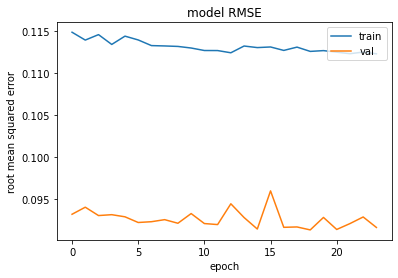

In [ ]:
history_ne_1 = model_1.fit(X_train_ne, y_train_ne, validation_data=(X_val1_ne, y_val1_ne), epochs=50, 
           callbacks = [early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history_ne_1.history['root_mean_squared_error'])
plt.plot(history_ne_1.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
print(classification_report(test_results_ne_1['actuals'], test_results_ne_1['predictions']))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       618
         1.0       0.89      0.89      0.89         9
         2.0       1.00      0.99      0.99        97

    accuracy                           1.00       724
   macro avg       0.96      0.96      0.96       724
weighted avg       1.00      1.00      1.00       724



###LSTM model with only score data and time data but the time data is transformed using sine and cosine

####train

In [ ]:
train_ne1 = train_ne.copy()
train_ne1.index = pd.to_datetime(train_ne1['date'], format='%Y.%m.%d')
train_ne1[:31]

fips        date  PRECTOT     PS  QV2M   T2M  T2MDEW  T2MWET  \
date                                                                        
2000-01-01  31089  2000-01-01     0.01  93.41  2.75 -1.44   -5.13   -5.08   
2000-01-02  31089  2000-01-02     0.04  93.59  2.20 -2.04   -7.86   -7.72   
2000-01-03  31089  2000-01-03     0.45  94.43  2.07 -5.37   -9.04   -8.87   
2000-01-04  31089  2000-01-04     0.00  94.70  1.23 -8.35  -14.42  -14.00   
2000-01-05  31089  2000-01-05     0.75  93.78  2.93 -0.28   -4.69   -4.61   
2000-01-06  31089  2000-01-06     0.00  94.93  2.30 -1.26   -7.13   -7.01   
2000-01-07  31089  2000-01-07     0.00  94.57  2.10 -0.22   -8.30   -8.11   
2000-01-08  31089  2000-01-08     0.00  93.67  2.27  2.33   -7.43   -7.25   
2000-01-09  31089  2000-01-09     0.10  92.81  2.98  1.33   -4.38   -4.31   
2000-01-10  31089  2000-01-10     0.00  92.94  1.85  0.09  -10.03   -9.68   
2000-01-11  31089  2000-01-11     0.00  93.75  1.85 -0.47   -9.83   -9.53   
2000-01-12  31089  2000-01-12     0.00  93.99  2.00 -2.83   -8.94   -8.77   
2000-01-13  31089  2000-01-13     0.00  95.82  1.80 -2.55   -9.85   -9.63   
2000-01-14  31089  2000-01-14     0.00  94.84  2.61  1.68   -5.72   -5.61   
2000-01-15  31089  2000-01-15     0.12  94.42  3.30  1.74   -2.71   -2.68   
2000-01-16  31089  2000-01-16     0.00  95.52  1.39 -5.48  -12.96  -12.48   
2000-01-17  31089  2000-01-17     0.18  94.67  2.75  0.01   -5.43   -5.32   
2000-01-18  31089  2000-01-18     0.15  94.77  3.02  1.69   -3.93   -3.85   
2000-01-19  31089  2000-01-19     1.43  94.27  2.48 -3.68   -7.29   -7.14   
2000-01-20  31089  2000-01-20     0.00  94.71  1.77 -4.46  -10.25  -10.08   
2000-01-21  31089  2000-01-21     0.00  93.84  2.03 -3.21   -8.86   -8.72   
2000-01-22  31089  2000-01-22     0.00  93.89  2.49 -0.80   -6.40   -6.30   
2000-01-23  31089  2000-01-23     0.08  94.71  1.19 -5.90  -14.53  -13.90   
2000-01-24  31089  2000-01-24     0.01  94.49  1.92 -3.30   -9.30   -9.13   
2000-01-25  31089  2000-01-25     0.00  95.18  1.49 -7.35  -11.99  -11.76   
2000-01-26  31089  2000-01-26     0.06  94.82  1.45 -6.66  -12.42  -12.11   
2000-01-27  31089  2000-01-27     0.32  95.13  1.71 -5.05  -10.56  -10.35   
2000-01-28  31089  2000-01-28     2.23  95.33  2.00 -5.88   -8.66   -8.58   
2000-01-29  31089  2000-01-29     0.36  95.25  1.82 -7.19   -9.81   -9.72   
2000-01-30  31089  2000-01-30     0.00  95.06  1.73 -7.58  -10.38  -10.28   
2000-01-31  31089  2000-01-31     0.00  94.53  2.06 -4.87   -8.48   -8.41   

            T2M_MAX  T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                         
2000-01-01     2.68    -3.58       6.25 -1.61   4.19       5.79       2.51   
2000-01-02     1.90    -3.85       5.74 -1.58   4.82       7.75       1.95   
2000-01-03    -2.24   -12.52      10.28 -5.01   8.21      12.51       2.48   
2000-01-04    -1.13   -14.98      13.85 -7.72   5.61       8.52       2.29   
2000-01-05     4.49    -3.13       7.62 -0.85   5.99       9.33       4.16   
2000-01-06     4.84    -4.71       9.55 -2.00   5.01      10.11       1.41   
2000-01-07     8.97    -5.66      14.63 -1.26   5.12       8.12       2.71   
2000-01-08     9.10    -1.05      10.14  0.21   2.86       4.05       1.48   
2000-01-09     7.69    -1.98       9.67  0.57   5.35       8.46       4.17   
2000-01-10     5.69    -4.20       9.90 -0.52   8.98      14.46       3.83   
2000-01-11     5.58    -4.57      10.16 -0.51   5.21       8.98       2.56   
2000-01-12     2.82    -8.92      11.74 -2.52   5.46       8.29       0.95   
2000-01-13     5.79   -10.10      15.89 -2.93   3.75       8.11       1.59   
2000-01-14    10.64    -2.57      13.20  0.62   6.13       9.60       2.70   
2000-01-15    10.29    -3.62      13.91  1.02   5.47       6.44       4.08   
2000-01-16    -4.08    -7.75       3.67 -4.31   6.33       7.96       4.47   
2000-01-17     5.43    -4.50       9.93 -0.98   4.34       7.65    

In [ ]:
scorene = train_ne1['score']
scorene_df = pd.DataFrame({'score':scorene})
scorene_df['Seconds'] = scorene_df.index.map(pd.Timestamp.timestamp)
scorene_df

score       Seconds
date                           
2000-01-01    3.0  9.466848e+08
2000-01-02    3.0  9.467712e+08
2000-01-03    3.0  9.468576e+08
2000-01-04    3.0  9.469440e+08
2000-01-05    3.0  9.470304e+08
...           ...           ...
2016-12-27    0.0  1.482797e+09
2016-12-28    0.0  1.482883e+09
2016-12-29    0.0  1.482970e+09
2016-12-30    0.0  1.483056e+09
2016-12-31    0.0  1.483142e+09

[6210 rows x 2 columns]

In [ ]:
day = 60*60*24
month = 30.437*day
year = 365.2425*day

scorene_df['Day sin'] = np.sin(scorene_df['Seconds'] * (2* np.pi / day))
scorene_df['Day cos'] = np.cos(scorene_df['Seconds'] * (2 * np.pi / day))
scorene_df['Month sin'] = np.sin(scorene_df['Seconds'] * (2* np.pi / month))
scorene_df['Month cos'] = np.cos(scorene_df['Seconds'] * (2 * np.pi / month))
scorene_df['Year sin'] = np.sin(scorene_df['Seconds'] * (2 * np.pi / year))
scorene_df['Year cos'] = np.cos(scorene_df['Seconds'] * (2 * np.pi / year))
scorene_df.head()

score      Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                          
2000-01-01    3.0  946684800.0 -5.461913e-12      1.0  -0.066010   0.997819   
2000-01-02    3.0  946771200.0 -1.163374e-12      1.0   0.139914   0.990164   
2000-01-03    3.0  946857600.0  3.135164e-12      1.0   0.339896   0.940463   
2000-01-04    3.0  946944000.0 -7.118212e-12      1.0   0.525446   0.850827   
2000-01-05    3.0  947030400.0 -2.819674e-12      1.0   0.688683   0.725062   

            Year sin  Year cos  
date                            
2000-01-01 -0.004731  0.999989  
2000-01-02  0.012472  0.999922  
2000-01-03  0.029670  0.999560  
2000-01-04  0.046860  0.998901  
2000-01-05  0.064036  0.997948

In [ ]:
scorene_df = scorene_df.drop('Seconds', axis=1)
scorene_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2000-01-01    3.0 -5.461913e-12      1.0  -0.066010   0.997819 -0.004731   
2000-01-02    3.0 -1.163374e-12      1.0   0.139914   0.990164  0.012472   
2000-01-03    3.0  3.135164e-12      1.0   0.339896   0.940463  0.029670   
2000-01-04    3.0 -7.118212e-12      1.0   0.525446   0.850827  0.046860   
2000-01-05    3.0 -2.819674e-12      1.0   0.688683   0.725062  0.064036   

            Year cos  
date                  
2000-01-01  0.999989  
2000-01-02  0.999922  
2000-01-03  0.999560  
2000-01-04  0.998901  
2000-01-05  0.997948

####val

In [ ]:
val_ne1 = val_ne.copy()
val_ne1.index = pd.to_datetime(val_ne1['date'], format='%Y.%m.%d')
val_ne1[:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  \
date                                                                         
2017-01-01  31089  2017-01-01     0.04  93.66  2.63  -2.85   -5.65   -5.61   
2017-01-02  31089  2017-01-02     0.06  93.92  2.77  -3.09   -5.48   -5.42   
2017-01-03  31089  2017-01-03     0.00  95.10  0.95 -12.34  -16.73  -16.24   
2017-01-04  31089  2017-01-04     1.29  94.87  0.79 -14.59  -18.56  -17.98   
2017-01-05  31089  2017-01-05     0.01  94.66  0.74 -14.68  -19.22  -18.49   
2017-01-06  31089  2017-01-06     0.00  94.85  0.87 -12.98  -17.66  -17.15   
2017-01-07  31089  2017-01-07     0.00  95.91  1.04 -12.60  -15.77  -15.46   
2017-01-08  31089  2017-01-08     0.00  94.90  1.61  -7.43  -11.40  -11.25   
2017-01-09  31089  2017-01-09     0.00  93.46  2.78  -2.89   -5.85   -5.78   
2017-01-10  31089  2017-01-10     0.03  93.09  2.45  -2.72   -7.03   -6.91   
2017-01-11  31089  2017-01-11     2.36  93.64  1.28 -10.57  -14.79  -14.34   
2017-01-12  31089  2017-01-12     0.01  95.11  1.05 -10.39  -15.71  -15.24   
2017-01-13  31089  2017-01-13     0.01  95.86  1.16  -8.16  -14.67  -14.16   
2017-01-14  31089  2017-01-14     0.00  95.54  2.01  -4.18   -8.74   -8.63   
2017-01-15  31089  2017-01-15     1.22  94.79  2.58  -2.80   -5.86   -5.81   
2017-01-16  31089  2017-01-16     3.90  94.27  3.01  -2.06   -3.93   -3.91   
2017-01-17  31089  2017-01-17     0.03  94.31  2.64  -2.14   -5.60   -5.56   
2017-01-18  31089  2017-01-18     0.00  93.78  3.29   0.22   -3.08   -3.04   
2017-01-19  31089  2017-01-19     0.06  93.07  4.12   1.02    0.10    0.10   
2017-01-20  31089  2017-01-20     0.16  92.40  3.96   1.00   -0.58   -0.58   
2017-01-21  31089  2017-01-21     0.01  92.48  3.81   2.02   -1.05   -1.03   
2017-01-22  31089  2017-01-22     0.00  93.60  3.00  -0.23   -4.08   -4.03   
2017-01-23  31089  2017-01-23     0.02  93.51  2.97   0.36   -4.17   -4.12   
2017-01-24  31089  2017-01-24    13.98  93.15  3.06  -2.43   -3.81   -3.80   
2017-01-25  31089  2017-01-25     2.14  93.94  2.20  -5.76   -7.76   -7.72   
2017-01-26  31089  2017-01-26     0.02  94.53  1.93  -6.86   -9.32   -9.25   
2017-01-27  31089  2017-01-27     0.00  94.47  2.60  -3.70   -6.14   -6.08   
2017-01-28  31089  2017-01-28     0.03  94.35  3.29  -0.38   -2.79   -2.78   
2017-01-29  31089  2017-01-29     0.01  94.31  3.61   1.20   -1.56   -1.55   
2017-01-30  31089  2017-01-30     0.00  93.89  3.03   2.85   -3.92   -3.85   
2017-01-31  31089  2017-01-31     0.16  94.26  2.76  -0.15   -4.99   -4.92   

            T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                          
2017-01-01     1.54    -6.57       8.12  -3.38   3.81       4.91       2.34   
2017-01-02     1.97    -9.66      11.63  -2.83   5.46      10.66       1.65   
2017-01-03    -9.98   -14.74       4.76 -11.85   8.76      10.70       5.71   
2017-01-04   -13.49   -16.25       2.76 -13.68   4.39       6.10       2.84   
2017-01-05   -12.67   -17.33       4.67 -14.38   5.66       8.80       2.78   
2017-01-06    -6.17   -18.73      12.56 -13.15   3.69       6.11       2.43   
2017-01-07    -7.69   -16.05       8.36 -11.83   3.63       6.02       0.46   
2017-01-08     2.13   -13.89      16.02  -7.44   6.52      10.42       3.11   
2017-01-09     5.02    -9.57      14.59  -3.07   4.97      10.63       0.34   
2017-01-10     0.19    -7.09       7.28  -2.59   7.52      13.64       1.21   
2017-01-11    -1.89   -13.32      11.43  -9.61   7.14      10.95       2.43   
2017-01-12    -5.10   -14.36       9.25 -10.17   3.34       6.07       1.08   
2017-01-13    -3.55   -11.67       8.13  -7.68   3.81       5.45       1.87   
2017-01-14     2.89    -9.01      11.90  -4.55   2.66       3.22       1.78   
2017-01-15     2.05    -7.85       9.90  -3.29   2.95       4.52       1.93   
2017-01-16     0.18    -6.16       6.33  -2.27   4.65       7.36       0.79   
2017-01-17     4

In [ ]:
scorene_val = val_ne1['score']
scorene_val_df = pd.DataFrame({'score':scorene_val})
scorene_val_df['Seconds'] = scorene_val_df.index.map(pd.Timestamp.timestamp)
scorene_val_df

score       Seconds
date                           
2017-01-01    0.0  1.483229e+09
2017-01-02    0.0  1.483315e+09
2017-01-03    0.0  1.483402e+09
2017-01-04    0.0  1.483488e+09
2017-01-05    0.0  1.483574e+09
...           ...           ...
2018-12-27    0.0  1.545869e+09
2018-12-28    0.0  1.545955e+09
2018-12-29    0.0  1.546042e+09
2018-12-30    0.0  1.546128e+09
2018-12-31    0.0  1.546214e+09

[730 rows x 2 columns]

In [ ]:
scorene_val_df['Day sin'] = np.sin(scorene_val_df['Seconds'] * (2* np.pi / day))
scorene_val_df['Day cos'] = np.cos(scorene_val_df['Seconds'] * (2 * np.pi / day))
scorene_val_df['Month sin'] = np.sin(scorene_val_df['Seconds'] * (2* np.pi / month))
scorene_val_df['Month cos'] = np.cos(scorene_val_df['Seconds'] * (2 * np.pi / month))
scorene_val_df['Year sin'] = np.sin(scorene_val_df['Seconds'] * (2 * np.pi / year))
scorene_val_df['Year cos'] = np.cos(scorene_val_df['Seconds'] * (2 * np.pi / year))
scorene_val_df.head()

score       Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                           
2017-01-01    0.0  1.483229e+09  2.504006e-13      1.0   0.109601   0.993976   
2017-01-02    0.0  1.483315e+09 -1.000298e-11      1.0   0.311009   0.950407   
2017-01-03    0.0  1.483402e+09 -5.704437e-12      1.0   0.499210   0.866481   
2017-01-04    0.0  1.483488e+09 -1.405899e-12      1.0   0.666213   0.745761   
2017-01-05    0.0  1.483574e+09 -1.165928e-11      1.0   0.804927   0.593374   

            Year sin  Year cos  
date                            
2017-01-01  0.010364  0.999946  
2017-01-02  0.027564  0.999620  
2017-01-03  0.044755  0.998998  
2017-01-04  0.061933  0.998080  
2017-01-05  0.079093  0.996867

In [ ]:
scorene_val_df = scorene_val_df.drop('Seconds', axis=1)
scorene_val_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2017-01-01    0.0  2.504006e-13      1.0   0.109601   0.993976  0.010364   
2017-01-02    0.0 -1.000298e-11      1.0   0.311009   0.950407  0.027564   
2017-01-03    0.0 -5.704437e-12      1.0   0.499210   0.866481  0.044755   
2017-01-04    0.0 -1.405899e-12      1.0   0.666213   0.745761  0.061933   
2017-01-05    0.0 -1.165928e-11      1.0   0.804927   0.593374  0.079093   

            Year cos  
date                  
2017-01-01  0.999946  
2017-01-02  0.999620  
2017-01-03  0.998998  
2017-01-04  0.998080  
2017-01-05  0.996867

####test

In [ ]:
test_ne1 = test_ne.copy()
test_ne1.index = pd.to_datetime(test_ne1['date'], format='%Y.%m.%d')
test_ne1[:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  \
date                                                                         
2019-01-01  31089  2019-01-01     0.00  95.27  0.79 -14.89  -20.44  -18.10   
2019-01-02  31089  2019-01-02     0.00  94.19  2.00  -6.56   -9.34   -9.62   
2019-01-03  31089  2019-01-03     0.00  93.89  3.01  -1.30   -4.07   -4.15   
2019-01-04  31089  2019-01-04     0.00  93.78  3.66   1.43   -1.45   -1.51   
2019-01-05  31089  2019-01-05     0.00  94.15  3.94   1.83   -0.39   -0.44   
2019-01-06  31089  2019-01-06     0.00  93.18  4.18   1.05    0.25    0.26   
2019-01-07  31089  2019-01-07     0.02  93.21  3.88   3.40   -0.69   -0.69   
2019-01-08  31089  2019-01-08     0.03  95.08  2.55   0.57   -6.07   -5.90   
2019-01-09  31089  2019-01-09     0.00  95.57  1.73  -3.38  -11.00  -10.14   
2019-01-10  31089  2019-01-10     0.00  94.55  2.87  -1.19   -4.59   -4.53   
2019-01-11  31089  2019-01-11     0.00  94.49  3.19  -0.65   -3.20   -3.10   
2019-01-12  31089  2019-01-12     0.03  95.15  2.13  -5.11   -8.41   -7.98   
2019-01-13  31089  2019-01-13     0.01  95.25  2.71  -2.78   -5.25   -5.10   
2019-01-14  31089  2019-01-14     0.00  94.87  2.88  -1.82   -4.51   -4.34   
2019-01-15  31089  2019-01-15     0.00  94.52  2.83  -1.06   -4.77   -4.63   
2019-01-16  31089  2019-01-16     0.74  94.60  2.19  -5.51   -8.13   -7.78   
2019-01-17  31089  2019-01-17     0.02  94.38  2.61  -3.94   -5.88   -5.67   
2019-01-18  31089  2019-01-18     0.57  94.35  1.92  -7.37   -9.85   -9.66   
2019-01-19  31089  2019-01-19     0.01  95.15  1.02 -12.15  -17.38  -15.70   
2019-01-20  31089  2019-01-20     0.01  94.67  1.46  -8.70  -13.19  -12.20   
2019-01-21  31089  2019-01-21     0.11  93.74  1.73  -8.64  -11.22  -10.56   
2019-01-22  31089  2019-01-22     0.37  94.26  1.61  -8.87  -12.06  -11.21   
2019-01-23  31089  2019-01-23     0.01  94.02  2.28  -3.87   -7.65   -7.45   
2019-01-24  31089  2019-01-24     0.01  94.93  1.08 -11.20  -16.79  -15.54   
2019-01-25  31089  2019-01-25     0.27  94.41  1.74  -7.52  -11.02  -10.51   
2019-01-26  31089  2019-01-26     0.47  94.22  2.87  -2.33   -4.64   -4.67   
2019-01-27  31089  2019-01-27     0.29  93.36  3.76   1.41   -1.13   -1.27   
2019-01-28  31089  2019-01-28     0.01  94.36  1.46  -6.85  -13.20  -12.29   
2019-01-29  31089  2019-01-29     0.00  94.80  0.62 -15.43  -23.21  -20.17   
2019-01-30  31089  2019-01-30     0.22  94.67  0.63 -17.37  -22.97  -20.46   
2019-01-31  31089  2019-01-31     0.01  94.03  1.97  -5.75   -9.53   -9.72   

            T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                          
2019-01-01   -10.67   -19.12       8.45 -14.87   4.75       8.68       1.76   
2019-01-02     1.38   -14.64      16.02  -7.40   5.50       6.98       3.82   
2019-01-03     3.72    -4.90       8.62  -2.51   4.99       6.63       3.72   
2019-01-04     6.23    -0.88       7.12  -0.06   4.52       5.83       3.44   
2019-01-05     7.00    -0.64       7.64   0.72   3.89       5.06       2.69   
2019-01-06     2.97    -0.95       3.92   0.71   5.21       6.52       3.05   
2019-01-07     8.31     0.29       8.03   2.35   7.54      12.56       3.39   
2019-01-08     5.18    -5.09      10.26  -0.16   8.44      11.10       4.84   
2019-01-09    -0.13    -5.80       5.67  -2.82   3.61       4.93       1.17   
2019-01-10     3.93    -4.51       8.44  -1.61   4.42       7.26       2.23   
2019-01-11     2.00    -2.71       4.72  -0.91   3.37       6.36       1.87   
2019-01-12    -3.02    -7.16       4.15  -4.35   5.18       7.77       0.08   
2019-01-13     2.23    -6.06       8.30  -2.63   4.43       6.67       0.49   
2019-01-14     4.25    -4.92       9.16  -1.63   3.77       5.77       1.23   
2019-01-15     6.31    -5.15      11.46  -1.48   4.45       6.44       2.52   
2019-01-16    -3.88    -8.04       4.16  -5.09   2.91       3.30       2.03   
2019-01-17     0

In [ ]:
scorene_test = test_ne1['score']
scorene_test_df = pd.DataFrame({'score':scorene_test})
scorene_test_df['Seconds'] = scorene_test_df.index.map(pd.Timestamp.timestamp)
scorene_test_df

score       Seconds
date                           
2019-01-01    0.0  1.546301e+09
2019-01-02    0.0  1.546387e+09
2019-01-03    0.0  1.546474e+09
2019-01-04    0.0  1.546560e+09
2019-01-05    0.0  1.546646e+09
...           ...           ...
2020-12-27    2.0  1.609027e+09
2020-12-28    2.0  1.609114e+09
2020-12-29    2.0  1.609200e+09
2020-12-30    2.0  1.609286e+09
2020-12-31    2.0  1.609373e+09

[731 rows x 2 columns]

In [ ]:
scorene_test_df['Day sin'] = np.sin(scorene_test_df['Seconds'] * (2* np.pi / day))
scorene_test_df['Day cos'] = np.cos(scorene_test_df['Seconds'] * (2 * np.pi / day))
scorene_test_df['Month sin'] = np.sin(scorene_test_df['Seconds'] * (2* np.pi / month))
scorene_test_df['Month cos'] = np.cos(scorene_test_df['Seconds'] * (2 * np.pi / month))
scorene_test_df['Year sin'] = np.sin(scorene_test_df['Seconds'] * (2 * np.pi / year))
scorene_test_df['Year cos'] = np.cos(scorene_test_df['Seconds'] * (2 * np.pi / year))
scorene_test_df.head()

score       Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                           
2019-01-01    0.0  1.546301e+09 -5.030095e-12      1.0   0.009083   0.999959   
2019-01-02    0.0  1.546387e+09 -7.315560e-13      1.0   0.213851   0.976866   
2019-01-03    0.0  1.546474e+09 -1.098493e-11      1.0   0.409538   0.912293   
2019-01-04    0.0  1.546560e+09 -6.686394e-12      1.0   0.587835   0.808981   
2019-01-05    0.0  1.546646e+09 -2.387855e-12      1.0   0.741171   0.671316   

            Year sin  Year cos  
date                            
2019-01-01  0.002021  0.999998  
2019-01-02  0.019223  0.999815  
2019-01-03  0.036419  0.999337  
2019-01-04  0.053604  0.998562  
2019-01-05  0.070773  0.997492

In [ ]:
scorene_test_df = scorene_test_df.drop('Seconds', axis=1)
scorene_test_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2019-01-01    0.0 -5.030095e-12      1.0   0.009083   0.999959  0.002021   
2019-01-02    0.0 -7.315560e-13      1.0   0.213851   0.976866  0.019223   
2019-01-03    0.0 -1.098493e-11      1.0   0.409538   0.912293  0.036419   
2019-01-04    0.0 -6.686394e-12      1.0   0.587835   0.808981  0.053604   
2019-01-05    0.0 -2.387855e-12      1.0   0.741171   0.671316  0.070773   

            Year cos  
date                  
2019-01-01  0.999998  
2019-01-02  0.999815  
2019-01-03  0.999337  
2019-01-04  0.998562  
2019-01-05  0.997492

In [ ]:
def df_to_X_y2(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 7
X_train_ne2, y_train_ne2 = df_to_X_y2(scorene_df, WINDOW_SIZE)
X_val1_ne2, y_val1_ne2 = df_to_X_y2(scorene_val_df, WINDOW_SIZE)
X_test1_ne2, y_test1_ne2 = df_to_X_y2(scorene_test_df, WINDOW_SIZE)
X_train_ne2.shape, y_train_ne2.shape, X_val1_ne2.shape, y_val1_ne2.shape, X_test1_ne2.shape, y_test1_ne2.shape

((6203, 7, 7), (6203,), (723, 7, 7), (723,), (724, 7, 7), (724,))

In [ ]:
temp_training_mean = np.mean(X_train_ne2[:, :, 0])
temp_training_std = np.std(X_train_ne2[:, :, 0])
                           
def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X

In [ ]:
preprocess(X_train_ne2)
preprocess(X_val1_ne2)
preprocess(X_test1_ne2)

array([[[-7.06416169e-01, -5.03009464e-12,  1.00000000e+00, ...,
          9.99958750e-01,  2.02132493e-03,  9.99997957e-01],
        [-7.06416169e-01, -7.31556020e-13,  1.00000000e+00, ...,
          9.76866282e-01,  1.92229193e-02,  9.99815223e-01],
        [-7.06416169e-01, -1.09849326e-11,  1.00000000e+00, ...,
          9.12292898e-01,  3.64188251e-02,  9.99336615e-01],
        ...,
        [-7.06416169e-01, -2.38785538e-12,  1.00000000e+00, ...,
          6.71316340e-01,  7.07732190e-02,  9.97492432e-01],
        [-7.06416169e-01, -1.26412320e-11,  1.00000000e+00, ...,
          5.05145814e-01,  8.79215407e-02,  9.96127403e-01],
        [-7.06416169e-01, -8.34269337e-12,  1.00000000e+00, ...,
          3.17525155e-01,  1.05043844e-01,  9.94467592e-01]],

       [[-7.06416169e-01, -7.31556020e-13,  1.00000000e+00, ...,
          9.76866282e-01,  1.92229193e-02,  9.99815223e-01],
        [-7.06416169e-01, -1.09849326e-11,  1.00000000e+00, ...,
          9.12292898e-01,  3.64188251e

In [ ]:
model_2 = Sequential()
model_2.add(InputLayer((7, 7)))
model_2.add(LSTM(64))
model_2.add(Dense(8, 'relu'))
model_2.add(Dense(1, 'linear'))

model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                18432     
                                                                 
 dense_10 (Dense)            (None, 8)                 520       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,961
Trainable params: 18,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)
model_2.fit(X_train_ne2, y_train_ne2, validation_data=(X_val1_ne2, y_val1_ne2), epochs=50, callbacks=[early_stopping_monitor])

Epoch 1/50
194/194 [==============================] - 4s 8ms/step - loss: 1.6740 - root_mean_squared_error: 1.2938 - val_loss: 0.1075 - val_root_mean_squared_error: 0.3278
Epoch 2/50
194/194 [==============================] - 1s 6ms/step - loss: 0.1291 - root_mean_squared_error: 0.3593 - val_loss: 0.0290 - val_root_mean_squared_error: 0.1704
Epoch 3/50
194/194 [==============================] - 1s 6ms/step - loss: 0.0511 - root_mean_squared_error: 0.2261 - val_loss: 0.0278 - val_root_mean_squared_error: 0.1668
Epoch 4/50
194/194 [==============================] - 1s 6ms/step - loss: 0.0443 - root_mean_squared_error: 0.2105 - val_loss: 0.0269 - val_root_mean_squared_error: 0.1641
Epoch 5/50
194/194 [==============================] - 1s 6ms/step - loss: 0.0409 - root_mean_squared_error: 0.2021 - val_loss: 0.0259 - val_root_mean_squared_error: 0.1609
Epoch 6/50
194/194 [==============================] - 1s 6ms/step - loss: 0.0383 - root_mean_squared_error: 0.1958 - val_loss: 0.0254 - val_

####using the model to predict the test dataset

In [ ]:
test_prediction_ne_2 = model_2.predict(X_test1_ne2).flatten()
test_results_ne_2 = pd.DataFrame(data={'predictions':test_prediction_ne_2, 'actuals':y_test1_ne2})
test_results_ne_2

23/23 [==============================] - 0s 2ms/step


predictions  actuals
0       0.000294      0.0
1      -0.001432      0.0
2      -0.001732      0.0
3      -0.000533      0.0
4       0.001903      0.0
..           ...      ...
719     1.972880      2.0
720     1.973328      2.0
721     1.975855      2.0
722     1.979715      2.0
723     1.984187      2.0

[724 rows x 2 columns]

In [ ]:
test_results_ne_2.predictions[test_results_ne_2.predictions <0.5] = 0
test_results_ne_2.predictions[(test_results_ne_2.predictions >=0.5)&(test_results_ne_2.predictions<1.5)] = 1
test_results_ne_2.predictions[(test_results_ne_2.predictions >=1.5)&(test_results_ne_2.predictions<2.5)] = 2
test_results_ne_2.predictions[(test_results_ne_2.predictions >=2.5)&(test_results_ne_2.predictions<3.5)] = 3
test_results_ne_2.predictions[(test_results_ne_2.predictions >=3.5)&(test_results_ne_2.predictions<4.5)] = 4
test_results_ne_2.predictions[(test_results_ne_2.predictions >=4.5)&(test_results_ne_2.predictions<5.5)] = 5
test_results_ne_2.actuals[test_results_ne_2.actuals <0.5] = 0
test_results_ne_2.actuals[(test_results_ne_2.actuals >=0.5)&(test_results_ne_2.actuals<1.5)] = 1
test_results_ne_2.actuals[(test_results_ne_2.actuals >=1.5)&(test_results_ne_2.actuals<2.5)] = 2
test_results_ne_2.actuals[(test_results_ne_2.actuals >=2.5)&(test_results_ne_2.actuals<3.5)] = 3
test_results_ne_2.actuals[(test_results_ne_2.actuals >=3.5)&(test_results_ne_2.actuals<4.5)] = 4
test_results_ne_2.actuals[(test_results_ne_2.actuals >=4.5)&(test_results_ne_2.actuals<5.5)] = 5
test_results_ne_2

predictions  actuals
0            0.0      0.0
1            0.0      0.0
2            0.0      0.0
3            0.0      0.0
4            0.0      0.0
..           ...      ...
719          2.0      2.0
720          2.0      2.0
721          2.0      2.0
722          2.0      2.0
723          2.0      2.0

[724 rows x 2 columns]

####model evaluation

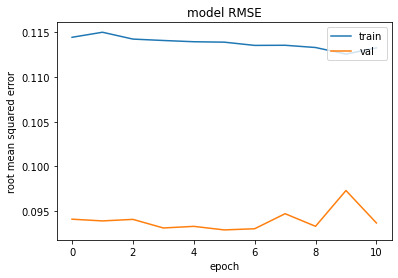

In [ ]:
history_ne_2 = model_2.fit(X_train_ne2, y_train_ne2, validation_data=(X_val1_ne2, y_val1_ne2), epochs=50, callbacks=[early_stopping_monitor],verbose=False)

# summarize history for rmse
plt.plot(history_ne_2.history['root_mean_squared_error'])
plt.plot(history_ne_2.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()


In [ ]:
print(classification_report(test_results_ne_2['actuals'], test_results_ne_2['predictions']))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       618
         1.0       0.89      0.89      0.89         9
         2.0       1.00      0.99      0.99        97

    accuracy                           1.00       724
   macro avg       0.96      0.96      0.96       724
weighted avg       1.00      1.00      1.00       724



###comparing all the LSTM models

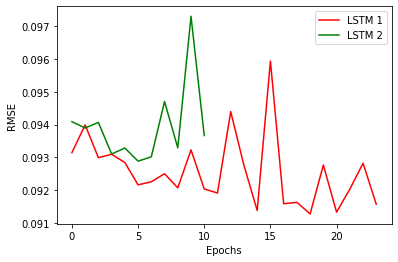

In [ ]:
plt.plot(history_ne_1.history['val_root_mean_squared_error'], 'r',
         history_ne_2.history['val_root_mean_squared_error'],'g')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(['LSTM 1', 'LSTM 2'], loc='upper right')
plt.show()

####predicting for 1 jan 2021 until 1 feb 2021 using the 2nd model

In [ ]:
df_date = pd.DataFrame({
    'date':pd.date_range(start='2021-01-01', end='2021-02-01')
})
df_date

date
0  2021-01-01
1  2021-01-02
2  2021-01-03
3  2021-01-04
4  2021-01-05
5  2021-01-06
6  2021-01-07
7  2021-01-08
8  2021-01-09
9  2021-01-10
10 2021-01-11
11 2021-01-12
12 2021-01-13
13 2021-01-14
14 2021-01-15
15 2021-01-16
16 2021-01-17
17 2021-01-18
18 2021-01-19
19 2021-01-20
20 2021-01-21
21 2021-01-22
22 2021-01-23
23 2021-01-24
24 2021-01-25
25 2021-01-26
26 2021-01-27
27 2021-01-28
28 2021-01-29
29 2021-01-30
30 2021-01-31
31 2021-02-01

In [ ]:
df_date.index = pd.to_datetime(df_date['date'], format='%Y.%m.%d')
df_date

date
date                 
2021-01-01 2021-01-01
2021-01-02 2021-01-02
2021-01-03 2021-01-03
2021-01-04 2021-01-04
2021-01-05 2021-01-05
2021-01-06 2021-01-06
2021-01-07 2021-01-07
2021-01-08 2021-01-08
2021-01-09 2021-01-09
2021-01-10 2021-01-10
2021-01-11 2021-01-11
2021-01-12 2021-01-12
2021-01-13 2021-01-13
2021-01-14 2021-01-14
2021-01-15 2021-01-15
2021-01-16 2021-01-16
2021-01-17 2021-01-17
2021-01-18 2021-01-18
2021-01-19 2021-01-19
2021-01-20 2021-01-20
2021-01-21 2021-01-21
2021-01-22 2021-01-22
2021-01-23 2021-01-23
2021-01-24 2021-01-24
2021-01-25 2021-01-25
2021-01-26 2021-01-26
2021-01-27 2021-01-27
2021-01-28 2021-01-28
2021-01-29 2021-01-29
2021-01-30 2021-01-30
2021-01-31 2021-01-31
2021-02-01 2021-02-01

In [ ]:
df_date['Seconds'] = df_date.index.map(pd.Timestamp.timestamp)
df_date

date       Seconds
date                               
2021-01-01 2021-01-01  1.609459e+09
2021-01-02 2021-01-02  1.609546e+09
2021-01-03 2021-01-03  1.609632e+09
2021-01-04 2021-01-04  1.609718e+09
2021-01-05 2021-01-05  1.609805e+09
2021-01-06 2021-01-06  1.609891e+09
2021-01-07 2021-01-07  1.609978e+09
2021-01-08 2021-01-08  1.610064e+09
2021-01-09 2021-01-09  1.610150e+09
2021-01-10 2021-01-10  1.610237e+09
2021-01-11 2021-01-11  1.610323e+09
2021-01-12 2021-01-12  1.610410e+09
2021-01-13 2021-01-13  1.610496e+09
2021-01-14 2021-01-14  1.610582e+09
2021-01-15 2021-01-15  1.610669e+09
2021-01-16 2021-01-16  1.610755e+09
2021-01-17 2021-01-17  1.610842e+09
2021-01-18 2021-01-18  1.610928e+09
2021-01-19 2021-01-19  1.611014e+09
2021-01-20 2021-01-20  1.611101e+09
2021-01-21 2021-01-21  1.611187e+09
2021-01-22 2021-01-22  1.611274e+09
2021-01-23 2021-01-23  1.611360e+09
2021-01-24 2021-01-24  1.611446e+09
2021-01-25 2021-01-25  1.611533e+09
2021-01-26 2021-01-26  1.611619e+09
2021-01-27 2021-01-27  1.611706e+09
2021-01-28 2021-01-28  1.611792e+09
2021-01-29 2021-01-29  1.611878e+09
2021-01-30 2021-01-30  1.611965e+09
2021-01-31 2021-01-31  1.612051e+09
2021-02-01 2021-02-01  1.612138e+09

In [ ]:
df_date['Day sin'] = np.sin(df_date['Seconds'] * (2* np.pi / day))
df_date['Day cos'] = np.cos(df_date['Seconds'] * (2 * np.pi / day))
df_date['Month sin'] = np.sin(df_date['Seconds'] * (2* np.pi / month))
df_date['Month cos'] = np.cos(df_date['Seconds'] * (2* np.pi / month))
df_date['Year sin'] = np.sin(df_date['Seconds'] * (2 * np.pi / year))
df_date['Year cos'] = np.cos(df_date['Seconds'] * (2 * np.pi / year))
df_date.head()

date       Seconds       Day sin  Day cos  Month sin  \
date                                                                    
2021-01-01 2021-01-01  1.609459e+09 -6.012051e-12      1.0   0.114525   
2021-01-02 2021-01-02  1.609546e+09 -1.713513e-12      1.0   0.315714   
2021-01-03 2021-01-03  1.609632e+09 -1.196689e-11      1.0   0.503497   
2021-01-04 2021-01-04  1.609718e+09 -7.668351e-12      1.0   0.669900   
2021-01-05 2021-01-05  1.609805e+09 -3.369812e-12      1.0   0.807857   

            Month cos  Year sin  Year cos  
date                                       
2021-01-01   0.993420  0.010881  0.999941  
2021-01-02   0.948854  0.028080  0.999606  
2021-01-03   0.863997  0.045271  0.998975  
2021-01-04   0.742451  0.062448  0.998048  
2021-01-05   0.589379  0.079608  0.996826

In [ ]:
df_date = df_date.drop('Seconds', axis=1)
df_date = df_date.drop('date',axis=1)
df_date.head()

Day sin  Day cos  Month sin  Month cos  Year sin  Year cos
date                                                                       
2021-01-01 -6.012051e-12      1.0   0.114525   0.993420  0.010881  0.999941
2021-01-02 -1.713513e-12      1.0   0.315714   0.948854  0.028080  0.999606
2021-01-03 -1.196689e-11      1.0   0.503497   0.863997  0.045271  0.998975
2021-01-04 -7.668351e-12      1.0   0.669900   0.742451  0.062448  0.998048
2021-01-05 -3.369812e-12      1.0   0.807857   0.589379  0.079608  0.996826

In [ ]:
df_date.insert(0, "score", [0 for i in range(32)], True)
df_date

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2021-01-01      0 -6.012051e-12      1.0   0.114525   0.993420  0.010881   
2021-01-02      0 -1.713513e-12      1.0   0.315714   0.948854  0.028080   
2021-01-03      0 -1.196689e-11      1.0   0.503497   0.863997  0.045271   
2021-01-04      0 -7.668351e-12      1.0   0.669900   0.742451  0.062448   
2021-01-05      0 -3.369812e-12      1.0   0.807857   0.589379  0.079608   
2021-01-06      0  9.287266e-13      1.0   0.911509   0.411280  0.096743   
2021-01-07      0 -9.324650e-12      1.0   0.976456   0.215716  0.113850   
2021-01-08      0 -5.026111e-12      1.0   0.999940   0.010992  0.130923   
2021-01-09      0 -7.275728e-13      1.0   0.980962  -0.194198  0.147958   
2021-01-10      0 -1.098095e-11      1.0   0.920330  -0.391142  0.164948   
2021-01-11      0 -6.682411e-12      1.0   0.820618  -0.571477  0.181890   
2021-01-12      0 -2.383872e-12      1.0   0.686059  -0.727545  0.198778   
2021-01-13      0 -1.263725e-11      1.0   0.522369  -0.852720  0.215608   
2021-01-14      0 -8.338710e-12      1.0   0.336497  -0.941685  0.232373   
2021-01-15      0 -4.040172e-12      1.0   0.136336  -0.990663  0.249070   
2021-01-16      0  2.583671e-13      1.0  -0.069615  -0.997574  0.265693   
2021-01-17      0 -9.995009e-12      1.0  -0.272609  -0.962125  0.282237   
2021-01-18      0 -5.696471e-12      1.0  -0.464027  -0.885821  0.298698   
2021-01-19      0 -1.397932e-12      1.0  -0.635741  -0.771902  0.315070   
2021-01-20      0 -1.165131e-11      1.0  -0.780460  -0.625206  0.331350   
2021-01-21      0 -7.352770e-12      1.0  -0.892037  -0.451961  0.347531   
2021-01-22      0 -3.054232e-12      1.0  -0.965736  -0.259525  0.363609   
2021-01-23      0 -1.330761e-11      1.0  -0.998427  -0.056069  0.379580   
2021-01-24      0 -9.009070e-12      1.0  -0.988721   0.149769  0.395438   
2021-01-25      0 -4.710531e-12      1.0  -0.937031   0.349247  0.411179   
2021-01-26      0 -4.119923e-13      1.0  -0.845551   0.533894  0.426799   
2021-01-27      0 -1.066537e-11      1.0  -0.718167   0.695871  0.442292   
2021-01-28      0 -6.366830e-12      1.0  -0.560287   0.828299  0.457655   
2021-01-29      0 -2.068292e-12      1.0  -0.378615   0.925554  0.472882   
2021-01-30      0 -1.232167e-11      1.0  -0.180866   0.983508  0.487969   
2021-01-31      0 -8.023130e-12      1.0   0.024563   0.999698  0.502912   
2021-02-01      0 -3.724591e-12      1.0   0.228949   0.973438  0.517705   

            Year cos  
date                  
2021-01-01  0.999941  
2021-01-02  0.999606  
2021-01-03  0.998975  
2021-01-04  0.998048  
2021-01-05  0.996826  
2021-01-06  0.995309  
2021-01-07  0.993498  
2021-01-08  0.991393  
2021-01-09  0.988994  
2021-01-10  0.986302  
2021-01-11  0.983319  
2021-01-12  0.980044  
2021-01-13  0.976480  
2021-01-14  0.972627  
2021-01-15  0.968486  
2021-01-16  0.964058  
2021-01-17  0.959345  
2021-01-18  0.954348  
2021-01-19  0.949068  
2021-01-20  0.943508  
2021-01-21  0.937669  
2021-01-22  0.931552  
2021-01-23  0.925159  
2021-01-24  0.918493  
2021-01-25  0.911554  
2021-01-26  0.904347  
2021-01-27  0.896871  
2021-01-28  0.889130  
2021-01-29  0.881126  
2021-01-30  0.872861  
2021-01-31  0.864338  
2021-02-01  0.855559

In [ ]:
x_test_ne = scorene_test_df.tail(7)
x_test_ne

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2020-12-25    2.0 -6.997991e-12      1.0  -0.971208   0.238232 -0.109320   
2020-12-26    2.0 -2.699453e-12      1.0  -0.901757   0.432242 -0.092205   
2020-12-27    2.0 -1.295283e-11      1.0  -0.794015   0.607898 -0.075062   
2020-12-28    2.0 -8.654291e-12      1.0  -0.652557   0.757740 -0.057898   
2020-12-29    2.0 -4.355752e-12      1.0  -0.483388   0.875406 -0.040716   
2020-12-30    2.0 -5.721331e-14      1.0  -0.293694   0.955900 -0.023523   
2020-12-31    2.0 -1.031059e-11      1.0  -0.091528   0.995803 -0.006322   

            Year cos  
date                  
2020-12-25  0.994007  
2020-12-26  0.995740  
2020-12-27  0.997179  
2020-12-28  0.998323  
2020-12-29  0.999171  
2020-12-30  0.999723  
2020-12-31  0.999980

In [ ]:
x_test1_ne = x_test_ne.append(df_date)
x_test1_ne

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2020-12-25    2.0 -6.997991e-12      1.0  -0.971208   0.238232 -0.109320   
2020-12-26    2.0 -2.699453e-12      1.0  -0.901757   0.432242 -0.092205   
2020-12-27    2.0 -1.295283e-11      1.0  -0.794015   0.607898 -0.075062   
2020-12-28    2.0 -8.654291e-12      1.0  -0.652557   0.757740 -0.057898   
2020-12-29    2.0 -4.355752e-12      1.0  -0.483388   0.875406 -0.040716   
2020-12-30    2.0 -5.721331e-14      1.0  -0.293694   0.955900 -0.023523   
2020-12-31    2.0 -1.031059e-11      1.0  -0.091528   0.995803 -0.006322   
2021-01-01    0.0 -6.012051e-12      1.0   0.114525   0.993420  0.010881   
2021-01-02    0.0 -1.713513e-12      1.0   0.315714   0.948854  0.028080   
2021-01-03    0.0 -1.196689e-11      1.0   0.503497   0.863997  0.045271   
2021-01-04    0.0 -7.668351e-12      1.0   0.669900   0.742451  0.062448   
2021-01-05    0.0 -3.369812e-12      1.0   0.807857   0.589379  0.079608   
2021-01-06    0.0  9.287266e-13      1.0   0.911509   0.411280  0.096743   
2021-01-07    0.0 -9.324650e-12      1.0   0.976456   0.215716  0.113850   
2021-01-08    0.0 -5.026111e-12      1.0   0.999940   0.010992  0.130923   
2021-01-09    0.0 -7.275728e-13      1.0   0.980962  -0.194198  0.147958   
2021-01-10    0.0 -1.098095e-11      1.0   0.920330  -0.391142  0.164948   
2021-01-11    0.0 -6.682411e-12      1.0   0.820618  -0.571477  0.181890   
2021-01-12    0.0 -2.383872e-12      1.0   0.686059  -0.727545  0.198778   
2021-01-13    0.0 -1.263725e-11      1.0   0.522369  -0.852720  0.215608   
2021-01-14    0.0 -8.338710e-12      1.0   0.336497  -0.941685  0.232373   
2021-01-15    0.0 -4.040172e-12      1.0   0.136336  -0.990663  0.249070   
2021-01-16    0.0  2.583671e-13      1.0  -0.069615  -0.997574  0.265693   
2021-01-17    0.0 -9.995009e-12      1.0  -0.272609  -0.962125  0.282237   
2021-01-18    0.0 -5.696471e-12      1.0  -0.464027  -0.885821  0.298698   
2021-01-19    0.0 -1.397932e-12      1.0  -0.635741  -0.771902  0.315070   
2021-01-20    0.0 -1.165131e-11      1.0  -0.780460  -0.625206  0.331350   
2021-01-21    0.0 -7.352770e-12      1.0  -0.892037  -0.451961  0.347531   
2021-01-22    0.0 -3.054232e-12      1.0  -0.965736  -0.259525  0.363609   
2021-01-23    0.0 -1.330761e-11      1.0  -0.998427  -0.056069  0.379580   
2021-01-24    0.0 -9.009070e-12      1.0  -0.988721   0.149769  0.395438   
2021-01-25    0.0 -4.710531e-12      1.0  -0.937031   0.349247  0.411179   
2021-01-26    0.0 -4.119923e-13      1.0  -0.845551   0.533894  0.426799   
2021-01-27    0.0 -1.066537e-11      1.0  -0.718167   0.695871  0.442292   
2021-01-28    0.0 -6.366830e-12      1.0  -0.560287   0.828299  0.457655   
2021-01-29    0.0 -2.068292e-12      1.0  -0.378615   0.925554  0.472882   
2021-01-30    0.0 -1.232167e-11      1.0  -0.180866   0.983508  0.487969   
2021-01-31    0.0 -8.023130e-12      1.0   0.024563   0.999698  0.502912   
2021-02-01    0.0 -3.724591e-12      1.0   0.228949   0.973438  0.517705   

            Year cos  
date                  
2020-12-25  0.994007  
2020-12-26  0.995740  
2020-12-27  0.997179  
2020-12-28  0.998323  
2020-12-29  0.999171  
2020-12-30  0.999723  
2020-12-31  0.999980  
2021-01-01  0.999941  
2021-01-02  0.999606  
2021-01-03  0.998975  
2021-01-04  0.998048  
2021-01-05  0.996826  
2021-01-06  0.995309  
2021-01-07  0.993498  
2021-01-08  0.991393  
2021-01-09  0.988994  
2021-01-10  0.986302  
2021-01-11  0.983319  
2021-01-12  0.980044  
2021-01-13  0.976480  
2021-01-14  0.972627  
2021-01-15  0.968486  
2021-01-16  0.964058  
2021-01-17  0.959345  
2021-01-18  0.954348  
2021-01-19  0.949068  
2021-01-20  0.943508  
2021-01-21  0.937669  
2021-01-22  0.931552  
2021-01-23  0.925159  
2021-01-24  0.918493  
2021-01-25  0.911554  
2021-01-26  0.904347  
2021-01-27  0.896871  
2021-01-28  0.889130  
2021-01-29  0.881126  
2021-01-30  0.872861 

In [ ]:
WINDOW_SIZE = 7
X_test1_ne2_new, y_test1_ne2_new = df_to_X_y2(x_test1_ne, WINDOW_SIZE)
X_test1_ne2_new.shape

(32, 7, 7)

In [ ]:
test_prediction_2_new_ne = model_2.predict(X_test1_ne2_new).flatten()
test_results_2_new_ne = pd.DataFrame(data={'predictions':test_prediction_2_new_ne})
test_results_2_new_ne

1/1 [==============================] - 0s 18ms/step


predictions
0      3.704433
1      1.266607
2      0.849521
3      0.854804
4      0.898901
5      0.921934
6      0.924591
7      0.919336
8      0.917911
9      0.918719
10     0.921638
11     0.926243
12     0.931915
13     0.937937
14     0.943577
15     0.948158
16     0.951143
17     0.952218
18     0.951364
19     0.948884
20     0.945372
21     0.941610
22     0.938416
23     0.936466
24     0.936136
25     0.937413
26     0.939910
27     0.942962
28     0.945790
29     0.947668
30     0.948050
31     0.946632

#####result

In [ ]:
test_results_2_new_ne.predictions[test_results_2_new_ne.predictions <0.5] = 0
test_results_2_new_ne.predictions[(test_results_2_new_ne.predictions >=0.5)&(test_results_2_new_ne.predictions<1.5)] = 1
test_results_2_new_ne.predictions[(test_results_2_new_ne.predictions >=1.5)&(test_results_2_new_ne.predictions<2.5)] = 2
test_results_2_new_ne.predictions[(test_results_2_new_ne.predictions >=2.5)&(test_results_2_new_ne.predictions<3.5)] = 3
test_results_2_new_ne.predictions[(test_results_2_new_ne.predictions >=3.5)&(test_results_2_new_ne.predictions<4.5)] = 4
test_results_2_new_ne.predictions[(test_results_2_new_ne.predictions >=4.5)&(test_results_2_new_ne.predictions<5.5)] = 5
test_results_2_new_ne

predictions
0           4.0
1           1.0
2           1.0
3           1.0
4           1.0
5           1.0
6           1.0
7           1.0
8           1.0
9           1.0
10          1.0
11          1.0
12          1.0
13          1.0
14          1.0
15          1.0
16          1.0
17          1.0
18          1.0
19          1.0
20          1.0
21          1.0
22          1.0
23          1.0
24          1.0
25          1.0
26          1.0
27          1.0
28          1.0
29          1.0
30          1.0
31          1.0